In [1]:
# select a GPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
import pandas as pd
import numpy as np
import librosa
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import seaborn as sns

import matplotlib.pyplot as plt
from IPython.display import Audio
import soundfile as sf
import soundfile as sound
import keras
from DCASE2019_improvised_network import PadChannels
from DCASE2019_improvised_network import SliceLayer


from DCASE2019_improvised_network import model_resnet_new
import soundfile as sound
import tensorflow as tf
from pytorch_grad_cam import GradCAM,GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,preprocess_image

2024-07-24 15:58:30.453344: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-24 15:58:34.024852: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# eval_df = pd.read_csv('largemodel_predictions.csv')
# eval_df = pd.read_csv('120epoch_largemodel_predictions.csv')
# eval_df = pd.read_csv('62epoch_largemodel_predictions.csv')
eval_df = pd.read_csv('126epoch_largemodel_predictions.csv')
eval_df = eval_df.drop(['Unnamed: 0'], axis = 1)
eval_df = eval_df.rename(columns = {'filename':'Filename','scene_label':'Actual Label', 'predicted_scene_label': 'Predicted Label'})
eval_df.shape

(4185, 3)

In [4]:
eval_df.head()

Filename       Actual Label  \
0   audio/street_pedestrian-lyon-1162-44093-a.wav  street_pedestrian   
1             audio/metro-prague-1163-44094-a.wav              metro   
2               audio/park-milan-1164-44095-a.wav               park   
3  audio/street_pedestrian-milan-1165-44096-a.wav  street_pedestrian   
4     audio/street_traffic-milan-1166-44097-a.wav     street_traffic   

     Predicted Label  
0  street_pedestrian  
1              metro  
2               park  
3  street_pedestrian  
4     street_traffic

/tmp/ipykernel_3429447/1125380711.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=60)


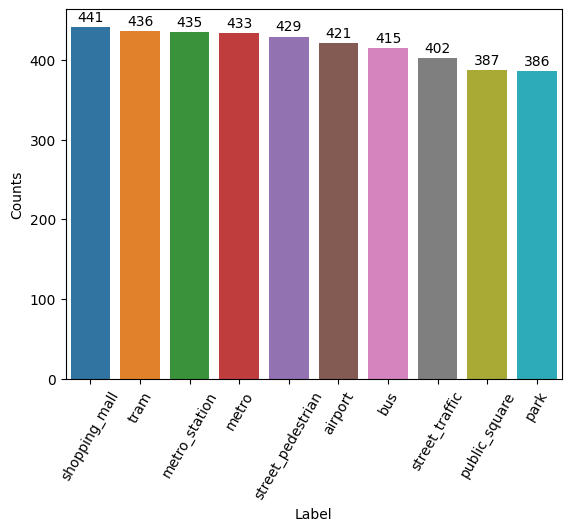

In [5]:
df_gb = eval_df['Actual Label'].value_counts().reset_index()
df_gb.columns = ['Label', 'Counts']

# Creating the bar plot
my_plot = sns.barplot(x='Label', y='Counts', data=df_gb, hue='Label', dodge=False)

# Setting the x-tick labels with rotation
my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=60)

# Adding the text labels on the bars
for p in my_plot.patches:
    my_plot.annotate(format(p.get_height(), '.0f'),  # Format the number as a float
                     (p.get_x() + p.get_width() / 2., p.get_height()),  # Position for the text
                     ha = 'center',  # Center alignment
                     va = 'center',  # Center alignment
                     xytext = (0, 7),  # Distance from text to points (x,y)
                     textcoords = 'offset points')  # Offset (in points) from the *xy* value
# Show the plot
plt.show()

In [6]:
# Correct Predictions
correct_pred = eval_df[eval_df['Predicted Label'] == eval_df['Actual Label']]
print(correct_pred.shape)
correct_pred.head()

(3262, 3)


Filename       Actual Label  \
0   audio/street_pedestrian-lyon-1162-44093-a.wav  street_pedestrian   
1             audio/metro-prague-1163-44094-a.wav              metro   
2               audio/park-milan-1164-44095-a.wav               park   
3  audio/street_pedestrian-milan-1165-44096-a.wav  street_pedestrian   
4     audio/street_traffic-milan-1166-44097-a.wav     street_traffic   

     Predicted Label  
0  street_pedestrian  
1              metro  
2               park  
3  street_pedestrian  
4     street_traffic

In [7]:
# Incorrect Predictions
incorrect_pred = eval_df[eval_df['Predicted Label'] != eval_df['Actual Label']]
incorrect_pred.shape

(923, 3)

In [8]:
# Checking for accuracy
(correct_pred.shape[0]/4185) * 100

77.94504181600955

In [9]:
#Task 1a dev validation set
ThisPath = '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/'
File = ThisPath + 'evaluation_setup/fold1_evaluate.csv'
sr = 48000
SampleDuration = 10
NumFreqBins = 128
NumFFTPoints = 2048
HopLength = int(NumFFTPoints/2)
NumTimeBins = int(np.ceil(SampleDuration*sr/HopLength))

In [10]:
custom_objects = {
    'PadChannels': PadChannels,
    'SliceLayer': SliceLayer
}
## 120 EPOCH CHECKPOINT
# model_path = "/work/aistwal/backup/MMDS_MasterThesis/models/asc/largemodel_checkpoint/DCASE_1a_Task_development_1.h5"
# best_model = keras.models.load_model(model_path, custom_objects=custom_objects)


# INTERMEDIATE KERAS CHECKPOINT
# model_path = '/work/aistwal/backup/MMDS_MasterThesis/models/asc/largemodel_checkpoint/model_62-1.13.keras'
model_path = '/work/aistwal/DCASE2019-Task1/asc_checkpoints/model_126-1.13.keras'

best_model = keras.saving.load_model(model_path)

model_name = model_path.split('/')[-1]
print("model name: ", model_name)
best_model.summary()

2024-07-24 15:58:47.935224: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 39134 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:61:00.0, compute capability: 8.6


model name:  model_126-1.13.keras


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, None, │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_layer         │ (None, 64, None,  │          0 │ input_layer[0][0] │
│ (SliceLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_layer_1       │ (None, 64, None,  │          0 │ input_layer[0][0] │
│ (SliceLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, None,  │          8 │ slice_layer[0][0] │
│ (BatchNormalizatio… │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, None,  │          8 │ slice_layer_1[0]… │
│ (BatchNormalizatio… │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, None,  │        432 │ batch_normalizat… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 64, None,  │      6,912 │ batch_normalizat… │
│                     │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, None,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, None,  │      1,536 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, None,  │          0 │ batch_normalizat… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 64, None,  │          0 │ batch_normalizat… │
│ (Activation)        │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, None,  │      5,184 │ activation[0][0]  │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, None,  │  1,327,104 │ activation_16[0]… │
│                     │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, None,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, None,  │      1,536 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, None,  │          0 │ batch_normalizat… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 64, None,  │          0 │ batch_normalizat

 Total params: 874,743,262 (3.26 GB)

 Trainable params: 437,334,440 (1.63 GB)

 Non-trainable params: 74,380 (290.55 KB)

 Optimizer params: 437,334,442 (1.63 GB)

Randomly get 10 audios

In [11]:
conv_layer = best_model.get_layer('conv2d_35')
conv_layer_output_shape = conv_layer.output
num_feature_maps = conv_layer_output_shape[-1]
print(num_feature_maps) #10

<KerasTensor shape=(64, None, 10), dtype=float32, sparse=False, name=keras_tensor_295>


In [12]:
correct_audio_list = ['/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45459-a.wav','/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8053-a.wav','/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8289-a.wav','/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44633-a.wav', '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-milan-1222-45317-a.wav','/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8561-a.wav','/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6366-a.wav','/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6305-a.wav']
correct_audio_list, len(correct_audio_list)

(['/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45459-a.wav',
  '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8053-a.wav',
  '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8289-a.wav',
  '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44633-a.wav',
  '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-milan-1222-45317-a.wav',
  '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8561-a.wav',
  '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6366-a.wav',
  '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban

In [13]:
# correct_audio_list = correct_pred['Filename'].sample(n=10, random_state = 1).tolist()
# correct_audio_list

In [14]:
labels = ['airport', 'bus', 'metro', 'metro_station', 'park', 'public_square', 'shopping_mall', 'street_pedestrian', 'street_traffic', 'tram']
lb_to_idx = {lb: idx for idx, lb in enumerate(labels)}
idx_to_lb = {idx: lb for idx, lb in enumerate(labels)}

In [15]:
idx_to_lb

{0: 'airport',
 1: 'bus',
 2: 'metro',
 3: 'metro_station',
 4: 'park',
 5: 'public_square',
 6: 'shopping_mall',
 7: 'street_pedestrian',
 8: 'street_traffic',
 9: 'tram'}

In [16]:
# # Getting keras model layers
# for layers in best_model.layers:
#     print(layers.name)

In [17]:
def display_log_mel_spectrogram(audioname, version, input_feature, model_name):
    print(audioname, "Log-Mel Feature Shape : ", input_feature.shape)
    plt.figure(figsize=(15, 6))
    plt.title(f'SPECTROGRAM FOR {audioname}')
    root_dir = '/work/aistwal/backup/MMDS_MasterThesis/models/asc'
    save_path = os.path.join(root_dir, 'large_model_files', model_name, version)
    
    # Create the directory if it does not exist
    os.makedirs(save_path, exist_ok=True)
    
    file_path = os.path.join(save_path, f'{audioname}-spectrogram.png')
    librosa.display.specshow(input_feature, x_axis='time', y_axis='linear', sr=sr, hop_length=HopLength)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.savefig(file_path)
    plt.show()

In [40]:
def blackout_unimportant_features(grayscale_cam, input_spectrogram, percentile = 85):
    normalized_cam = (grayscale_cam - np.min(grayscale_cam)) / (np.max(grayscale_cam) - np.min(grayscale_cam))
    threshold = np.percentile(normalized_cam, percentile)
    # Create a mask for important regions
    important_mask = normalized_cam >= threshold
    
    # Get the minimum value of the input spectrogram
    min_value = np.min(input_spectrogram)
    
    # Create a copy of the input spectrogram to modify
    modified_spectrogram = np.copy(input_spectrogram)
    
    # Blackout unimportant regions by setting them to the minimum value
    modified_spectrogram[~important_mask] = min_value
    
    return modified_spectrogram

In [19]:
def spectrogram_indices_to_sample_range(col_index, hop_length = HopLength, n_fft = NumFFTPoints):
    """     
    Convert the column index of a spectrogram to the sample range of the original waveform.     
    Parameters:     
    
    column_index (int): The column index of the spectrogram.     
    hop_length (int): The hop length used in the STFT.     
    n_fft (int): The window length (number of FFT points) used in the STFT.     
    
    Returns:     
        tuple: A tuple containing the start and end sample indices (inclusive) in the original waveform.     
    """
    start_sample = col_index * hop_length
    end_sample = start_sample + n_fft
    return start_sample, end_sample

In [39]:
def blackout_only_x_dim(grayscale_cam, log_mel_spectrogram, percentile = 85):

    # Create copy of input_spectrogram
    generalized_cam_version = np.copy(log_mel_spectrogram) #64*641
    
    # Get the minimum value of the input spectrogram
    min_value = np.min(log_mel_spectrogram)
    
    normalized_cam = (grayscale_cam - np.min(grayscale_cam)) / (np.max(grayscale_cam) - np.min(grayscale_cam))
    print("Columns: ", normalized_cam.shape[1])

    threshold = np.percentile(normalized_cam, percentile)
    threshold = float("{:.2f}".format(threshold))  #set threshold format
    print("Threshold: ", threshold)
    deactivated_col_list = []
    for col in range(0, normalized_cam.shape[1]):
        flag = np.all(normalized_cam[:,col] < threshold)
        if flag:
            deactivated_col_list.append(col)
            generalized_cam_version[:,col] = min_value
            
    return generalized_cam_version, deactivated_col_list

In [34]:
def make_gradcam_plus_plus_heatmap(img_array, best_model, last_conv_layer_name='conv2d_35', pred_index=None):
    ## Create a model that maps the input spectrogram feature to the activations of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        best_model.inputs, [best_model.get_layer(last_conv_layer_name).output, best_model.output]
    )

    ## Compute the gradient of the top predicted class for our input feature for the activations of the last conv layer
    with tf.GradientTape() as gtape1:
        with tf.GradientTape() as gtape2:
            with tf.GradientTape() as gtape3:
                last_conv_layer_output, preds = grad_model(img_array)
                if pred_index is None:
                    pred_index = tf.argmax(preds[0])
                class_channel = preds[:, pred_index]
                first_grads = gtape3.gradient(class_channel, last_conv_layer_output)
            second_grads = gtape2.gradient(first_grads, last_conv_layer_output)
        third_grads = gtape1.gradient(second_grads, last_conv_layer_output)

    global_sum = np.sum(last_conv_layer_output, axis=(0, 1, 2))

    alpha_num = second_grads[0]
    alpha_denom = second_grads[0] * 2.0 + third_grads[0] * global_sum
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)

    alphas = alpha_num / alpha_denom
    alpha_normalization_constant = np.sum(alphas, axis=(0, 1))
    alphas /= alpha_normalization_constant

    weights = np.maximum(first_grads[0], 0.0)

    deep_linearization_weights = np.sum(weights * alphas, axis=(0, 1))
    grad_cam_plus_plus_map = np.sum(deep_linearization_weights * last_conv_layer_output[0], axis=2)

    heatmap = np.maximum(grad_cam_plus_plus_map, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    return heatmap


In [35]:
def make_gradcam_heatmap(img_array, best_model, last_conv_layer_name = 'conv2d_35', pred_index=None):
    ## First, we create a model that maps the input spectrogram feature to the activations of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        best_model.inputs, [best_model.get_layer(last_conv_layer_name).output, best_model.output]
    )

    ## Then, we compute the gradient of the top predicted class for our input feature for the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # print("Last convolutional layer output: ", last_conv_layer_output.shape)
    # print("Selected class channel:", class_channel)

    ## We are doing transfer learning on last layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    # We have 10 feature maps
    # print(grads.shape) #(1, 64, 30, 10)
    # This is a vector where each entry is the mean intensity of the gradient, as average across the batch size, height, and width dimensions will leave you with the mean gradient for each feature map.
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    ## calculates a heatmap highlighting the regions of importance in an image for a specific predicted class by 
    ## combining the output of the last convolutional layer with the pooled gradients.
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    ## For visualization purpose
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [36]:
def display_gradcam_with_spectrogram(spectrogram, version, model_name, heatmap, sr, alpha=0.5):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Resize heatmap to match spectrogram dimensions
    heatmap_resized = tf.image.resize(jet_heatmap, [spectrogram.shape[0], spectrogram.shape[1]]) #(128,469)

    # Set the save path
    root_dir = '/work/aistwal/backup/MMDS_MasterThesis/models/asc'
    save_path = os.path.join(root_dir, 'large_model_files', model_name, version)
    
    # Create the directory if it does not exist
    os.makedirs(save_path, exist_ok=True)
    
    file_path = os.path.join(save_path, f'{audioname}-spectrogram.png')
    # Display the spectrogram
    plt.figure(figsize=(15, 6))
    librosa.display.specshow(spectrogram, x_axis='time', y_axis='linear', sr=sr, hop_length=HopLength)

    # Overlay the heatmap
    plt.imshow(heatmap_resized, aspect='auto', alpha=alpha, origin='lower', interpolation='nearest')

    # Save and show the image
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Overlaid Log-Mel Spectrogram')
    plt.tight_layout()
    plt.savefig(file_path)
    plt.show()

In [37]:
def get_log_mel_features(wavpaths):
    feature = np.zeros((len(wavpaths),NumFreqBins,NumTimeBins,2),'float32')
    for i in range(len(wavpaths)):
        
        stereo,fs = sound.read(wavpaths[i],stop=SampleDuration*sr)
        for channel in range(2):
            feature[i,:,:,channel]= librosa.feature.melspectrogram(y = stereo[:,channel], 
                                           sr=sr,
                                           n_fft=NumFFTPoints,
                                           hop_length=HopLength,
                                           n_mels=NumFreqBins,
                                           fmin=0.0,
                                           fmax=sr/2,
                                           htk=True,
                                           norm=None)

    feature = np.log(feature)
    return feature

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8289-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction for  street_traffic-paris-272-8289-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction after cam mask for  street_traffic-paris-272-8289-a.wav is  street_traffic
street_traffic-paris-272-8289-a.wav Log-Mel Feature Shape :  (128, 469)


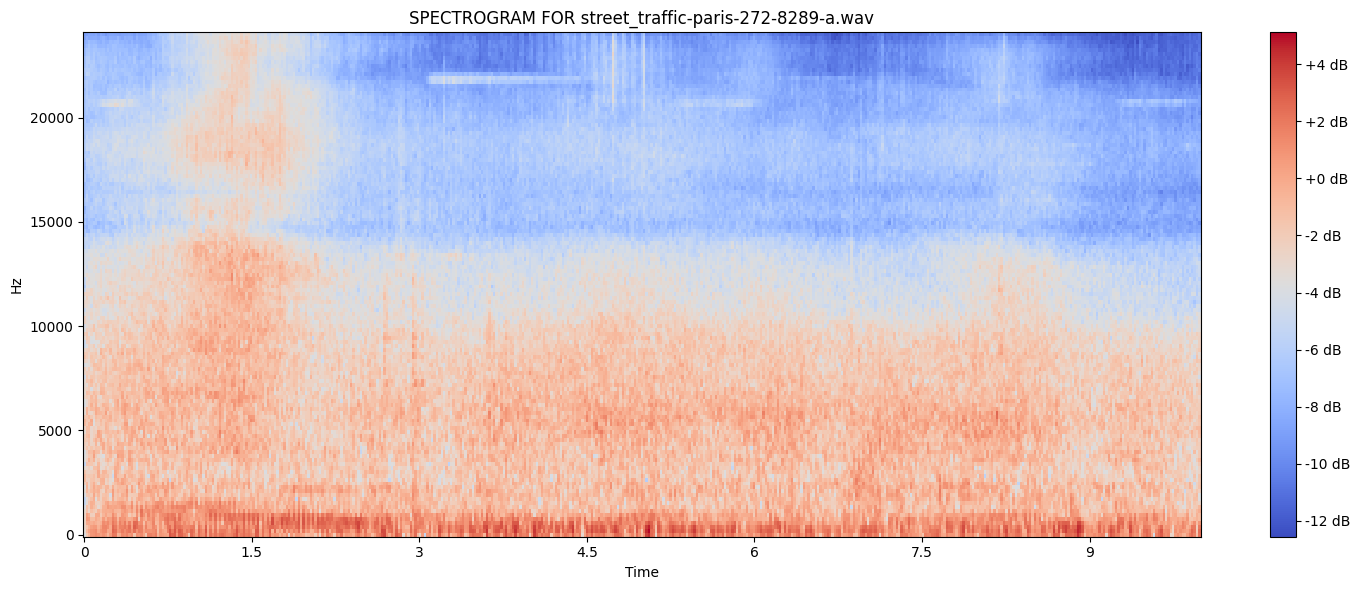

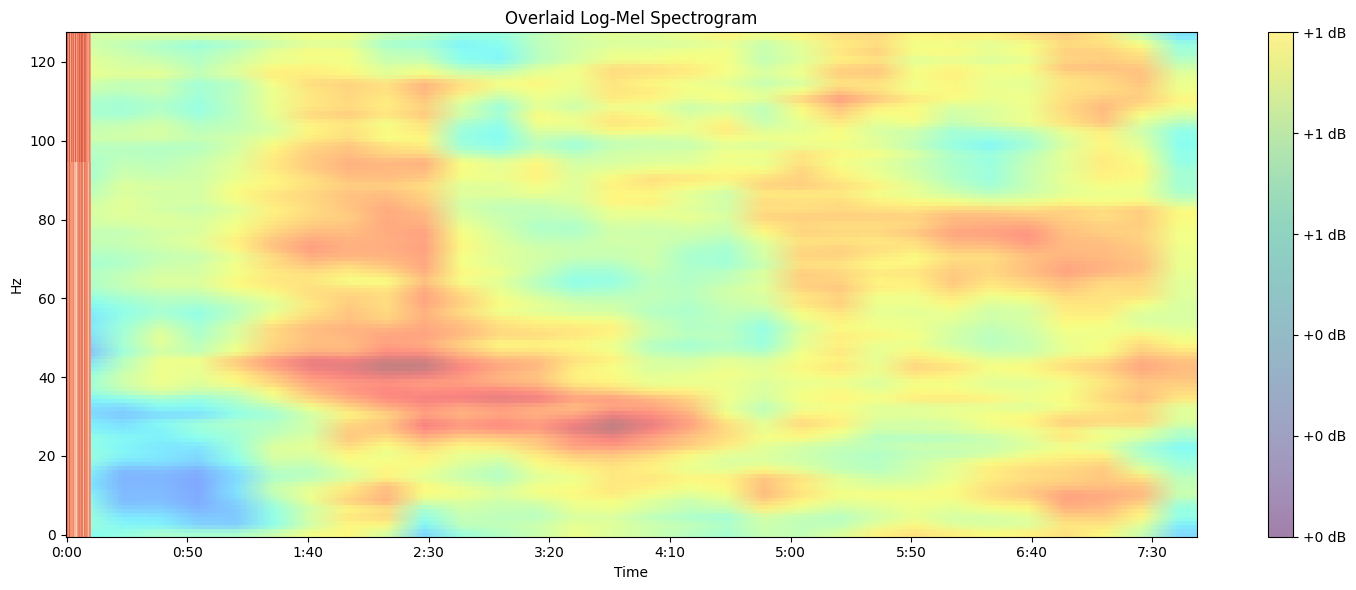

street_traffic-paris-272-8289-a.wav_modified Log-Mel Feature Shape :  (128, 469)


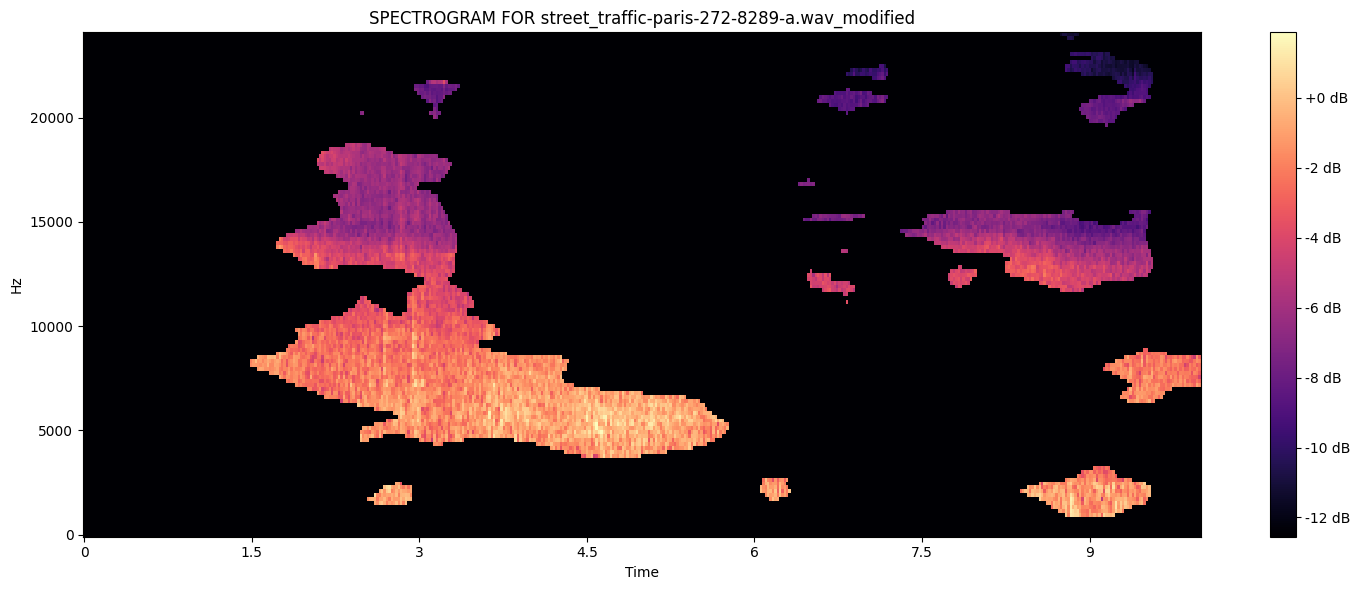

street_traffic-paris-272-8289-a.wav_generalized Log-Mel Feature Shape :  (128, 469)


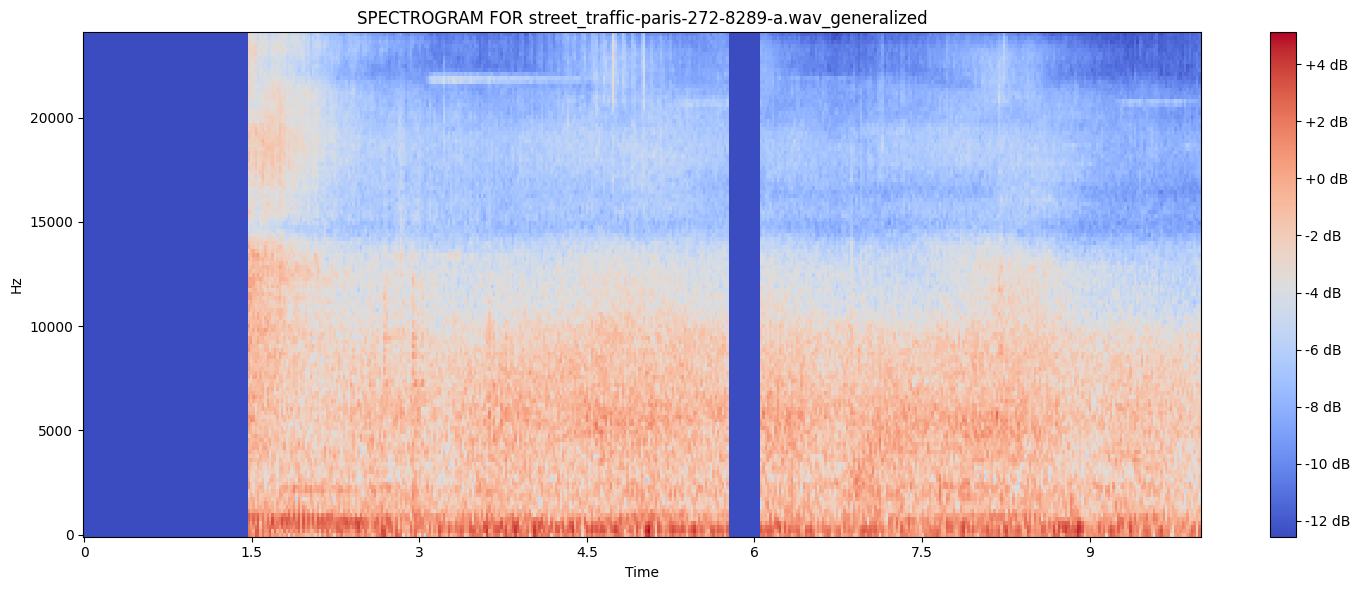

In [43]:
for audio in correct_audio_list[2:]:
    
    # audio_path = ThisPath + audio
    audio_path = audio
    print(audio_path)
    audioname = audio.split('/')[-1]
    y, sr = sound.read(audio_path, stop=SampleDuration*sr)
    
    # Extract the log-mel features.
    original_log_mel_spectrogram = get_log_mel_features([audio_path])
    
    ## Extracting first channel as log-mel-spectrogram since we have processed stereo audios consisting of 2 channels.
    #set channel as 0 or 1
    channel = 0
    log_mel_spectrogram = original_log_mel_spectrogram[0,:,:,channel]   
    
    # heatmap = make_gradcam_heatmap(original_log_mel_spectrogram, best_model)
    heatmap = make_gradcam_plus_plus_heatmap(original_log_mel_spectrogram, best_model)

    print("Shape of heatmap ", heatmap.shape)
    # print("Max value of heatmap", np.max(heatmap), "Min value ", np.min(heatmap))
    # plt.matshow(heatmap)
    # plt.show()
    
    # Resize heatmap to match spectrogram dimensions
    heatmap_resized = tf.image.resize(heatmap[..., tf.newaxis], [log_mel_spectrogram.shape[0], log_mel_spectrogram.shape[1]]).numpy().squeeze()
    # print("Max value of heatmap_resized", np.max(heatmap_resized), "Min value ", np.min(heatmap_resized))

    #Blackout
    modified_spectrogram = blackout_unimportant_features(heatmap_resized, log_mel_spectrogram)

    #Blackout only x, leave y
    generalized_cam_version, deactivated_col_list = blackout_only_x_dim(heatmap_resized, log_mel_spectrogram)

    #Get altered audio
    y_alt = np.copy(y)

    # Get start index and stop index
    for col_index in deactivated_col_list:
        start_sample, end_sample = spectrogram_indices_to_sample_range(col_index)
        y_alt[start_sample:end_sample+1] = y.min()

    # Prediction of the audio
    predicted_class = np.argmax(best_model.predict(original_log_mel_spectrogram), axis=1)
    pred_label = idx_to_lb[predicted_class[0]]
    print("Prediction for ",audioname ,"is ", pred_label)
    
    # Duplicate the modified spectrogram along the channel dimension to create 2 channels
    generalized_spectrogram = np.stack((generalized_cam_version, generalized_cam_version), axis=-1)
    # Add the batch dimension
    generalized_spectrogram = np.expand_dims(generalized_spectrogram, axis=0)
    # print("Original shape:", original_log_mel_spectrogram.shape, "generalized shape:", generalized_cam_version.shape)
    
    prediction_class = np.argmax(best_model.predict(generalized_spectrogram), axis=1)
    preds_after_cam_label = idx_to_lb[predicted_class[0]]
    print("Prediction after cam mask for ", audioname, "is ", preds_after_cam_label)

    
    
    display_log_mel_spectrogram(audioname, "spectrograms",log_mel_spectrogram, model_name)
    display_gradcam_with_spectrogram(log_mel_spectrogram, f"{channel}_overlaid_spectrograms", model_name, heatmap, sr)
    display_log_mel_spectrogram(audioname+"_modified", "cam_spectrograms", modified_spectrogram, model_name)
    display_log_mel_spectrogram(audioname+"_generalized","generalized_cam_spectrograms", generalized_cam_version, model_name)
    break



In [24]:
audio_root_path = '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/'
# audio_path = audio_root_path+ correct_audio_list[3]
audio_path = audio_root_path+'audio/airport-lyon-1169-45185-a.wav'
print(audio_path)
# Load the audio file

audio, sr = sound.read(audio_path,stop=SampleDuration*sr)
print(audio.shape)
print(audio[:,1].shape)
print("Sampling rate: ",sr)
Audio(data=audio[:,1], rate=sr)

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-45185-a.wav
(480000, 2)
(480000,)
Sampling rate:  48000


In [25]:
y_alt.shape
Audio(data=y_alt[:,0], rate=sr)

In [44]:
def plot_sound_event_detection_result(framewise_output):
    """Visualization of sound event detection result. 

    Args:
      framewise_output: (time_steps, classes_num)
    """
    out_fig_path = 'results/sed_result.png'
    os.makedirs(os.path.dirname(out_fig_path), exist_ok=True)

    classwise_output = np.max(framewise_output, axis=0) # (classes_num,)

    idxes = np.argsort(classwise_output)[::-1]
    idxes = idxes[0:5]

    ix_to_lb = {i : label for i, label in enumerate(labels)}
    lines = []
    for idx in idxes:
        line, = plt.plot(framewise_output[:, idx], label=ix_to_lb[idx])
        lines.append(line)

    plt.legend(handles=lines)
    plt.xlabel('Frames')
    plt.ylabel('Probability')
    plt.ylim(0, 1.)
    plt.savefig(out_fig_path)
    print('Save fig to {}'.format(out_fig_path))

In [45]:
def print_audio_tagging_result(clipwise_output):
    """Visualization of audio tagging result.

    Args:
      clipwise_output: (classes_num,)
    """
    sorted_indexes = np.argsort(clipwise_output)[::-1]

    # Print audio tagging top probabilities
    for k in range(10):
        print('{}: {:.3f}'.format(np.array(labels)[sorted_indexes[k]], 
            clipwise_output[sorted_indexes[k]]))

Checkpoint path: /home/aistwal/panns_data/Cnn14_mAP=0.431.pth
GPU number: 1
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6305-a.wav
(1, 480000)
Speech: 0.590
Animal: 0.480
Clip-clop: 0.423
Horse: 0.323
Domestic animals, pets: 0.090
Vehicle: 0.090
Dog: 0.066
Bow-wow: 0.058
Outside, urban or manmade: 0.047
Bird: 0.046
New audio (480000, 2)
Vehicle: 0.407
Waves, surf: 0.131
Ocean: 0.117
Boat, Water vehicle: 0.110
Wind noise (microphone): 0.104
Car: 0.098
Wind: 0.088
Sailboat, sailing ship: 0.058
Outside, urban or manmade: 0.044
Gurgling: 0.044
------ Sound event detection ------
Checkpoint path: /home/aistwal/panns_data/Cnn14_DecisionLevelMax.pth
GPU number: 1
Save fig to results/sed_result.png


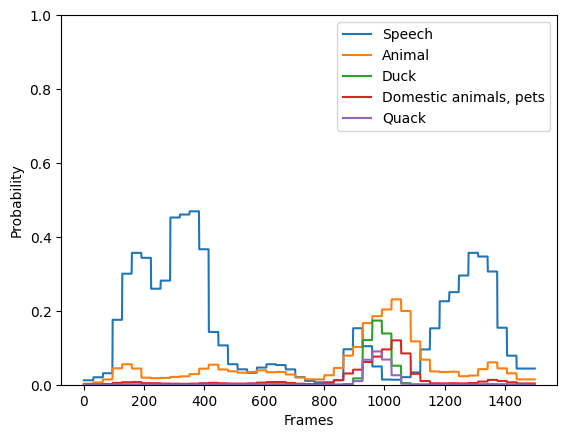

In [46]:
from panns_inference import AudioTagging, SoundEventDetection, labels
# INITIALIZE THE AUDIO TAGGER
at = AudioTagging(checkpoint_path='/home/aistwal/panns_data/Cnn14_mAP=0.431.pth', device="cuda") 
audio = correct_audio_list[7]
# audio = 'audio/airport-lyon-1169-45185-a.wav'
# audio_root_path = '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/'
# audio = audio_root_path+audio
# audio = '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45728-a.wav'

print(audio)
audioname = audio.split('/')[-1]
# Load the audio file
y, sr = sound.read(audio,stop=SampleDuration*sr)

#check panns inference
y = np.expand_dims(y[:,0], axis=0) # (batch_size, segment_samples)
print(y.shape)
(clipwise_output, embedding) = at.inference(y)
print_audio_tagging_result(clipwise_output[0])

print("New audio",y_alt.shape)
# #check panns inference
y_new = np.expand_dims(y_alt[:,0], axis = 0)
(clipwise_output, embedding) = at.inference(y_new)
print_audio_tagging_result(clipwise_output[0])

print('------ Sound event detection ------')
sed = SoundEventDetection(checkpoint_path=None, device='cuda')
framewise_output = sed.inference(y)
plot_sound_event_detection_result(framewise_output[0])


### COLLECT EVENT LIST FOR ALL THE CORRECTLY PREDICTED AUDIOS


In [47]:
correct_pred = eval_df[eval_df['Predicted Label'] == eval_df['Actual Label']]
print(correct_pred.shape)
correct_pred.head()

(3262, 3)


Filename       Actual Label  \
0   audio/street_pedestrian-lyon-1162-44093-a.wav  street_pedestrian   
1             audio/metro-prague-1163-44094-a.wav              metro   
2               audio/park-milan-1164-44095-a.wav               park   
3  audio/street_pedestrian-milan-1165-44096-a.wav  street_pedestrian   
4     audio/street_traffic-milan-1166-44097-a.wav     street_traffic   

     Predicted Label  
0  street_pedestrian  
1              metro  
2               park  
3  street_pedestrian  
4     street_traffic

In [48]:
# INITIALIZE THE AUDIO TAGGER
at = AudioTagging(checkpoint_path='/home/aistwal/panns_data/Cnn14_mAP=0.431.pth', device="cuda")

Checkpoint path: /home/aistwal/panns_data/Cnn14_mAP=0.431.pth
GPU number: 1


In [49]:
def print_audio_tagging_result(clipwise_output):
    sorted_indexes = np.argsort(clipwise_output)[::-1]
    events = []
    for k in range(10):
        # print('{}: {:.3f}'.format(np.array(labels)[sorted_indexes[k]], 
        #     clipwise_output[sorted_indexes[k]]))
        events.append(np.array(labels)[sorted_indexes[k]])
    return events

In [50]:
# GET EVENTS FOR ALL CORRECTLY PREDICTED 2230 AUDIOS, AND STORE THE PREDICTED SCENE AFTER CAM MASK

from tqdm import tqdm

final_events_before = []
final_events_after = []
final_preds_cam_label = []

for audio in tqdm(correct_pred['Filename']):
    
    audio_path = ThisPath + audio
    print(audio_path)
    audioname = audio.split('/')[-1]
    y, sr = sound.read(audio_path, stop=SampleDuration*sr)

    # Extract the log-mel features.
    original_log_mel_spectrogram = get_log_mel_features([audio_path])
    
    ## Extracting first channel as log-mel-spectrogram since we have processed stereo audios consisting of 2 channels.
    log_mel_spectrogram = original_log_mel_spectrogram[0,:,:,0]
    # log_mel_spectrogram = original_log_mel_spectrogram[0,:,:,1]
    
    # heatmap = make_gradcam_heatmap(original_log_mel_spectrogram, best_model)
    heatmap = make_gradcam_plus_plus_heatmap(original_log_mel_spectrogram, best_model)

    print("Shape of heatmap ", heatmap.shape)
    
    # Resize heatmap to match spectrogram dimensions
    heatmap_resized = tf.image.resize(heatmap[..., tf.newaxis], [log_mel_spectrogram.shape[0], log_mel_spectrogram.shape[1]]).numpy().squeeze()

    #Blackout unimportant features
    modified_spectrogram = blackout_unimportant_features(heatmap_resized, log_mel_spectrogram)

    #Blackout only x, leave y
    generalized_cam_version, deactivated_col_list = blackout_only_x_dim(heatmap_resized, log_mel_spectrogram)
    
    
    #Get altered audio
    y_alt = np.copy(y)

    # Get start index and stop index
    for col_index in deactivated_col_list:
        start_sample, end_sample = spectrogram_indices_to_sample_range(col_index)
        y_alt[start_sample:end_sample+1] = y.min()

    
    # Prediction of the audio
    predicted_class = np.argmax(best_model.predict(original_log_mel_spectrogram), axis=1)
    pred_label = idx_to_lb[predicted_class[0]]
    print("Prediction for ",audioname ,"is ", pred_label)
    
    # Duplicate the modified spectrogram along the channel dimension to create 2 channels
    generalized_spectrogram = np.stack((generalized_cam_version, generalized_cam_version), axis=-1)
    # Add the batch dimension
    generalized_spectrogram = np.expand_dims(generalized_spectrogram, axis=0)
    # print("Original shape:", original_log_mel_spectrogram.shape, "generalized shape:", generalized_cam_version.shape)
    
    prediction_class = np.argmax(best_model.predict(generalized_spectrogram), axis=1)
    preds_after_cam_label = idx_to_lb[predicted_class[0]]
    print("Prediction after cam mask for ", audioname, "is ", preds_after_cam_label)    
    final_preds_cam_label.append(preds_after_cam_label)

    # Get panns inference for unaltered audio
    y = np.expand_dims(y[:,0], axis=0)  # (batch_size, segment_samples)
    (clipwise_output, embedding) = at.inference(y)
    events_before = print_audio_tagging_result(clipwise_output[0])
    final_events_before.append(events_before)
    
    # Get panns inference for altered audio
    y_new = np.expand_dims(y_alt[:,0], axis = 0)
    (clipwise_output, embedding) = at.inference(y_new)
    events_after = print_audio_tagging_result(clipwise_output[0])
    final_events_after.append(events_after)    
    
    print("----"*25)
    

  0%|                                                                                                                    | 0/3262 [00:00<?, ?it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44093-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_pedestrian-lyon-1162-44093-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction after cam mask for  street_pedestrian-lyon-1162-44093-a.wav is  street_pedestrian


  0%|                                                                                                            | 1/3262 [00:01<54:41,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1163-44094-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro-prague-1163-44094-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|                                                                                                            | 2/3262 [00:02<55:46,  1.03s/it]

Prediction after cam mask for  metro-prague-1163-44094-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44095-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  park-milan-1164-44095-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  park-milan-1164-44095-a.wav is  park


  0%|                                                                                                            | 3/3262 [00:03<54:00,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-44096-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.36
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_pedestrian-milan-1165-44096-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_pedestrian-milan-1165-44096-a.wav is  street_pedestrian


  0%|▏                                                                                                           | 4/3262 [00:04<54:13,  1.00it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44097-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_traffic-milan-1166-44097-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  street_traffic-milan-1166-44097-a.wav is  street_traffic


  0%|▏                                                                                                           | 5/3262 [00:05<54:11,  1.00it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1167-44098-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.26
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  metro_station-lyon-1167-44098-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  metro_station-lyon-1167-44098-a.wav is  metro_station


  0%|▏                                                                                                           | 6/3262 [00:05<52:56,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-44099-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  public_square-milan-1168-44099-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|▏                                                                                                           | 7/3262 [00:06<53:30,  1.01it/s]

Prediction after cam mask for  public_square-milan-1168-44099-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44100-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  airport-lyon-1169-44100-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  airport-lyon-1169-44100-a.wav is  airport


  0%|▎                                                                                                           | 8/3262 [00:08<55:33,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-prague-1170-44101-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction for  metro_station-prague-1170-44101-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  metro_station-prague-1170-44101-a.wav is  metro_station


  0%|▎                                                                                                           | 9/3262 [00:09<54:32,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44102-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction for  street_traffic-lisbon-1171-44102-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|▎                                                                                                          | 10/3262 [00:10<55:08,  1.02s/it]

Prediction after cam mask for  street_traffic-lisbon-1171-44102-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-44104-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  airport-prague-1173-44104-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  airport-prague-1173-44104-a.wav is  airport


  0%|▎                                                                                                          | 11/3262 [00:11<54:22,  1.00s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44105-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  street_pedestrian-lisbon-1174-44105-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|▍                                                                                                          | 12/3262 [00:12<59:43,  1.10s/it]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44105-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1167-44107-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  metro_station-lyon-1167-44107-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|▍                                                                                                          | 13/3262 [00:13<58:05,  1.07s/it]

Prediction after cam mask for  metro_station-lyon-1167-44107-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1177-44109-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  bus-lyon-1177-44109-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction after cam mask for  bus-lyon-1177-44109-a.wav is  bus


  0%|▍                                                                                                          | 14/3262 [00:14<57:04,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44112-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_pedestrian-lyon-1162-44112-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction after cam mask for  street_pedestrian-lyon-1162-44112-a.wav is  street_pedestrian


  0%|▍                                                                                                          | 15/3262 [00:15<58:10,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1167-44113-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Prediction for  metro_station-lyon-1167-44113-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|▌                                                                                                          | 16/3262 [00:16<57:46,  1.07s/it]

Prediction after cam mask for  metro_station-lyon-1167-44113-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-44115-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  bus-milan-1180-44115-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction after cam mask for  bus-milan-1180-44115-a.wav is  bus


  1%|▌                                                                                                          | 17/3262 [00:17<55:53,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1181-44116-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  metro-lyon-1181-44116-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  1%|▌                                                                                                          | 18/3262 [00:18<54:41,  1.01s/it]

Prediction after cam mask for  metro-lyon-1181-44116-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-44118-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-milan-1183-44118-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  shopping_mall-milan-1183-44118-a.wav is  shopping_mall


  1%|▌                                                                                                          | 19/3262 [00:19<59:56,  1.11s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1184-44119-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-prague-1184-44119-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  tram-prague-1184-44119-a.wav is  tram


  1%|▋                                                                                                          | 20/3262 [00:20<57:53,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44120-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  park-prague-1185-44120-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  1%|▋                                                                                                          | 21/3262 [00:21<57:37,  1.07s/it]

Prediction after cam mask for  park-prague-1185-44120-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44121-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction for  park-milan-1164-44121-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  park-milan-1164-44121-a.wav is  park


  1%|▋                                                                                                        | 22/3262 [00:23<1:01:04,  1.13s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-44122-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  bus-lyon-1186-44122-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  bus-lyon-1186-44122-a.wav is  bus


  1%|▋                                                                                                        | 23/3262 [00:24<1:00:04,  1.11s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-milan-1187-44123-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro_station-milan-1187-44123-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  1%|▊                                                                                                          | 24/3262 [00:25<58:14,  1.08s/it]

Prediction after cam mask for  metro_station-milan-1187-44123-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44124-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  park-lyon-1188-44124-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  1%|▊                                                                                                          | 25/3262 [00:26<57:30,  1.07s/it]

Prediction after cam mask for  park-lyon-1188-44124-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44127-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  airport-lyon-1169-44127-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  airport-lyon-1169-44127-a.wav is  airport


  1%|▊                                                                                                          | 26/3262 [00:27<57:48,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1177-44129-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-lyon-1177-44129-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  bus-lyon-1177-44129-a.wav is  bus


  1%|▉                                                                                                          | 27/3262 [00:28<58:09,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44131-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  park-milan-1164-44131-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  1%|▉                                                                                                          | 28/3262 [00:29<58:41,  1.09s/it]

Prediction after cam mask for  park-milan-1164-44131-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-44132-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  bus-milan-1190-44132-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  bus-milan-1190-44132-a.wav is  bus


  1%|▉                                                                                                          | 29/3262 [00:30<59:33,  1.11s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-44133-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  tram-lisbon-1191-44133-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  1%|▉                                                                                                          | 30/3262 [00:31<58:13,  1.08s/it]

Prediction after cam mask for  tram-lisbon-1191-44133-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-44135-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  street_traffic-prague-1193-44135-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|█                                                                                                          | 31/3262 [00:32<56:18,  1.05s/it]

Prediction after cam mask for  street_traffic-prague-1193-44135-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1194-44136-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  bus-prague-1194-44136-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  1%|█                                                                                                          | 32/3262 [00:33<54:34,  1.01s/it]

Prediction after cam mask for  bus-prague-1194-44136-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44137-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-prague-1185-44137-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  park-prague-1185-44137-a.wav is  park


  1%|█                                                                                                          | 33/3262 [00:34<54:37,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44138-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  park-lyon-1188-44138-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  park-lyon-1188-44138-a.wav is  park
----------------------------------------------------------------------------------------------------


  1%|█                                                                                                          | 34/3262 [00:35<53:29,  1.01it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1192-44139-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for  public_square-prague-1192-44139-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  1%|█▏                                                                                                         | 35/3262 [00:36<52:20,  1.03it/s]

Prediction after cam mask for  public_square-prague-1192-44139-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-44140-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  bus-lyon-1186-44140-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  1%|█▏                                                                                                         | 36/3262 [00:37<52:20,  1.03it/s]

Prediction after cam mask for  bus-lyon-1186-44140-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-44142-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  airport-prague-1195-44142-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  airport-prague-1195-44142-a.wav is  airport


  1%|█▏                                                                                                         | 37/3262 [00:38<53:56,  1.00s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-44143-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-lyon-1196-44143-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  1%|█▏                                                                                                         | 38/3262 [00:39<52:31,  1.02it/s]

Prediction after cam mask for  shopping_mall-lyon-1196-44143-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1181-44146-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro-lyon-1181-44146-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  metro-lyon-1181-44146-a.wav is  metro


  1%|█▎                                                                                                         | 39/3262 [00:40<51:01,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44147-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-lisbon-1198-44147-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  park-lisbon-1198-44147-a.wav is  park


  1%|█▎                                                                                                         | 40/3262 [00:41<50:00,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1163-44148-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro-prague-1163-44148-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  metro-prague-1163-44148-a.wav is  metro


  1%|█▎                                                                                                         | 41/3262 [00:42<51:58,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-44149-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  airport-prague-1195-44149-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  airport-prague-1195-44149-a.wav is  airport


  1%|█▍                                                                                                         | 42/3262 [00:43<51:46,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1199-44150-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  metro-lisbon-1199-44150-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  metro-lisbon-1199-44150-a.wav is  metro


  1%|█▍                                                                                                         | 43/3262 [00:44<51:51,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-44156-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction for  street_pedestrian-milan-1165-44156-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  1%|█▍                                                                                                         | 44/3262 [00:45<51:59,  1.03it/s]

Prediction after cam mask for  street_pedestrian-milan-1165-44156-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1179-44157-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  metro_station-lyon-1179-44157-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  metro_station-lyon-1179-44157-a.wav is  metro_station


  1%|█▍                                                                                                         | 45/3262 [00:46<53:59,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1201-44158-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro-lyon-1201-44158-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  1%|█▌                                                                                                         | 46/3262 [00:47<55:04,  1.03s/it]

Prediction after cam mask for  metro-lyon-1201-44158-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1177-44159-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-lyon-1177-44159-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  bus-lyon-1177-44159-a.wav is  bus


  1%|█▌                                                                                                         | 47/3262 [00:48<54:09,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44161-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  park-lyon-1188-44161-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  1%|█▌                                                                                                         | 48/3262 [00:49<58:51,  1.10s/it]

Prediction after cam mask for  park-lyon-1188-44161-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44162-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  park-milan-1164-44162-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  park-milan-1164-44162-a.wav is  park


  2%|█▌                                                                                                         | 49/3262 [00:50<57:47,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-44163-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Prediction for  street_traffic-prague-1193-44163-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  2%|█▋                                                                                                         | 50/3262 [00:51<57:53,  1.08s/it]

Prediction after cam mask for  street_traffic-prague-1193-44163-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-44164-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_pedestrian-prague-1203-44164-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction after cam mask for  street_pedestrian-prague-1203-44164-a.wav is  street_pedestrian


  2%|█▋                                                                                                         | 51/3262 [00:52<58:58,  1.10s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1204-44165-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  metro-prague-1204-44165-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  2%|█▋                                                                                                         | 52/3262 [00:53<58:44,  1.10s/it]

Prediction after cam mask for  metro-prague-1204-44165-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1181-44168-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  metro-lyon-1181-44168-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro-lyon-1181-44168-a.wav is  metro


  2%|█▋                                                                                                         | 53/3262 [00:55<57:32,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44170-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  park-lisbon-1198-44170-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  2%|█▊                                                                                                         | 54/3262 [00:55<55:42,  1.04s/it]

Prediction after cam mask for  park-lisbon-1198-44170-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-44171-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  street_pedestrian-milan-1205-44171-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  street_pedestrian-milan-1205-44171-a.wav is  street_pedestrian


  2%|█▊                                                                                                         | 55/3262 [00:56<54:09,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1206-44172-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro-lyon-1206-44172-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro-lyon-1206-44172-a.wav is  metro


  2%|█▊                                                                                                         | 56/3262 [00:58<55:58,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44174-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  street_pedestrian-lisbon-1174-44174-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  2%|█▊                                                                                                         | 57/3262 [00:59<54:52,  1.03s/it]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44174-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1207-44175-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-prague-1207-44175-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  bus-prague-1207-44175-a.wav is  bus


  2%|█▉                                                                                                         | 58/3262 [01:00<55:20,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44176-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Prediction for  street_traffic-lisbon-1171-44176-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  2%|█▉                                                                                                         | 59/3262 [01:01<55:02,  1.03s/it]

Prediction after cam mask for  street_traffic-lisbon-1171-44176-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-milan-1187-44177-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Prediction for  metro_station-milan-1187-44177-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro_station-milan-1187-44177-a.wav is  metro_station


  2%|█▉                                                                                                         | 60/3262 [01:02<55:48,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1177-44178-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Prediction for  bus-lyon-1177-44178-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  2%|██                                                                                                         | 61/3262 [01:03<56:20,  1.06s/it]

Prediction after cam mask for  bus-lyon-1177-44178-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44179-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lisbon-1174-44179-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_pedestrian-lisbon-1174-44179-a.wav is  street_pedestrian


  2%|██                                                                                                         | 62/3262 [01:04<55:11,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1179-44181-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  metro_station-lyon-1179-44181-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  2%|██                                                                                                         | 63/3262 [01:05<54:27,  1.02s/it]

Prediction after cam mask for  metro_station-lyon-1179-44181-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-44182-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-milan-1180-44182-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  bus-milan-1180-44182-a.wav is  bus


  2%|██                                                                                                         | 64/3262 [01:06<53:12,  1.00it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1210-44184-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  tram-prague-1210-44184-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|██▏                                                                                                        | 65/3262 [01:07<53:58,  1.01s/it]

Prediction after cam mask for  tram-prague-1210-44184-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44185-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_pedestrian-lyon-1162-44185-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  street_pedestrian-lyon-1162-44185-a.wav is  street_pedestrian


  2%|██▏                                                                                                        | 66/3262 [01:08<54:52,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lisbon-1175-44186-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  airport-lisbon-1175-44186-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  airport-lisbon-1175-44186-a.wav is  airport


  2%|██▏                                                                                                        | 67/3262 [01:09<54:19,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44187-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  park-prague-1185-44187-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction after cam mask for  park-prague-1185-44187-a.wav is  park


  2%|██▏                                                                                                        | 68/3262 [01:10<57:35,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44188-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Prediction for  park-milan-1164-44188-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  park-milan-1164-44188-a.wav is  park


  2%|██▏                                                                                                      | 69/3262 [01:11<1:01:24,  1.15s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-44189-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  bus-milan-1180-44189-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|██▎                                                                                                        | 70/3262 [01:12<59:28,  1.12s/it]

Prediction after cam mask for  bus-milan-1180-44189-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-44190-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  public_square-lisbon-1211-44190-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  public_square-lisbon-1211-44190-a.wav is  public_square


  2%|██▎                                                                                                        | 71/3262 [01:13<58:27,  1.10s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44192-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  street_traffic-lisbon-1171-44192-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_traffic-lisbon-1171-44192-a.wav is  street_traffic


  2%|██▎                                                                                                        | 72/3262 [01:14<57:06,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44194-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_pedestrian-lyon-1162-44194-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  2%|██▍                                                                                                        | 73/3262 [01:16<58:24,  1.10s/it]

Prediction after cam mask for  street_pedestrian-lyon-1162-44194-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1201-44196-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro-lyon-1201-44196-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  2%|██▍                                                                                                        | 74/3262 [01:17<56:45,  1.07s/it]

Prediction after cam mask for  metro-lyon-1201-44196-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-44197-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  public_square-lyon-1178-44197-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  public_square-lyon-1178-44197-a.wav is  public_square


  2%|██▍                                                                                                        | 75/3262 [01:18<55:03,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1204-44199-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  metro-prague-1204-44199-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction after cam mask for  metro-prague-1204-44199-a.wav is  metro


  2%|██▍                                                                                                        | 76/3262 [01:18<52:56,  1.00it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-44201-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-milan-1202-44201-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  street_traffic-milan-1202-44201-a.wav is  street_traffic


  2%|██▌                                                                                                        | 77/3262 [01:19<51:48,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1163-44202-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro-prague-1163-44202-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro-prague-1163-44202-a.wav is  metro


  2%|██▌                                                                                                        | 78/3262 [01:20<53:16,  1.00s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-44205-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  airport-milan-1172-44205-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  2%|██▌                                                                                                        | 79/3262 [01:21<52:52,  1.00it/s]

Prediction after cam mask for  airport-milan-1172-44205-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1212-44206-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  bus-lisbon-1212-44206-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  2%|██▌                                                                                                        | 80/3262 [01:22<52:12,  1.02it/s]

Prediction after cam mask for  bus-lisbon-1212-44206-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44207-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-milan-1166-44207-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_traffic-milan-1166-44207-a.wav is  street_traffic


  2%|██▋                                                                                                        | 81/3262 [01:23<53:51,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-44208-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_pedestrian-prague-1203-44208-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_pedestrian-prague-1203-44208-a.wav is  street_pedestrian


  3%|██▋                                                                                                        | 82/3262 [01:24<52:49,  1.00it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-44209-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  bus-milan-1190-44209-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|██▋                                                                                                        | 83/3262 [01:25<52:31,  1.01it/s]

Prediction after cam mask for  bus-milan-1190-44209-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lisbon-1175-44210-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  airport-lisbon-1175-44210-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  3%|██▊                                                                                                        | 84/3262 [01:26<50:33,  1.05it/s]

Prediction after cam mask for  airport-lisbon-1175-44210-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1213-44212-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro-prague-1213-44212-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro-prague-1213-44212-a.wav is  metro


  3%|██▊                                                                                                        | 85/3262 [01:27<53:16,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1214-44214-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  public_square-prague-1214-44214-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  3%|██▊                                                                                                        | 86/3262 [01:28<53:08,  1.00s/it]

Prediction after cam mask for  public_square-prague-1214-44214-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-44215-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-milan-1172-44215-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  airport-milan-1172-44215-a.wav is  airport


  3%|██▊                                                                                                        | 87/3262 [01:29<52:20,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-44216-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Prediction for  public_square-milan-1168-44216-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction after cam mask for  public_square-milan-1168-44216-a.wav is  public_square


  3%|██▉                                                                                                        | 88/3262 [01:30<52:07,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1213-44217-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro-prague-1213-44217-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  metro-prague-1213-44217-a.wav is  metro


  3%|██▉                                                                                                        | 89/3262 [01:31<52:40,  1.00it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-44218-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  airport-prague-1195-44218-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  3%|██▉                                                                                                        | 90/3262 [01:32<52:19,  1.01it/s]

Prediction after cam mask for  airport-prague-1195-44218-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1215-44220-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  bus-prague-1215-44220-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  3%|██▉                                                                                                        | 91/3262 [01:33<51:03,  1.03it/s]

Prediction after cam mask for  bus-prague-1215-44220-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44221-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  park-prague-1185-44221-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  3%|███                                                                                                        | 92/3262 [01:34<51:53,  1.02it/s]

Prediction after cam mask for  park-prague-1185-44221-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-44223-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-milan-1183-44223-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-milan-1183-44223-a.wav is  shopping_mall


  3%|███                                                                                                        | 93/3262 [01:35<54:43,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-milan-1187-44224-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  metro_station-milan-1187-44224-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  3%|███                                                                                                        | 94/3262 [01:36<54:02,  1.02s/it]

Prediction after cam mask for  metro_station-milan-1187-44224-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44225-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_traffic-milan-1166-44225-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_traffic-milan-1166-44225-a.wav is  street_traffic


  3%|███                                                                                                        | 95/3262 [01:37<53:15,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-44226-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  shopping_mall-milan-1183-44226-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  3%|███▏                                                                                                       | 96/3262 [01:38<52:43,  1.00it/s]

Prediction after cam mask for  shopping_mall-milan-1183-44226-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44227-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-lyon-1169-44227-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  airport-lyon-1169-44227-a.wav is  airport


  3%|███▏                                                                                                       | 97/3262 [01:40<55:35,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44228-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  park-lisbon-1198-44228-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  park-lisbon-1198-44228-a.wav is  park
----------------------------------------------------------------------------------------------------


  3%|███▏                                                                                                       | 98/3262 [01:40<53:31,  1.02s/it]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1167-44229-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Prediction for  metro_station-lyon-1167-44229-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|███▏                                                                                                       | 99/3262 [01:41<52:41,  1.00it/s]

Prediction after cam mask for  metro_station-lyon-1167-44229-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-44232-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  public_square-lyon-1178-44232-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  3%|███▏                                                                                                      | 100/3262 [01:43<55:21,  1.05s/it]

Prediction after cam mask for  public_square-lyon-1178-44232-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-44235-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  street_traffic-prague-1193-44235-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction after cam mask for  street_traffic-prague-1193-44235-a.wav is  street_traffic


  3%|███▎                                                                                                      | 101/3262 [01:44<56:33,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1210-44236-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  tram-prague-1210-44236-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  3%|███▎                                                                                                      | 102/3262 [01:45<54:14,  1.03s/it]

Prediction after cam mask for  tram-prague-1210-44236-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-44237-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  tram-lisbon-1191-44237-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  3%|███▎                                                                                                      | 103/3262 [01:46<52:15,  1.01it/s]

Prediction after cam mask for  tram-lisbon-1191-44237-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44238-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  park-milan-1164-44238-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  park-milan-1164-44238-a.wav is  park


  3%|███▍                                                                                                      | 104/3262 [01:47<53:29,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1204-44240-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-prague-1204-44240-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction after cam mask for  metro-prague-1204-44240-a.wav is  metro


  3%|███▍                                                                                                      | 105/3262 [01:48<59:03,  1.12s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-44241-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  tram-lisbon-1191-44241-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  3%|███▍                                                                                                      | 106/3262 [01:49<56:35,  1.08s/it]

Prediction after cam mask for  tram-lisbon-1191-44241-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44243-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_pedestrian-lisbon-1174-44243-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_pedestrian-lisbon-1174-44243-a.wav is  street_pedestrian


  3%|███▍                                                                                                      | 107/3262 [01:50<57:04,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-44244-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  street_pedestrian-milan-1205-44244-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|███▌                                                                                                      | 108/3262 [01:51<56:10,  1.07s/it]

Prediction after cam mask for  street_pedestrian-milan-1205-44244-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44245-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  park-lisbon-1198-44245-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  3%|███▌                                                                                                      | 109/3262 [01:52<55:22,  1.05s/it]

Prediction after cam mask for  park-lisbon-1198-44245-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44246-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-lisbon-1171-44246-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  3%|███▌                                                                                                      | 110/3262 [01:53<58:59,  1.12s/it]

Prediction after cam mask for  street_traffic-lisbon-1171-44246-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-44247-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  public_square-lisbon-1211-44247-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction after cam mask for  public_square-lisbon-1211-44247-a.wav is  public_square


  3%|███▌                                                                                                      | 111/3262 [01:54<56:24,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44250-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  park-prague-1185-44250-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  park-prague-1185-44250-a.wav is  park


  3%|███▋                                                                                                      | 112/3262 [01:55<54:50,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44251-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  park-milan-1164-44251-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction after cam mask for  park-milan-1164-44251-a.wav is  park


  3%|███▋                                                                                                      | 113/3262 [01:56<54:03,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-44252-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  tram-lisbon-1191-44252-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction after cam mask for  tram-lisbon-1191-44252-a.wav is  tram


  3%|███▋                                                                                                      | 114/3262 [01:57<55:17,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-44254-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  tram-lyon-1216-44254-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|███▋                                                                                                      | 115/3262 [01:58<54:09,  1.03s/it]

Prediction after cam mask for  tram-lyon-1216-44254-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-44255-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  street_pedestrian-milan-1165-44255-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  4%|███▊                                                                                                      | 116/3262 [01:59<53:44,  1.03s/it]

Prediction after cam mask for  street_pedestrian-milan-1165-44255-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1179-44257-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  metro_station-lyon-1179-44257-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  4%|███▊                                                                                                      | 117/3262 [02:00<53:23,  1.02s/it]

Prediction after cam mask for  metro_station-lyon-1179-44257-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44258-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-lisbon-1171-44258-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  street_traffic-lisbon-1171-44258-a.wav is  street_traffic


  4%|███▊                                                                                                      | 118/3262 [02:02<54:13,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lisbon-1176-44259-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-lisbon-1176-44259-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  shopping_mall-lisbon-1176-44259-a.wav is  shopping_mall


  4%|███▊                                                                                                      | 119/3262 [02:02<51:46,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-44261-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-prague-1193-44261-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  4%|███▉                                                                                                      | 120/3262 [02:03<50:40,  1.03it/s]

Prediction after cam mask for  street_traffic-prague-1193-44261-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-prague-1170-44262-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.26
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  metro_station-prague-1170-44262-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro_station-prague-1170-44262-a.wav is  metro_station


  4%|███▉                                                                                                      | 121/3262 [02:04<53:01,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1177-44264-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  bus-lyon-1177-44264-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  4%|███▉                                                                                                      | 122/3262 [02:05<53:19,  1.02s/it]

Prediction after cam mask for  bus-lyon-1177-44264-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1206-44265-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro-lyon-1206-44265-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  4%|███▉                                                                                                      | 123/3262 [02:06<52:58,  1.01s/it]

Prediction after cam mask for  metro-lyon-1206-44265-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1217-44266-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-lisbon-1217-44266-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro-lisbon-1217-44266-a.wav is  metro


  4%|████                                                                                                      | 124/3262 [02:07<52:01,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1177-44268-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  bus-lyon-1177-44268-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  4%|████                                                                                                      | 125/3262 [02:09<54:42,  1.05s/it]

Prediction after cam mask for  bus-lyon-1177-44268-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1181-44269-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro-lyon-1181-44269-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  4%|████                                                                                                      | 126/3262 [02:10<53:31,  1.02s/it]

Prediction after cam mask for  metro-lyon-1181-44269-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44270-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  park-milan-1164-44270-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  park-milan-1164-44270-a.wav is  park


  4%|████▏                                                                                                     | 127/3262 [02:11<52:32,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1212-44271-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  bus-lisbon-1212-44271-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  bus-lisbon-1212-44271-a.wav is  bus


  4%|████▏                                                                                                     | 128/3262 [02:12<55:13,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-44273-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction for  bus-milan-1190-44273-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


  4%|████▏                                                                                                     | 129/3262 [02:13<54:29,  1.04s/it]

Prediction after cam mask for  bus-milan-1190-44273-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-milan-1187-44274-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  metro_station-milan-1187-44274-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  4%|████▏                                                                                                     | 130/3262 [02:14<53:23,  1.02s/it]

Prediction after cam mask for  metro_station-milan-1187-44274-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44275-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-milan-1166-44275-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  street_traffic-milan-1166-44275-a.wav is  street_traffic


  4%|████▎                                                                                                     | 131/3262 [02:15<52:58,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-milan-1218-44276-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro-milan-1218-44276-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  metro-milan-1218-44276-a.wav is  metro


  4%|████▎                                                                                                     | 132/3262 [02:16<53:42,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44277-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  park-lyon-1188-44277-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  park-lyon-1188-44277-a.wav is  park


  4%|████▎                                                                                                     | 133/3262 [02:17<52:07,  1.00it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44278-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  street_traffic-lisbon-1171-44278-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  4%|████▎                                                                                                     | 134/3262 [02:18<51:12,  1.02it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-44278-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44279-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  airport-lyon-1169-44279-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  airport-lyon-1169-44279-a.wav is  airport


  4%|████▍                                                                                                     | 135/3262 [02:19<50:52,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-44280-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  tram-lisbon-1200-44280-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  tram-lisbon-1200-44280-a.wav is  tram


  4%|████▍                                                                                                     | 136/3262 [02:20<53:08,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1208-44281-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  public_square-lyon-1208-44281-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  public_square-lyon-1208-44281-a.wav is  public_square


  4%|████▍                                                                                                     | 137/3262 [02:21<51:57,  1.00it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1199-44282-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction for  metro-lisbon-1199-44282-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  4%|████▍                                                                                                     | 138/3262 [02:22<52:02,  1.00it/s]

Prediction after cam mask for  metro-lisbon-1199-44282-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44283-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  airport-lyon-1169-44283-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  4%|████▌                                                                                                     | 139/3262 [02:23<51:48,  1.00it/s]

Prediction after cam mask for  airport-lyon-1169-44283-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-44285-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  shopping_mall-prague-1219-44285-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  shopping_mall-prague-1219-44285-a.wav is  shopping_mall


  4%|████▌                                                                                                     | 140/3262 [02:24<57:53,  1.11s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-44286-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  bus-milan-1190-44286-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  4%|████▌                                                                                                     | 141/3262 [02:25<56:31,  1.09s/it]

Prediction after cam mask for  bus-milan-1190-44286-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44287-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  park-prague-1185-44287-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  4%|████▌                                                                                                     | 142/3262 [02:26<55:19,  1.06s/it]

Prediction after cam mask for  park-prague-1185-44287-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1194-44288-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  bus-prague-1194-44288-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  bus-prague-1194-44288-a.wav is  bus


  4%|████▋                                                                                                     | 143/3262 [02:27<56:26,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1199-44289-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  metro-lisbon-1199-44289-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  4%|████▋                                                                                                     | 144/3262 [02:28<55:52,  1.08s/it]

Prediction after cam mask for  metro-lisbon-1199-44289-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44290-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.84
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  park-lisbon-1198-44290-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  4%|████▋                                                                                                     | 145/3262 [02:29<53:57,  1.04s/it]

Prediction after cam mask for  park-lisbon-1198-44290-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1217-44291-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction for  metro-lisbon-1217-44291-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro-lisbon-1217-44291-a.wav is  metro


  4%|████▋                                                                                                     | 146/3262 [02:30<53:06,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1179-44293-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro_station-lyon-1179-44293-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  metro_station-lyon-1179-44293-a.wav is  metro_station


  5%|████▊                                                                                                     | 147/3262 [02:31<54:01,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44294-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_traffic-lyon-1220-44294-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  street_traffic-lyon-1220-44294-a.wav is  street_traffic


  5%|████▊                                                                                                     | 148/3262 [02:32<52:16,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44295-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  park-prague-1185-44295-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  5%|████▊                                                                                                     | 149/3262 [02:33<52:55,  1.02s/it]

Prediction after cam mask for  park-prague-1185-44295-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-44297-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-milan-1190-44297-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  bus-milan-1190-44297-a.wav is  bus


  5%|████▊                                                                                                     | 150/3262 [02:34<53:46,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-44298-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  shopping_mall-prague-1219-44298-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  shopping_mall-prague-1219-44298-a.wav is  shopping_mall


  5%|████▉                                                                                                     | 151/3262 [02:35<52:22,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-milan-1197-44299-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro-milan-1197-44299-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro-milan-1197-44299-a.wav is  metro


  5%|████▉                                                                                                     | 152/3262 [02:36<51:31,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44300-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-lyon-1188-44300-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  park-lyon-1188-44300-a.wav is  park


  5%|████▉                                                                                                     | 153/3262 [02:37<50:47,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1179-44301-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro_station-lyon-1179-44301-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro_station-lyon-1179-44301-a.wav is  metro_station


  5%|█████                                                                                                     | 154/3262 [02:38<53:08,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1208-44303-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  public_square-lyon-1208-44303-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  5%|█████                                                                                                     | 155/3262 [02:39<52:12,  1.01s/it]

Prediction after cam mask for  public_square-lyon-1208-44303-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44304-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  park-milan-1164-44304-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  5%|█████                                                                                                     | 156/3262 [02:40<51:20,  1.01it/s]

Prediction after cam mask for  park-milan-1164-44304-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44305-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-lyon-1220-44305-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  5%|█████                                                                                                     | 157/3262 [02:41<49:41,  1.04it/s]

Prediction after cam mask for  street_traffic-lyon-1220-44305-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1199-44306-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro-lisbon-1199-44306-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  5%|█████▏                                                                                                    | 158/3262 [02:42<54:56,  1.06s/it]

Prediction after cam mask for  metro-lisbon-1199-44306-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-44307-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  shopping_mall-lyon-1196-44307-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  shopping_mall-lyon-1196-44307-a.wav is  shopping_mall


  5%|█████▏                                                                                                    | 159/3262 [02:43<52:21,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44308-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  street_traffic-lisbon-1171-44308-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  5%|█████▏                                                                                                    | 160/3262 [02:44<52:18,  1.01s/it]

Prediction after cam mask for  street_traffic-lisbon-1171-44308-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-44309-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  airport-prague-1173-44309-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  5%|█████▏                                                                                                    | 161/3262 [02:45<54:10,  1.05s/it]

Prediction after cam mask for  airport-prague-1173-44309-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44310-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_pedestrian-lisbon-1174-44310-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  5%|█████▎                                                                                                    | 162/3262 [02:47<53:59,  1.05s/it]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44310-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-44311-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  public_square-lisbon-1211-44311-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|█████▎                                                                                                    | 163/3262 [02:48<53:41,  1.04s/it]

Prediction after cam mask for  public_square-lisbon-1211-44311-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44312-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-milan-1164-44312-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  5%|█████▎                                                                                                    | 164/3262 [02:48<51:59,  1.01s/it]

Prediction after cam mask for  park-milan-1164-44312-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44314-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  airport-lyon-1169-44314-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|█████▎                                                                                                    | 165/3262 [02:50<54:19,  1.05s/it]

Prediction after cam mask for  airport-lyon-1169-44314-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-44315-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  shopping_mall-lyon-1196-44315-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  shopping_mall-lyon-1196-44315-a.wav is  shopping_mall


  5%|█████▍                                                                                                    | 166/3262 [02:51<54:16,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-prague-1170-44316-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-prague-1170-44316-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  5%|█████▍                                                                                                    | 167/3262 [02:52<52:51,  1.02s/it]

Prediction after cam mask for  metro_station-prague-1170-44316-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44317-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-lyon-1188-44317-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  park-lyon-1188-44317-a.wav is  park


  5%|█████▍                                                                                                    | 168/3262 [02:53<56:57,  1.10s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-prague-1170-44318-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-prague-1170-44318-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro_station-prague-1170-44318-a.wav is  metro_station


  5%|█████▍                                                                                                    | 169/3262 [02:54<57:48,  1.12s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1210-44319-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  tram-prague-1210-44319-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|█████▌                                                                                                    | 170/3262 [02:55<56:24,  1.09s/it]

Prediction after cam mask for  tram-prague-1210-44319-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1213-44320-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro-prague-1213-44320-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  metro-prague-1213-44320-a.wav is  metro


  5%|█████▌                                                                                                    | 171/3262 [02:56<56:01,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44321-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Prediction for  airport-lyon-1169-44321-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  airport-lyon-1169-44321-a.wav is  airport


  5%|█████▌                                                                                                    | 172/3262 [02:57<55:28,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1207-44322-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  bus-prague-1207-44322-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  5%|█████▌                                                                                                    | 173/3262 [02:58<53:53,  1.05s/it]

Prediction after cam mask for  bus-prague-1207-44322-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44323-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  park-lyon-1188-44323-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  5%|█████▋                                                                                                    | 174/3262 [02:59<53:53,  1.05s/it]

Prediction after cam mask for  park-lyon-1188-44323-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1217-44324-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro-lisbon-1217-44324-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  metro-lisbon-1217-44324-a.wav is  metro


  5%|█████▋                                                                                                    | 175/3262 [03:00<51:51,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-milan-1218-44325-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro-milan-1218-44325-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  metro-milan-1218-44325-a.wav is  metro


  5%|█████▋                                                                                                    | 176/3262 [03:01<54:37,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44326-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction for  park-lisbon-1198-44326-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|█████▊                                                                                                    | 177/3262 [03:02<54:46,  1.07s/it]

Prediction after cam mask for  park-lisbon-1198-44326-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1214-44327-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  public_square-prague-1214-44327-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  5%|█████▊                                                                                                    | 178/3262 [03:03<53:39,  1.04s/it]

Prediction after cam mask for  public_square-prague-1214-44327-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-milan-1187-44328-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-milan-1187-44328-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  5%|█████▊                                                                                                    | 179/3262 [03:04<53:01,  1.03s/it]

Prediction after cam mask for  metro_station-milan-1187-44328-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44329-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-lyon-1188-44329-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  park-lyon-1188-44329-a.wav is  park


  6%|█████▊                                                                                                    | 180/3262 [03:06<54:30,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44330-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction for  airport-lyon-1169-44330-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|█████▉                                                                                                    | 181/3262 [03:07<53:59,  1.05s/it]

Prediction after cam mask for  airport-lyon-1169-44330-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1181-44331-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Prediction for  metro-lyon-1181-44331-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  6%|█████▉                                                                                                    | 182/3262 [03:08<54:59,  1.07s/it]

Prediction after cam mask for  metro-lyon-1181-44331-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44332-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_traffic-lyon-1220-44332-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_traffic-lyon-1220-44332-a.wav is  street_traffic


  6%|█████▉                                                                                                    | 183/3262 [03:09<54:37,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-milan-1222-44334-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  tram-milan-1222-44334-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  tram-milan-1222-44334-a.wav is  tram


  6%|█████▉                                                                                                    | 184/3262 [03:10<55:49,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1215-44335-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Prediction for  bus-prague-1215-44335-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|██████                                                                                                    | 185/3262 [03:11<54:05,  1.05s/it]

Prediction after cam mask for  bus-prague-1215-44335-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-44336-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  bus-lyon-1186-44336-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  6%|██████                                                                                                    | 186/3262 [03:12<53:53,  1.05s/it]

Prediction after cam mask for  bus-lyon-1186-44336-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-milan-1209-44337-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  tram-milan-1209-44337-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction after cam mask for  tram-milan-1209-44337-a.wav is  tram


  6%|██████                                                                                                    | 187/3262 [03:13<54:52,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lisbon-1176-44338-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  shopping_mall-lisbon-1176-44338-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  6%|██████                                                                                                    | 188/3262 [03:14<53:02,  1.04s/it]

Prediction after cam mask for  shopping_mall-lisbon-1176-44338-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1179-44339-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro_station-lyon-1179-44339-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for 

  6%|██████▏                                                                                                   | 189/3262 [03:15<54:17,  1.06s/it]

 metro_station-lyon-1179-44339-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1163-44340-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction for  metro-prague-1163-44340-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  6%|██████▏                                                                                                   | 190/3262 [03:16<55:51,  1.09s/it]

Prediction after cam mask for  metro-prague-1163-44340-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44341-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Prediction for  street_traffic-milan-1166-44341-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  6%|██████▏                                                                                                   | 191/3262 [03:17<54:55,  1.07s/it]

Prediction after cam mask for  street_traffic-milan-1166-44341-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1206-44343-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Prediction for  metro-lyon-1206-44343-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Prediction after cam mask for  metro-lyon-1206-44343-a.wav is  metro
----------------------------------------------------------------------------------------------------


  6%|██████▏                                                                                                   | 192/3262 [03:18<56:02,  1.10s/it]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1210-44345-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-prague-1210-44345-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  tram-prague-1210-44345-a.wav is  tram


  6%|██████▎                                                                                                   | 193/3262 [03:19<54:53,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-44346-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_pedestrian-milan-1205-44346-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  6%|██████▎                                                                                                   | 194/3262 [03:20<53:21,  1.04s/it]

Prediction after cam mask for  street_pedestrian-milan-1205-44346-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-44347-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-lisbon-1200-44347-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  6%|██████▎                                                                                                   | 195/3262 [03:22<53:29,  1.05s/it]

Prediction after cam mask for  tram-lisbon-1200-44347-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44348-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  airport-lyon-1169-44348-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  6%|██████▎                                                                                                   | 196/3262 [03:23<53:06,  1.04s/it]

Prediction after cam mask for  airport-lyon-1169-44348-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-44349-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  shopping_mall-prague-1219-44349-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  shopping_mall-prague-1219-44349-a.wav is  shopping_mall


  6%|██████▍                                                                                                   | 197/3262 [03:24<54:26,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44350-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  street_traffic-lyon-1220-44350-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_traffic-lyon-1220-44350-a.wav is  street_traffic


  6%|██████▍                                                                                                   | 198/3262 [03:25<58:49,  1.15s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44351-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  airport-lyon-1169-44351-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  airport-lyon-1169-44351-a.wav is  airport


  6%|██████▍                                                                                                   | 199/3262 [03:26<58:30,  1.15s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1210-44352-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  tram-prague-1210-44352-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  6%|██████▍                                                                                                   | 200/3262 [03:27<55:50,  1.09s/it]

Prediction after cam mask for  tram-prague-1210-44352-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-44354-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  airport-prague-1173-44354-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  6%|██████▌                                                                                                   | 201/3262 [03:28<56:00,  1.10s/it]

Prediction after cam mask for  airport-prague-1173-44354-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-44356-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  street_traffic-prague-1193-44356-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  street_traffic-prague-1193-44356-a.wav is  street_traffic


  6%|██████▌                                                                                                   | 202/3262 [03:29<54:06,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lisbon-1176-44358-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-lisbon-1176-44358-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  shopping_mall-lisbon-1176-44358-a.wav is  shopping_mall


  6%|██████▌                                                                                                   | 203/3262 [03:30<52:42,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44360-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_traffic-milan-1166-44360-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  6%|██████▋                                                                                                   | 204/3262 [03:31<55:31,  1.09s/it]

Prediction after cam mask for  street_traffic-milan-1166-44360-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44363-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  airport-lyon-1169-44363-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  6%|██████▋                                                                                                   | 205/3262 [03:32<53:13,  1.04s/it]

Prediction after cam mask for  airport-lyon-1169-44363-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1206-44364-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro-lyon-1206-44364-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro-lyon-1206-44364-a.wav is  metro


  6%|██████▋                                                                                                   | 206/3262 [03:33<52:16,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44365-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  street_pedestrian-lisbon-1174-44365-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  6%|██████▋                                                                                                   | 207/3262 [03:35<54:56,  1.08s/it]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44365-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1212-44366-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  bus-lisbon-1212-44366-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  6%|██████▊                                                                                                   | 208/3262 [03:36<54:48,  1.08s/it]

Prediction after cam mask for  bus-lisbon-1212-44366-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44367-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  street_pedestrian-lisbon-1174-44367-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  6%|██████▊                                                                                                   | 209/3262 [03:37<54:40,  1.07s/it]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44367-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-44368-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  public_square-lyon-1178-44368-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  public_square-lyon-1178-44368-a.wav is  public_square


  6%|██████▊                                                                                                   | 210/3262 [03:38<53:52,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1181-44369-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro-lyon-1181-44369-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  6%|██████▊                                                                                                   | 211/3262 [03:39<53:49,  1.06s/it]

Prediction after cam mask for  metro-lyon-1181-44369-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-44370-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  shopping_mall-lyon-1196-44370-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  6%|██████▉                                                                                                   | 212/3262 [03:40<52:27,  1.03s/it]

Prediction after cam mask for  shopping_mall-lyon-1196-44370-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-44371-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  shopping_mall-prague-1219-44371-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  7%|██████▉                                                                                                   | 213/3262 [03:41<55:27,  1.09s/it]

Prediction after cam mask for  shopping_mall-prague-1219-44371-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-44372-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  tram-lisbon-1191-44372-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  tram-lisbon-1191-44372-a.wav is  tram


  7%|██████▊                                                                                                 | 214/3262 [03:42<1:00:55,  1.20s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44373-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction for  park-prague-1185-44373-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  7%|██████▉                                                                                                   | 215/3262 [03:44<59:41,  1.18s/it]

Prediction after cam mask for  park-prague-1185-44373-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-44374-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_pedestrian-milan-1205-44374-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  7%|███████                                                                                                   | 216/3262 [03:45<57:38,  1.14s/it]

Prediction after cam mask for  street_pedestrian-milan-1205-44374-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1179-44375-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro_station-lyon-1179-44375-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro_station-lyon-1179-44375-a.wav is  metro_station


  7%|███████                                                                                                   | 217/3262 [03:46<55:30,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-44376-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  airport-milan-1172-44376-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  airport-milan-1172-44376-a.wav is  airport


  7%|███████                                                                                                   | 218/3262 [03:47<57:34,  1.13s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-44377-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_pedestrian-milan-1205-44377-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  7%|███████                                                                                                   | 219/3262 [03:48<56:53,  1.12s/it]

Prediction after cam mask for  street_pedestrian-milan-1205-44377-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44378-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_pedestrian-lyon-1162-44378-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_pedestrian-lyon-1162-44378-a.wav is  street_pedestrian


  7%|███████▏                                                                                                  | 220/3262 [03:49<54:16,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-44380-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  tram-lyon-1216-44380-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  tram-lyon-1216-44380-a.wav is  tram


  7%|███████▏                                                                                                  | 221/3262 [03:50<55:26,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44381-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  street_traffic-lyon-1220-44381-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  7%|███████▏                                                                                                  | 222/3262 [03:51<54:27,  1.07s/it]

Prediction after cam mask for  street_traffic-lyon-1220-44381-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1208-44382-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  public_square-lyon-1208-44382-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  public_square-lyon-1208-44382-a.wav is  public_square


  7%|███████▏                                                                                                  | 223/3262 [03:52<53:06,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1194-44383-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-prague-1194-44383-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  bus-prague-1194-44383-a.wav is  bus


  7%|███████▎                                                                                                  | 224/3262 [03:53<51:33,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-44384-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-milan-1202-44384-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_traffic-milan-1202-44384-a.wav is  street_traffic


  7%|███████▎                                                                                                  | 225/3262 [03:54<53:27,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44385-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  park-lyon-1188-44385-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|███████▎                                                                                                  | 226/3262 [03:55<53:00,  1.05s/it]

Prediction after cam mask for  park-lyon-1188-44385-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44387-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  airport-lyon-1169-44387-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  7%|███████▍                                                                                                  | 227/3262 [03:56<52:36,  1.04s/it]

Prediction after cam mask for  airport-lyon-1169-44387-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44388-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-lyon-1188-44388-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  park-lyon-1188-44388-a.wav is  park


  7%|███████▍                                                                                                  | 228/3262 [03:57<54:43,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-44390-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  street_traffic-prague-1193-44390-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_traffic-prague-1193-44390-a.wav is  street_traffic


  7%|███████▍                                                                                                  | 229/3262 [03:58<53:36,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-44391-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  street_traffic-milan-1202-44391-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  7%|███████▍                                                                                                  | 230/3262 [03:59<52:14,  1.03s/it]

Prediction after cam mask for  street_traffic-milan-1202-44391-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-44392-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_traffic-prague-1193-44392-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  7%|███████▌                                                                                                  | 231/3262 [04:00<54:40,  1.08s/it]

Prediction after cam mask for  street_traffic-prague-1193-44392-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1223-44393-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  bus-lisbon-1223-44393-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  7%|███████▌                                                                                                  | 232/3262 [04:01<53:00,  1.05s/it]

Prediction after cam mask for  bus-lisbon-1223-44393-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1199-44394-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  metro-lisbon-1199-44394-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  7%|███████▌                                                                                                  | 233/3262 [04:02<52:12,  1.03s/it]

Prediction after cam mask for  metro-lisbon-1199-44394-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1206-44395-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  metro-lyon-1206-44395-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  metro-lyon-1206-44395-a.wav is  metro


  7%|███████▌                                                                                                  | 234/3262 [04:03<51:11,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-44396-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-milan-1180-44396-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  7%|███████▋                                                                                                  | 235/3262 [04:05<52:35,  1.04s/it]

Prediction after cam mask for  bus-milan-1180-44396-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-44397-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  airport-prague-1173-44397-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  7%|███████▋                                                                                                  | 236/3262 [04:06<52:16,  1.04s/it]

Prediction after cam mask for  airport-prague-1173-44397-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-44398-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  tram-lisbon-1191-44398-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  7%|███████▋                                                                                                  | 237/3262 [04:07<50:55,  1.01s/it]

Prediction after cam mask for  tram-lisbon-1191-44398-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1215-44400-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  bus-prague-1215-44400-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  7%|███████▋                                                                                                  | 238/3262 [04:08<51:22,  1.02s/it]

Prediction after cam mask for  bus-prague-1215-44400-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-44405-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-milan-1183-44405-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  7%|███████▊                                                                                                  | 239/3262 [04:09<52:27,  1.04s/it]

Prediction after cam mask for  shopping_mall-milan-1183-44405-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1212-44406-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  bus-lisbon-1212-44406-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  bus-lisbon-1212-44406-a.wav is  bus


  7%|███████▊                                                                                                  | 240/3262 [04:10<51:15,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1223-44407-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-lisbon-1223-44407-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  7%|███████▊                                                                                                  | 241/3262 [04:11<51:46,  1.03s/it]

Prediction after cam mask for  bus-lisbon-1223-44407-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-44409-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  airport-milan-1172-44409-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  7%|███████▊                                                                                                  | 242/3262 [04:12<51:30,  1.02s/it]

Prediction after cam mask for  airport-milan-1172-44409-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-44410-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  street_traffic-prague-1193-44410-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|███████▉                                                                                                  | 243/3262 [04:13<51:51,  1.03s/it]

Prediction after cam mask for  street_traffic-prague-1193-44410-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-44411-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for  street_pedestrian-milan-1165-44411-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  street_pedestrian-milan-1165-44411-a.wav is  street_pedestrian


  7%|███████▉                                                                                                  | 244/3262 [04:14<51:17,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-44413-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  shopping_mall-milan-1183-44413-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  8%|███████▉                                                                                                  | 245/3262 [04:15<53:14,  1.06s/it]

Prediction after cam mask for  shopping_mall-milan-1183-44413-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44417-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  street_traffic-lisbon-1171-44417-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_traffic-lisbon-1171-44417-a.wav is  street_traffic


  8%|███████▉                                                                                                  | 246/3262 [04:16<52:13,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44418-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_traffic-lyon-1220-44418-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  street_traffic-lyon-1220-44418-a.wav is  street_traffic


  8%|████████                                                                                                  | 247/3262 [04:17<50:35,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-44419-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  bus-milan-1180-44419-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|████████                                                                                                  | 248/3262 [04:18<49:58,  1.01it/s]

Prediction after cam mask for  bus-milan-1180-44419-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44421-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_traffic-milan-1166-44421-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  street_traffic-milan-1166-44421-a.wav is  street_traffic


  8%|████████                                                                                                  | 249/3262 [04:19<51:20,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44423-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  park-lisbon-1198-44423-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  park-lisbon-1198-44423-a.wav is  park
----------------------------------------------------------------------------------------------------


  8%|████████                                                                                                  | 250/3262 [04:20<50:19,  1.00s/it]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1204-44424-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro-prague-1204-44424-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  metro-prague-1204-44424-a.wav is  metro


  8%|████████▏                                                                                                 | 251/3262 [04:21<50:23,  1.00s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-44425-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  airport-prague-1173-44425-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  8%|████████▏                                                                                                 | 252/3262 [04:22<51:03,  1.02s/it]

Prediction after cam mask for  airport-prague-1173-44425-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-44426-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  airport-prague-1195-44426-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|████████▏                                                                                                 | 253/3262 [04:23<51:51,  1.03s/it]

Prediction after cam mask for  airport-prague-1195-44426-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1215-44427-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  bus-prague-1215-44427-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  bus-prague-1215-44427-a.wav is  bus


  8%|████████▎                                                                                                 | 254/3262 [04:24<51:40,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1223-44429-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-lisbon-1223-44429-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  bus-lisbon-1223-44429-a.wav is  bus


  8%|████████▎                                                                                                 | 255/3262 [04:25<56:41,  1.13s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44430-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  airport-lyon-1169-44430-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  airport-lyon-1169-44430-a.wav is  airport


  8%|████████▎                                                                                                 | 256/3262 [04:26<55:35,  1.11s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44431-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_traffic-lyon-1220-44431-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_traffic-lyon-1220-44431-a.wav is  street_traffic


  8%|████████▎                                                                                                 | 257/3262 [04:27<54:35,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44432-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-lisbon-1171-44432-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  8%|████████▍                                                                                                 | 258/3262 [04:29<59:07,  1.18s/it]

Prediction after cam mask for  street_traffic-lisbon-1171-44432-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44433-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  airport-lyon-1169-44433-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  airport-lyon-1169-44433-a.wav is  airport


  8%|████████▍                                                                                                 | 259/3262 [04:30<56:37,  1.13s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44434-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Prediction for  airport-lyon-1169-44434-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  airport-lyon-1169-44434-a.wav is  airport


  8%|████████▍                                                                                                 | 260/3262 [04:31<53:57,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1192-44436-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  public_square-prague-1192-44436-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  public_square-prague-1192-44436-a.wav is  public_square


  8%|████████▍                                                                                                 | 261/3262 [04:32<54:54,  1.10s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-milan-1218-44438-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  metro-milan-1218-44438-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  8%|████████▌                                                                                                 | 262/3262 [04:33<54:36,  1.09s/it]

Prediction after cam mask for  metro-milan-1218-44438-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-44440-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Prediction for  shopping_mall-milan-1183-44440-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  shopping_mall-milan-1183-44440-a.wav is  shopping_mall


  8%|████████▌                                                                                                 | 263/3262 [04:34<53:05,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-44441-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  public_square-lisbon-1211-44441-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  public_square-lisbon-1211-44441-a.wav is  public_square


  8%|████████▌                                                                                                 | 264/3262 [04:35<51:12,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-44443-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  street_pedestrian-milan-1205-44443-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction after cam mask for  street_pedestrian-milan-1205-44443-a.wav is  street_pedestrian


  8%|████████▌                                                                                                 | 265/3262 [04:36<53:22,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44444-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_traffic-milan-1166-44444-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  8%|████████▋                                                                                                 | 266/3262 [04:37<51:41,  1.04s/it]

Prediction after cam mask for  street_traffic-milan-1166-44444-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44445-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  street_pedestrian-lisbon-1174-44445-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  8%|████████▋                                                                                                 | 267/3262 [04:38<51:13,  1.03s/it]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44445-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44446-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  airport-lyon-1169-44446-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  8%|████████▋                                                                                                 | 268/3262 [04:39<52:09,  1.05s/it]

Prediction after cam mask for  airport-lyon-1169-44446-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44447-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-milan-1166-44447-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  street_traffic-milan-1166-44447-a.wav is  street_traffic


  8%|████████▋                                                                                                 | 269/3262 [04:40<52:44,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-44448-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  bus-milan-1190-44448-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  8%|████████▊                                                                                                 | 270/3262 [04:41<51:27,  1.03s/it]

Prediction after cam mask for  bus-milan-1190-44448-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44449-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  park-milan-1164-44449-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  8%|████████▊                                                                                                 | 271/3262 [04:42<49:32,  1.01it/s]

Prediction after cam mask for  park-milan-1164-44449-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-44450-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  street_pedestrian-milan-1165-44450-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction after cam mask for  street_pedestrian-milan-1165-44450-a.wav is  street_pedestrian


  8%|████████▊                                                                                                 | 272/3262 [04:43<50:56,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1179-44451-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for  metro_station-lyon-1179-44451-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  8%|████████▊                                                                                                 | 273/3262 [04:44<50:37,  1.02s/it]

Prediction after cam mask for  metro_station-lyon-1179-44451-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-milan-1197-44452-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro-milan-1197-44452-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  metro-milan-1197-44452-a.wav is  metro


  8%|████████▉                                                                                                 | 274/3262 [04:45<49:13,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44453-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  street_pedestrian-lyon-1162-44453-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  8%|████████▉                                                                                                 | 275/3262 [04:46<49:22,  1.01it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-44453-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1192-44454-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  public_square-prague-1192-44454-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  public_square-prague-1192-44454-a.wav is  public_square


  8%|████████▉                                                                                                 | 276/3262 [04:47<47:57,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1224-44455-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  metro-lisbon-1224-44455-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  metro-lisbon-1224-44455-a.wav is  metro


  8%|█████████                                                                                                 | 277/3262 [04:48<47:51,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44456-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_traffic-lyon-1220-44456-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  9%|█████████                                                                                                 | 278/3262 [04:49<49:18,  1.01it/s]

Prediction after cam mask for  street_traffic-lyon-1220-44456-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44457-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.84
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  park-prague-1185-44457-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  9%|█████████                                                                                                 | 279/3262 [04:50<49:46,  1.00s/it]

Prediction after cam mask for  park-prague-1185-44457-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1179-44459-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  metro_station-lyon-1179-44459-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|█████████                                                                                                 | 280/3262 [04:51<49:59,  1.01s/it]

Prediction after cam mask for  metro_station-lyon-1179-44459-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44460-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  park-lyon-1188-44460-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  park-lyon-1188-44460-a.wav is  park


  9%|█████████▏                                                                                                | 281/3262 [04:52<50:27,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44461-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_traffic-lyon-1220-44461-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction after cam mask for  street_traffic-lyon-1220-44461-a.wav is  street_traffic


  9%|█████████▏                                                                                                | 282/3262 [04:53<49:45,  1.00s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1167-44462-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-lyon-1167-44462-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  9%|█████████▏                                                                                                | 283/3262 [04:54<49:29,  1.00it/s]

Prediction after cam mask for  metro_station-lyon-1167-44462-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1212-44463-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-lisbon-1212-44463-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  bus-lisbon-1212-44463-a.wav is  bus


  9%|█████████                                                                                               | 284/3262 [04:56<1:00:37,  1.22s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44464-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-lyon-1188-44464-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  9%|█████████▎                                                                                                | 285/3262 [04:57<54:49,  1.10s/it]

Prediction after cam mask for  park-lyon-1188-44464-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-44465-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-milan-1180-44465-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  9%|█████████▎                                                                                                | 286/3262 [04:58<50:58,  1.03s/it]

Prediction after cam mask for  bus-milan-1180-44465-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44466-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-lyon-1225-44466-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  9%|█████████▎                                                                                                | 287/3262 [04:58<48:38,  1.02it/s]

Prediction after cam mask for  tram-lyon-1225-44466-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44467-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-lyon-1220-44467-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  9%|█████████▎                                                                                                | 288/3262 [04:59<46:36,  1.06it/s]

Prediction after cam mask for  street_traffic-lyon-1220-44467-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44468-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  street_pedestrian-lyon-1162-44468-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  street_pedestrian-lyon-1162-44468-a.wav is  street_pedestrian


  9%|█████████▍                                                                                                | 289/3262 [05:00<46:37,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-44470-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-prague-1193-44470-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_traffic-prague-1193-44470-a.wav is  street_traffic


  9%|█████████▍                                                                                                | 290/3262 [05:01<46:56,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-44471-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  bus-milan-1180-44471-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  bus-milan-1180-44471-a.wav is  bus


  9%|█████████▍                                                                                                | 291/3262 [05:02<47:18,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-44472-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-prague-1193-44472-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  street_traffic-prague-1193-44472-a.wav is  street_traffic


  9%|█████████▍                                                                                                | 292/3262 [05:03<50:16,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1214-44473-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.36
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  public_square-prague-1214-44473-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  9%|█████████▌                                                                                                | 293/3262 [05:04<49:36,  1.00s/it]

Prediction after cam mask for  public_square-prague-1214-44473-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-44474-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  public_square-lyon-1178-44474-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  public_square-lyon-1178-44474-a.wav is  public_square


  9%|█████████▌                                                                                                | 294/3262 [05:05<49:08,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1214-44475-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Prediction for  public_square-prague-1214-44475-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  9%|█████████▌                                                                                                | 295/3262 [05:06<50:24,  1.02s/it]

Prediction after cam mask for  public_square-prague-1214-44475-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1215-44476-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  bus-prague-1215-44476-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  bus-prague-1215-44476-a.wav is  bus


  9%|█████████▌                                                                                                | 296/3262 [05:08<53:37,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-44477-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  tram-lyon-1216-44477-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  9%|█████████▋                                                                                                | 297/3262 [05:09<53:41,  1.09s/it]

Prediction after cam mask for  tram-lyon-1216-44477-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44479-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  street_traffic-lyon-1220-44479-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction after cam mask for  street_traffic-lyon-1220-44479-a.wav is  street_traffic


  9%|█████████▋                                                                                                | 298/3262 [05:10<52:52,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lisbon-1176-44480-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-lisbon-1176-44480-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  shopping_mall-lisbon-1176-44480-a.wav is  shopping_mall


  9%|█████████▋                                                                                                | 299/3262 [05:11<51:40,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44481-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-lisbon-1174-44481-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  street_pedestrian-lisbon-1174-44481-a.wav is  street_pedestrian


  9%|█████████▋                                                                                                | 300/3262 [05:12<53:13,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-44482-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Prediction for  bus-lyon-1186-44482-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  9%|█████████▊                                                                                                | 301/3262 [05:13<52:17,  1.06s/it]

Prediction after cam mask for  bus-lyon-1186-44482-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1223-44483-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  bus-lisbon-1223-44483-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  9%|█████████▊                                                                                                | 302/3262 [05:14<51:17,  1.04s/it]

Prediction after cam mask for  bus-lisbon-1223-44483-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1207-44484-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-prague-1207-44484-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  9%|█████████▊                                                                                                | 303/3262 [05:15<53:21,  1.08s/it]

Prediction after cam mask for  bus-prague-1207-44484-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-44485-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Prediction for  public_square-milan-1168-44485-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|█████████▉                                                                                                | 304/3262 [05:16<52:10,  1.06s/it]

Prediction after cam mask for  public_square-milan-1168-44485-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44486-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  airport-lyon-1169-44486-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  9%|█████████▉                                                                                                | 305/3262 [05:17<51:37,  1.05s/it]

Prediction after cam mask for  airport-lyon-1169-44486-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1208-44487-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  public_square-lyon-1208-44487-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  public_square-lyon-1208-44487-a.wav is  public_square


  9%|█████████▉                                                                                                | 306/3262 [05:18<50:11,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-44488-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-lyon-1196-44488-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  shopping_mall-lyon-1196-44488-a.wav is  shopping_mall


  9%|█████████▉                                                                                                | 307/3262 [05:19<51:52,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-44489-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Prediction for  bus-milan-1190-44489-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  bus-milan-1190-44489-a.wav is  bus


  9%|██████████                                                                                                | 308/3262 [05:20<50:41,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44490-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  park-milan-1164-44490-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  9%|██████████                                                                                                | 309/3262 [05:21<50:06,  1.02s/it]

Prediction after cam mask for  park-milan-1164-44490-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1226-44491-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  bus-lisbon-1226-44491-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 10%|██████████                                                                                                | 310/3262 [05:22<49:53,  1.01s/it]

Prediction after cam mask for  bus-lisbon-1226-44491-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44492-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-lisbon-1174-44492-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 10%|██████████                                                                                                | 311/3262 [05:23<52:36,  1.07s/it]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44492-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44493-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-milan-1166-44493-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 10%|██████████▏                                                                                               | 312/3262 [05:24<51:31,  1.05s/it]

Prediction after cam mask for  street_traffic-milan-1166-44493-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1181-44494-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro-lyon-1181-44494-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro-lyon-1181-44494-a.wav is  metro


 10%|██████████▏                                                                                               | 313/3262 [05:26<55:31,  1.13s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44497-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  airport-lyon-1169-44497-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  airport-lyon-1169-44497-a.wav is  airport


 10%|██████████▏                                                                                               | 314/3262 [05:27<55:48,  1.14s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1212-44498-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction for  bus-lisbon-1212-44498-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|██████████▏                                                                                               | 315/3262 [05:28<54:49,  1.12s/it]

Prediction after cam mask for  bus-lisbon-1212-44498-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-44501-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  street_pedestrian-prague-1203-44501-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  street_pedestrian-prague-1203-44501-a.wav is  street_pedestrian


 10%|██████████▎                                                                                               | 316/3262 [05:29<52:36,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-44503-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  shopping_mall-prague-1219-44503-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|██████████▎                                                                                               | 317/3262 [05:30<52:04,  1.06s/it]

Prediction after cam mask for  shopping_mall-prague-1219-44503-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1210-44504-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-prague-1210-44504-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 10%|██████████▎                                                                                               | 318/3262 [05:31<53:03,  1.08s/it]

Prediction after cam mask for  tram-prague-1210-44504-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-44505-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  street_traffic-milan-1202-44505-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_traffic-milan-1202-44505-a.wav is  street_traffic


 10%|██████████▎                                                                                               | 319/3262 [05:32<52:44,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-44506-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction for  bus-milan-1180-44506-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 10%|██████████▍                                                                                               | 320/3262 [05:33<51:35,  1.05s/it]

Prediction after cam mask for  bus-milan-1180-44506-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1201-44507-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro-lyon-1201-44507-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 10%|██████████▍                                                                                               | 321/3262 [05:34<50:31,  1.03s/it]

Prediction after cam mask for  metro-lyon-1201-44507-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lisbon-1221-44508-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-lisbon-1221-44508-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro_station-lisbon-1221-44508-a.wav is  metro_station


 10%|██████████▍                                                                                               | 322/3262 [05:35<50:21,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-44509-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-lyon-1186-44509-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  bus-lyon-1186-44509-a.wav is  bus


 10%|██████████▍                                                                                               | 323/3262 [05:36<51:51,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-44510-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-lyon-1216-44510-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 10%|██████████▌                                                                                               | 324/3262 [05:37<51:12,  1.05s/it]

Prediction after cam mask for  tram-lyon-1216-44510-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-44511-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  bus-milan-1190-44511-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 10%|██████████▌                                                                                               | 325/3262 [05:38<50:08,  1.02s/it]

Prediction after cam mask for  bus-milan-1190-44511-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1179-44512-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-lyon-1179-44512-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro_station-lyon-1179-44512-a.wav is  metro_station


 10%|██████████▌                                                                                               | 326/3262 [05:39<49:51,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44513-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_pedestrian-lisbon-1174-44513-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_pedestrian-lisbon-1174-44513-a.wav is  street_pedestrian


 10%|██████████▋                                                                                               | 327/3262 [05:40<48:50,  1.00it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-44515-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  public_square-lisbon-1211-44515-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  public_square-lisbon-1211-44515-a.wav is  public_square


 10%|██████████▋                                                                                               | 328/3262 [05:41<48:31,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1214-44516-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  public_square-prague-1214-44516-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 10%|██████████▋                                                                                               | 329/3262 [05:42<48:14,  1.01it/s]

Prediction after cam mask for  public_square-prague-1214-44516-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-milan-1187-44517-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro_station-milan-1187-44517-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 10%|██████████▋                                                                                               | 330/3262 [05:43<50:28,  1.03s/it]

Prediction after cam mask for  metro_station-milan-1187-44517-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-44518-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  street_traffic-milan-1202-44518-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 10%|██████████▊                                                                                               | 331/3262 [05:44<50:43,  1.04s/it]

Prediction after cam mask for  street_traffic-milan-1202-44518-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44519-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Prediction for  street_traffic-lyon-1220-44519-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 10%|██████████▊                                                                                               | 332/3262 [05:45<50:10,  1.03s/it]

Prediction after cam mask for  street_traffic-lyon-1220-44519-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1207-44520-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction for  bus-prague-1207-44520-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 10%|██████████▊                                                                                               | 333/3262 [05:46<51:34,  1.06s/it]

Prediction after cam mask for  bus-prague-1207-44520-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44521-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-lyon-1225-44521-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 10%|██████████▊                                                                                               | 334/3262 [05:47<51:42,  1.06s/it]

Prediction after cam mask for  tram-lyon-1225-44521-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44522-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  park-prague-1185-44522-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 10%|██████████▉                                                                                               | 335/3262 [05:48<51:58,  1.07s/it]

Prediction after cam mask for  park-prague-1185-44522-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1226-44523-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  bus-lisbon-1226-44523-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 10%|██████████▉                                                                                               | 336/3262 [05:49<50:35,  1.04s/it]

Prediction after cam mask for  bus-lisbon-1226-44523-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-44524-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-milan-1172-44524-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  airport-milan-1172-44524-a.wav is  airport


 10%|██████████▉                                                                                               | 337/3262 [05:50<49:02,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1167-44525-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro_station-lyon-1167-44525-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  metro_station-lyon-1167-44525-a.wav is  metro_station


 10%|██████████▉                                                                                               | 338/3262 [05:51<50:32,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44527-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  street_traffic-lyon-1220-44527-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  street_traffic-lyon-1220-44527-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------


 10%|███████████                                                                                               | 339/3262 [05:52<49:24,  1.01s/it]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44528-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  airport-lyon-1169-44528-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 10%|███████████                                                                                               | 340/3262 [05:53<49:43,  1.02s/it]

Prediction after cam mask for  airport-lyon-1169-44528-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1201-44530-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  metro-lyon-1201-44530-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 10%|███████████                                                                                               | 341/3262 [05:54<48:44,  1.00s/it]

Prediction after cam mask for  metro-lyon-1201-44530-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1212-44531-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  bus-lisbon-1212-44531-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 10%|███████████                                                                                               | 342/3262 [05:56<58:17,  1.20s/it]

Prediction after cam mask for  bus-lisbon-1212-44531-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-44532-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  public_square-milan-1168-44532-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|███████████▏                                                                                              | 343/3262 [05:57<56:25,  1.16s/it]

Prediction after cam mask for  public_square-milan-1168-44532-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-44534-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction for  public_square-milan-1168-44534-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction after cam mask for  public_square-milan-1168-44534-a.wav is  public_square


 11%|███████████▏                                                                                              | 344/3262 [05:58<57:28,  1.18s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-44536-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  bus-lyon-1186-44536-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 11%|███████████▏                                                                                              | 345/3262 [06:00<59:50,  1.23s/it]

Prediction after cam mask for  bus-lyon-1186-44536-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1204-44537-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Prediction for  metro-prague-1204-44537-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  metro-prague-1204-44537-a.wav is  metro


 11%|███████████▏                                                                                              | 346/3262 [06:01<56:12,  1.16s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1194-44538-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Prediction for  bus-prague-1194-44538-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction after cam mask for  bus-prague-1194-44538-a.wav is  bus


 11%|███████████▎                                                                                              | 347/3262 [06:02<58:12,  1.20s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-44540-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  street_pedestrian-milan-1165-44540-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Prediction after cam mask for  street_pedestrian-milan-1165-44540-a.wav is  street_pedestrian


 11%|███████████▎                                                                                              | 348/3262 [06:03<59:18,  1.22s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44541-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Prediction for  park-milan-1164-44541-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 11%|███████████▏                                                                                            | 349/3262 [06:05<1:07:54,  1.40s/it]

Prediction after cam mask for  park-milan-1164-44541-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44542-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Prediction for  street_traffic-lyon-1220-44542-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Prediction after cam mask for  street_traffic-lyon-1220-44542-a.wav is  street_traffic


 11%|███████████▏                                                                                            | 350/3262 [06:07<1:09:32,  1.43s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-44543-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Prediction for  bus-milan-1190-44543-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 11%|███████████▏                                                                                            | 351/3262 [06:08<1:07:56,  1.40s/it]

Prediction after cam mask for  bus-milan-1190-44543-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-milan-1218-44544-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Prediction for  metro-milan-1218-44544-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 11%|███████████▏                                                                                            | 352/3262 [06:10<1:15:10,  1.55s/it]

Prediction after cam mask for  metro-milan-1218-44544-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44545-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Prediction for  street_traffic-lyon-1220-44545-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 11%|███████████▎                                                                                            | 353/3262 [06:12<1:20:41,  1.66s/it]

Prediction after cam mask for  street_traffic-lyon-1220-44545-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-44546-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Prediction for  street_pedestrian-milan-1205-44546-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 11%|███████████▎                                                                                            | 354/3262 [06:14<1:28:51,  1.83s/it]

Prediction after cam mask for  street_pedestrian-milan-1205-44546-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-44547-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Prediction for  tram-lisbon-1191-44547-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 11%|███████████▎                                                                                            | 355/3262 [06:16<1:28:44,  1.83s/it]

Prediction after cam mask for  tram-lisbon-1191-44547-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44548-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Prediction for  street_traffic-lisbon-1171-44548-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 11%|███████████▎                                                                                            | 356/3262 [06:18<1:33:45,  1.94s/it]

Prediction after cam mask for  street_traffic-lisbon-1171-44548-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-44549-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Prediction for  street_pedestrian-prague-1203-44549-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 11%|███████████▍                                                                                            | 357/3262 [06:19<1:24:07,  1.74s/it]

Prediction after cam mask for  street_pedestrian-prague-1203-44549-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44550-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  tram-lyon-1225-44550-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 11%|███████████▍                                                                                            | 358/3262 [06:20<1:15:17,  1.56s/it]

Prediction after cam mask for  tram-lyon-1225-44550-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-prague-1170-44553-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  metro_station-prague-1170-44553-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 11%|███████████▍                                                                                            | 359/3262 [06:22<1:08:39,  1.42s/it]

Prediction after cam mask for  metro_station-prague-1170-44553-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-prague-1170-44555-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Prediction for  metro_station-prague-1170-44555-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 11%|███████████▍                                                                                            | 360/3262 [06:23<1:04:39,  1.34s/it]

Prediction after cam mask for  metro_station-prague-1170-44555-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44556-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Prediction for  street_pedestrian-lisbon-1174-44556-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 11%|███████████▌                                                                                            | 361/3262 [06:24<1:01:27,  1.27s/it]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44556-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-44557-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  tram-lisbon-1191-44557-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Prediction after cam mask for  tram-lisbon-1191-44557-a.wav is  tram


 11%|███████████▌                                                                                            | 362/3262 [06:26<1:11:29,  1.48s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-milan-1222-44558-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  tram-milan-1222-44558-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 11%|███████████▌                                                                                            | 363/3262 [06:27<1:05:45,  1.36s/it]

Prediction after cam mask for  tram-milan-1222-44558-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-44559-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.27
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  street_pedestrian-milan-1205-44559-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 11%|███████████▌                                                                                            | 364/3262 [06:28<1:03:06,  1.31s/it]

Prediction after cam mask for  street_pedestrian-milan-1205-44559-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lisbon-1221-44560-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro_station-lisbon-1221-44560-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 11%|███████████▊                                                                                              | 365/3262 [06:29<59:24,  1.23s/it]

Prediction after cam mask for  metro_station-lisbon-1221-44560-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1189-44561-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  tram-prague-1189-44561-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  tram-prague-1189-44561-a.wav is  tram


 11%|███████████▉                                                                                              | 366/3262 [06:30<57:12,  1.19s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-44562-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  tram-lyon-1216-44562-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|███████████▉                                                                                              | 367/3262 [06:31<53:46,  1.11s/it]

Prediction after cam mask for  tram-lyon-1216-44562-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-44563-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  shopping_mall-lyon-1196-44563-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  shopping_mall-lyon-1196-44563-a.wav is  shopping_mall


 11%|███████████▉                                                                                              | 368/3262 [06:32<52:43,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1181-44564-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro-lyon-1181-44564-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro-lyon-1181-44564-a.wav is  metro


 11%|███████████▉                                                                                              | 369/3262 [06:33<52:45,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1177-44565-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  bus-lyon-1177-44565-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  bus-lyon-1177-44565-a.wav is  bus


 11%|████████████                                                                                              | 370/3262 [06:34<51:42,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-44566-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  public_square-lisbon-1211-44566-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction after cam mask for  public_square-lisbon-1211-44566-a.wav is  public_square


 11%|████████████                                                                                              | 371/3262 [06:35<49:53,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-44567-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  airport-milan-1172-44567-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 11%|████████████                                                                                              | 372/3262 [06:36<49:19,  1.02s/it]

Prediction after cam mask for  airport-milan-1172-44567-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1224-44568-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro-lisbon-1224-44568-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  metro-lisbon-1224-44568-a.wav is  metro


 11%|████████████                                                                                              | 373/3262 [06:37<52:47,  1.10s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44569-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  park-lyon-1188-44569-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  park-lyon-1188-44569-a.wav is  park


 11%|████████████▏                                                                                             | 374/3262 [06:38<50:54,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44570-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-lyon-1169-44570-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  airport-lyon-1169-44570-a.wav is  airport


 11%|████████████▏                                                                                             | 375/3262 [06:39<49:19,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44571-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-milan-1166-44571-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction after cam mask for  street_traffic-milan-1166-44571-a.wav is  street_traffic


 12%|████████████▏                                                                                             | 376/3262 [06:40<49:42,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1207-44572-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  bus-prague-1207-44572-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  bus-prague-1207-44572-a.wav is  bus
----------------------------------------------------------------------------------------------------


 12%|████████████▎                                                                                             | 377/3262 [06:41<47:50,  1.01it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-44573-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  public_square-milan-1168-44573-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  public_square-milan-1168-44573-a.wav is  public_square
----------------------------------------------------------------------------------------------------


 12%|████████████▎                                                                                             | 378/3262 [06:42<46:00,  1.04it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44574-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-lyon-1225-44574-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  tram-lyon-1225-44574-a.wav is  tram


 12%|████████████▎                                                                                             | 379/3262 [06:43<46:50,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44575-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction for  street_traffic-lisbon-1171-44575-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  street_traffic-lisbon-1171-44575-a.wav is  street_traffic


 12%|████████████▎                                                                                             | 380/3262 [06:44<47:12,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1210-44576-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  tram-prague-1210-44576-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction after cam mask for  tram-prague-1210-44576-a.wav is  tram


 12%|████████████▍                                                                                             | 381/3262 [06:45<46:51,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lisbon-1221-44577-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  metro_station-lisbon-1221-44577-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction after cam mask for  metro_station-lisbon-1221-44577-a.wav is  metro_station


 12%|████████████▍                                                                                             | 382/3262 [06:46<46:57,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44579-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_pedestrian-lyon-1162-44579-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  street_pedestrian-lyon-1162-44579-a.wav is  street_pedestrian


 12%|████████████▍                                                                                             | 383/3262 [06:47<48:10,  1.00s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44580-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  street_traffic-milan-1166-44580-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  street_traffic-milan-1166-44580-a.wav is  street_traffic


 12%|████████████▍                                                                                             | 384/3262 [06:48<47:47,  1.00it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1181-44581-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  metro-lyon-1181-44581-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|████████████▌                                                                                             | 385/3262 [06:49<47:52,  1.00it/s]

Prediction after cam mask for  metro-lyon-1181-44581-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1194-44582-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  bus-prague-1194-44582-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 12%|████████████▌                                                                                             | 386/3262 [06:50<47:26,  1.01it/s]

Prediction after cam mask for  bus-prague-1194-44582-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-44583-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  bus-milan-1190-44583-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  bus-milan-1190-44583-a.wav is  bus


 12%|████████████▌                                                                                             | 387/3262 [06:52<52:53,  1.10s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-44584-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_traffic-milan-1202-44584-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_traffic-milan-1202-44584-a.wav is  street_traffic


 12%|████████████▌                                                                                             | 388/3262 [06:53<52:17,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-44585-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  tram-lyon-1216-44585-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 12%|████████████▋                                                                                             | 389/3262 [06:54<50:15,  1.05s/it]

Prediction after cam mask for  tram-lyon-1216-44585-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-44588-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  shopping_mall-prague-1219-44588-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction after cam mask for  shopping_mall-prague-1219-44588-a.wav is  shopping_mall


 12%|████████████▋                                                                                             | 390/3262 [06:55<48:44,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lisbon-1221-44589-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  metro_station-lisbon-1221-44589-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 12%|████████████▋                                                                                             | 391/3262 [06:56<49:59,  1.04s/it]

Prediction after cam mask for  metro_station-lisbon-1221-44589-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-44591-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  street_pedestrian-milan-1165-44591-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction after cam mask for  street_pedestrian-milan-1165-44591-a.wav is  street_pedestrian


 12%|████████████▋                                                                                             | 392/3262 [06:57<52:29,  1.10s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-44592-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  airport-prague-1173-44592-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  airport-prague-1173-44592-a.wav is  airport


 12%|████████████▊                                                                                             | 393/3262 [06:58<52:02,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1206-44595-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro-lyon-1206-44595-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 12%|████████████▊                                                                                             | 394/3262 [06:59<51:42,  1.08s/it]

Prediction after cam mask for  metro-lyon-1206-44595-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-milan-1187-44597-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction for  metro_station-milan-1187-44597-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  metro_station-milan-1187-44597-a.wav is  metro_station


 12%|████████████▊                                                                                             | 395/3262 [07:00<49:31,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-44598-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  bus-milan-1190-44598-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|████████████▊                                                                                             | 396/3262 [07:01<48:34,  1.02s/it]

Prediction after cam mask for  bus-milan-1190-44598-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44599-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_pedestrian-lyon-1162-44599-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 12%|████████████▉                                                                                             | 397/3262 [07:02<49:57,  1.05s/it]

Prediction after cam mask for  street_pedestrian-lyon-1162-44599-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-44600-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  tram-lyon-1216-44600-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction after cam mask for  tram-lyon-1216-44600-a.wav is  tram


 12%|████████████▉                                                                                             | 398/3262 [07:03<48:23,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1226-44601-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  bus-lisbon-1226-44601-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  bus-lisbon-1226-44601-a.wav is  bus


 12%|████████████▉                                                                                             | 399/3262 [07:04<47:22,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1224-44603-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  metro-lisbon-1224-44603-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 12%|████████████▉                                                                                             | 400/3262 [07:05<46:46,  1.02it/s]

Prediction after cam mask for  metro-lisbon-1224-44603-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44605-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  park-lisbon-1198-44605-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 12%|█████████████                                                                                             | 401/3262 [07:06<50:28,  1.06s/it]

Prediction after cam mask for  park-lisbon-1198-44605-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lisbon-1175-44606-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  airport-lisbon-1175-44606-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 12%|█████████████                                                                                             | 402/3262 [07:07<50:10,  1.05s/it]

Prediction after cam mask for  airport-lisbon-1175-44606-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1226-44607-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  bus-lisbon-1226-44607-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  bus-lisbon-1226-44607-a.wav is  bus


 12%|█████████████                                                                                             | 403/3262 [07:08<49:02,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1201-44608-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro-lyon-1201-44608-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro-lyon-1201-44608-a.wav is  metro


 12%|█████████████▏                                                                                            | 404/3262 [07:09<50:55,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44609-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  street_pedestrian-lisbon-1174-44609-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█████████████▏                                                                                            | 405/3262 [07:10<50:22,  1.06s/it]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44609-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-44610-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  bus-milan-1180-44610-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 12%|█████████████▏                                                                                            | 406/3262 [07:11<48:54,  1.03s/it]

Prediction after cam mask for  bus-milan-1180-44610-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1167-44611-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro_station-lyon-1167-44611-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 12%|█████████████▏                                                                                            | 407/3262 [07:12<47:55,  1.01s/it]

Prediction after cam mask for  metro_station-lyon-1167-44611-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-44612-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_pedestrian-prague-1203-44612-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  street_pedestrian-prague-1203-44612-a.wav is  street_pedestrian


 13%|█████████████▎                                                                                            | 408/3262 [07:13<50:27,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44613-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  park-lyon-1188-44613-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  park-lyon-1188-44613-a.wav is  park


 13%|█████████████▎                                                                                            | 409/3262 [07:14<49:38,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-44614-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Prediction for  public_square-lyon-1178-44614-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 13%|█████████████▎                                                                                            | 410/3262 [07:15<49:52,  1.05s/it]

Prediction after cam mask for  public_square-lyon-1178-44614-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1167-44615-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.31
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro_station-lyon-1167-44615-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 13%|█████████████▎                                                                                            | 411/3262 [07:16<48:10,  1.01s/it]

Prediction after cam mask for  metro_station-lyon-1167-44615-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44617-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-milan-1164-44617-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 13%|█████████████▍                                                                                            | 412/3262 [07:17<46:23,  1.02it/s]

Prediction after cam mask for  park-milan-1164-44617-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1194-44618-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  bus-prague-1194-44618-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 13%|█████████████▍                                                                                            | 413/3262 [07:18<46:27,  1.02it/s]

Prediction after cam mask for  bus-prague-1194-44618-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1223-44619-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  bus-lisbon-1223-44619-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  bus-lisbon-1223-44619-a.wav is  bus


 13%|█████████████▍                                                                                            | 414/3262 [07:19<47:59,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-44620-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  airport-prague-1173-44620-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  airport-prague-1173-44620-a.wav is  airport


 13%|█████████████▍                                                                                            | 415/3262 [07:20<49:43,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44621-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  street_pedestrian-lyon-1162-44621-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_pedestrian-lyon-1162-44621-a.wav is  street_pedestrian


 13%|█████████████▌                                                                                            | 416/3262 [07:21<48:30,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-44622-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  shopping_mall-milan-1183-44622-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 13%|█████████████▌                                                                                            | 417/3262 [07:22<48:39,  1.03s/it]

Prediction after cam mask for  shopping_mall-milan-1183-44622-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-44624-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  airport-milan-1172-44624-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 13%|█████████████▌                                                                                            | 418/3262 [07:23<48:31,  1.02s/it]

Prediction after cam mask for  airport-milan-1172-44624-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-44625-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  bus-milan-1180-44625-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  bus-milan-1180-44625-a.wav is  bus


 13%|█████████████▌                                                                                            | 419/3262 [07:25<50:28,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-44626-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_traffic-milan-1202-44626-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 13%|█████████████▋                                                                                            | 420/3262 [07:26<58:45,  1.24s/it]

Prediction after cam mask for  street_traffic-milan-1202-44626-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44627-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  street_pedestrian-lisbon-1174-44627-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  street_pedestrian-lisbon-1174-44627-a.wav is  street_pedestrian


 13%|█████████████▋                                                                                            | 421/3262 [07:27<54:08,  1.14s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1167-44628-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-lyon-1167-44628-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 13%|█████████████▋                                                                                            | 422/3262 [07:29<58:39,  1.24s/it]

Prediction after cam mask for  metro_station-lyon-1167-44628-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-44629-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction for  bus-lyon-1186-44629-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  bus-lyon-1186-44629-a.wav is  bus


 13%|█████████████▋                                                                                            | 423/3262 [07:30<54:52,  1.16s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44630-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-lyon-1162-44630-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 13%|█████████████▊                                                                                            | 424/3262 [07:31<52:34,  1.11s/it]

Prediction after cam mask for  street_pedestrian-lyon-1162-44630-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44631-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  park-milan-1164-44631-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 13%|█████████████▊                                                                                            | 425/3262 [07:32<50:46,  1.07s/it]

Prediction after cam mask for  park-milan-1164-44631-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44632-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  park-lisbon-1198-44632-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 13%|█████████████▊                                                                                            | 426/3262 [07:33<49:22,  1.04s/it]

Prediction after cam mask for  park-lisbon-1198-44632-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44633-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  street_traffic-lyon-1220-44633-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 13%|█████████████▉                                                                                            | 427/3262 [07:34<49:41,  1.05s/it]

Prediction after cam mask for  street_traffic-lyon-1220-44633-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-44634-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-milan-1183-44634-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-milan-1183-44634-a.wav is  shopping_mall


 13%|█████████████▉                                                                                            | 428/3262 [07:35<51:18,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-milan-1187-44635-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  metro_station-milan-1187-44635-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro_station-milan-1187-44635-a.wav is  metro_station


 13%|█████████████▉                                                                                            | 429/3262 [07:36<49:17,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44636-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  park-lisbon-1198-44636-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  park-lisbon-1198-44636-a.wav is  park


 13%|█████████████▉                                                                                            | 430/3262 [07:37<47:47,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44637-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  street_traffic-lyon-1220-44637-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 13%|██████████████                                                                                            | 431/3262 [07:38<47:32,  1.01s/it]

Prediction after cam mask for  street_traffic-lyon-1220-44637-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-44638-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  street_traffic-milan-1202-44638-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 13%|██████████████                                                                                            | 432/3262 [07:39<50:34,  1.07s/it]

Prediction after cam mask for  street_traffic-milan-1202-44638-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1179-44639-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  metro_station-lyon-1179-44639-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 13%|██████████████                                                                                            | 433/3262 [07:40<49:02,  1.04s/it]

Prediction after cam mask for  metro_station-lyon-1179-44639-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1215-44640-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  bus-prague-1215-44640-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|██████████████                                                                                            | 434/3262 [07:41<48:26,  1.03s/it]

Prediction after cam mask for  bus-prague-1215-44640-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-44641-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction for  public_square-milan-1168-44641-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  public_square-milan-1168-44641-a.wav is  public_square


 13%|██████████████▏                                                                                           | 435/3262 [07:42<47:32,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1217-44642-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  metro-lisbon-1217-44642-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 13%|██████████████▏                                                                                           | 436/3262 [07:43<52:18,  1.11s/it]

Prediction after cam mask for  metro-lisbon-1217-44642-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-prague-1170-44643-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-prague-1170-44643-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  metro_station-prague-1170-44643-a.wav is  metro_station


 13%|██████████████▏                                                                                           | 437/3262 [07:44<50:10,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44644-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  park-lisbon-1198-44644-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction after cam mask for  park-lisbon-1198-44644-a.wav is  park


 13%|██████████████▏                                                                                           | 438/3262 [07:45<49:05,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1192-44645-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  public_square-prague-1192-44645-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 13%|██████████████▎                                                                                           | 439/3262 [07:46<49:38,  1.06s/it]

Prediction after cam mask for  public_square-prague-1192-44645-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44646-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Prediction for  street_pedestrian-lisbon-1174-44646-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 13%|██████████████▎                                                                                           | 440/3262 [07:47<49:16,  1.05s/it]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44646-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44647-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  street_traffic-lyon-1220-44647-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|██████████████▎                                                                                           | 441/3262 [07:48<48:28,  1.03s/it]

Prediction after cam mask for  street_traffic-lyon-1220-44647-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-44648-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  shopping_mall-lyon-1196-44648-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 14%|██████████████▎                                                                                           | 442/3262 [07:49<47:54,  1.02s/it]

Prediction after cam mask for  shopping_mall-lyon-1196-44648-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44649-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  street_pedestrian-lyon-1162-44649-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 14%|██████████████▍                                                                                           | 443/3262 [07:50<50:34,  1.08s/it]

Prediction after cam mask for  street_pedestrian-lyon-1162-44649-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1214-44651-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  public_square-prague-1214-44651-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 14%|██████████████▍                                                                                           | 444/3262 [07:51<48:56,  1.04s/it]

Prediction after cam mask for  public_square-prague-1214-44651-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-44652-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction for  street_pedestrian-prague-1203-44652-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 14%|██████████████▍                                                                                           | 445/3262 [07:53<49:04,  1.05s/it]

Prediction after cam mask for  street_pedestrian-prague-1203-44652-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1227-44653-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_pedestrian-prague-1227-44653-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 14%|██████████████▍                                                                                           | 446/3262 [07:54<48:54,  1.04s/it]

Prediction after cam mask for  street_pedestrian-prague-1227-44653-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1192-44657-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  public_square-prague-1192-44657-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 14%|██████████████▌                                                                                           | 447/3262 [07:54<47:27,  1.01s/it]

Prediction after cam mask for  public_square-prague-1192-44657-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44658-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  park-lisbon-1198-44658-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  park-lisbon-1198-44658-a.wav is  park


 14%|██████████████▌                                                                                           | 448/3262 [07:56<49:12,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44659-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  park-prague-1185-44659-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|██████████████▌                                                                                           | 449/3262 [07:57<50:26,  1.08s/it]

Prediction after cam mask for  park-prague-1185-44659-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-44660-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_pedestrian-milan-1165-44660-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 14%|██████████████▌                                                                                           | 450/3262 [07:58<51:42,  1.10s/it]

Prediction after cam mask for  street_pedestrian-milan-1165-44660-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1215-44662-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction for  bus-prague-1215-44662-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  bus-prague-1215-44662-a.wav is  bus


 14%|██████████████▋                                                                                           | 451/3262 [07:59<49:28,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44663-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  street_traffic-lisbon-1171-44663-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 14%|██████████████▋                                                                                           | 452/3262 [08:00<49:33,  1.06s/it]

Prediction after cam mask for  street_traffic-lisbon-1171-44663-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44664-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-lyon-1225-44664-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  tram-lyon-1225-44664-a.wav is  tram


 14%|██████████████▋                                                                                           | 453/3262 [08:01<49:00,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44665-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-lisbon-1174-44665-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction after cam mask for  street_pedestrian-lisbon-1174-44665-a.wav is  street_pedestrian


 14%|██████████████▊                                                                                           | 454/3262 [08:02<49:44,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44666-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  park-prague-1185-44666-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  park-prague-1185-44666-a.wav is  park


 14%|██████████████▊                                                                                           | 455/3262 [08:03<47:17,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44667-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  park-lisbon-1198-44667-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 14%|██████████████▊                                                                                           | 456/3262 [08:04<45:19,  1.03it/s]

Prediction after cam mask for  park-lisbon-1198-44667-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1201-44668-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  metro-lyon-1201-44668-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 14%|██████████████▊                                                                                           | 457/3262 [08:05<46:57,  1.00s/it]

Prediction after cam mask for  metro-lyon-1201-44668-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lisbon-1175-44669-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.36
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  airport-lisbon-1175-44669-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 14%|██████████████▉                                                                                           | 458/3262 [08:06<48:13,  1.03s/it]

Prediction after cam mask for  airport-lisbon-1175-44669-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44670-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  park-lyon-1188-44670-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  park-lyon-1188-44670-a.wav is  park


 14%|██████████████▉                                                                                           | 459/3262 [08:07<47:24,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44671-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_traffic-lisbon-1171-44671-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  street_traffic-lisbon-1171-44671-a.wav is  street_traffic


 14%|██████████████▉                                                                                           | 460/3262 [08:08<48:18,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-44672-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  street_pedestrian-milan-1205-44672-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  street_pedestrian-milan-1205-44672-a.wav is  street_pedestrian


 14%|██████████████▉                                                                                           | 461/3262 [08:09<47:08,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-44673-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  nan
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  shopping_mall-prague-1219-44673-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  shopping_mall-prague-1219-44673-a.wav is  shopping_mall


 14%|███████████████                                                                                           | 462/3262 [08:10<45:49,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lisbon-1221-44674-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro_station-lisbon-1221-44674-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro_station-lisbon-1221-44674-a.wav is  metro_station


 14%|███████████████                                                                                           | 463/3262 [08:11<45:35,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44675-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  park-lisbon-1198-44675-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  park-lisbon-1198-44675-a.wav is  park


 14%|███████████████                                                                                           | 464/3262 [08:12<47:57,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44676-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-milan-1164-44676-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 14%|███████████████                                                                                           | 465/3262 [08:13<48:04,  1.03s/it]

Prediction after cam mask for  park-milan-1164-44676-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-milan-1187-44677-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  metro_station-milan-1187-44677-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 14%|███████████████▏                                                                                          | 466/3262 [08:14<48:33,  1.04s/it]

Prediction after cam mask for  metro_station-milan-1187-44677-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-44678-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  shopping_mall-prague-1219-44678-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  shopping_mall-prague-1219-44678-a.wav is  shopping_mall


 14%|███████████████▏                                                                                          | 467/3262 [08:15<47:16,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1217-44679-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro-lisbon-1217-44679-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  metro-lisbon-1217-44679-a.wav is  metro


 14%|███████████████▏                                                                                          | 468/3262 [08:16<47:35,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-milan-1197-44680-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  metro-milan-1197-44680-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 14%|███████████████▏                                                                                          | 469/3262 [08:17<46:37,  1.00s/it]

Prediction after cam mask for  metro-milan-1197-44680-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44681-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  tram-lyon-1225-44681-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 14%|███████████████▎                                                                                          | 470/3262 [08:18<45:28,  1.02it/s]

Prediction after cam mask for  tram-lyon-1225-44681-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44682-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_pedestrian-lyon-1162-44682-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 14%|███████████████▎                                                                                          | 471/3262 [08:19<44:44,  1.04it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-44682-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1179-44683-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  metro_station-lyon-1179-44683-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  metro_station-lyon-1179-44683-a.wav is  metro_station


 14%|███████████████▎                                                                                          | 472/3262 [08:20<44:59,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-44685-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for  shopping_mall-prague-1219-44685-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  shopping_mall-prague-1219-44685-a.wav is  shopping_mall


 15%|███████████████▎                                                                                          | 473/3262 [08:21<44:41,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44686-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  park-lyon-1188-44686-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  park-lyon-1188-44686-a.wav is  park


 15%|███████████████▍                                                                                          | 474/3262 [08:22<44:04,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1224-44688-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  metro-lisbon-1224-44688-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 15%|███████████████▍                                                                                          | 475/3262 [08:23<44:50,  1.04it/s]

Prediction after cam mask for  metro-lisbon-1224-44688-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-44689-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-lyon-1186-44689-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 15%|███████████████▍                                                                                          | 476/3262 [08:24<48:53,  1.05s/it]

Prediction after cam mask for  bus-lyon-1186-44689-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44690-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  park-prague-1185-44690-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 15%|███████████████▌                                                                                          | 477/3262 [08:25<47:42,  1.03s/it]

Prediction after cam mask for  park-prague-1185-44690-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lisbon-1175-44691-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction for  airport-lisbon-1175-44691-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  airport-lisbon-1175-44691-a.wav is  airport


 15%|███████████████▌                                                                                          | 478/3262 [08:26<45:41,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1213-44692-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction for  metro-prague-1213-44692-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  metro-prague-1213-44692-a.wav is  metro


 15%|███████████████▌                                                                                          | 479/3262 [08:27<45:26,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lisbon-1176-44693-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  shopping_mall-lisbon-1176-44693-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 15%|███████████████▌                                                                                          | 480/3262 [08:28<47:04,  1.02s/it]

Prediction after cam mask for  shopping_mall-lisbon-1176-44693-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-44696-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  tram-lisbon-1191-44696-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 15%|███████████████▋                                                                                          | 481/3262 [08:29<45:38,  1.02it/s]

Prediction after cam mask for  tram-lisbon-1191-44696-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44697-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  street_traffic-milan-1166-44697-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 15%|███████████████▋                                                                                          | 482/3262 [08:30<45:42,  1.01it/s]

Prediction after cam mask for  street_traffic-milan-1166-44697-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-44698-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-milan-1205-44698-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 15%|███████████████▋                                                                                          | 483/3262 [08:31<48:07,  1.04s/it]

Prediction after cam mask for  street_pedestrian-milan-1205-44698-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-44699-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  public_square-lisbon-1211-44699-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 15%|███████████████▋                                                                                          | 484/3262 [08:32<46:17,  1.00it/s]

Prediction after cam mask for  public_square-lisbon-1211-44699-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lisbon-1175-44702-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  airport-lisbon-1175-44702-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 15%|███████████████▊                                                                                          | 485/3262 [08:33<46:21,  1.00s/it]

Prediction after cam mask for  airport-lisbon-1175-44702-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44704-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  street_traffic-lisbon-1171-44704-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction after cam mask for  street_traffic-lisbon-1171-44704-a.wav is  street_traffic


 15%|███████████████▊                                                                                          | 486/3262 [08:34<45:18,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-44705-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  airport-prague-1173-44705-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  airport-prague-1173-44705-a.wav is  airport


 15%|███████████████▊                                                                                          | 487/3262 [08:35<47:41,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44706-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  park-prague-1185-44706-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 15%|███████████████▊                                                                                          | 488/3262 [08:36<46:23,  1.00s/it]

Prediction after cam mask for  park-prague-1185-44706-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-44709-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  street_pedestrian-milan-1205-44709-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction after cam mask for  street_pedestrian-milan-1205-44709-a.wav is  street_pedestrian


 15%|███████████████▉                                                                                          | 489/3262 [08:37<46:18,  1.00s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lisbon-1221-44710-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  metro_station-lisbon-1221-44710-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|███████████████▉                                                                                          | 490/3262 [08:38<45:14,  1.02it/s]

Prediction after cam mask for  metro_station-lisbon-1221-44710-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1227-44711-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  street_pedestrian-prague-1227-44711-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 15%|███████████████▉                                                                                          | 491/3262 [08:39<45:18,  1.02it/s]

Prediction after cam mask for  street_pedestrian-prague-1227-44711-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-44712-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-lyon-1216-44712-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  tram-lyon-1216-44712-a.wav is  tram


 15%|███████████████▉                                                                                          | 492/3262 [08:40<47:41,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1206-44713-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  metro-lyon-1206-44713-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 15%|████████████████                                                                                          | 493/3262 [08:41<47:29,  1.03s/it]

Prediction after cam mask for  metro-lyon-1206-44713-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44714-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  park-milan-1164-44714-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 15%|████████████████                                                                                          | 494/3262 [08:42<46:28,  1.01s/it]

Prediction after cam mask for  park-milan-1164-44714-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44715-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  street_traffic-milan-1166-44715-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_traffic-milan-1166-44715-a.wav is  street_traffic


 15%|████████████████                                                                                          | 495/3262 [08:43<48:36,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-44716-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  bus-lyon-1186-44716-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  bus-lyon-1186-44716-a.wav is  bus


 15%|████████████████                                                                                          | 496/3262 [08:44<47:18,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44717-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  street_pedestrian-lyon-1162-44717-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|████████████████▏                                                                                         | 497/3262 [08:45<46:14,  1.00s/it]

Prediction after cam mask for  street_pedestrian-lyon-1162-44717-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-44718-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction for  shopping_mall-milan-1183-44718-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  shopping_mall-milan-1183-44718-a.wav is  shopping_mall


 15%|████████████████▏                                                                                         | 498/3262 [08:46<45:45,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-44719-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-milan-1165-44719-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_pedestrian-milan-1165-44719-a.wav is  street_pedestrian


 15%|████████████████▏                                                                                         | 499/3262 [08:47<47:56,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1189-44720-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  tram-prague-1189-44720-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction after cam mask for  tram-prague-1189-44720-a.wav is  tram


 15%|████████████████▏                                                                                         | 500/3262 [08:48<47:03,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-44721-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-lyon-1196-44721-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  shopping_mall-lyon-1196-44721-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------


 15%|████████████████▎                                                                                         | 501/3262 [08:49<50:09,  1.09s/it]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-44722-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  tram-lisbon-1191-44722-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  tram-lisbon-1191-44722-a.wav is  tram


 15%|████████████████▎                                                                                         | 502/3262 [08:50<47:54,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1192-44723-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-prague-1192-44723-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  public_square-prague-1192-44723-a.wav is  public_square


 15%|████████████████▎                                                                                         | 503/3262 [08:51<48:39,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-44724-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  shopping_mall-lyon-1196-44724-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 15%|████████████████▍                                                                                         | 504/3262 [08:52<46:36,  1.01s/it]

Prediction after cam mask for  shopping_mall-lyon-1196-44724-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-44726-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  street_pedestrian-milan-1205-44726-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  street_pedestrian-milan-1205-44726-a.wav is  street_pedestrian


 15%|████████████████▍                                                                                         | 505/3262 [08:53<45:21,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-44727-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  public_square-milan-1168-44727-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 16%|████████████████▍                                                                                         | 506/3262 [08:54<45:50,  1.00it/s]

Prediction after cam mask for  public_square-milan-1168-44727-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-44728-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  shopping_mall-prague-1219-44728-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 16%|████████████████▍                                                                                         | 507/3262 [08:55<47:46,  1.04s/it]

Prediction after cam mask for  shopping_mall-prague-1219-44728-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44729-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  street_traffic-lisbon-1171-44729-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  street_traffic-lisbon-1171-44729-a.wav is  street_traffic


 16%|████████████████▌                                                                                         | 508/3262 [08:57<48:24,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44730-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-lyon-1220-44730-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_traffic-lyon-1220-44730-a.wav is  street_traffic


 16%|████████████████▌                                                                                         | 509/3262 [08:58<48:38,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-milan-1187-44731-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Prediction for  metro_station-milan-1187-44731-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro_station-milan-1187-44731-a.wav is  metro_station


 16%|████████████████▌                                                                                         | 510/3262 [08:59<49:33,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-44733-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  shopping_mall-milan-1183-44733-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  shopping_mall-milan-1183-44733-a.wav is  shopping_mall


 16%|████████████████▌                                                                                         | 511/3262 [09:00<47:44,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1163-44734-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  metro-prague-1163-44734-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|████████████████▋                                                                                         | 512/3262 [09:01<48:21,  1.05s/it]

Prediction after cam mask for  metro-prague-1163-44734-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44735-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  street_traffic-lyon-1220-44735-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 16%|████████████████▋                                                                                         | 513/3262 [09:02<47:08,  1.03s/it]

Prediction after cam mask for  street_traffic-lyon-1220-44735-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44736-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  street_pedestrian-lyon-1162-44736-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 16%|████████████████▋                                                                                         | 514/3262 [09:03<46:32,  1.02s/it]

Prediction after cam mask for  street_pedestrian-lyon-1162-44736-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44737-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-lyon-1225-44737-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  tram-lyon-1225-44737-a.wav is  tram


 16%|████████████████▋                                                                                         | 515/3262 [09:04<48:13,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44738-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  airport-lyon-1169-44738-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 16%|████████████████▊                                                                                         | 516/3262 [09:05<46:55,  1.03s/it]

Prediction after cam mask for  airport-lyon-1169-44738-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44740-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.83
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  park-lisbon-1198-44740-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 16%|████████████████▊                                                                                         | 517/3262 [09:06<46:21,  1.01s/it]

Prediction after cam mask for  park-lisbon-1198-44740-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-44741-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Prediction for  shopping_mall-milan-1183-44741-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Prediction after cam mask for  shopping_mall-milan-1183-44741-a.wav is  shopping_mall


 16%|████████████████▊                                                                                         | 518/3262 [09:07<47:04,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-44742-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for  street_pedestrian-milan-1165-44742-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_pedestrian-milan-1165-44742-a.wav is  street_pedestrian


 16%|████████████████▊                                                                                         | 519/3262 [09:08<48:03,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44746-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction for  tram-lyon-1225-44746-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 16%|████████████████▉                                                                                         | 520/3262 [09:09<47:35,  1.04s/it]

Prediction after cam mask for  tram-lyon-1225-44746-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1179-44747-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Prediction for  metro_station-lyon-1179-44747-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 16%|████████████████▉                                                                                         | 521/3262 [09:10<47:49,  1.05s/it]

Prediction after cam mask for  metro_station-lyon-1179-44747-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-44750-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  bus-lyon-1186-44750-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 16%|████████████████▉                                                                                         | 522/3262 [09:11<49:05,  1.07s/it]

Prediction after cam mask for  bus-lyon-1186-44750-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1199-44751-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro-lisbon-1199-44751-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro-lisbon-1199-44751-a.wav is  metro


 16%|████████████████▉                                                                                         | 523/3262 [09:12<49:54,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-44752-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  public_square-lyon-1178-44752-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 16%|█████████████████                                                                                         | 524/3262 [09:13<48:27,  1.06s/it]

Prediction after cam mask for  public_square-lyon-1178-44752-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1177-44753-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  bus-lyon-1177-44753-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 16%|█████████████████                                                                                         | 525/3262 [09:14<47:57,  1.05s/it]

Prediction after cam mask for  bus-lyon-1177-44753-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-44754-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  shopping_mall-prague-1219-44754-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction after cam mask for  shopping_mall-prague-1219-44754-a.wav is  shopping_mall


 16%|█████████████████                                                                                         | 526/3262 [09:15<48:02,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-milan-1187-44755-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  metro_station-milan-1187-44755-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro_station-milan-1187-44755-a.wav is  metro_station


 16%|█████████████████▏                                                                                        | 527/3262 [09:17<49:25,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44757-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction for  street_pedestrian-lisbon-1174-44757-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 16%|█████████████████▏                                                                                        | 528/3262 [09:18<48:07,  1.06s/it]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44757-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-milan-1218-44758-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction for  metro-milan-1218-44758-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█████████████████▏                                                                                        | 529/3262 [09:19<47:13,  1.04s/it]

Prediction after cam mask for  metro-milan-1218-44758-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-44759-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Prediction for  shopping_mall-milan-1183-44759-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 16%|█████████████████▏                                                                                        | 530/3262 [09:20<48:20,  1.06s/it]

Prediction after cam mask for  shopping_mall-milan-1183-44759-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-44760-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  shopping_mall-milan-1183-44760-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction after cam mask for  shopping_mall-milan-1183-44760-a.wav is  shopping_mall


 16%|█████████████████▎                                                                                        | 531/3262 [09:21<51:24,  1.13s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-44761-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  shopping_mall-prague-1219-44761-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction after cam mask for  shopping_mall-prague-1219-44761-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------


 16%|█████████████████▎                                                                                        | 532/3262 [09:22<50:31,  1.11s/it]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44765-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  park-milan-1164-44765-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction after cam mask for  park-milan-1164-44765-a.wav is  park


 16%|█████████████████▎                                                                                        | 533/3262 [09:23<51:08,  1.12s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-44766-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  street_traffic-prague-1193-44766-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  street_traffic-prague-1193-44766-a.wav is  street_traffic


 16%|█████████████████▎                                                                                        | 534/3262 [09:24<50:25,  1.11s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-44767-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for  street_pedestrian-milan-1205-44767-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 16%|█████████████████▍                                                                                        | 535/3262 [09:26<53:33,  1.18s/it]

Prediction after cam mask for  street_pedestrian-milan-1205-44767-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-44769-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  tram-lisbon-1200-44769-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  tram-lisbon-1200-44769-a.wav is  tram


 16%|█████████████████▍                                                                                        | 536/3262 [09:27<55:36,  1.22s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44771-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  tram-lyon-1225-44771-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  tram-lyon-1225-44771-a.wav is  tram


 16%|█████████████████▍                                                                                        | 537/3262 [09:28<55:41,  1.23s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44772-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-milan-1166-44772-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 16%|█████████████████▍                                                                                        | 538/3262 [09:29<52:47,  1.16s/it]

Prediction after cam mask for  street_traffic-milan-1166-44772-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44773-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  park-milan-1164-44773-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 17%|█████████████████▌                                                                                        | 539/3262 [09:30<50:10,  1.11s/it]

Prediction after cam mask for  park-milan-1164-44773-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lisbon-1221-44774-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-lisbon-1221-44774-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  metro_station-lisbon-1221-44774-a.wav is  metro_station


 17%|█████████████████▌                                                                                        | 540/3262 [09:31<50:29,  1.11s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1224-44776-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction for  metro-lisbon-1224-44776-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 17%|█████████████████▌                                                                                        | 541/3262 [09:32<51:01,  1.13s/it]

Prediction after cam mask for  metro-lisbon-1224-44776-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1204-44777-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro-prague-1204-44777-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 17%|█████████████████▌                                                                                        | 542/3262 [09:33<49:48,  1.10s/it]

Prediction after cam mask for  metro-prague-1204-44777-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44779-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction for  street_pedestrian-lisbon-1174-44779-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 17%|█████████████████▋                                                                                        | 543/3262 [09:34<48:45,  1.08s/it]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44779-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44782-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Prediction for  airport-lyon-1169-44782-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 17%|█████████████████▋                                                                                        | 544/3262 [09:36<48:30,  1.07s/it]

Prediction after cam mask for  airport-lyon-1169-44782-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-44784-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  tram-lyon-1216-44784-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Prediction after cam mask for  tram-lyon-1216-44784-a.wav is  tram


 17%|█████████████████▋                                                                                        | 545/3262 [09:37<50:08,  1.11s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-44785-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  public_square-lisbon-1211-44785-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 17%|█████████████████▋                                                                                        | 546/3262 [09:38<49:41,  1.10s/it]

Prediction after cam mask for  public_square-lisbon-1211-44785-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44786-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  street_pedestrian-lyon-1162-44786-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Prediction after cam mask for  street_pedestrian-lyon-1162-44786-a.wav is  street_pedestrian


 17%|█████████████████▊                                                                                        | 547/3262 [09:39<49:57,  1.10s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1214-44788-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  public_square-prague-1214-44788-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  public_square-prague-1214-44788-a.wav is  public_square


 17%|█████████████████▊                                                                                        | 548/3262 [09:40<50:56,  1.13s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lisbon-1221-44789-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro_station-lisbon-1221-44789-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 17%|█████████████████▊                                                                                        | 549/3262 [09:41<48:34,  1.07s/it]

Prediction after cam mask for  metro_station-lisbon-1221-44789-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44790-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_traffic-lisbon-1171-44790-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  street_traffic-lisbon-1171-44790-a.wav is  street_traffic


 17%|█████████████████▊                                                                                        | 550/3262 [09:42<48:05,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-milan-1187-44792-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro_station-milan-1187-44792-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 17%|█████████████████▉                                                                                        | 551/3262 [09:43<47:43,  1.06s/it]

Prediction after cam mask for  metro_station-milan-1187-44792-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1227-44793-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.37
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-prague-1227-44793-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_pedestrian-prague-1227-44793-a.wav is  street_pedestrian


 17%|█████████████████▉                                                                                        | 552/3262 [09:44<48:11,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-44795-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  bus-milan-1190-44795-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  bus-milan-1190-44795-a.wav is  bus


 17%|█████████████████▉                                                                                        | 553/3262 [09:45<46:43,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-44796-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  street_pedestrian-prague-1203-44796-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 17%|██████████████████                                                                                        | 554/3262 [09:46<46:10,  1.02s/it]

Prediction after cam mask for  street_pedestrian-prague-1203-44796-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-44797-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for  public_square-milan-1168-44797-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 17%|██████████████████                                                                                        | 555/3262 [09:47<45:50,  1.02s/it]

Prediction after cam mask for  public_square-milan-1168-44797-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44798-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  tram-lyon-1225-44798-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 17%|██████████████████                                                                                        | 556/3262 [09:49<52:59,  1.17s/it]

Prediction after cam mask for  tram-lyon-1225-44798-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1223-44799-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  bus-lisbon-1223-44799-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  bus-lisbon-1223-44799-a.wav is  bus


 17%|██████████████████                                                                                        | 557/3262 [09:50<50:12,  1.11s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-44800-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  airport-prague-1173-44800-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  airport-prague-1173-44800-a.wav is  airport


 17%|██████████████████▏                                                                                       | 558/3262 [09:51<49:26,  1.10s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-44801-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.84
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_traffic-prague-1193-44801-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  street_traffic-prague-1193-44801-a.wav is  street_traffic


 17%|██████████████████▏                                                                                       | 559/3262 [09:52<49:50,  1.11s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-44803-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  street_pedestrian-milan-1165-44803-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 17%|██████████████████▏                                                                                       | 560/3262 [09:53<47:54,  1.06s/it]

Prediction after cam mask for  street_pedestrian-milan-1165-44803-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-44804-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  street_pedestrian-prague-1203-44804-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 17%|██████████████████▏                                                                                       | 561/3262 [09:54<46:36,  1.04s/it]

Prediction after cam mask for  street_pedestrian-prague-1203-44804-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-44805-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for  street_pedestrian-milan-1165-44805-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 17%|██████████████████▎                                                                                       | 562/3262 [09:55<46:07,  1.02s/it]

Prediction after cam mask for  street_pedestrian-milan-1165-44805-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1213-44806-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro-prague-1213-44806-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro-prague-1213-44806-a.wav is  metro


 17%|██████████████████▎                                                                                       | 563/3262 [09:56<47:29,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44807-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-milan-1164-44807-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  park-milan-1164-44807-a.wav is  park


 17%|██████████████████▎                                                                                       | 564/3262 [09:57<46:30,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-44808-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  street_traffic-milan-1202-44808-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 17%|██████████████████▎                                                                                       | 565/3262 [09:58<46:27,  1.03s/it]

Prediction after cam mask for  street_traffic-milan-1202-44808-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44809-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_traffic-milan-1166-44809-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 17%|██████████████████▍                                                                                       | 566/3262 [09:59<49:09,  1.09s/it]

Prediction after cam mask for  street_traffic-milan-1166-44809-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-44812-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  airport-prague-1173-44812-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  airport-prague-1173-44812-a.wav is  airport


 17%|██████████████████▍                                                                                       | 567/3262 [10:00<47:04,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lisbon-1175-44813-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  airport-lisbon-1175-44813-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 17%|██████████████████▍                                                                                       | 568/3262 [10:01<47:45,  1.06s/it]

Prediction after cam mask for  airport-lisbon-1175-44813-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1206-44814-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  metro-lyon-1206-44814-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction after cam mask for  metro-lyon-1206-44814-a.wav is  metro


 17%|██████████████████▍                                                                                       | 569/3262 [10:02<47:43,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1208-44816-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  public_square-lyon-1208-44816-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  public_square-lyon-1208-44816-a.wav is  public_square


 17%|██████████████████▌                                                                                       | 570/3262 [10:04<49:30,  1.10s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-44817-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  tram-lisbon-1191-44817-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  tram-lisbon-1191-44817-a.wav is  tram


 18%|██████████████████▌                                                                                       | 571/3262 [10:05<50:03,  1.12s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-44818-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  bus-milan-1180-44818-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction after cam mask for  bus-milan-1180-44818-a.wav is  bus


 18%|██████████████████▌                                                                                       | 572/3262 [10:06<48:47,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-44819-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  airport-milan-1172-44819-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 18%|██████████████████▌                                                                                       | 573/3262 [10:07<47:48,  1.07s/it]

Prediction after cam mask for  airport-milan-1172-44819-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-44820-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  public_square-lisbon-1211-44820-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 18%|██████████████████▋                                                                                       | 574/3262 [10:08<46:28,  1.04s/it]

Prediction after cam mask for  public_square-lisbon-1211-44820-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44823-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  park-lyon-1188-44823-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 18%|██████████████████▋                                                                                       | 575/3262 [10:09<48:02,  1.07s/it]

Prediction after cam mask for  park-lyon-1188-44823-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-44824-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  airport-prague-1195-44824-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 18%|██████████████████▋                                                                                       | 576/3262 [10:10<47:36,  1.06s/it]

Prediction after cam mask for  airport-prague-1195-44824-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-prague-1170-44825-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Prediction for  metro_station-prague-1170-44825-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 18%|██████████████████▋                                                                                       | 577/3262 [10:11<47:24,  1.06s/it]

Prediction after cam mask for  metro_station-prague-1170-44825-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44826-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Prediction for  street_traffic-milan-1166-44826-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 18%|██████████████████▊                                                                                       | 578/3262 [10:12<48:06,  1.08s/it]

Prediction after cam mask for  street_traffic-milan-1166-44826-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1206-44827-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro-lyon-1206-44827-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  metro-lyon-1206-44827-a.wav is  metro


 18%|██████████████████▊                                                                                       | 579/3262 [10:13<48:44,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44830-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_traffic-lyon-1220-44830-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 18%|██████████████████▊                                                                                       | 580/3262 [10:14<46:47,  1.05s/it]

Prediction after cam mask for  street_traffic-lyon-1220-44830-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1167-44831-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  metro_station-lyon-1167-44831-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 18%|██████████████████▉                                                                                       | 581/3262 [10:15<47:24,  1.06s/it]

Prediction after cam mask for  metro_station-lyon-1167-44831-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1208-44833-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  public_square-lyon-1208-44833-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for 

 18%|██████████████████▉                                                                                       | 582/3262 [10:16<46:04,  1.03s/it]

 public_square-lyon-1208-44833-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44834-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  street_pedestrian-lisbon-1174-44834-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction after cam mask for  street_pedestrian-lisbon-1174-44834-a.wav is  street_pedestrian


 18%|██████████████████▉                                                                                       | 583/3262 [10:17<45:02,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lisbon-1221-44835-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  metro_station-lisbon-1221-44835-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 18%|██████████████████▉                                                                                       | 584/3262 [10:19<51:33,  1.16s/it]

Prediction after cam mask for  metro_station-lisbon-1221-44835-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44836-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  street_traffic-lisbon-1171-44836-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction after cam mask for  street_traffic-lisbon-1171-44836-a.wav is  street_traffic


 18%|███████████████████                                                                                       | 585/3262 [10:20<49:34,  1.11s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1227-44838-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  street_pedestrian-prague-1227-44838-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  street_pedestrian-prague-1227-44838-a.wav is  street_pedestrian


 18%|███████████████████                                                                                       | 586/3262 [10:20<46:34,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-44839-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  shopping_mall-prague-1219-44839-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 18%|███████████████████                                                                                       | 587/3262 [10:22<47:38,  1.07s/it]

Prediction after cam mask for  shopping_mall-prague-1219-44839-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-44840-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  tram-lisbon-1191-44840-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  tram-lisbon-1191-44840-a.wav is  tram


 18%|███████████████████                                                                                       | 588/3262 [10:23<45:32,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-44841-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  street_pedestrian-milan-1165-44841-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  street_pedestrian-milan-1165-44841-a.wav is  street_pedestrian


 18%|███████████████████▏                                                                                      | 589/3262 [10:23<43:58,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-44843-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  airport-prague-1173-44843-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  airport-prague-1173-44843-a.wav is  airport


 18%|███████████████████▏                                                                                      | 590/3262 [10:24<44:34,  1.00s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-44845-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  tram-lyon-1216-44845-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 18%|███████████████████▏                                                                                      | 591/3262 [10:25<44:14,  1.01it/s]

Prediction after cam mask for  tram-lyon-1216-44845-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1210-44846-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  tram-prague-1210-44846-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 18%|███████████████████▏                                                                                      | 592/3262 [10:26<43:52,  1.01it/s]

Prediction after cam mask for  tram-prague-1210-44846-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44847-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for  park-milan-1164-44847-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 18%|███████████████████▎                                                                                      | 593/3262 [10:27<43:56,  1.01it/s]

Prediction after cam mask for  park-milan-1164-44847-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44848-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  park-lyon-1188-44848-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 18%|███████████████████▎                                                                                      | 594/3262 [10:29<45:49,  1.03s/it]

Prediction after cam mask for  park-lyon-1188-44848-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44849-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  tram-lyon-1225-44849-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 18%|███████████████████▎                                                                                      | 595/3262 [10:29<44:27,  1.00s/it]

Prediction after cam mask for  tram-lyon-1225-44849-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-44850-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  tram-lisbon-1200-44850-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  tram-lisbon-1200-44850-a.wav is  tram


 18%|███████████████████▎                                                                                      | 596/3262 [10:30<43:57,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1210-44851-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  tram-prague-1210-44851-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 18%|███████████████████▍                                                                                      | 597/3262 [10:31<44:24,  1.00it/s]

Prediction after cam mask for  tram-prague-1210-44851-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44853-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  street_traffic-lisbon-1171-44853-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_traffic-lisbon-1171-44853-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------

 18%|███████████████████▍                                                                                      | 598/3262 [10:33<47:08,  1.06s/it]


/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44854-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_pedestrian-lisbon-1174-44854-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 18%|███████████████████▍                                                                                      | 599/3262 [10:34<45:22,  1.02s/it]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44854-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1215-44855-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  bus-prague-1215-44855-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|███████████████████▍                                                                                      | 600/3262 [10:35<44:37,  1.01s/it]

Prediction after cam mask for  bus-prague-1215-44855-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1213-44857-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Prediction for  metro-prague-1213-44857-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 18%|███████████████████▌                                                                                      | 601/3262 [10:36<44:28,  1.00s/it]

Prediction after cam mask for  metro-prague-1213-44857-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1201-44858-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro-lyon-1201-44858-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 18%|███████████████████▌                                                                                      | 602/3262 [10:37<44:44,  1.01s/it]

Prediction after cam mask for  metro-lyon-1201-44858-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-44859-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  public_square-milan-1168-44859-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 18%|███████████████████▌                                                                                      | 603/3262 [10:38<43:45,  1.01it/s]

Prediction after cam mask for  public_square-milan-1168-44859-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44861-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  park-milan-1164-44861-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|███████████████████▋                                                                                      | 604/3262 [10:39<43:51,  1.01it/s]

Prediction after cam mask for  park-milan-1164-44861-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1181-44862-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  metro-lyon-1181-44862-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 19%|███████████████████▋                                                                                      | 605/3262 [10:39<43:20,  1.02it/s]

Prediction after cam mask for  metro-lyon-1181-44862-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lisbon-1175-44864-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  airport-lisbon-1175-44864-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  airport-lisbon-1175-44864-a.wav is  airport


 19%|███████████████████▋                                                                                      | 606/3262 [10:41<44:41,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1199-44865-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  metro-lisbon-1199-44865-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 19%|███████████████████▋                                                                                      | 607/3262 [10:42<44:15,  1.00s/it]

Prediction after cam mask for  metro-lisbon-1199-44865-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-44868-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  public_square-lisbon-1211-44868-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|███████████████████▊                                                                                      | 608/3262 [10:43<44:00,  1.01it/s]

Prediction after cam mask for  public_square-lisbon-1211-44868-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44869-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  street_traffic-lisbon-1171-44869-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 19%|███████████████████▊                                                                                      | 609/3262 [10:43<43:22,  1.02it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-44869-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lisbon-1176-44870-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  shopping_mall-lisbon-1176-44870-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  shopping_mall-lisbon-1176-44870-a.wav is  shopping_mall


 19%|███████████████████▊                                                                                      | 610/3262 [10:45<44:40,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1226-44871-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  bus-lisbon-1226-44871-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction after cam mask for  bus-lisbon-1226-44871-a.wav is  bus


 19%|███████████████████▊                                                                                      | 611/3262 [10:45<43:49,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1167-44872-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro_station-lyon-1167-44872-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro_station-lyon-1167-44872-a.wav is  metro_station


 19%|███████████████████▉                                                                                      | 612/3262 [10:46<43:52,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1204-44873-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  metro-prague-1204-44873-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 19%|███████████████████▉                                                                                      | 613/3262 [10:47<43:08,  1.02it/s]

Prediction after cam mask for  metro-prague-1204-44873-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1177-44874-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  bus-lyon-1177-44874-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  bus-lyon-1177-44874-a.wav is  bus


 19%|███████████████████▉                                                                                      | 614/3262 [10:49<45:10,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44879-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_pedestrian-lyon-1162-44879-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 19%|███████████████████▉                                                                                      | 615/3262 [10:50<45:38,  1.03s/it]

Prediction after cam mask for  street_pedestrian-lyon-1162-44879-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44880-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction for  street_traffic-lyon-1220-44880-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction after cam mask for  street_traffic-lyon-1220-44880-a.wav is  street_traffic


 19%|████████████████████                                                                                      | 616/3262 [10:51<45:13,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44881-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  street_traffic-lisbon-1171-44881-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  street_traffic-lisbon-1171-44881-a.wav is  street_traffic


 19%|████████████████████                                                                                      | 617/3262 [10:52<43:51,  1.00it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44882-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Prediction for  park-lisbon-1198-44882-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Prediction after cam mask for  park-lisbon-1198-44882-a.wav is  park


 19%|████████████████████                                                                                      | 618/3262 [10:53<49:24,  1.12s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44883-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  park-milan-1164-44883-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 19%|████████████████████                                                                                      | 619/3262 [10:54<49:47,  1.13s/it]

Prediction after cam mask for  park-milan-1164-44883-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-44884-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Prediction for  tram-lisbon-1200-44884-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 19%|████████████████████▏                                                                                     | 620/3262 [10:55<48:34,  1.10s/it]

Prediction after cam mask for  tram-lisbon-1200-44884-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44885-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-lyon-1188-44885-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  park-lyon-1188-44885-a.wav is  park


 19%|████████████████████▏                                                                                     | 621/3262 [10:56<50:31,  1.15s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-44886-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  shopping_mall-lyon-1196-44886-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  shopping_mall-lyon-1196-44886-a.wav is  shopping_mall


 19%|████████████████████▏                                                                                     | 622/3262 [10:58<50:50,  1.16s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-44888-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-lyon-1196-44888-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-lyon-1196-44888-a.wav is  shopping_mall


 19%|████████████████████▏                                                                                     | 623/3262 [10:59<48:09,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1208-44889-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  public_square-lyon-1208-44889-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  public_square-lyon-1208-44889-a.wav is  public_square


 19%|████████████████████▎                                                                                     | 624/3262 [10:59<46:22,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1181-44891-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro-lyon-1181-44891-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro-lyon-1181-44891-a.wav is  metro


 19%|████████████████████▎                                                                                     | 625/3262 [11:01<46:34,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44892-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  park-lisbon-1198-44892-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  park-lisbon-1198-44892-a.wav is  park


 19%|████████████████████▎                                                                                     | 626/3262 [11:01<44:30,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-44893-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  public_square-lisbon-1211-44893-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 19%|████████████████████▎                                                                                     | 627/3262 [11:03<45:10,  1.03s/it]

Prediction after cam mask for  public_square-lisbon-1211-44893-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-44894-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction for  shopping_mall-milan-1183-44894-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 19%|████████████████████▍                                                                                     | 628/3262 [11:04<46:50,  1.07s/it]

Prediction after cam mask for  shopping_mall-milan-1183-44894-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-44895-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-lyon-1186-44895-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 19%|████████████████████▍                                                                                     | 629/3262 [11:05<49:00,  1.12s/it]

Prediction after cam mask for  bus-lyon-1186-44895-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44896-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_traffic-lisbon-1171-44896-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 19%|████████████████████▍                                                                                     | 630/3262 [11:06<47:29,  1.08s/it]

Prediction after cam mask for  street_traffic-lisbon-1171-44896-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-prague-1170-44897-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Prediction for  metro_station-prague-1170-44897-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 19%|████████████████████▌                                                                                     | 631/3262 [11:08<55:23,  1.26s/it]

Prediction after cam mask for  metro_station-prague-1170-44897-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-44898-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Prediction for  public_square-lisbon-1211-44898-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 19%|████████████████████▌                                                                                     | 632/3262 [11:09<54:48,  1.25s/it]

Prediction after cam mask for  public_square-lisbon-1211-44898-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44899-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Prediction for  park-prague-1185-44899-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Prediction after cam mask for  park-prague-1185-44899-a.wav is  park


 19%|████████████████████▌                                                                                     | 633/3262 [11:10<57:07,  1.30s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-44900-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Prediction for  street_traffic-milan-1202-44900-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Prediction after cam mask for  street_traffic-milan-1202-44900-a.wav is  street_traffic


 19%|████████████████████▏                                                                                   | 634/3262 [11:12<1:02:33,  1.43s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-44901-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Prediction for  bus-milan-1180-44901-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 19%|████████████████████▏                                                                                   | 635/3262 [11:14<1:06:44,  1.52s/it]

Prediction after cam mask for  bus-milan-1180-44901-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-44902-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Prediction for  public_square-lyon-1178-44902-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 19%|████████████████████▎                                                                                   | 636/3262 [11:15<1:08:08,  1.56s/it]

Prediction after cam mask for  public_square-lyon-1178-44902-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1213-44903-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction for  metro-prague-1213-44903-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 20%|████████████████████▎                                                                                   | 637/3262 [11:17<1:08:00,  1.55s/it]

Prediction after cam mask for  metro-prague-1213-44903-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44904-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Prediction for  park-lyon-1188-44904-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Prediction after cam mask for  park-lyon-1188-44904-a.wav is  park


 20%|████████████████████▎                                                                                   | 638/3262 [11:19<1:11:33,  1.64s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44905-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Prediction for  park-prague-1185-44905-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Prediction after cam mask for  park-prague-1185-44905-a.wav is  park


 20%|████████████████████▎                                                                                   | 639/3262 [11:20<1:05:07,  1.49s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44907-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Prediction for  tram-lyon-1225-44907-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 20%|████████████████████▍                                                                                   | 640/3262 [11:21<1:02:29,  1.43s/it]

Prediction after cam mask for  tram-lyon-1225-44907-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44908-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.82
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Prediction for  park-lyon-1188-44908-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 20%|████████████████████▊                                                                                     | 641/3262 [11:22<58:55,  1.35s/it]

Prediction after cam mask for  park-lyon-1188-44908-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-44912-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Prediction for  public_square-milan-1168-44912-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 20%|████████████████████▍                                                                                   | 642/3262 [11:24<1:05:54,  1.51s/it]

Prediction after cam mask for  public_square-milan-1168-44912-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-milan-1222-44914-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Prediction for  tram-milan-1222-44914-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Prediction after cam mask for  tram-milan-1222-44914-a.wav is  tram


 20%|████████████████████▌                                                                                   | 643/3262 [11:26<1:10:51,  1.62s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-44915-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Prediction for  street_traffic-prague-1193-44915-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Prediction after cam mask for  street_traffic-prague-1193-44915-a.wav is  street_traffic


 20%|████████████████████▌                                                                                   | 644/3262 [11:27<1:05:08,  1.49s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lisbon-1175-44916-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Prediction for  airport-lisbon-1175-44916-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction after cam mask for  airport-lisbon-1175-44916-a.wav is  airport


 20%|████████████████████▌                                                                                   | 645/3262 [11:29<1:02:22,  1.43s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-44917-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction for  street_traffic-prague-1193-44917-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  street_traffic-prague-1193-44917-a.wav is  street_traffic


 20%|████████████████████▉                                                                                     | 646/3262 [11:30<57:14,  1.31s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1192-44919-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  public_square-prague-1192-44919-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction after cam mask for  public_square-prague-1192-44919-a.wav is  public_square


 20%|█████████████████████                                                                                     | 647/3262 [11:31<52:29,  1.20s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-44920-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Prediction for  street_pedestrian-milan-1205-44920-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Prediction after cam mask for  street_pedestrian-milan-1205-44920-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------


 20%|████████████████████▋                                                                                   | 648/3262 [11:32<1:00:09,  1.38s/it]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-44922-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Prediction for  public_square-milan-1168-44922-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Prediction after cam mask for  public_square-milan-1168-44922-a.wav is  public_square


 20%|████████████████████▋                                                                                   | 649/3262 [11:34<1:06:37,  1.53s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44924-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Prediction for  park-lisbon-1198-44924-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction after cam mask for  park-lisbon-1198-44924-a.wav is  park


 20%|████████████████████▋                                                                                   | 650/3262 [11:36<1:08:31,  1.57s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-44926-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction for  bus-milan-1190-44926-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction after cam mask for  bus-milan-1190-44926-a.wav is  bus


 20%|████████████████████▊                                                                                   | 651/3262 [11:38<1:09:30,  1.60s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-44928-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  airport-prague-1195-44928-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  airport-prague-1195-44928-a.wav is  airport


 20%|████████████████████▊                                                                                   | 652/3262 [11:39<1:06:17,  1.52s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-milan-1197-44929-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro-milan-1197-44929-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro-milan-1197-44929-a.wav is  metro


 20%|████████████████████▊                                                                                   | 653/3262 [11:40<1:02:24,  1.44s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1199-44930-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Prediction for  metro-lisbon-1199-44930-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 20%|█████████████████████▎                                                                                    | 654/3262 [11:41<57:34,  1.32s/it]

Prediction after cam mask for  metro-lisbon-1199-44930-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-milan-1187-44931-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  metro_station-milan-1187-44931-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction after cam mask for  metro_station-milan-1187-44931-a.wav is  metro_station


 20%|█████████████████████▎                                                                                    | 655/3262 [11:42<53:59,  1.24s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44932-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  park-milan-1164-44932-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  park-milan-1164-44932-a.wav is  park


 20%|█████████████████████▎                                                                                    | 656/3262 [11:43<51:03,  1.18s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-44933-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  bus-lyon-1186-44933-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction after cam mask for  bus-lyon-1186-44933-a.wav is  bus


 20%|█████████████████████▎                                                                                    | 657/3262 [11:44<50:24,  1.16s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-44935-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  shopping_mall-prague-1219-44935-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  shopping_mall-prague-1219-44935-a.wav is  shopping_mall


 20%|█████████████████████▍                                                                                    | 658/3262 [11:45<48:49,  1.13s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-44936-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction for  bus-lyon-1186-44936-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 20%|█████████████████████▍                                                                                    | 659/3262 [11:47<48:45,  1.12s/it]

Prediction after cam mask for  bus-lyon-1186-44936-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44937-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  street_pedestrian-lyon-1162-44937-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction after cam mask for  street_pedestrian-lyon-1162-44937-a.wav is  street_pedestrian


 20%|█████████████████████▍                                                                                    | 660/3262 [11:48<47:38,  1.10s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-44938-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  airport-prague-1173-44938-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction after cam mask for  airport-prague-1173-44938-a.wav is  airport


 20%|█████████████████████▍                                                                                    | 661/3262 [11:49<46:57,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44939-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  street_traffic-lyon-1220-44939-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_traffic-lyon-1220-44939-a.wav is  street_traffic


 20%|█████████████████████▌                                                                                    | 662/3262 [11:50<46:19,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1206-44940-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-lyon-1206-44940-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 20%|█████████████████████▌                                                                                    | 663/3262 [11:51<45:52,  1.06s/it]

Prediction after cam mask for  metro-lyon-1206-44940-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44942-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-lisbon-1171-44942-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 20%|█████████████████████▌                                                                                    | 664/3262 [11:52<44:52,  1.04s/it]

Prediction after cam mask for  street_traffic-lisbon-1171-44942-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-44943-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_pedestrian-milan-1205-44943-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  street_pedestrian-milan-1205-44943-a.wav is  street_pedestrian


 20%|█████████████████████▌                                                                                    | 665/3262 [11:53<44:30,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-milan-1187-44944-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro_station-milan-1187-44944-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 20%|█████████████████████▋                                                                                    | 666/3262 [11:54<44:56,  1.04s/it]

Prediction after cam mask for  metro_station-milan-1187-44944-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44945-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_traffic-lyon-1220-44945-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_traffic-lyon-1220-44945-a.wav is  street_traffic


 20%|█████████████████████▋                                                                                    | 667/3262 [11:55<44:28,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44946-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  park-lisbon-1198-44946-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 20%|█████████████████████▋                                                                                    | 668/3262 [11:56<44:55,  1.04s/it]

Prediction after cam mask for  park-lisbon-1198-44946-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-44947-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Prediction for  airport-prague-1195-44947-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction after cam mask for  airport-prague-1195-44947-a.wav is  airport


 21%|█████████████████████▋                                                                                    | 669/3262 [11:57<45:04,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44948-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  tram-lyon-1225-44948-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 21%|█████████████████████▊                                                                                    | 670/3262 [11:58<46:12,  1.07s/it]

Prediction after cam mask for  tram-lyon-1225-44948-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-44949-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  public_square-lisbon-1211-44949-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  public_square-lisbon-1211-44949-a.wav is  public_square


 21%|█████████████████████▊                                                                                    | 671/3262 [11:59<45:23,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-44950-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-milan-1183-44950-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 21%|█████████████████████▊                                                                                    | 672/3262 [12:01<51:38,  1.20s/it]

Prediction after cam mask for  shopping_mall-milan-1183-44950-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44951-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Prediction for  park-lisbon-1198-44951-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 21%|█████████████████████▊                                                                                    | 673/3262 [12:02<59:14,  1.37s/it]

Prediction after cam mask for  park-lisbon-1198-44951-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1181-44952-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Prediction for  metro-lyon-1181-44952-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Prediction after cam mask for  metro-lyon-1181-44952-a.wav is  metro


 21%|█████████████████████▉                                                                                    | 674/3262 [12:03<54:39,  1.27s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1206-44953-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Prediction for  metro-lyon-1206-44953-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 21%|█████████████████████▉                                                                                    | 675/3262 [12:05<54:26,  1.26s/it]

Prediction after cam mask for  metro-lyon-1206-44953-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-44954-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Prediction for  public_square-milan-1168-44954-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Prediction after cam mask for  public_square-milan-1168-44954-a.wav is  public_square


 21%|█████████████████████▉                                                                                    | 676/3262 [12:06<52:35,  1.22s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1224-44955-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Prediction for  metro-lisbon-1224-44955-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 21%|█████████████████████▉                                                                                    | 677/3262 [12:07<51:34,  1.20s/it]

Prediction after cam mask for  metro-lisbon-1224-44955-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-44957-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Prediction for  shopping_mall-lyon-1196-44957-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
Prediction after cam mask for  shopping_mall-lyon-1196-44957-a.wav is  shopping_mall


 21%|██████████████████████                                                                                    | 678/3262 [12:08<54:56,  1.28s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-44958-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
Prediction for  tram-lyon-1216-44958-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction after cam mask for  tram-lyon-1216-44958-a.wav is  tram


 21%|██████████████████████                                                                                    | 679/3262 [12:10<57:48,  1.34s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-44959-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-lisbon-1191-44959-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  tram-lisbon-1191-44959-a.wav is  tram


 21%|██████████████████████                                                                                    | 680/3262 [12:11<58:35,  1.36s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-44960-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction for  tram-lisbon-1200-44960-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction after cam mask for  tram-lisbon-1200-44960-a.wav is  tram


 21%|██████████████████████▏                                                                                   | 681/3262 [12:12<55:44,  1.30s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1213-44961-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Prediction for  metro-prague-1213-44961-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  metro-prague-1213-44961-a.wav is  metro


 21%|██████████████████████▏                                                                                   | 682/3262 [12:14<56:59,  1.33s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lisbon-1221-44963-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  metro_station-lisbon-1221-44963-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██████████████████████▏                                                                                   | 683/3262 [12:15<53:19,  1.24s/it]

Prediction after cam mask for  metro_station-lisbon-1221-44963-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1207-44964-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  bus-prague-1207-44964-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 21%|██████████████████████▏                                                                                   | 684/3262 [12:16<50:31,  1.18s/it]

Prediction after cam mask for  bus-prague-1207-44964-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44966-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  park-lisbon-1198-44966-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  park-lisbon-1198-44966-a.wav is  park


 21%|██████████████████████▎                                                                                   | 685/3262 [12:17<49:14,  1.15s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-44967-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction for  tram-lisbon-1191-44967-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 21%|██████████████████████▎                                                                                   | 686/3262 [12:18<48:32,  1.13s/it]

Prediction after cam mask for  tram-lisbon-1191-44967-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-prague-1170-44969-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro_station-prague-1170-44969-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction after cam mask for  metro_station-prague-1170-44969-a.wav is  metro_station


 21%|██████████████████████▎                                                                                   | 687/3262 [12:19<46:02,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44971-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  street_pedestrian-lyon-1162-44971-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_pedestrian-lyon-1162-44971-a.wav is  street_pedestrian


 21%|██████████████████████▎                                                                                   | 688/3262 [12:20<45:14,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-44972-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  street_traffic-milan-1202-44972-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  street_traffic-milan-1202-44972-a.wav is  street_traffic


 21%|██████████████████████▍                                                                                   | 689/3262 [12:21<46:08,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1207-44973-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  bus-prague-1207-44973-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Prediction after cam mask for  bus-prague-1207-44973-a.wav is  bus


 21%|██████████████████████▍                                                                                   | 690/3262 [12:22<46:07,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44974-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  street_traffic-lyon-1220-44974-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  street_traffic-lyon-1220-44974-a.wav is  street_traffic


 21%|██████████████████████▍                                                                                   | 691/3262 [12:23<45:05,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-milan-1197-44975-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  metro-milan-1197-44975-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  metro-milan-1197-44975-a.wav is  metro


 21%|██████████████████████▍                                                                                   | 692/3262 [12:24<46:32,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-44976-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  shopping_mall-milan-1183-44976-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 21%|██████████████████████▌                                                                                   | 693/3262 [12:25<45:22,  1.06s/it]

Prediction after cam mask for  shopping_mall-milan-1183-44976-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-44978-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_pedestrian-prague-1203-44978-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_pedestrian-prague-1203-44978-a.wav is  street_pedestrian


 21%|██████████████████████▌                                                                                   | 694/3262 [12:26<44:28,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-44979-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction for  street_traffic-milan-1202-44979-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  street_traffic-milan-1202-44979-a.wav is  street_traffic


 21%|██████████████████████▌                                                                                   | 695/3262 [12:27<43:47,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-44980-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-milan-1205-44980-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_pedestrian-milan-1205-44980-a.wav is  street_pedestrian


 21%|██████████████████████▌                                                                                   | 696/3262 [12:28<44:17,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44981-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  airport-lyon-1169-44981-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  airport-lyon-1169-44981-a.wav is  airport


 21%|██████████████████████▋                                                                                   | 697/3262 [12:29<43:12,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1213-44982-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  metro-prague-1213-44982-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 21%|██████████████████████▋                                                                                   | 698/3262 [12:30<42:59,  1.01s/it]

Prediction after cam mask for  metro-prague-1213-44982-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-prague-1170-44983-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  metro_station-prague-1170-44983-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 21%|██████████████████████▋                                                                                   | 699/3262 [12:31<42:37,  1.00it/s]

Prediction after cam mask for  metro_station-prague-1170-44983-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44984-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-lyon-1188-44984-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  park-lyon-1188-44984-a.wav is  park


 21%|██████████████████████▋                                                                                   | 700/3262 [12:32<43:37,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44985-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  park-lyon-1188-44985-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  park-lyon-1188-44985-a.wav is  park


 21%|██████████████████████▊                                                                                   | 701/3262 [12:33<42:43,  1.00s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-44986-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  tram-lyon-1216-44986-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  tram-lyon-1216-44986-a.wav is  tram


 22%|██████████████████████▊                                                                                   | 702/3262 [12:34<42:06,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44987-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Prediction for  street_pedestrian-lisbon-1174-44987-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 22%|██████████████████████▊                                                                                   | 703/3262 [12:35<43:54,  1.03s/it]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44987-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-44988-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  public_square-lisbon-1211-44988-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  public_square-lisbon-1211-44988-a.wav is  public_square


 22%|██████████████████████▉                                                                                   | 704/3262 [12:36<43:39,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-44990-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  tram-lyon-1216-44990-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 22%|██████████████████████▉                                                                                   | 705/3262 [12:38<44:20,  1.04s/it]

Prediction after cam mask for  tram-lyon-1216-44990-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1189-44992-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  tram-prague-1189-44992-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 22%|██████████████████████▉                                                                                   | 706/3262 [12:39<43:48,  1.03s/it]

Prediction after cam mask for  tram-prague-1189-44992-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44993-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  street_traffic-lyon-1220-44993-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 22%|██████████████████████▉                                                                                   | 707/3262 [12:40<43:57,  1.03s/it]

Prediction after cam mask for  street_traffic-lyon-1220-44993-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1179-44994-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro_station-lyon-1179-44994-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro_station-lyon-1179-44994-a.wav is  metro_station


 22%|███████████████████████                                                                                   | 708/3262 [12:41<45:41,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44995-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  tram-lyon-1225-44995-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  tram-lyon-1225-44995-a.wav is  tram


 22%|███████████████████████                                                                                   | 709/3262 [12:42<44:13,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-44997-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  airport-prague-1173-44997-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 22%|███████████████████████                                                                                   | 710/3262 [12:43<44:22,  1.04s/it]

Prediction after cam mask for  airport-prague-1173-44997-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1192-44998-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  public_square-prague-1192-44998-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 22%|███████████████████████                                                                                   | 711/3262 [12:44<43:54,  1.03s/it]

Prediction after cam mask for  public_square-prague-1192-44998-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44999-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-lyon-1188-44999-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  park-lyon-1188-44999-a.wav is  park


 22%|███████████████████████▏                                                                                  | 712/3262 [12:45<44:31,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-45001-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  public_square-milan-1168-45001-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 22%|███████████████████████▏                                                                                  | 713/3262 [12:46<43:52,  1.03s/it]

Prediction after cam mask for  public_square-milan-1168-45001-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45002-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  street_pedestrian-lisbon-1174-45002-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  street_pedestrian-lisbon-1174-45002-a.wav is  street_pedestrian


 22%|███████████████████████▏                                                                                  | 714/3262 [12:47<43:13,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-45003-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  tram-lyon-1225-45003-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 22%|███████████████████████▏                                                                                  | 715/3262 [12:48<42:12,  1.01it/s]

Prediction after cam mask for  tram-lyon-1225-45003-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-45004-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  park-lisbon-1198-45004-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|███████████████████████▎                                                                                  | 716/3262 [12:49<44:45,  1.05s/it]

Prediction after cam mask for  park-lisbon-1198-45004-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-45006-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  tram-lyon-1225-45006-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|███████████████████████▎                                                                                  | 717/3262 [12:50<43:07,  1.02s/it]

Prediction after cam mask for  tram-lyon-1225-45006-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-45007-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  bus-lyon-1186-45007-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 22%|███████████████████████▎                                                                                  | 718/3262 [12:51<42:57,  1.01s/it]

Prediction after cam mask for  bus-lyon-1186-45007-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-45009-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  tram-lisbon-1191-45009-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  tram-lisbon-1191-45009-a.wav is  tram


 22%|███████████████████████▎                                                                                  | 719/3262 [12:52<44:16,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-45010-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  park-lyon-1188-45010-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction after cam mask for  park-lyon-1188-45010-a.wav is  park


 22%|███████████████████████▍                                                                                  | 720/3262 [12:53<42:16,  1.00it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-prague-1170-45011-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Prediction for  metro_station-prague-1170-45011-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|███████████████████████▍                                                                                  | 721/3262 [12:54<42:12,  1.00it/s]

Prediction after cam mask for  metro_station-prague-1170-45011-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-45012-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_traffic-milan-1166-45012-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  street_traffic-milan-1166-45012-a.wav is  street_traffic


 22%|███████████████████████▍                                                                                  | 722/3262 [12:55<42:26,  1.00s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45014-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  shopping_mall-prague-1219-45014-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 22%|███████████████████████▍                                                                                  | 723/3262 [12:56<44:46,  1.06s/it]

Prediction after cam mask for  shopping_mall-prague-1219-45014-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1194-45015-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-prague-1194-45015-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 22%|███████████████████████▌                                                                                  | 724/3262 [12:57<44:34,  1.05s/it]

Prediction after cam mask for  bus-prague-1194-45015-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1206-45016-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  metro-lyon-1206-45016-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro-lyon-1206-45016-a.wav is  metro


 22%|███████████████████████▌                                                                                  | 725/3262 [12:59<48:35,  1.15s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1224-45017-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro-lisbon-1224-45017-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  metro-lisbon-1224-45017-a.wav is  metro


 22%|███████████████████████▌                                                                                  | 726/3262 [13:00<50:16,  1.19s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1213-45018-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  metro-prague-1213-45018-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro-prague-1213-45018-a.wav is  metro


 22%|███████████████████████▌                                                                                  | 727/3262 [13:01<48:04,  1.14s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-milan-1218-45019-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro-milan-1218-45019-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 22%|███████████████████████▋                                                                                  | 728/3262 [13:02<45:40,  1.08s/it]

Prediction after cam mask for  metro-milan-1218-45019-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lisbon-1221-45020-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  metro_station-lisbon-1221-45020-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 22%|███████████████████████▋                                                                                  | 729/3262 [13:03<45:31,  1.08s/it]

Prediction after cam mask for  metro_station-lisbon-1221-45020-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-45021-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-lyon-1225-45021-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 22%|███████████████████████▋                                                                                  | 730/3262 [13:04<47:01,  1.11s/it]

Prediction after cam mask for  tram-lyon-1225-45021-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lisbon-1221-45022-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro_station-lisbon-1221-45022-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro_station-lisbon-1221-45022-a.wav is  metro_station


 22%|███████████████████████▊                                                                                  | 731/3262 [13:05<44:47,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1201-45023-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro-lyon-1201-45023-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro-lyon-1201-45023-a.wav is  metro


 22%|███████████████████████▊                                                                                  | 732/3262 [13:06<43:38,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1179-45024-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-lyon-1179-45024-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro_station-lyon-1179-45024-a.wav is  metro_station


 22%|███████████████████████▊                                                                                  | 733/3262 [13:07<42:46,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-milan-1218-45027-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  metro-milan-1218-45027-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 23%|███████████████████████▊                                                                                  | 734/3262 [13:08<42:47,  1.02s/it]

Prediction after cam mask for  metro-milan-1218-45027-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-45028-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  airport-milan-1172-45028-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 23%|███████████████████████▉                                                                                  | 735/3262 [13:09<42:17,  1.00s/it]

Prediction after cam mask for  airport-milan-1172-45028-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-45029-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  public_square-lisbon-1211-45029-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction after cam mask for  public_square-lisbon-1211-45029-a.wav is  public_square


 23%|███████████████████████▉                                                                                  | 736/3262 [13:10<44:09,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1167-45030-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  metro_station-lyon-1167-45030-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 23%|███████████████████████▉                                                                                  | 737/3262 [13:11<43:28,  1.03s/it]

Prediction after cam mask for  metro_station-lyon-1167-45030-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-45031-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  public_square-lyon-1178-45031-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  public_square-lyon-1178-45031-a.wav is  public_square


 23%|███████████████████████▉                                                                                  | 738/3262 [13:12<42:32,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-45032-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  airport-prague-1173-45032-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 23%|████████████████████████                                                                                  | 739/3262 [13:13<44:13,  1.05s/it]

Prediction after cam mask for  airport-prague-1173-45032-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lisbon-1221-45034-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction for  metro_station-lisbon-1221-45034-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Prediction after cam mask for  metro_station-lisbon-1221-45034-a.wav is  metro_station


 23%|████████████████████████                                                                                  | 740/3262 [13:15<52:58,  1.26s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1226-45035-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction for  bus-lisbon-1226-45035-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction after cam mask for  bus-lisbon-1226-45035-a.wav is  bus


 23%|████████████████████████                                                                                  | 741/3262 [13:16<49:10,  1.17s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-45036-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Prediction for  tram-lisbon-1191-45036-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|████████████████████████                                                                                  | 742/3262 [13:17<47:51,  1.14s/it]

Prediction after cam mask for  tram-lisbon-1191-45036-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45037-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  shopping_mall-milan-1183-45037-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 23%|████████████████████████▏                                                                                 | 743/3262 [13:18<47:09,  1.12s/it]

Prediction after cam mask for  shopping_mall-milan-1183-45037-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-45038-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  public_square-lyon-1178-45038-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 23%|████████████████████████▏                                                                                 | 744/3262 [13:19<45:36,  1.09s/it]

Prediction after cam mask for  public_square-lyon-1178-45038-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-45039-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  park-milan-1164-45039-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 23%|████████████████████████▏                                                                                 | 745/3262 [13:20<45:48,  1.09s/it]

Prediction after cam mask for  park-milan-1164-45039-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-45040-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  public_square-lyon-1178-45040-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 23%|████████████████████████▏                                                                                 | 746/3262 [13:21<44:23,  1.06s/it]

Prediction after cam mask for  public_square-lyon-1178-45040-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-45041-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction for  park-milan-1164-45041-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Prediction after cam mask for  park-milan-1164-45041-a.wav is  park


 23%|████████████████████████▎                                                                                 | 747/3262 [13:22<44:25,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lisbon-1221-45043-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro_station-lisbon-1221-45043-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro_station-lisbon-1221-45043-a.wav is  metro_station


 23%|████████████████████████▎                                                                                 | 748/3262 [13:23<44:58,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1208-45044-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  public_square-lyon-1208-45044-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  public_square-lyon-1208-45044-a.wav is  public_square


 23%|████████████████████████▎                                                                                 | 749/3262 [13:24<43:50,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-45046-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  bus-lyon-1186-45046-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  bus-lyon-1186-45046-a.wav is  bus


 23%|████████████████████████▎                                                                                 | 750/3262 [13:25<42:53,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1214-45047-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  public_square-prague-1214-45047-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  public_square-prague-1214-45047-a.wav is  public_square


 23%|████████████████████████▍                                                                                 | 751/3262 [13:26<42:44,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-45048-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  tram-lisbon-1200-45048-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 23%|████████████████████████▍                                                                                 | 752/3262 [13:27<42:26,  1.01s/it]

Prediction after cam mask for  tram-lisbon-1200-45048-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-45050-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  park-prague-1185-45050-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 23%|████████████████████████▍                                                                                 | 753/3262 [13:28<44:54,  1.07s/it]

Prediction after cam mask for  park-prague-1185-45050-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1224-45051-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction for  metro-lisbon-1224-45051-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 23%|████████████████████████▌                                                                                 | 754/3262 [13:30<48:50,  1.17s/it]

Prediction after cam mask for  metro-lisbon-1224-45051-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-45052-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  tram-lisbon-1191-45052-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction after cam mask for  tram-lisbon-1191-45052-a.wav is  tram


 23%|████████████████████████▌                                                                                 | 755/3262 [13:31<47:29,  1.14s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-milan-1222-45054-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  tram-milan-1222-45054-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 23%|████████████████████████▌                                                                                 | 756/3262 [13:32<47:46,  1.14s/it]

Prediction after cam mask for  tram-milan-1222-45054-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-45055-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.83
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_traffic-lisbon-1171-45055-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 23%|████████████████████████▌                                                                                 | 757/3262 [13:33<46:02,  1.10s/it]

Prediction after cam mask for  street_traffic-lisbon-1171-45055-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-45056-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  public_square-lisbon-1211-45056-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction after cam mask for  public_square-lisbon-1211-45056-a.wav is  public_square


 23%|████████████████████████▋                                                                                 | 758/3262 [13:34<48:31,  1.16s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1223-45057-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-lisbon-1223-45057-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  bus-lisbon-1223-45057-a.wav is  bus


 23%|████████████████████████▋                                                                                 | 759/3262 [13:35<47:27,  1.14s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-45058-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  street_traffic-lisbon-1171-45058-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 23%|████████████████████████▋                                                                                 | 760/3262 [13:36<45:51,  1.10s/it]

Prediction after cam mask for  street_traffic-lisbon-1171-45058-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-45059-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_pedestrian-milan-1205-45059-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction after cam mask for  street_pedestrian-milan-1205-45059-a.wav is  street_pedestrian


 23%|████████████████████████▋                                                                                 | 761/3262 [13:38<47:18,  1.13s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1194-45060-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-prague-1194-45060-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 23%|████████████████████████▊                                                                                 | 762/3262 [13:39<48:27,  1.16s/it]

Prediction after cam mask for  bus-prague-1194-45060-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-45061-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  bus-lyon-1186-45061-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  bus-lyon-1186-45061-a.wav is  bus


 23%|████████████████████████▊                                                                                 | 763/3262 [13:40<46:47,  1.12s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1217-45062-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  metro-lisbon-1217-45062-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro-lisbon-1217-45062-a.wav is  metro


 23%|████████████████████████▊                                                                                 | 764/3262 [13:41<46:16,  1.11s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-45063-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  airport-prague-1195-45063-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|████████████████████████▊                                                                                 | 765/3262 [13:42<45:50,  1.10s/it]

Prediction after cam mask for  airport-prague-1195-45063-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45064-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-prague-1219-45064-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  shopping_mall-prague-1219-45064-a.wav is  shopping_mall


 23%|████████████████████████▉                                                                                 | 766/3262 [13:43<46:01,  1.11s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-45065-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Prediction for  airport-prague-1195-45065-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  airport-prague-1195-45065-a.wav is  airport


 24%|████████████████████████▉                                                                                 | 767/3262 [13:45<50:37,  1.22s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-45068-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  airport-lyon-1169-45068-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  airport-lyon-1169-45068-a.wav is  airport


 24%|████████████████████████▉                                                                                 | 768/3262 [13:46<52:16,  1.26s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-milan-1197-45069-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  metro-milan-1197-45069-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 24%|████████████████████████▉                                                                                 | 769/3262 [13:47<48:56,  1.18s/it]

Prediction after cam mask for  metro-milan-1197-45069-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lisbon-1175-45070-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-lisbon-1175-45070-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  airport-lisbon-1175-45070-a.wav is  airport


 24%|█████████████████████████                                                                                 | 770/3262 [13:48<46:27,  1.12s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-milan-1218-45073-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-milan-1218-45073-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  metro-milan-1218-45073-a.wav is  metro


 24%|█████████████████████████                                                                                 | 771/3262 [13:49<45:11,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1213-45074-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-prague-1213-45074-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 24%|█████████████████████████                                                                                 | 772/3262 [13:50<45:08,  1.09s/it]

Prediction after cam mask for  metro-prague-1213-45074-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-milan-1218-45075-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-milan-1218-45075-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  metro-milan-1218-45075-a.wav is  metro


 24%|█████████████████████████                                                                                 | 773/3262 [13:51<44:56,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-milan-1187-45076-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-milan-1187-45076-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  metro_station-milan-1187-45076-a.wav is  metro_station


 24%|█████████████████████████▏                                                                                | 774/3262 [13:52<42:37,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1214-45077-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  public_square-prague-1214-45077-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 24%|█████████████████████████▏                                                                                | 775/3262 [13:53<40:54,  1.01it/s]

Prediction after cam mask for  public_square-prague-1214-45077-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1226-45078-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  bus-lisbon-1226-45078-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  bus-lisbon-1226-45078-a.wav is  bus


 24%|█████████████████████████▏                                                                                | 776/3262 [13:54<40:30,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1207-45079-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  bus-prague-1207-45079-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  bus-prague-1207-45079-a.wav is  bus


 24%|█████████████████████████▏                                                                                | 777/3262 [13:55<40:19,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1212-45080-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-lisbon-1212-45080-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 24%|█████████████████████████▎                                                                                | 778/3262 [13:56<39:53,  1.04it/s]

Prediction after cam mask for  bus-lisbon-1212-45080-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-45081-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for  park-lisbon-1198-45081-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 24%|█████████████████████████▎                                                                                | 779/3262 [13:57<39:25,  1.05it/s]

Prediction after cam mask for  park-lisbon-1198-45081-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-45082-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  airport-milan-1172-45082-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction after cam mask for  airport-milan-1172-45082-a.wav is  airport


 24%|█████████████████████████▎                                                                                | 780/3262 [13:58<39:44,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-45083-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_pedestrian-lyon-1162-45083-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 24%|█████████████████████████▍                                                                                | 781/3262 [13:59<43:02,  1.04s/it]

Prediction after cam mask for  street_pedestrian-lyon-1162-45083-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45084-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  street_pedestrian-lisbon-1174-45084-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_pedestrian-lisbon-1174-45084-a.wav is  street_pedestrian


 24%|█████████████████████████▍                                                                                | 782/3262 [14:00<45:11,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1226-45085-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  bus-lisbon-1226-45085-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 24%|█████████████████████████▍                                                                                | 783/3262 [14:01<43:38,  1.06s/it]

Prediction after cam mask for  bus-lisbon-1226-45085-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-45086-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-lyon-1220-45086-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|█████████████████████████▍                                                                                | 784/3262 [14:02<42:22,  1.03s/it]

Prediction after cam mask for  street_traffic-lyon-1220-45086-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45087-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-milan-1183-45087-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  shopping_mall-milan-1183-45087-a.wav is  shopping_mall


 24%|█████████████████████████▌                                                                                | 785/3262 [14:03<43:42,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45088-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction for  shopping_mall-milan-1183-45088-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  shopping_mall-milan-1183-45088-a.wav is  shopping_mall


 24%|█████████████████████████▌                                                                                | 786/3262 [14:04<42:13,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-45089-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  bus-milan-1190-45089-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  bus-milan-1190-45089-a.wav is  bus


 24%|█████████████████████████▌                                                                                | 787/3262 [14:05<41:43,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-45090-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  bus-lyon-1186-45090-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  bus-lyon-1186-45090-a.wav is  bus


 24%|█████████████████████████▌                                                                                | 788/3262 [14:06<41:10,  1.00it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1194-45091-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  bus-prague-1194-45091-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  bus-prague-1194-45091-a.wav is  bus


 24%|█████████████████████████▋                                                                                | 789/3262 [14:07<42:12,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1207-45092-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  bus-prague-1207-45092-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 24%|█████████████████████████▋                                                                                | 790/3262 [14:09<47:11,  1.15s/it]

Prediction after cam mask for  bus-prague-1207-45092-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-45093-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  park-milan-1164-45093-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 24%|█████████████████████████▋                                                                                | 791/3262 [14:10<45:10,  1.10s/it]

Prediction after cam mask for  park-milan-1164-45093-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1227-45094-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction for  street_pedestrian-prague-1227-45094-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  street_pedestrian-prague-1227-45094-a.wav is  street_pedestrian


 24%|█████████████████████████▋                                                                                | 792/3262 [14:11<44:15,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1226-45095-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  bus-lisbon-1226-45095-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  bus-lisbon-1226-45095-a.wav is  bus


 24%|█████████████████████████▊                                                                                | 793/3262 [14:12<42:54,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-45096-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction for  airport-prague-1195-45096-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Prediction after cam mask for  airport-prague-1195-45096-a.wav is  airport


 24%|█████████████████████████▊                                                                                | 794/3262 [14:13<48:09,  1.17s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45097-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-prague-1219-45097-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  shopping_mall-prague-1219-45097-a.wav is  shopping_mall


 24%|█████████████████████████▊                                                                                | 795/3262 [14:14<47:09,  1.15s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-prague-1170-45098-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-prague-1170-45098-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 24%|█████████████████████████▊                                                                                | 796/3262 [14:15<44:56,  1.09s/it]

Prediction after cam mask for  metro_station-prague-1170-45098-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-45099-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Prediction for  public_square-lisbon-1211-45099-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  public_square-lisbon-1211-45099-a.wav is  public_square


 24%|█████████████████████████▉                                                                                | 797/3262 [14:16<44:35,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1226-45100-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-lisbon-1226-45100-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  bus-lisbon-1226-45100-a.wav is  bus


 24%|█████████████████████████▉                                                                                | 798/3262 [14:17<44:01,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1227-45101-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_pedestrian-prague-1227-45101-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_pedestrian-prague-1227-45101-a.wav is  street_pedestrian


 24%|█████████████████████████▉                                                                                | 799/3262 [14:18<43:07,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1217-45102-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  metro-lisbon-1217-45102-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for 

 25%|█████████████████████████▉                                                                                | 800/3262 [14:19<43:23,  1.06s/it]

 metro-lisbon-1217-45102-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lisbon-1221-45103-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro_station-lisbon-1221-45103-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 25%|██████████████████████████                                                                                | 801/3262 [14:21<47:29,  1.16s/it]

Prediction after cam mask for  metro_station-lisbon-1221-45103-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1192-45104-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  public_square-prague-1192-45104-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  public_square-prague-1192-45104-a.wav is  public_square


 25%|██████████████████████████                                                                                | 802/3262 [14:22<47:24,  1.16s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-45106-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction for  public_square-lisbon-1211-45106-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  public_square-lisbon-1211-45106-a.wav is  public_square


 25%|██████████████████████████                                                                                | 803/3262 [14:23<51:38,  1.26s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lisbon-1175-45108-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  airport-lisbon-1175-45108-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 25%|██████████████████████████▏                                                                               | 804/3262 [14:24<47:55,  1.17s/it]

Prediction after cam mask for  airport-lisbon-1175-45108-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-45109-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  airport-prague-1195-45109-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 25%|██████████████████████████▏                                                                               | 805/3262 [14:25<45:13,  1.10s/it]

Prediction after cam mask for  airport-prague-1195-45109-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45110-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Prediction for  shopping_mall-lyon-1196-45110-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Prediction after cam mask for  shopping_mall-lyon-1196-45110-a.wav is  shopping_mall


 25%|██████████████████████████▏                                                                               | 806/3262 [14:27<47:13,  1.15s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lisbon-1221-45111-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  metro_station-lisbon-1221-45111-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 25%|██████████████████████████▏                                                                               | 807/3262 [14:28<48:19,  1.18s/it]

Prediction after cam mask for  metro_station-lisbon-1221-45111-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1181-45112-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro-lyon-1181-45112-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 25%|██████████████████████████▎                                                                               | 808/3262 [14:30<56:07,  1.37s/it]

Prediction after cam mask for  metro-lyon-1181-45112-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45113-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  shopping_mall-milan-1183-45113-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 25%|██████████████████████████▎                                                                               | 809/3262 [14:31<50:57,  1.25s/it]

Prediction after cam mask for  shopping_mall-milan-1183-45113-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lisbon-1221-45115-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro_station-lisbon-1221-45115-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 25%|██████████████████████████▎                                                                               | 810/3262 [14:32<48:11,  1.18s/it]

Prediction after cam mask for  metro_station-lisbon-1221-45115-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-45118-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-milan-1164-45118-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  park-milan-1164-45118-a.wav is  park


 25%|██████████████████████████▎                                                                               | 811/3262 [14:33<47:09,  1.15s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45120-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_traffic-prague-1193-45120-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  street_traffic-prague-1193-45120-a.wav is  street_traffic


 25%|██████████████████████████▍                                                                               | 812/3262 [14:34<46:58,  1.15s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-45121-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  public_square-lyon-1178-45121-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 25%|██████████████████████████▍                                                                               | 813/3262 [14:35<45:10,  1.11s/it]

Prediction after cam mask for  public_square-lyon-1178-45121-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-45122-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-lyon-1186-45122-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  bus-lyon-1186-45122-a.wav is  bus


 25%|██████████████████████████▍                                                                               | 814/3262 [14:36<45:20,  1.11s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1163-45123-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro-prague-1163-45123-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 25%|██████████████████████████▍                                                                               | 815/3262 [14:37<43:19,  1.06s/it]

Prediction after cam mask for  metro-prague-1163-45123-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45124-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-lisbon-1174-45124-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 25%|██████████████████████████▌                                                                               | 816/3262 [14:38<42:07,  1.03s/it]

Prediction after cam mask for  street_pedestrian-lisbon-1174-45124-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-45128-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  street_pedestrian-milan-1165-45128-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 25%|██████████████████████████▌                                                                               | 817/3262 [14:39<41:35,  1.02s/it]

Prediction after cam mask for  street_pedestrian-milan-1165-45128-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-45129-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-lyon-1169-45129-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 25%|██████████████████████████▌                                                                               | 818/3262 [14:40<42:06,  1.03s/it]

Prediction after cam mask for  airport-lyon-1169-45129-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1213-45130-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro-prague-1213-45130-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  metro-prague-1213-45130-a.wav is  metro


 25%|██████████████████████████▌                                                                               | 819/3262 [14:41<42:48,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45131-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-lisbon-1174-45131-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  street_pedestrian-lisbon-1174-45131-a.wav is  street_pedestrian


 25%|██████████████████████████▋                                                                               | 820/3262 [14:42<42:41,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-45132-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-lyon-1216-45132-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  tram-lyon-1216-45132-a.wav is  tram


 25%|██████████████████████████▋                                                                               | 821/3262 [14:43<43:56,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1215-45133-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-prague-1215-45133-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction after cam mask for  bus-prague-1215-45133-a.wav is  bus


 25%|██████████████████████████▋                                                                               | 822/3262 [14:44<42:19,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1192-45134-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  public_square-prague-1192-45134-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 25%|██████████████████████████▋                                                                               | 823/3262 [14:45<42:11,  1.04s/it]

Prediction after cam mask for  public_square-prague-1192-45134-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-45135-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction for  bus-lyon-1186-45135-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 25%|██████████████████████████▊                                                                               | 824/3262 [14:46<42:53,  1.06s/it]

Prediction after cam mask for  bus-lyon-1186-45135-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-45137-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-milan-1202-45137-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 25%|██████████████████████████▊                                                                               | 825/3262 [14:48<44:34,  1.10s/it]

Prediction after cam mask for  street_traffic-milan-1202-45137-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-45138-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  tram-lyon-1225-45138-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 25%|██████████████████████████▊                                                                               | 826/3262 [14:49<44:36,  1.10s/it]

Prediction after cam mask for  tram-lyon-1225-45138-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-45139-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  public_square-lisbon-1211-45139-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 25%|██████████████████████████▊                                                                               | 827/3262 [14:50<44:35,  1.10s/it]

Prediction after cam mask for  public_square-lisbon-1211-45139-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1192-45141-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  public_square-prague-1192-45141-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  public_square-prague-1192-45141-a.wav is  public_square


 25%|██████████████████████████▉                                                                               | 828/3262 [14:51<44:08,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45142-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Prediction for  street_pedestrian-lisbon-1174-45142-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 25%|██████████████████████████▉                                                                               | 829/3262 [14:52<44:14,  1.09s/it]

Prediction after cam mask for  street_pedestrian-lisbon-1174-45142-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-45144-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  street_traffic-milan-1166-45144-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 25%|██████████████████████████▉                                                                               | 830/3262 [14:53<44:24,  1.10s/it]

Prediction after cam mask for  street_traffic-milan-1166-45144-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-milan-1197-45145-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro-milan-1197-45145-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 25%|███████████████████████████                                                                               | 831/3262 [14:54<43:19,  1.07s/it]

Prediction after cam mask for  metro-milan-1197-45145-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-45146-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  bus-milan-1190-45146-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  bus-milan-1190-45146-a.wav is  bus


 26%|███████████████████████████                                                                               | 832/3262 [14:55<41:56,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1179-45147-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-lyon-1179-45147-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 26%|███████████████████████████                                                                               | 833/3262 [14:56<41:25,  1.02s/it]

Prediction after cam mask for  metro_station-lyon-1179-45147-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1206-45148-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro-lyon-1206-45148-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro-lyon-1206-45148-a.wav is  metro


 26%|███████████████████████████                                                                               | 834/3262 [14:57<43:48,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-45151-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  park-lyon-1188-45151-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  park-lyon-1188-45151-a.wav is  park


 26%|███████████████████████████▏                                                                              | 835/3262 [14:58<42:55,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45152-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  shopping_mall-milan-1183-45152-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  shopping_mall-milan-1183-45152-a.wav is  shopping_mall


 26%|███████████████████████████▏                                                                              | 836/3262 [14:59<44:32,  1.10s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1208-45153-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  public_square-lyon-1208-45153-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  public_square-lyon-1208-45153-a.wav is  public_square


 26%|███████████████████████████▏                                                                              | 837/3262 [15:00<43:59,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1199-45154-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro-lisbon-1199-45154-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 26%|███████████████████████████▏                                                                              | 838/3262 [15:01<42:03,  1.04s/it]

Prediction after cam mask for  metro-lisbon-1199-45154-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-45155-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-lisbon-1198-45155-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  park-lisbon-1198-45155-a.wav is  park


 26%|███████████████████████████▎                                                                              | 839/3262 [15:02<40:49,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1210-45156-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  tram-prague-1210-45156-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 26%|███████████████████████████▎                                                                              | 840/3262 [15:03<40:54,  1.01s/it]

Prediction after cam mask for  tram-prague-1210-45156-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1163-45157-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro-prague-1163-45157-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  metro-prague-1163-45157-a.wav is  metro


 26%|███████████████████████████▎                                                                              | 841/3262 [15:04<42:15,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-45158-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  airport-prague-1173-45158-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 26%|███████████████████████████▎                                                                              | 842/3262 [15:05<41:01,  1.02s/it]

Prediction after cam mask for  airport-prague-1173-45158-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45160-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-milan-1183-45160-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  shopping_mall-milan-1183-45160-a.wav is  shopping_mall


 26%|███████████████████████████▍                                                                              | 843/3262 [15:06<40:11,  1.00it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1167-45161-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  metro_station-lyon-1167-45161-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro_station-lyon-1167-45161-a.wav is  metro_station


 26%|███████████████████████████▍                                                                              | 844/3262 [15:07<41:06,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1224-45162-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro-lisbon-1224-45162-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  metro-lisbon-1224-45162-a.wav is  metro


 26%|███████████████████████████▍                                                                              | 845/3262 [15:09<42:12,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-prague-1170-45163-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro_station-prague-1170-45163-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 26%|███████████████████████████▍                                                                              | 846/3262 [15:10<45:02,  1.12s/it]

Prediction after cam mask for  metro_station-prague-1170-45163-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-45164-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  public_square-milan-1168-45164-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  public_square-milan-1168-45164-a.wav is  public_square


 26%|███████████████████████████▌                                                                              | 847/3262 [15:11<43:03,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-45165-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-milan-1172-45165-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  airport-milan-1172-45165-a.wav is  airport


 26%|███████████████████████████▌                                                                              | 848/3262 [15:12<42:43,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1201-45166-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro-lyon-1201-45166-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 26%|███████████████████████████▌                                                                              | 849/3262 [15:13<41:22,  1.03s/it]

Prediction after cam mask for  metro-lyon-1201-45166-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-45167-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  public_square-milan-1168-45167-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  public_square-milan-1168-45167-a.wav is  public_square


 26%|███████████████████████████▌                                                                              | 850/3262 [15:14<41:16,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-45168-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.84
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  park-lisbon-1198-45168-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction after cam mask for  park-lisbon-1198-45168-a.wav is  park


 26%|███████████████████████████▋                                                                              | 851/3262 [15:15<43:17,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-45169-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Prediction for  tram-lisbon-1191-45169-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 26%|███████████████████████████▋                                                                              | 852/3262 [15:16<45:59,  1.14s/it]

Prediction after cam mask for  tram-lisbon-1191-45169-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-45171-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  street_traffic-milan-1202-45171-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 26%|███████████████████████████▋                                                                              | 853/3262 [15:17<44:08,  1.10s/it]

Prediction after cam mask for  street_traffic-milan-1202-45171-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-45172-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-milan-1205-45172-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 26%|███████████████████████████▊                                                                              | 854/3262 [15:18<44:49,  1.12s/it]

Prediction after cam mask for  street_pedestrian-milan-1205-45172-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-45173-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_traffic-lisbon-1171-45173-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_traffic-lisbon-1171-45173-a.wav is  street_traffic


 26%|███████████████████████████▊                                                                              | 855/3262 [15:20<46:30,  1.16s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-45174-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  park-prague-1185-45174-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  park-prague-1185-45174-a.wav is  park


 26%|███████████████████████████▊                                                                              | 856/3262 [15:21<46:18,  1.15s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1210-45175-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Prediction for  tram-prague-1210-45175-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  tram-prague-1210-45175-a.wav is  tram


 26%|███████████████████████████▊                                                                              | 857/3262 [15:22<45:06,  1.13s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-45176-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction for  bus-milan-1190-45176-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 26%|███████████████████████████▉                                                                              | 858/3262 [15:23<45:54,  1.15s/it]

Prediction after cam mask for  bus-milan-1190-45176-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1181-45177-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction for  metro-lyon-1181-45177-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Prediction after cam mask for  metro-lyon-1181-45177-a.wav is  metro


 26%|███████████████████████████▉                                                                              | 859/3262 [15:24<48:53,  1.22s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-45178-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Prediction for  park-lisbon-1198-45178-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 26%|███████████████████████████▉                                                                              | 860/3262 [15:26<48:27,  1.21s/it]

Prediction after cam mask for  park-lisbon-1198-45178-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1213-45179-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro-prague-1213-45179-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 26%|███████████████████████████▉                                                                              | 861/3262 [15:27<46:16,  1.16s/it]

Prediction after cam mask for  metro-prague-1213-45179-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-45181-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  tram-lyon-1225-45181-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 26%|████████████████████████████                                                                              | 862/3262 [15:28<44:21,  1.11s/it]

Prediction after cam mask for  tram-lyon-1225-45181-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-45182-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  street_traffic-lisbon-1171-45182-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_traffic-lisbon-1171-45182-a.wav is  street_traffic


 26%|████████████████████████████                                                                              | 863/3262 [15:29<44:07,  1.10s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-45183-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  street_traffic-milan-1202-45183-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction after cam mask for  street_traffic-milan-1202-45183-a.wav is  street_traffic


 26%|████████████████████████████                                                                              | 864/3262 [15:30<45:21,  1.13s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45184-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction for  shopping_mall-prague-1219-45184-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 27%|████████████████████████████                                                                              | 865/3262 [15:31<43:32,  1.09s/it]

Prediction after cam mask for  shopping_mall-prague-1219-45184-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-45185-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  airport-lyon-1169-45185-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 27%|████████████████████████████▏                                                                             | 866/3262 [15:32<41:48,  1.05s/it]

Prediction after cam mask for  airport-lyon-1169-45185-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45186-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_pedestrian-prague-1203-45186-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_pedestrian-prague-1203-45186-a.wav is  street_pedestrian


 27%|████████████████████████████▏                                                                             | 867/3262 [15:33<42:25,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45187-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for  street_pedestrian-prague-1203-45187-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 27%|████████████████████████████▏                                                                             | 868/3262 [15:34<41:05,  1.03s/it]

Prediction after cam mask for  street_pedestrian-prague-1203-45187-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-45190-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  airport-milan-1172-45190-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|████████████████████████████▏                                                                             | 869/3262 [15:35<40:37,  1.02s/it]

Prediction after cam mask for  airport-milan-1172-45190-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45191-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-lyon-1196-45191-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  shopping_mall-lyon-1196-45191-a.wav is  shopping_mall


 27%|████████████████████████████▎                                                                             | 870/3262 [15:36<40:58,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-45192-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-milan-1202-45192-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 27%|████████████████████████████▎                                                                             | 871/3262 [15:37<39:54,  1.00s/it]

Prediction after cam mask for  street_traffic-milan-1202-45192-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1177-45193-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  bus-lyon-1177-45193-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 27%|████████████████████████████▎                                                                             | 872/3262 [15:38<39:13,  1.02it/s]

Prediction after cam mask for  bus-lyon-1177-45193-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45194-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for  shopping_mall-lyon-1196-45194-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-lyon-1196-45194-a.wav is  shopping_mall


 27%|████████████████████████████▎                                                                             | 873/3262 [15:39<39:21,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45195-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  street_traffic-prague-1193-45195-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 27%|████████████████████████████▍                                                                             | 874/3262 [15:40<39:28,  1.01it/s]

Prediction after cam mask for  street_traffic-prague-1193-45195-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45197-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-lyon-1196-45197-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 27%|████████████████████████████▍                                                                             | 875/3262 [15:41<42:20,  1.06s/it]

Prediction after cam mask for  shopping_mall-lyon-1196-45197-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-45199-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  park-lisbon-1198-45199-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  park-lisbon-1198-45199-a.wav is  park


 27%|████████████████████████████▍                                                                             | 876/3262 [15:42<41:23,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-45200-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction for  tram-lisbon-1200-45200-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  tram-lisbon-1200-45200-a.wav is  tram


 27%|████████████████████████████▍                                                                             | 877/3262 [15:43<40:05,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-45201-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  airport-prague-1173-45201-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction after cam mask for  airport-prague-1173-45201-a.wav is  airport


 27%|████████████████████████████▌                                                                             | 878/3262 [15:44<39:33,  1.00it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-45203-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-milan-1164-45203-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 27%|████████████████████████████▌                                                                             | 879/3262 [15:45<40:48,  1.03s/it]

Prediction after cam mask for  park-milan-1164-45203-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-45206-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-lisbon-1200-45206-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 27%|████████████████████████████▌                                                                             | 880/3262 [15:46<39:27,  1.01it/s]

Prediction after cam mask for  tram-lisbon-1200-45206-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lisbon-1221-45207-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  metro_station-lisbon-1221-45207-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction after cam mask for  metro_station-lisbon-1221-45207-a.wav is  metro_station


 27%|████████████████████████████▋                                                                             | 881/3262 [15:47<38:53,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-45208-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  park-milan-1164-45208-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  park-milan-1164-45208-a.wav is  park


 27%|████████████████████████████▋                                                                             | 882/3262 [15:48<39:53,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45209-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-prague-1219-45209-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-prague-1219-45209-a.wav is  shopping_mall


 27%|████████████████████████████▋                                                                             | 883/3262 [15:49<39:03,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1207-45210-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  bus-prague-1207-45210-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  bus-prague-1207-45210-a.wav is  bus


 27%|████████████████████████████▋                                                                             | 884/3262 [15:50<38:29,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-45212-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  public_square-milan-1168-45212-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  public_square-milan-1168-45212-a.wav is  public_square


 27%|████████████████████████████▊                                                                             | 885/3262 [15:51<38:39,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-45214-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-milan-1172-45214-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction after cam mask for  airport-milan-1172-45214-a.wav is  airport


 27%|████████████████████████████▊                                                                             | 886/3262 [15:52<38:13,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-45215-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  park-lisbon-1198-45215-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 27%|████████████████████████████▊                                                                             | 887/3262 [15:53<40:07,  1.01s/it]

Prediction after cam mask for  park-lisbon-1198-45215-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-milan-1182-45217-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction for  tram-milan-1182-45217-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction after cam mask for  tram-milan-1182-45217-a.wav is  tram


 27%|████████████████████████████▊                                                                             | 888/3262 [15:54<39:31,  1.00it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-45218-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-lisbon-1171-45218-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 27%|████████████████████████████▉                                                                             | 889/3262 [15:55<39:48,  1.01s/it]

Prediction after cam mask for  street_traffic-lisbon-1171-45218-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-45219-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  tram-lisbon-1200-45219-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 27%|████████████████████████████▉                                                                             | 890/3262 [15:56<39:06,  1.01it/s]

Prediction after cam mask for  tram-lisbon-1200-45219-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1223-45220-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-lisbon-1223-45220-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  bus-lisbon-1223-45220-a.wav is  bus


 27%|████████████████████████████▉                                                                             | 891/3262 [15:57<40:24,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-45221-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Prediction for  bus-milan-1180-45221-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  bus-milan-1180-45221-a.wav is  bus


 27%|████████████████████████████▉                                                                             | 892/3262 [15:58<39:21,  1.00it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45222-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  shopping_mall-milan-1183-45222-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 27%|█████████████████████████████                                                                             | 893/3262 [15:59<39:44,  1.01s/it]

Prediction after cam mask for  shopping_mall-milan-1183-45222-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-milan-1187-45223-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro_station-milan-1187-45223-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  metro_station-milan-1187-45223-a.wav is  metro_station


 27%|█████████████████████████████                                                                             | 894/3262 [16:01<46:07,  1.17s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-45225-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  airport-milan-1172-45225-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 27%|█████████████████████████████                                                                             | 895/3262 [16:01<43:41,  1.11s/it]

Prediction after cam mask for  airport-milan-1172-45225-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-milan-1187-45226-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro_station-milan-1187-45226-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction after cam mask for  metro_station-milan-1187-45226-a.wav is  metro_station


 27%|█████████████████████████████                                                                             | 896/3262 [16:02<41:49,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-45227-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  park-lyon-1188-45227-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction after cam mask for  park-lyon-1188-45227-a.wav is  park


 27%|█████████████████████████████▏                                                                            | 897/3262 [16:04<42:40,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-45228-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction for  street_pedestrian-milan-1205-45228-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 28%|█████████████████████████████▏                                                                            | 898/3262 [16:05<42:23,  1.08s/it]

Prediction after cam mask for  street_pedestrian-milan-1205-45228-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45229-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_pedestrian-lisbon-1174-45229-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 28%|█████████████████████████████▏                                                                            | 899/3262 [16:06<42:47,  1.09s/it]

Prediction after cam mask for  street_pedestrian-lisbon-1174-45229-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-45230-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  street_pedestrian-lyon-1162-45230-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|█████████████████████████████▏                                                                            | 900/3262 [16:07<44:00,  1.12s/it]

Prediction after cam mask for  street_pedestrian-lyon-1162-45230-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-milan-1222-45232-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-milan-1222-45232-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction after cam mask for  tram-milan-1222-45232-a.wav is  tram


 28%|█████████████████████████████▎                                                                            | 901/3262 [16:08<44:01,  1.12s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-45233-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_traffic-lyon-1220-45233-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 28%|█████████████████████████████▎                                                                            | 902/3262 [16:10<50:12,  1.28s/it]

Prediction after cam mask for  street_traffic-lyon-1220-45233-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1179-45234-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro_station-lyon-1179-45234-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 28%|█████████████████████████████▎                                                                            | 903/3262 [16:11<47:06,  1.20s/it]

Prediction after cam mask for  metro_station-lyon-1179-45234-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1179-45235-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  metro_station-lyon-1179-45235-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  metro_station-lyon-1179-45235-a.wav is  metro_station


 28%|█████████████████████████████▍                                                                            | 904/3262 [16:12<45:44,  1.16s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-45236-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  tram-lyon-1225-45236-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Prediction after cam mask for  tram-lyon-1225-45236-a.wav is  tram


 28%|█████████████████████████████▍                                                                            | 905/3262 [16:13<45:20,  1.15s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45237-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_traffic-prague-1193-45237-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  street_traffic-prague-1193-45237-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------


 28%|█████████████████████████████▍                                                                            | 906/3262 [16:14<46:41,  1.19s/it]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45239-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  street_pedestrian-prague-1203-45239-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 28%|█████████████████████████████▍                                                                            | 907/3262 [16:15<46:35,  1.19s/it]

Prediction after cam mask for  street_pedestrian-prague-1203-45239-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1199-45240-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Prediction for  metro-lisbon-1199-45240-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro-lisbon-1199-45240-a.wav is  metro


 28%|█████████████████████████████▌                                                                            | 908/3262 [16:16<44:34,  1.14s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-45241-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  bus-milan-1180-45241-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|█████████████████████████████▌                                                                            | 909/3262 [16:17<42:44,  1.09s/it]

Prediction after cam mask for  bus-milan-1180-45241-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-45242-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  bus-milan-1180-45242-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  bus-milan-1180-45242-a.wav is  bus


 28%|█████████████████████████████▌                                                                            | 910/3262 [16:18<42:56,  1.10s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-45243-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-lyon-1220-45243-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  street_traffic-lyon-1220-45243-a.wav is  street_traffic


 28%|█████████████████████████████▌                                                                            | 911/3262 [16:19<41:01,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1223-45244-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  bus-lisbon-1223-45244-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 28%|█████████████████████████████▋                                                                            | 912/3262 [16:20<39:46,  1.02s/it]

Prediction after cam mask for  bus-lisbon-1223-45244-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-45246-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_pedestrian-milan-1205-45246-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  street_pedestrian-milan-1205-45246-a.wav is  street_pedestrian


 28%|█████████████████████████████▋                                                                            | 913/3262 [16:21<38:43,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-45248-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  park-lyon-1188-45248-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 28%|█████████████████████████████▋                                                                            | 914/3262 [16:22<40:02,  1.02s/it]

Prediction after cam mask for  park-lyon-1188-45248-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-milan-1197-45249-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  metro-milan-1197-45249-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 28%|█████████████████████████████▋                                                                            | 915/3262 [16:23<40:48,  1.04s/it]

Prediction after cam mask for  metro-milan-1197-45249-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lisbon-1221-45250-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction for  metro_station-lisbon-1221-45250-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|█████████████████████████████▊                                                                            | 916/3262 [16:24<40:03,  1.02s/it]

Prediction after cam mask for  metro_station-lisbon-1221-45250-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-45253-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-milan-1166-45253-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 28%|█████████████████████████████▊                                                                            | 917/3262 [16:26<40:55,  1.05s/it]

Prediction after cam mask for  street_traffic-milan-1166-45253-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-45254-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  park-lisbon-1198-45254-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 28%|█████████████████████████████▊                                                                            | 918/3262 [16:27<40:23,  1.03s/it]

Prediction after cam mask for  park-lisbon-1198-45254-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-45255-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  park-milan-1164-45255-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 28%|█████████████████████████████▊                                                                            | 919/3262 [16:28<39:49,  1.02s/it]

Prediction after cam mask for  park-milan-1164-45255-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-milan-1197-45256-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro-milan-1197-45256-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro-milan-1197-45256-a.wav is  metro


 28%|█████████████████████████████▉                                                                            | 920/3262 [16:28<38:29,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1179-45257-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro_station-lyon-1179-45257-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 28%|█████████████████████████████▉                                                                            | 921/3262 [16:30<41:21,  1.06s/it]

Prediction after cam mask for  metro_station-lyon-1179-45257-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-45258-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  street_pedestrian-lyon-1162-45258-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 28%|█████████████████████████████▉                                                                            | 922/3262 [16:31<42:28,  1.09s/it]

Prediction after cam mask for  street_pedestrian-lyon-1162-45258-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-45259-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.83
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for  park-lisbon-1198-45259-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 28%|█████████████████████████████▉                                                                            | 923/3262 [16:32<46:35,  1.19s/it]

Prediction after cam mask for  park-lisbon-1198-45259-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-45260-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Prediction for  airport-prague-1195-45260-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 28%|██████████████████████████████                                                                            | 924/3262 [16:33<44:11,  1.13s/it]

Prediction after cam mask for  airport-prague-1195-45260-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lisbon-1221-45262-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  metro_station-lisbon-1221-45262-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 28%|██████████████████████████████                                                                            | 925/3262 [16:34<44:49,  1.15s/it]

Prediction after cam mask for  metro_station-lisbon-1221-45262-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-45263-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  airport-lyon-1169-45263-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 28%|██████████████████████████████                                                                            | 926/3262 [16:35<43:02,  1.11s/it]

Prediction after cam mask for  airport-lyon-1169-45263-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-45264-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  bus-lyon-1186-45264-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 28%|██████████████████████████████                                                                            | 927/3262 [16:36<41:57,  1.08s/it]

Prediction after cam mask for  bus-lyon-1186-45264-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-45265-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  airport-prague-1195-45265-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  airport-prague-1195-45265-a.wav is  airport


 28%|██████████████████████████████▏                                                                           | 928/3262 [16:38<42:28,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1213-45266-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Prediction for  metro-prague-1213-45266-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 28%|██████████████████████████████▏                                                                           | 929/3262 [16:39<42:18,  1.09s/it]

Prediction after cam mask for  metro-prague-1213-45266-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-45267-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction for  bus-milan-1180-45267-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction after cam mask for  bus-milan-1180-45267-a.wav is  bus


 29%|██████████████████████████████▏                                                                           | 930/3262 [16:40<41:30,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45268-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-prague-1203-45268-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 29%|██████████████████████████████▎                                                                           | 931/3262 [16:41<41:20,  1.06s/it]

Prediction after cam mask for  street_pedestrian-prague-1203-45268-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-45269-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  tram-lyon-1216-45269-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  tram-lyon-1216-45269-a.wav is  tram


 29%|██████████████████████████████▎                                                                           | 932/3262 [16:42<41:39,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-45271-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_traffic-milan-1166-45271-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 29%|██████████████████████████████▎                                                                           | 933/3262 [16:43<40:41,  1.05s/it]

Prediction after cam mask for  street_traffic-milan-1166-45271-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45273-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_pedestrian-lisbon-1174-45273-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction after cam mask for  street_pedestrian-lisbon-1174-45273-a.wav is  street_pedestrian


 29%|██████████████████████████████▎                                                                           | 934/3262 [16:44<41:22,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-45274-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  public_square-lyon-1178-45274-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  public_square-lyon-1178-45274-a.wav is  public_square


 29%|██████████████████████████████▍                                                                           | 935/3262 [16:45<41:11,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1177-45275-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  bus-lyon-1177-45275-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  bus-lyon-1177-45275-a.wav is  bus


 29%|██████████████████████████████▍                                                                           | 936/3262 [16:46<41:27,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-45276-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  street_pedestrian-milan-1205-45276-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 29%|██████████████████████████████▍                                                                           | 937/3262 [16:47<41:22,  1.07s/it]

Prediction after cam mask for  street_pedestrian-milan-1205-45276-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1214-45277-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Prediction for  public_square-prague-1214-45277-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 29%|██████████████████████████████▍                                                                           | 938/3262 [16:48<41:02,  1.06s/it]

Prediction after cam mask for  public_square-prague-1214-45277-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-45278-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  park-prague-1185-45278-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 29%|██████████████████████████████▌                                                                           | 939/3262 [16:49<40:10,  1.04s/it]

Prediction after cam mask for  park-prague-1185-45278-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1217-45279-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro-lisbon-1217-45279-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 29%|██████████████████████████████▌                                                                           | 940/3262 [16:50<40:55,  1.06s/it]

Prediction after cam mask for  metro-lisbon-1217-45279-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1223-45280-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  bus-lisbon-1223-45280-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 29%|██████████████████████████████▌                                                                           | 941/3262 [16:51<39:49,  1.03s/it]

Prediction after cam mask for  bus-lisbon-1223-45280-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-45282-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction for  public_square-milan-1168-45282-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  public_square-milan-1168-45282-a.wav is  public_square


 29%|██████████████████████████████▌                                                                           | 942/3262 [16:52<40:16,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-45283-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-milan-1180-45283-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  bus-milan-1180-45283-a.wav is  bus


 29%|██████████████████████████████▋                                                                           | 943/3262 [16:53<39:07,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-45285-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-milan-1165-45285-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  street_pedestrian-milan-1165-45285-a.wav is  street_pedestrian


 29%|██████████████████████████████▋                                                                           | 944/3262 [16:54<38:47,  1.00s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-45286-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Prediction for  street_traffic-milan-1202-45286-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 29%|██████████████████████████████▋                                                                           | 945/3262 [16:55<38:59,  1.01s/it]

Prediction after cam mask for  street_traffic-milan-1202-45286-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-45287-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  tram-lisbon-1200-45287-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction after cam mask for  tram-lisbon-1200-45287-a.wav is  tram


 29%|██████████████████████████████▋                                                                           | 946/3262 [16:56<39:30,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1192-45289-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  public_square-prague-1192-45289-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██████████████████████████████▊                                                                           | 947/3262 [16:57<38:47,  1.01s/it]

Prediction after cam mask for  public_square-prague-1192-45289-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-45290-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-lisbon-1171-45290-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction after cam mask for  street_traffic-lisbon-1171-45290-a.wav is  street_traffic


 29%|██████████████████████████████▊                                                                           | 948/3262 [16:58<40:43,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-45291-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  street_traffic-milan-1202-45291-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 29%|██████████████████████████████▊                                                                           | 949/3262 [16:59<39:57,  1.04s/it]

Prediction after cam mask for  street_traffic-milan-1202-45291-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lisbon-1176-45292-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  shopping_mall-lisbon-1176-45292-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction after cam mask for  shopping_mall-lisbon-1176-45292-a.wav is  shopping_mall


 29%|██████████████████████████████▊                                                                           | 950/3262 [17:02<51:33,  1.34s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45293-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction for  street_traffic-prague-1193-45293-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 29%|██████████████████████████████▉                                                                           | 951/3262 [17:03<49:24,  1.28s/it]

Prediction after cam mask for  street_traffic-prague-1193-45293-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-milan-1187-45294-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  metro_station-milan-1187-45294-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 29%|██████████████████████████████▉                                                                           | 952/3262 [17:04<46:28,  1.21s/it]

Prediction after cam mask for  metro_station-milan-1187-45294-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1194-45295-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Prediction for  bus-prague-1194-45295-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 29%|██████████████████████████████▉                                                                           | 953/3262 [17:05<46:40,  1.21s/it]

Prediction after cam mask for  bus-prague-1194-45295-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-45296-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  airport-lyon-1169-45296-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 29%|███████████████████████████████                                                                           | 954/3262 [17:07<50:55,  1.32s/it]

Prediction after cam mask for  airport-lyon-1169-45296-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-45297-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  public_square-lisbon-1211-45297-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  public_square-lisbon-1211-45297-a.wav is  public_square


 29%|███████████████████████████████                                                                           | 955/3262 [17:08<49:11,  1.28s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-45298-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  tram-lisbon-1200-45298-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 29%|███████████████████████████████                                                                           | 956/3262 [17:09<46:24,  1.21s/it]

Prediction after cam mask for  tram-lisbon-1200-45298-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-45299-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  airport-prague-1173-45299-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|███████████████████████████████                                                                           | 957/3262 [17:10<43:33,  1.13s/it]

Prediction after cam mask for  airport-prague-1173-45299-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-45301-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-lisbon-1198-45301-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 29%|███████████████████████████████▏                                                                          | 958/3262 [17:11<42:34,  1.11s/it]

Prediction after cam mask for  park-lisbon-1198-45301-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-prague-1170-45302-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro_station-prague-1170-45302-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 29%|███████████████████████████████▏                                                                          | 959/3262 [17:12<41:02,  1.07s/it]

Prediction after cam mask for  metro_station-prague-1170-45302-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-45303-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Prediction for  public_square-lisbon-1211-45303-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  public_square-lisbon-1211-45303-a.wav is  public_square


 29%|███████████████████████████████▏                                                                          | 960/3262 [17:13<39:57,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-milan-1187-45304-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.37
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  metro_station-milan-1187-45304-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 29%|███████████████████████████████▏                                                                          | 961/3262 [17:14<39:33,  1.03s/it]

Prediction after cam mask for  metro_station-milan-1187-45304-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-45305-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction for  bus-milan-1180-45305-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  bus-milan-1180-45305-a.wav is  bus


 29%|███████████████████████████████▎                                                                          | 962/3262 [17:15<39:46,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-45306-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Prediction for  street_traffic-lisbon-1171-45306-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 30%|███████████████████████████████▎                                                                          | 963/3262 [17:16<39:18,  1.03s/it]

Prediction after cam mask for  street_traffic-lisbon-1171-45306-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1224-45308-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction for  metro-lisbon-1224-45308-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro-lisbon-1224-45308-a.wav is  metro


 30%|███████████████████████████████▎                                                                          | 964/3262 [17:17<39:22,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1179-45309-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  metro_station-lyon-1179-45309-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 30%|███████████████████████████████▎                                                                          | 965/3262 [17:18<39:05,  1.02s/it]

Prediction after cam mask for  metro_station-lyon-1179-45309-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1163-45310-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro-prague-1163-45310-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 30%|███████████████████████████████▍                                                                          | 966/3262 [17:19<40:19,  1.05s/it]

Prediction after cam mask for  metro-prague-1163-45310-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-milan-1187-45311-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  metro_station-milan-1187-45311-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 30%|███████████████████████████████▍                                                                          | 967/3262 [17:20<40:15,  1.05s/it]

Prediction after cam mask for  metro_station-milan-1187-45311-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-45312-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  airport-prague-1195-45312-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 30%|███████████████████████████████▍                                                                          | 968/3262 [17:21<40:09,  1.05s/it]

Prediction after cam mask for  airport-prague-1195-45312-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1204-45313-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  metro-prague-1204-45313-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro-prague-1204-45313-a.wav is  metro


 30%|███████████████████████████████▍                                                                          | 969/3262 [17:22<38:52,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lisbon-1221-45315-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro_station-lisbon-1221-45315-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro_station-lisbon-1221-45315-a.wav is  metro_station


 30%|███████████████████████████████▌                                                                          | 970/3262 [17:23<39:58,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1167-45316-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Prediction for  metro_station-lyon-1167-45316-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 30%|███████████████████████████████▌                                                                          | 971/3262 [17:24<39:33,  1.04s/it]

Prediction after cam mask for  metro_station-lyon-1167-45316-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-milan-1222-45317-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  tram-milan-1222-45317-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 30%|███████████████████████████████▌                                                                          | 972/3262 [17:25<39:06,  1.02s/it]

Prediction after cam mask for  tram-milan-1222-45317-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-45318-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction for  bus-milan-1180-45318-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 30%|███████████████████████████████▌                                                                          | 973/3262 [17:26<39:06,  1.03s/it]

Prediction after cam mask for  bus-milan-1180-45318-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1210-45319-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  tram-prague-1210-45319-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  tram-prague-1210-45319-a.wav is  tram


 30%|███████████████████████████████▋                                                                          | 974/3262 [17:27<42:24,  1.11s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-45320-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  airport-milan-1172-45320-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  airport-milan-1172-45320-a.wav is  airport


 30%|███████████████████████████████▋                                                                          | 975/3262 [17:28<40:23,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-45321-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction for  bus-milan-1180-45321-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction after cam mask for  bus-milan-1180-45321-a.wav is  bus


 30%|███████████████████████████████▋                                                                          | 976/3262 [17:29<40:23,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-milan-1187-45323-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  metro_station-milan-1187-45323-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 30%|███████████████████████████████▋                                                                          | 977/3262 [17:30<39:33,  1.04s/it]

Prediction after cam mask for  metro_station-milan-1187-45323-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-45324-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  public_square-lisbon-1211-45324-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 30%|███████████████████████████████▊                                                                          | 978/3262 [17:32<40:39,  1.07s/it]

Prediction after cam mask for  public_square-lisbon-1211-45324-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-45326-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  public_square-milan-1168-45326-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 30%|███████████████████████████████▊                                                                          | 979/3262 [17:33<40:14,  1.06s/it]

Prediction after cam mask for  public_square-milan-1168-45326-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-45327-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  airport-milan-1172-45327-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 30%|███████████████████████████████▊                                                                          | 980/3262 [17:34<40:16,  1.06s/it]

Prediction after cam mask for  airport-milan-1172-45327-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45328-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  shopping_mall-prague-1219-45328-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 30%|███████████████████████████████▉                                                                          | 981/3262 [17:35<40:18,  1.06s/it]

Prediction after cam mask for  shopping_mall-prague-1219-45328-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-45329-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-lyon-1220-45329-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 30%|███████████████████████████████▉                                                                          | 982/3262 [17:36<38:50,  1.02s/it]

Prediction after cam mask for  street_traffic-lyon-1220-45329-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45330-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Prediction for  street_pedestrian-prague-1203-45330-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 30%|███████████████████████████████▉                                                                          | 983/3262 [17:37<38:43,  1.02s/it]

Prediction after cam mask for  street_pedestrian-prague-1203-45330-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lisbon-1221-45331-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  metro_station-lisbon-1221-45331-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 30%|███████████████████████████████▉                                                                          | 984/3262 [17:38<37:55,  1.00it/s]

Prediction after cam mask for  metro_station-lisbon-1221-45331-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1215-45332-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction for  bus-prague-1215-45332-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 30%|████████████████████████████████                                                                          | 985/3262 [17:39<38:36,  1.02s/it]

Prediction after cam mask for  bus-prague-1215-45332-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1207-45333-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  bus-prague-1207-45333-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 30%|████████████████████████████████                                                                          | 986/3262 [17:40<40:49,  1.08s/it]

Prediction after cam mask for  bus-prague-1207-45333-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1192-45334-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  public_square-prague-1192-45334-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 30%|████████████████████████████████                                                                          | 987/3262 [17:41<40:31,  1.07s/it]

Prediction after cam mask for  public_square-prague-1192-45334-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-45335-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  street_traffic-lyon-1220-45335-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 30%|████████████████████████████████                                                                          | 988/3262 [17:42<40:20,  1.06s/it]

Prediction after cam mask for  street_traffic-lyon-1220-45335-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-45336-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  airport-prague-1173-45336-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  airport-prague-1173-45336-a.wav is  airport


 30%|████████████████████████████████▏                                                                         | 989/3262 [17:43<42:57,  1.13s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-45337-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  tram-lisbon-1200-45337-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 30%|████████████████████████████████▏                                                                         | 990/3262 [17:44<41:55,  1.11s/it]

Prediction after cam mask for  tram-lisbon-1200-45337-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1207-45338-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-prague-1207-45338-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  bus-prague-1207-45338-a.wav is  bus


 30%|████████████████████████████████▏                                                                         | 991/3262 [17:45<39:13,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45339-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-milan-1183-45339-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 30%|████████████████████████████████▏                                                                         | 992/3262 [17:46<39:14,  1.04s/it]

Prediction after cam mask for  shopping_mall-milan-1183-45339-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lisbon-1221-45341-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-lisbon-1221-45341-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro_station-lisbon-1221-45341-a.wav is  metro_station


 30%|████████████████████████████████▎                                                                         | 993/3262 [17:47<37:35,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-45342-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  public_square-lyon-1178-45342-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 30%|████████████████████████████████▎                                                                         | 994/3262 [17:48<36:58,  1.02it/s]

Prediction after cam mask for  public_square-lyon-1178-45342-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1227-45344-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_pedestrian-prague-1227-45344-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_pedestrian-prague-1227-45344-a.wav is  street_pedestrian


 31%|████████████████████████████████▎                                                                         | 995/3262 [17:49<37:58,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-45345-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  bus-milan-1190-45345-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  bus-milan-1190-45345-a.wav is  bus


 31%|████████████████████████████████▎                                                                         | 996/3262 [17:50<36:53,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45346-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_traffic-prague-1193-45346-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 31%|████████████████████████████████▍                                                                         | 997/3262 [17:51<36:54,  1.02it/s]

Prediction after cam mask for  street_traffic-prague-1193-45346-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-45347-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  street_traffic-lisbon-1171-45347-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 31%|████████████████████████████████▍                                                                         | 998/3262 [17:52<37:46,  1.00s/it]

Prediction after cam mask for  street_traffic-lisbon-1171-45347-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-45349-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  bus-lyon-1186-45349-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  bus-lyon-1186-45349-a.wav is  bus


 31%|████████████████████████████████▍                                                                         | 999/3262 [17:53<37:28,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lisbon-1175-45351-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  airport-lisbon-1175-45351-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  airport-lisbon-1175-45351-a.wav is  airport


 31%|████████████████████████████████▏                                                                        | 1000/3262 [17:54<37:21,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1194-45352-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  bus-prague-1194-45352-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 31%|████████████████████████████████▏                                                                        | 1001/3262 [17:55<37:34,  1.00it/s]

Prediction after cam mask for  bus-prague-1194-45352-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-45353-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Prediction for  street_pedestrian-milan-1205-45353-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_pedestrian-milan-1205-45353-a.wav is  street_pedestrian


 31%|████████████████████████████████▎                                                                        | 1002/3262 [17:56<37:06,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1204-45354-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro-prague-1204-45354-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  metro-prague-1204-45354-a.wav is  metro


 31%|████████████████████████████████▎                                                                        | 1003/3262 [17:57<38:18,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1227-45356-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_pedestrian-prague-1227-45356-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 31%|████████████████████████████████▎                                                                        | 1004/3262 [17:58<37:44,  1.00s/it]

Prediction after cam mask for  street_pedestrian-prague-1227-45356-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45358-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  street_pedestrian-prague-1203-45358-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  street_pedestrian-prague-1203-45358-a.wav is  street_pedestrian


 31%|████████████████████████████████▎                                                                        | 1005/3262 [17:59<37:17,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45359-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  shopping_mall-lyon-1196-45359-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 31%|████████████████████████████████▍                                                                        | 1006/3262 [18:00<37:06,  1.01it/s]

Prediction after cam mask for  shopping_mall-lyon-1196-45359-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1201-45360-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro-lyon-1201-45360-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 31%|████████████████████████████████▍                                                                        | 1007/3262 [18:01<41:15,  1.10s/it]

Prediction after cam mask for  metro-lyon-1201-45360-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1192-45361-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  public_square-prague-1192-45361-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 31%|████████████████████████████████▍                                                                        | 1008/3262 [18:02<39:52,  1.06s/it]

Prediction after cam mask for  public_square-prague-1192-45361-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-45363-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  public_square-lyon-1178-45363-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 31%|████████████████████████████████▍                                                                        | 1009/3262 [18:03<38:29,  1.03s/it]

Prediction after cam mask for  public_square-lyon-1178-45363-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-milan-1197-45364-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro-milan-1197-45364-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 31%|████████████████████████████████▌                                                                        | 1010/3262 [18:04<39:24,  1.05s/it]

Prediction after cam mask for  metro-milan-1197-45364-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-45365-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-lyon-1216-45365-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction after cam mask for  tram-lyon-1216-45365-a.wav is  tram


 31%|████████████████████████████████▌                                                                        | 1011/3262 [18:05<38:01,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1189-45367-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  tram-prague-1189-45367-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  tram-prague-1189-45367-a.wav is  tram


 31%|████████████████████████████████▌                                                                        | 1012/3262 [18:06<37:55,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45369-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-prague-1193-45369-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  street_traffic-prague-1193-45369-a.wav is  street_traffic


 31%|████████████████████████████████▌                                                                        | 1013/3262 [18:07<37:32,  1.00s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-45371-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  street_pedestrian-lyon-1162-45371-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_pedestrian-lyon-1162-45371-a.wav is  street_pedestrian


 31%|████████████████████████████████▋                                                                        | 1014/3262 [18:08<38:32,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-45372-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  park-milan-1164-45372-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 31%|████████████████████████████████▋                                                                        | 1015/3262 [18:09<38:27,  1.03s/it]

Prediction after cam mask for  park-milan-1164-45372-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-45373-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Prediction for  park-lyon-1188-45373-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 31%|████████████████████████████████▋                                                                        | 1016/3262 [18:10<37:34,  1.00s/it]

Prediction after cam mask for  park-lyon-1188-45373-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1181-45374-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  metro-lyon-1181-45374-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 31%|████████████████████████████████▋                                                                        | 1017/3262 [18:11<37:45,  1.01s/it]

Prediction after cam mask for  metro-lyon-1181-45374-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45375-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for  shopping_mall-prague-1219-45375-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 31%|████████████████████████████████▊                                                                        | 1018/3262 [18:13<39:54,  1.07s/it]

Prediction after cam mask for  shopping_mall-prague-1219-45375-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45376-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  shopping_mall-milan-1183-45376-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|████████████████████████████████▊                                                                        | 1019/3262 [18:14<39:51,  1.07s/it]

Prediction after cam mask for  shopping_mall-milan-1183-45376-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-45377-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  park-prague-1185-45377-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 31%|████████████████████████████████▊                                                                        | 1020/3262 [18:15<38:10,  1.02s/it]

Prediction after cam mask for  park-prague-1185-45377-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45378-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  shopping_mall-prague-1219-45378-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 31%|████████████████████████████████▊                                                                        | 1021/3262 [18:16<37:24,  1.00s/it]

Prediction after cam mask for  shopping_mall-prague-1219-45378-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45379-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  street_pedestrian-prague-1203-45379-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  street_pedestrian-prague-1203-45379-a.wav is  street_pedestrian


 31%|████████████████████████████████▉                                                                        | 1022/3262 [18:17<38:45,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45380-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-prague-1219-45380-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  shopping_mall-prague-1219-45380-a.wav is  shopping_mall


 31%|████████████████████████████████▉                                                                        | 1023/3262 [18:18<37:11,  1.00it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-prague-1170-45381-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  metro_station-prague-1170-45381-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro_station-prague-1170-45381-a.wav is  metro_station


 31%|████████████████████████████████▉                                                                        | 1024/3262 [18:19<36:55,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-45382-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  park-lisbon-1198-45382-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  park-lisbon-1198-45382-a.wav is  park


 31%|████████████████████████████████▉                                                                        | 1025/3262 [18:19<36:08,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-45384-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  tram-lisbon-1191-45384-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  tram-lisbon-1191-45384-a.wav is  tram


 31%|█████████████████████████████████                                                                        | 1026/3262 [18:21<37:39,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45385-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-lyon-1196-45385-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Prediction after cam mask for  shopping_mall-lyon-1196-45385-a.wav is  shopping_mall


 31%|█████████████████████████████████                                                                        | 1027/3262 [18:21<36:34,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-45386-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-milan-1190-45386-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction after cam mask for  bus-milan-1190-45386-a.wav is  bus


 32%|█████████████████████████████████                                                                        | 1028/3262 [18:23<39:26,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-45387-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
Prediction for  tram-lyon-1216-45387-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 32%|█████████████████████████████████                                                                        | 1029/3262 [18:24<41:41,  1.12s/it]

Prediction after cam mask for  tram-lyon-1216-45387-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-45388-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-lyon-1186-45388-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 32%|█████████████████████████████████▏                                                                       | 1030/3262 [18:25<41:11,  1.11s/it]

Prediction after cam mask for  bus-lyon-1186-45388-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-45390-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  bus-milan-1180-45390-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 32%|█████████████████████████████████▏                                                                       | 1031/3262 [18:26<39:08,  1.05s/it]

Prediction after cam mask for  bus-milan-1180-45390-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-45392-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_traffic-lisbon-1171-45392-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 32%|█████████████████████████████████▏                                                                       | 1032/3262 [18:27<40:22,  1.09s/it]

Prediction after cam mask for  street_traffic-lisbon-1171-45392-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-45393-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-lyon-1216-45393-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 32%|█████████████████████████████████▎                                                                       | 1033/3262 [18:28<40:41,  1.10s/it]

Prediction after cam mask for  tram-lyon-1216-45393-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1214-45394-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  public_square-prague-1214-45394-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 32%|█████████████████████████████████▎                                                                       | 1034/3262 [18:29<40:30,  1.09s/it]

Prediction after cam mask for  public_square-prague-1214-45394-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-45395-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  park-prague-1185-45395-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  park-prague-1185-45395-a.wav is  park


 32%|█████████████████████████████████▎                                                                       | 1035/3262 [18:30<39:45,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-45396-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  airport-lyon-1169-45396-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 32%|█████████████████████████████████▎                                                                       | 1036/3262 [18:31<39:47,  1.07s/it]

Prediction after cam mask for  airport-lyon-1169-45396-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45399-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Prediction for  shopping_mall-milan-1183-45399-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  shopping_mall-milan-1183-45399-a.wav is  shopping_mall


 32%|█████████████████████████████████▍                                                                       | 1037/3262 [18:33<43:30,  1.17s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45400-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_pedestrian-prague-1203-45400-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 32%|█████████████████████████████████▍                                                                       | 1038/3262 [18:34<42:30,  1.15s/it]

Prediction after cam mask for  street_pedestrian-prague-1203-45400-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-45401-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction for  tram-lyon-1216-45401-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 32%|█████████████████████████████████▍                                                                       | 1039/3262 [18:35<42:06,  1.14s/it]

Prediction after cam mask for  tram-lyon-1216-45401-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-45402-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_pedestrian-lyon-1162-45402-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 32%|█████████████████████████████████▍                                                                       | 1040/3262 [18:36<41:28,  1.12s/it]

Prediction after cam mask for  street_pedestrian-lyon-1162-45402-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1227-45403-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for  street_pedestrian-prague-1227-45403-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 32%|█████████████████████████████████▌                                                                       | 1041/3262 [18:37<42:30,  1.15s/it]

Prediction after cam mask for  street_pedestrian-prague-1227-45403-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-45405-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  airport-prague-1173-45405-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 32%|█████████████████████████████████▌                                                                       | 1042/3262 [18:39<43:56,  1.19s/it]

Prediction after cam mask for  airport-prague-1173-45405-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1206-45406-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Prediction for  metro-lyon-1206-45406-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro-lyon-1206-45406-a.wav is  metro


 32%|█████████████████████████████████▌                                                                       | 1043/3262 [18:40<44:45,  1.21s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-45407-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  street_traffic-lisbon-1171-45407-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction after cam mask for  street_traffic-lisbon-1171-45407-a.wav is  street_traffic


 32%|█████████████████████████████████▌                                                                       | 1044/3262 [18:41<43:53,  1.19s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-45408-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  tram-lyon-1216-45408-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  tram-lyon-1216-45408-a.wav is  tram


 32%|█████████████████████████████████▋                                                                       | 1045/3262 [18:42<42:15,  1.14s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45410-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  shopping_mall-prague-1219-45410-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 32%|█████████████████████████████████▋                                                                       | 1046/3262 [18:43<41:32,  1.12s/it]

Prediction after cam mask for  shopping_mall-prague-1219-45410-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1224-45411-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro-lisbon-1224-45411-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 32%|█████████████████████████████████▋                                                                       | 1047/3262 [18:44<41:54,  1.14s/it]

Prediction after cam mask for  metro-lisbon-1224-45411-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45412-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction for  shopping_mall-lyon-1196-45412-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction after cam mask for  shopping_mall-lyon-1196-45412-a.wav is  shopping_mall


 32%|█████████████████████████████████▋                                                                       | 1048/3262 [18:45<41:42,  1.13s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1224-45413-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  metro-lisbon-1224-45413-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|█████████████████████████████████▊                                                                       | 1049/3262 [18:46<39:57,  1.08s/it]

Prediction after cam mask for  metro-lisbon-1224-45413-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-milan-1187-45414-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro_station-milan-1187-45414-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 32%|█████████████████████████████████▊                                                                       | 1050/3262 [18:48<40:35,  1.10s/it]

Prediction after cam mask for  metro_station-milan-1187-45414-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-milan-1187-45415-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-milan-1187-45415-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro_station-milan-1187-45415-a.wav is  metro_station


 32%|█████████████████████████████████▊                                                                       | 1051/3262 [18:49<41:05,  1.12s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-45416-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  park-lisbon-1198-45416-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  park-lisbon-1198-45416-a.wav is  park


 32%|█████████████████████████████████▊                                                                       | 1052/3262 [18:50<39:29,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45417-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  shopping_mall-lyon-1196-45417-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 32%|█████████████████████████████████▉                                                                       | 1053/3262 [18:51<38:22,  1.04s/it]

Prediction after cam mask for  shopping_mall-lyon-1196-45417-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1199-45418-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-lisbon-1199-45418-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro-lisbon-1199-45418-a.wav is  metro


 32%|█████████████████████████████████▉                                                                       | 1054/3262 [18:52<39:47,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-45419-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  public_square-lisbon-1211-45419-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  public_square-lisbon-1211-45419-a.wav is  public_square


 32%|█████████████████████████████████▉                                                                       | 1055/3262 [18:53<38:20,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-45422-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  street_traffic-milan-1166-45422-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 32%|█████████████████████████████████▉                                                                       | 1056/3262 [18:54<38:10,  1.04s/it]

Prediction after cam mask for  street_traffic-milan-1166-45422-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45423-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  shopping_mall-lyon-1196-45423-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 32%|██████████████████████████████████                                                                       | 1057/3262 [18:55<37:57,  1.03s/it]

Prediction after cam mask for  shopping_mall-lyon-1196-45423-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-45425-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  park-milan-1164-45425-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 32%|██████████████████████████████████                                                                       | 1058/3262 [18:56<39:41,  1.08s/it]

Prediction after cam mask for  park-milan-1164-45425-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lisbon-1221-45426-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  metro_station-lisbon-1221-45426-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro_station-lisbon-1221-45426-a.wav is  metro_station


 32%|██████████████████████████████████                                                                       | 1059/3262 [18:57<38:38,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45427-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Prediction for  street_pedestrian-prague-1203-45427-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 32%|██████████████████████████████████                                                                       | 1060/3262 [18:58<38:11,  1.04s/it]

Prediction after cam mask for  street_pedestrian-prague-1203-45427-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-milan-1222-45428-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  tram-milan-1222-45428-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  tram-milan-1222-45428-a.wav is  tram


 33%|██████████████████████████████████▏                                                                      | 1061/3262 [18:59<39:43,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45429-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_pedestrian-lisbon-1174-45429-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 33%|██████████████████████████████████▏                                                                      | 1062/3262 [19:00<39:00,  1.06s/it]

Prediction after cam mask for  street_pedestrian-lisbon-1174-45429-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1207-45430-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  bus-prague-1207-45430-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 33%|██████████████████████████████████▏                                                                      | 1063/3262 [19:01<40:57,  1.12s/it]

Prediction after cam mask for  bus-prague-1207-45430-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45431-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  shopping_mall-prague-1219-45431-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 33%|██████████████████████████████████▏                                                                      | 1064/3262 [19:04<55:31,  1.52s/it]

Prediction after cam mask for  shopping_mall-prague-1219-45431-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45432-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  street_traffic-prague-1193-45432-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction after cam mask for  street_traffic-prague-1193-45432-a.wav is  street_traffic


 33%|██████████████████████████████████▎                                                                      | 1065/3262 [19:05<50:29,  1.38s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45433-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  shopping_mall-prague-1219-45433-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 33%|██████████████████████████████████▎                                                                      | 1066/3262 [19:06<49:30,  1.35s/it]

Prediction after cam mask for  shopping_mall-prague-1219-45433-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45434-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_pedestrian-prague-1203-45434-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_pedestrian-prague-1203-45434-a.wav is  street_pedestrian


 33%|██████████████████████████████████▎                                                                      | 1067/3262 [19:07<45:08,  1.23s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-45435-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction for  public_square-milan-1168-45435-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 33%|██████████████████████████████████▍                                                                      | 1068/3262 [19:08<42:32,  1.16s/it]

Prediction after cam mask for  public_square-milan-1168-45435-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-45436-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  bus-lyon-1186-45436-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 33%|██████████████████████████████████▍                                                                      | 1069/3262 [19:10<44:30,  1.22s/it]

Prediction after cam mask for  bus-lyon-1186-45436-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1189-45437-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-prague-1189-45437-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 33%|██████████████████████████████████▍                                                                      | 1070/3262 [19:11<44:01,  1.21s/it]

Prediction after cam mask for  tram-prague-1189-45437-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-45438-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  street_pedestrian-lyon-1162-45438-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 33%|██████████████████████████████████▍                                                                      | 1071/3262 [19:12<42:27,  1.16s/it]

Prediction after cam mask for  street_pedestrian-lyon-1162-45438-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45439-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  shopping_mall-lyon-1196-45439-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  shopping_mall-lyon-1196-45439-a.wav is  shopping_mall


 33%|██████████████████████████████████▌                                                                      | 1072/3262 [19:13<40:25,  1.11s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-45440-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  public_square-milan-1168-45440-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 33%|██████████████████████████████████▌                                                                      | 1073/3262 [19:14<40:10,  1.10s/it]

Prediction after cam mask for  public_square-milan-1168-45440-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-45441-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.82
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  tram-lyon-1225-45441-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 33%|██████████████████████████████████▌                                                                      | 1074/3262 [19:15<41:09,  1.13s/it]

Prediction after cam mask for  tram-lyon-1225-45441-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-45442-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  tram-lisbon-1200-45442-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 33%|██████████████████████████████████▌                                                                      | 1075/3262 [19:16<41:30,  1.14s/it]

Prediction after cam mask for  tram-lisbon-1200-45442-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-45443-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Prediction for  street_traffic-lisbon-1171-45443-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 33%|██████████████████████████████████▋                                                                      | 1076/3262 [19:17<41:41,  1.14s/it]

Prediction after cam mask for  street_traffic-lisbon-1171-45443-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-45444-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  public_square-lisbon-1211-45444-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 33%|██████████████████████████████████▋                                                                      | 1077/3262 [19:18<40:23,  1.11s/it]

Prediction after cam mask for  public_square-lisbon-1211-45444-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45445-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_traffic-prague-1193-45445-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_traffic-prague-1193-45445-a.wav is  street_traffic


 33%|██████████████████████████████████▋                                                                      | 1078/3262 [19:20<41:00,  1.13s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1208-45446-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  public_square-lyon-1208-45446-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  public_square-lyon-1208-45446-a.wav is  public_square


 33%|██████████████████████████████████▋                                                                      | 1079/3262 [19:21<39:52,  1.10s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45448-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_pedestrian-prague-1203-45448-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  street_pedestrian-prague-1203-45448-a.wav is  street_pedestrian


 33%|██████████████████████████████████▊                                                                      | 1080/3262 [19:21<38:03,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-45449-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_traffic-milan-1166-45449-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  street_traffic-milan-1166-45449-a.wav is  street_traffic


 33%|██████████████████████████████████▊                                                                      | 1081/3262 [19:23<40:19,  1.11s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45452-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction for  street_pedestrian-prague-1203-45452-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 33%|██████████████████████████████████▊                                                                      | 1082/3262 [19:24<38:49,  1.07s/it]

Prediction after cam mask for  street_pedestrian-prague-1203-45452-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45453-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  shopping_mall-milan-1183-45453-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 33%|██████████████████████████████████▊                                                                      | 1083/3262 [19:25<38:21,  1.06s/it]

Prediction after cam mask for  shopping_mall-milan-1183-45453-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-45454-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for  street_traffic-milan-1202-45454-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 33%|██████████████████████████████████▉                                                                      | 1084/3262 [19:26<40:04,  1.10s/it]

Prediction after cam mask for  street_traffic-milan-1202-45454-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1217-45455-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  metro-lisbon-1217-45455-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 33%|██████████████████████████████████▉                                                                      | 1085/3262 [19:27<39:24,  1.09s/it]

Prediction after cam mask for  metro-lisbon-1217-45455-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-45456-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  tram-lyon-1225-45456-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 33%|██████████████████████████████████▉                                                                      | 1086/3262 [19:28<40:04,  1.10s/it]

Prediction after cam mask for  tram-lyon-1225-45456-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1212-45457-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  bus-lisbon-1212-45457-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 33%|██████████████████████████████████▉                                                                      | 1087/3262 [19:29<39:04,  1.08s/it]

Prediction after cam mask for  bus-lisbon-1212-45457-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-milan-1209-45458-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for  tram-milan-1209-45458-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███████████████████████████████████                                                                      | 1088/3262 [19:30<38:01,  1.05s/it]

Prediction after cam mask for  tram-milan-1209-45458-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45459-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_pedestrian-lisbon-1174-45459-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 33%|███████████████████████████████████                                                                      | 1089/3262 [19:31<38:25,  1.06s/it]

Prediction after cam mask for  street_pedestrian-lisbon-1174-45459-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45460-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  shopping_mall-milan-1183-45460-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 33%|███████████████████████████████████                                                                      | 1090/3262 [19:33<43:01,  1.19s/it]

Prediction after cam mask for  shopping_mall-milan-1183-45460-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45461-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  shopping_mall-milan-1183-45461-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 33%|███████████████████████████████████                                                                      | 1091/3262 [19:34<40:59,  1.13s/it]

Prediction after cam mask for  shopping_mall-milan-1183-45461-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1192-45462-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  public_square-prague-1192-45462-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███████████████████████████████████▏                                                                     | 1092/3262 [19:35<43:47,  1.21s/it]

Prediction after cam mask for  public_square-prague-1192-45462-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1179-45463-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction for  metro_station-lyon-1179-45463-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 34%|███████████████████████████████████▏                                                                     | 1093/3262 [19:36<41:52,  1.16s/it]

Prediction after cam mask for  metro_station-lyon-1179-45463-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-45464-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Prediction for  tram-lisbon-1200-45464-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction after cam mask for  tram-lisbon-1200-45464-a.wav is  tram


 34%|███████████████████████████████████▏                                                                     | 1094/3262 [19:37<41:36,  1.15s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45466-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction for  shopping_mall-milan-1183-45466-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  shopping_mall-milan-1183-45466-a.wav is  shopping_mall


 34%|███████████████████████████████████▏                                                                     | 1095/3262 [19:38<40:19,  1.12s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-45467-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  tram-lyon-1216-45467-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 34%|███████████████████████████████████▎                                                                     | 1096/3262 [19:39<39:47,  1.10s/it]

Prediction after cam mask for  tram-lyon-1216-45467-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-45468-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  park-lyon-1188-45468-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 34%|███████████████████████████████████▎                                                                     | 1097/3262 [19:40<39:16,  1.09s/it]

Prediction after cam mask for  park-lyon-1188-45468-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1163-45469-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  metro-prague-1163-45469-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Prediction after cam mask for  metro-prague-1163-45469-a.wav is  metro


 34%|███████████████████████████████████▎                                                                     | 1098/3262 [19:42<39:23,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45471-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  shopping_mall-lyon-1196-45471-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  shopping_mall-lyon-1196-45471-a.wav is  shopping_mall


 34%|███████████████████████████████████▍                                                                     | 1099/3262 [19:43<40:43,  1.13s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-45472-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  tram-lyon-1225-45472-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 34%|███████████████████████████████████▍                                                                     | 1100/3262 [19:44<39:58,  1.11s/it]

Prediction after cam mask for  tram-lyon-1225-45472-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1213-45473-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  metro-prague-1213-45473-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███████████████████████████████████▍                                                                     | 1101/3262 [19:45<40:02,  1.11s/it]

Prediction after cam mask for  metro-prague-1213-45473-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-45475-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  public_square-lyon-1178-45475-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 34%|███████████████████████████████████▍                                                                     | 1102/3262 [19:46<42:05,  1.17s/it]

Prediction after cam mask for  public_square-lyon-1178-45475-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1207-45476-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  bus-prague-1207-45476-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 34%|███████████████████████████████████▌                                                                     | 1103/3262 [19:48<43:33,  1.21s/it]

Prediction after cam mask for  bus-prague-1207-45476-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-45477-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-milan-1165-45477-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 34%|███████████████████████████████████▌                                                                     | 1104/3262 [19:49<41:44,  1.16s/it]

Prediction after cam mask for  street_pedestrian-milan-1165-45477-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-45478-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Prediction for  tram-lisbon-1191-45478-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Prediction after cam mask for  tram-lisbon-1191-45478-a.wav is  tram


 34%|███████████████████████████████████▌                                                                     | 1105/3262 [19:50<40:48,  1.14s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-45479-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  street_traffic-lyon-1220-45479-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 34%|███████████████████████████████████▌                                                                     | 1106/3262 [19:51<41:06,  1.14s/it]

Prediction after cam mask for  street_traffic-lyon-1220-45479-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-45480-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  street_pedestrian-lyon-1162-45480-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 34%|███████████████████████████████████▋                                                                     | 1107/3262 [19:52<40:13,  1.12s/it]

Prediction after cam mask for  street_pedestrian-lyon-1162-45480-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45483-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  street_traffic-prague-1193-45483-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 34%|███████████████████████████████████▋                                                                     | 1108/3262 [19:53<42:06,  1.17s/it]

Prediction after cam mask for  street_traffic-prague-1193-45483-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-45485-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  airport-prague-1173-45485-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 34%|███████████████████████████████████▋                                                                     | 1109/3262 [19:55<44:37,  1.24s/it]

Prediction after cam mask for  airport-prague-1173-45485-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-45487-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Prediction for  airport-lyon-1169-45487-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Prediction after cam mask for  airport-lyon-1169-45487-a.wav is  airport


 34%|███████████████████████████████████▋                                                                     | 1110/3262 [19:56<43:40,  1.22s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45489-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  shopping_mall-milan-1183-45489-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 34%|███████████████████████████████████▊                                                                     | 1111/3262 [19:57<43:25,  1.21s/it]

Prediction after cam mask for  shopping_mall-milan-1183-45489-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-45490-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  airport-milan-1172-45490-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 34%|███████████████████████████████████▊                                                                     | 1112/3262 [19:58<40:48,  1.14s/it]

Prediction after cam mask for  airport-milan-1172-45490-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-45491-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  bus-milan-1190-45491-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███████████████████████████████████▊                                                                     | 1113/3262 [19:59<40:38,  1.13s/it]

Prediction after cam mask for  bus-milan-1190-45491-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-45492-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  park-lyon-1188-45492-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 34%|███████████████████████████████████▊                                                                     | 1114/3262 [20:00<40:29,  1.13s/it]

Prediction after cam mask for  park-lyon-1188-45492-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1207-45493-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for  bus-prague-1207-45493-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 34%|███████████████████████████████████▉                                                                     | 1115/3262 [20:01<39:07,  1.09s/it]

Prediction after cam mask for  bus-prague-1207-45493-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1177-45494-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for  bus-lyon-1177-45494-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 34%|███████████████████████████████████▉                                                                     | 1116/3262 [20:03<42:39,  1.19s/it]

Prediction after cam mask for  bus-lyon-1177-45494-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1226-45496-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  bus-lisbon-1226-45496-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 34%|███████████████████████████████████▉                                                                     | 1117/3262 [20:04<41:35,  1.16s/it]

Prediction after cam mask for  bus-lisbon-1226-45496-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-45498-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Prediction for  airport-lyon-1169-45498-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 34%|███████████████████████████████████▉                                                                     | 1118/3262 [20:05<42:08,  1.18s/it]

Prediction after cam mask for  airport-lyon-1169-45498-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1204-45499-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Prediction for  metro-prague-1204-45499-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|████████████████████████████████████                                                                     | 1119/3262 [20:06<42:04,  1.18s/it]

Prediction after cam mask for  metro-prague-1204-45499-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1167-45500-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  metro_station-lyon-1167-45500-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 34%|████████████████████████████████████                                                                     | 1120/3262 [20:07<42:10,  1.18s/it]

Prediction after cam mask for  metro_station-lyon-1167-45500-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-45501-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction for  street_traffic-lisbon-1171-45501-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction after cam mask for  street_traffic-lisbon-1171-45501-a.wav is  street_traffic


 34%|████████████████████████████████████                                                                     | 1121/3262 [20:09<43:31,  1.22s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-45502-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  tram-lisbon-1200-45502-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 34%|████████████████████████████████████                                                                     | 1122/3262 [20:10<46:31,  1.30s/it]

Prediction after cam mask for  tram-lisbon-1200-45502-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45503-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  shopping_mall-prague-1219-45503-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  shopping_mall-prague-1219-45503-a.wav is  shopping_mall


 34%|████████████████████████████████████▏                                                                    | 1123/3262 [20:11<42:53,  1.20s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-45504-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  tram-lisbon-1200-45504-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 34%|████████████████████████████████████▏                                                                    | 1124/3262 [20:12<40:54,  1.15s/it]

Prediction after cam mask for  tram-lisbon-1200-45504-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-45505-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  airport-milan-1172-45505-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 34%|████████████████████████████████████▏                                                                    | 1125/3262 [20:13<40:32,  1.14s/it]

Prediction after cam mask for  airport-milan-1172-45505-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45506-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Prediction for  street_traffic-prague-1193-45506-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 35%|████████████████████████████████████▏                                                                    | 1126/3262 [20:14<40:03,  1.13s/it]

Prediction after cam mask for  street_traffic-prague-1193-45506-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-milan-1187-45508-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  metro_station-milan-1187-45508-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro_station-milan-1187-45508-a.wav is  metro_station


 35%|████████████████████████████████████▎                                                                    | 1127/3262 [20:15<39:11,  1.10s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1208-45510-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  public_square-lyon-1208-45510-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Prediction after cam mask for  public_square-lyon-1208-45510-a.wav is  public_square


 35%|████████████████████████████████████▎                                                                    | 1128/3262 [20:16<39:11,  1.10s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45511-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_pedestrian-lisbon-1174-45511-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_pedestrian-lisbon-1174-45511-a.wav is  street_pedestrian


 35%|████████████████████████████████████▎                                                                    | 1129/3262 [20:18<39:56,  1.12s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-45512-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for  street_traffic-lyon-1220-45512-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction after cam mask for  street_traffic-lyon-1220-45512-a.wav is  street_traffic


 35%|████████████████████████████████████▎                                                                    | 1130/3262 [20:19<38:47,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1199-45513-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Prediction for  metro-lisbon-1199-45513-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|████████████████████████████████████▍                                                                    | 1131/3262 [20:20<41:12,  1.16s/it]

Prediction after cam mask for  metro-lisbon-1199-45513-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-45514-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  public_square-lisbon-1211-45514-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|████████████████████████████████████▍                                                                    | 1132/3262 [20:21<42:04,  1.19s/it]

Prediction after cam mask for  public_square-lisbon-1211-45514-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45516-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  shopping_mall-milan-1183-45516-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction after cam mask for  shopping_mall-milan-1183-45516-a.wav is  shopping_mall


 35%|████████████████████████████████████▍                                                                    | 1133/3262 [20:22<42:34,  1.20s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45517-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction for  shopping_mall-lyon-1196-45517-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 35%|████████████████████████████████████▌                                                                    | 1134/3262 [20:24<42:04,  1.19s/it]

Prediction after cam mask for  shopping_mall-lyon-1196-45517-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-45519-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  airport-lyon-1169-45519-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 35%|████████████████████████████████████▌                                                                    | 1135/3262 [20:25<41:45,  1.18s/it]

Prediction after cam mask for  airport-lyon-1169-45519-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45520-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  street_pedestrian-prague-1203-45520-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 35%|████████████████████████████████████▌                                                                    | 1136/3262 [20:26<39:34,  1.12s/it]

Prediction after cam mask for  street_pedestrian-prague-1203-45520-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1177-45521-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  bus-lyon-1177-45521-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 35%|████████████████████████████████████▌                                                                    | 1137/3262 [20:27<38:44,  1.09s/it]

Prediction after cam mask for  bus-lyon-1177-45521-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-prague-1170-45522-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  metro_station-prague-1170-45522-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 35%|████████████████████████████████████▋                                                                    | 1138/3262 [20:28<37:28,  1.06s/it]

Prediction after cam mask for  metro_station-prague-1170-45522-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1192-45523-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  public_square-prague-1192-45523-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 35%|████████████████████████████████████▋                                                                    | 1139/3262 [20:29<37:39,  1.06s/it]

Prediction after cam mask for  public_square-prague-1192-45523-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1224-45524-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  metro-lisbon-1224-45524-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro-lisbon-1224-45524-a.wav is  metro


 35%|████████████████████████████████████▋                                                                    | 1140/3262 [20:30<36:25,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45526-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  shopping_mall-prague-1219-45526-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 35%|████████████████████████████████████▋                                                                    | 1141/3262 [20:31<36:36,  1.04s/it]

Prediction after cam mask for  shopping_mall-prague-1219-45526-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1227-45527-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  street_pedestrian-prague-1227-45527-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 35%|████████████████████████████████████▊                                                                    | 1142/3262 [20:32<36:56,  1.05s/it]

Prediction after cam mask for  street_pedestrian-prague-1227-45527-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1177-45528-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  bus-lyon-1177-45528-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 35%|████████████████████████████████████▊                                                                    | 1143/3262 [20:34<44:24,  1.26s/it]

Prediction after cam mask for  bus-lyon-1177-45528-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1189-45529-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction for  tram-prague-1189-45529-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 35%|████████████████████████████████████▊                                                                    | 1144/3262 [20:35<41:34,  1.18s/it]

Prediction after cam mask for  tram-prague-1189-45529-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-45531-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  park-lisbon-1198-45531-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 35%|████████████████████████████████████▊                                                                    | 1145/3262 [20:36<40:46,  1.16s/it]

Prediction after cam mask for  park-lisbon-1198-45531-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1214-45532-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  public_square-prague-1214-45532-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 35%|████████████████████████████████████▉                                                                    | 1146/3262 [20:37<39:54,  1.13s/it]

Prediction after cam mask for  public_square-prague-1214-45532-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45533-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_traffic-prague-1193-45533-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for 

 35%|████████████████████████████████████▉                                                                    | 1147/3262 [20:38<38:38,  1.10s/it]

 street_traffic-prague-1193-45533-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1212-45534-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  bus-lisbon-1212-45534-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 35%|████████████████████████████████████▉                                                                    | 1148/3262 [20:39<38:15,  1.09s/it]

Prediction after cam mask for  bus-lisbon-1212-45534-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45535-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  shopping_mall-lyon-1196-45535-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 35%|████████████████████████████████████▉                                                                    | 1149/3262 [20:40<39:43,  1.13s/it]

Prediction after cam mask for  shopping_mall-lyon-1196-45535-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-45537-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  airport-prague-1195-45537-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 35%|█████████████████████████████████████                                                                    | 1150/3262 [20:41<38:38,  1.10s/it]

Prediction after cam mask for  airport-prague-1195-45537-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-45538-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  park-milan-1164-45538-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  park-milan-1164-45538-a.wav is  park


 35%|█████████████████████████████████████                                                                    | 1151/3262 [20:42<37:45,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-45541-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for  public_square-lyon-1178-45541-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|█████████████████████████████████████                                                                    | 1152/3262 [20:43<38:29,  1.09s/it]

Prediction after cam mask for  public_square-lyon-1178-45541-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45542-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  shopping_mall-prague-1219-45542-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 35%|█████████████████████████████████████                                                                    | 1153/3262 [20:45<41:53,  1.19s/it]

Prediction after cam mask for  shopping_mall-prague-1219-45542-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45543-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction for  street_traffic-prague-1193-45543-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|█████████████████████████████████████▏                                                                   | 1154/3262 [20:46<40:56,  1.17s/it]

Prediction after cam mask for  street_traffic-prague-1193-45543-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1226-45544-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  bus-lisbon-1226-45544-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  bus-lisbon-1226-45544-a.wav is  bus


 35%|█████████████████████████████████████▏                                                                   | 1155/3262 [20:47<39:20,  1.12s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-45545-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Prediction for  street_pedestrian-lyon-1162-45545-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 35%|█████████████████████████████████████▏                                                                   | 1156/3262 [20:48<38:09,  1.09s/it]

Prediction after cam mask for  street_pedestrian-lyon-1162-45545-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45546-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-prague-1219-45546-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  shopping_mall-prague-1219-45546-a.wav is  shopping_mall


 35%|█████████████████████████████████████▏                                                                   | 1157/3262 [20:49<39:56,  1.14s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1212-45548-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  bus-lisbon-1212-45548-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 35%|█████████████████████████████████████▎                                                                   | 1158/3262 [20:50<38:45,  1.11s/it]

Prediction after cam mask for  bus-lisbon-1212-45548-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45550-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  shopping_mall-lyon-1196-45550-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 36%|█████████████████████████████████████▎                                                                   | 1159/3262 [20:51<37:27,  1.07s/it]

Prediction after cam mask for  shopping_mall-lyon-1196-45550-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lisbon-1176-45551-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for  shopping_mall-lisbon-1176-45551-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  shopping_mall-lisbon-1176-45551-a.wav is  shopping_mall


 36%|█████████████████████████████████████▎                                                                   | 1160/3262 [20:52<36:34,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-45552-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  bus-milan-1190-45552-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 36%|█████████████████████████████████████▎                                                                   | 1161/3262 [20:53<37:12,  1.06s/it]

Prediction after cam mask for  bus-milan-1190-45552-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-45553-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for  tram-lyon-1225-45553-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  tram-lyon-1225-45553-a.wav is  tram


 36%|█████████████████████████████████████▍                                                                   | 1162/3262 [20:54<36:35,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-45556-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  street_pedestrian-milan-1205-45556-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 36%|█████████████████████████████████████▍                                                                   | 1163/3262 [20:55<36:11,  1.03s/it]

Prediction after cam mask for  street_pedestrian-milan-1205-45556-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-45557-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  park-lisbon-1198-45557-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 36%|█████████████████████████████████████▍                                                                   | 1164/3262 [20:56<35:52,  1.03s/it]

Prediction after cam mask for  park-lisbon-1198-45557-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1192-45558-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  public_square-prague-1192-45558-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  public_square-prague-1192-45558-a.wav is  public_square


 36%|█████████████████████████████████████▌                                                                   | 1165/3262 [20:57<38:09,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1163-45559-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro-prague-1163-45559-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 36%|█████████████████████████████████████▌                                                                   | 1166/3262 [20:58<37:10,  1.06s/it]

Prediction after cam mask for  metro-prague-1163-45559-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-45560-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  airport-lyon-1169-45560-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  airport-lyon-1169-45560-a.wav is  airport


 36%|█████████████████████████████████████▌                                                                   | 1167/3262 [20:59<36:13,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-45561-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_pedestrian-lyon-1162-45561-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 36%|█████████████████████████████████████▌                                                                   | 1168/3262 [21:01<37:21,  1.07s/it]

Prediction after cam mask for  street_pedestrian-lyon-1162-45561-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1208-45562-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction for  public_square-lyon-1208-45562-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  public_square-lyon-1208-45562-a.wav is  public_square


 36%|█████████████████████████████████████▋                                                                   | 1169/3262 [21:02<36:18,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-45563-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  tram-lyon-1216-45563-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 36%|█████████████████████████████████████▋                                                                   | 1170/3262 [21:03<38:29,  1.10s/it]

Prediction after cam mask for  tram-lyon-1216-45563-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-45564-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction for  tram-lyon-1225-45564-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 36%|█████████████████████████████████████▋                                                                   | 1171/3262 [21:04<38:29,  1.10s/it]

Prediction after cam mask for  tram-lyon-1225-45564-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-45565-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  street_pedestrian-milan-1205-45565-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 36%|█████████████████████████████████████▋                                                                   | 1172/3262 [21:05<39:45,  1.14s/it]

Prediction after cam mask for  street_pedestrian-milan-1205-45565-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45568-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  street_pedestrian-prague-1203-45568-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 36%|█████████████████████████████████████▊                                                                   | 1173/3262 [21:06<38:49,  1.12s/it]

Prediction after cam mask for  street_pedestrian-prague-1203-45568-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1179-45570-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Prediction for  metro_station-lyon-1179-45570-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Prediction after cam mask for  metro_station-lyon-1179-45570-a.wav is  metro_station


 36%|█████████████████████████████████████▊                                                                   | 1174/3262 [21:07<39:07,  1.12s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-45571-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  tram-lisbon-1191-45571-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction after cam mask for  tram-lisbon-1191-45571-a.wav is  tram


 36%|█████████████████████████████████████▊                                                                   | 1175/3262 [21:09<39:34,  1.14s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45572-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Prediction for  street_pedestrian-prague-1203-45572-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  street_pedestrian-prague-1203-45572-a.wav is  street_pedestrian


 36%|█████████████████████████████████████▊                                                                   | 1176/3262 [21:10<41:11,  1.18s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1215-45573-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  bus-prague-1215-45573-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  bus-prague-1215-45573-a.wav is  bus


 36%|█████████████████████████████████████▉                                                                   | 1177/3262 [21:11<39:25,  1.13s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-45574-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  tram-lisbon-1191-45574-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 36%|█████████████████████████████████████▉                                                                   | 1178/3262 [21:12<39:30,  1.14s/it]

Prediction after cam mask for  tram-lisbon-1191-45574-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1181-45575-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro-lyon-1181-45575-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 36%|█████████████████████████████████████▉                                                                   | 1179/3262 [21:13<37:41,  1.09s/it]

Prediction after cam mask for  metro-lyon-1181-45575-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-45576-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-lyon-1178-45576-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|█████████████████████████████████████▉                                                                   | 1180/3262 [21:14<35:20,  1.02s/it]

Prediction after cam mask for  public_square-lyon-1178-45576-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-45579-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-lyon-1178-45579-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|██████████████████████████████████████                                                                   | 1181/3262 [21:15<34:04,  1.02it/s]

Prediction after cam mask for  public_square-lyon-1178-45579-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-45580-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  public_square-lyon-1178-45580-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 36%|██████████████████████████████████████                                                                   | 1182/3262 [21:16<35:25,  1.02s/it]

Prediction after cam mask for  public_square-lyon-1178-45580-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1201-45581-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro-lyon-1201-45581-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro-lyon-1201-45581-a.wav is  metro


 36%|██████████████████████████████████████                                                                   | 1183/3262 [21:17<35:36,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45582-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  shopping_mall-prague-1219-45582-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  shopping_mall-prague-1219-45582-a.wav is  shopping_mall


 36%|██████████████████████████████████████                                                                   | 1184/3262 [21:18<34:50,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1224-45583-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  metro-lisbon-1224-45583-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 36%|██████████████████████████████████████▏                                                                  | 1185/3262 [21:19<35:10,  1.02s/it]

Prediction after cam mask for  metro-lisbon-1224-45583-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-45584-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-lyon-1186-45584-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 36%|██████████████████████████████████████▏                                                                  | 1186/3262 [21:20<37:27,  1.08s/it]

Prediction after cam mask for  bus-lyon-1186-45584-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lisbon-1175-45585-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for  airport-lisbon-1175-45585-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|██████████████████████████████████████▏                                                                  | 1187/3262 [21:21<36:17,  1.05s/it]

Prediction after cam mask for  airport-lisbon-1175-45585-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45586-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  street_traffic-prague-1193-45586-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 36%|██████████████████████████████████████▏                                                                  | 1188/3262 [21:22<36:12,  1.05s/it]

Prediction after cam mask for  street_traffic-prague-1193-45586-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-prague-1170-45587-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.36
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro_station-prague-1170-45587-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 36%|██████████████████████████████████████▎                                                                  | 1189/3262 [21:23<36:04,  1.04s/it]

Prediction after cam mask for  metro_station-prague-1170-45587-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-45588-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  airport-lyon-1169-45588-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 36%|██████████████████████████████████████▎                                                                  | 1190/3262 [21:24<37:32,  1.09s/it]

Prediction after cam mask for  airport-lyon-1169-45588-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45589-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction for  street_traffic-prague-1193-45589-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_traffic-prague-1193-45589-a.wav is  street_traffic


 37%|██████████████████████████████████████▎                                                                  | 1191/3262 [21:25<36:42,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1201-45591-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro-lyon-1201-45591-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|██████████████████████████████████████▎                                                                  | 1192/3262 [21:26<35:52,  1.04s/it]

Prediction after cam mask for  metro-lyon-1201-45591-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-milan-1222-45592-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  tram-milan-1222-45592-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  tram-milan-1222-45592-a.wav is  tram


 37%|██████████████████████████████████████▍                                                                  | 1193/3262 [21:27<35:05,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-45595-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-prague-1185-45595-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 37%|██████████████████████████████████████▍                                                                  | 1194/3262 [21:29<38:11,  1.11s/it]

Prediction after cam mask for  park-prague-1185-45595-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1177-45598-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  bus-lyon-1177-45598-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 37%|██████████████████████████████████████▍                                                                  | 1195/3262 [21:30<36:29,  1.06s/it]

Prediction after cam mask for  bus-lyon-1177-45598-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-45599-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-milan-1190-45599-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 37%|██████████████████████████████████████▍                                                                  | 1196/3262 [21:31<35:17,  1.02s/it]

Prediction after cam mask for  bus-milan-1190-45599-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-milan-1187-45600-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  metro_station-milan-1187-45600-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro_station-milan-1187-45600-a.wav is  metro_station


 37%|██████████████████████████████████████▌                                                                  | 1197/3262 [21:32<34:57,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1212-45601-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  bus-lisbon-1212-45601-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 37%|██████████████████████████████████████▌                                                                  | 1198/3262 [21:33<40:37,  1.18s/it]

Prediction after cam mask for  bus-lisbon-1212-45601-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-45603-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-milan-1190-45603-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  bus-milan-1190-45603-a.wav is  bus


 37%|██████████████████████████████████████▌                                                                  | 1199/3262 [21:34<38:41,  1.13s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45604-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  street_traffic-prague-1193-45604-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  street_traffic-prague-1193-45604-a.wav is  street_traffic


 37%|██████████████████████████████████████▋                                                                  | 1200/3262 [21:35<37:56,  1.10s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45606-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  street_traffic-prague-1193-45606-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_traffic-prague-1193-45606-a.wav is  street_traffic


 37%|██████████████████████████████████████▋                                                                  | 1201/3262 [21:36<37:10,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1215-45607-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  bus-prague-1215-45607-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 37%|██████████████████████████████████████▋                                                                  | 1202/3262 [21:37<36:55,  1.08s/it]

Prediction after cam mask for  bus-prague-1215-45607-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-45608-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  public_square-lyon-1178-45608-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 37%|██████████████████████████████████████▋                                                                  | 1203/3262 [21:38<36:35,  1.07s/it]

Prediction after cam mask for  public_square-lyon-1178-45608-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45609-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Prediction for  shopping_mall-lyon-1196-45609-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 37%|██████████████████████████████████████▊                                                                  | 1204/3262 [21:39<36:11,  1.05s/it]

Prediction after cam mask for  shopping_mall-lyon-1196-45609-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-45610-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-lisbon-1198-45610-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 37%|██████████████████████████████████████▊                                                                  | 1205/3262 [21:41<40:14,  1.17s/it]

Prediction after cam mask for  park-lisbon-1198-45610-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1179-45611-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Prediction for  metro_station-lyon-1179-45611-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 37%|██████████████████████████████████████▊                                                                  | 1206/3262 [21:42<40:16,  1.18s/it]

Prediction after cam mask for  metro_station-lyon-1179-45611-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1189-45612-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  tram-prague-1189-45612-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 37%|██████████████████████████████████████▊                                                                  | 1207/3262 [21:43<38:41,  1.13s/it]

Prediction after cam mask for  tram-prague-1189-45612-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-45613-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  public_square-lyon-1178-45613-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|██████████████████████████████████████▉                                                                  | 1208/3262 [21:44<37:13,  1.09s/it]

Prediction after cam mask for  public_square-lyon-1178-45613-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-45614-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  park-prague-1185-45614-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  park-prague-1185-45614-a.wav is  park


 37%|██████████████████████████████████████▉                                                                  | 1209/3262 [21:45<37:47,  1.10s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1189-45615-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  tram-prague-1189-45615-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 37%|██████████████████████████████████████▉                                                                  | 1210/3262 [21:46<36:27,  1.07s/it]

Prediction after cam mask for  tram-prague-1189-45615-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-45617-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-prague-1185-45617-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 37%|██████████████████████████████████████▉                                                                  | 1211/3262 [21:47<36:31,  1.07s/it]

Prediction after cam mask for  park-prague-1185-45617-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-45618-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction for  public_square-lisbon-1211-45618-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 37%|███████████████████████████████████████                                                                  | 1212/3262 [21:48<35:51,  1.05s/it]

Prediction after cam mask for  public_square-lisbon-1211-45618-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lisbon-1221-45620-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  metro_station-lisbon-1221-45620-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  metro_station-lisbon-1221-45620-a.wav is  metro_station


 37%|███████████████████████████████████████                                                                  | 1213/3262 [21:49<34:56,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45621-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction for  shopping_mall-lyon-1196-45621-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███████████████████████████████████████                                                                  | 1214/3262 [21:50<35:02,  1.03s/it]

Prediction after cam mask for  shopping_mall-lyon-1196-45621-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45622-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction for  shopping_mall-prague-1219-45622-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███████████████████████████████████████                                                                  | 1215/3262 [21:51<36:38,  1.07s/it]

Prediction after cam mask for  shopping_mall-prague-1219-45622-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45623-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_pedestrian-prague-1203-45623-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_pedestrian-prague-1203-45623-a.wav is  street_pedestrian


 37%|███████████████████████████████████████▏                                                                 | 1216/3262 [21:52<35:05,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45624-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_pedestrian-prague-1203-45624-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction after cam mask for  street_pedestrian-prague-1203-45624-a.wav is  street_pedestrian


 37%|███████████████████████████████████████▏                                                                 | 1217/3262 [21:53<34:02,  1.00it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45625-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  shopping_mall-lyon-1196-45625-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-lyon-1196-45625-a.wav is  shopping_mall


 37%|███████████████████████████████████████▏                                                                 | 1218/3262 [21:54<33:41,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1194-45626-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  bus-prague-1194-45626-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  bus-prague-1194-45626-a.wav is  bus


 37%|███████████████████████████████████████▏                                                                 | 1219/3262 [21:55<34:43,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-45628-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  airport-lyon-1169-45628-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███████████████████████████████████████▎                                                                 | 1220/3262 [21:56<34:56,  1.03s/it]

Prediction after cam mask for  airport-lyon-1169-45628-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-45629-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  tram-lyon-1216-45629-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███████████████████████████████████████▎                                                                 | 1221/3262 [21:58<38:07,  1.12s/it]

Prediction after cam mask for  tram-lyon-1216-45629-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1194-45630-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  bus-prague-1194-45630-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 37%|███████████████████████████████████████▎                                                                 | 1222/3262 [21:59<37:48,  1.11s/it]

Prediction after cam mask for  bus-prague-1194-45630-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45631-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  shopping_mall-milan-1183-45631-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███████████████████████████████████████▎                                                                 | 1223/3262 [22:00<36:55,  1.09s/it]

Prediction after cam mask for  shopping_mall-milan-1183-45631-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1226-45632-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  bus-lisbon-1226-45632-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  bus-lisbon-1226-45632-a.wav is  bus


 38%|███████████████████████████████████████▍                                                                 | 1224/3262 [22:01<36:31,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-45633-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  park-lyon-1188-45633-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 38%|███████████████████████████████████████▍                                                                 | 1225/3262 [22:02<36:12,  1.07s/it]

Prediction after cam mask for  park-lyon-1188-45633-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1199-45634-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Prediction for  metro-lisbon-1199-45634-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 38%|███████████████████████████████████████▍                                                                 | 1226/3262 [22:03<37:25,  1.10s/it]

Prediction after cam mask for  metro-lisbon-1199-45634-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45635-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  street_traffic-prague-1193-45635-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███████████████████████████████████████▍                                                                 | 1227/3262 [22:04<39:32,  1.17s/it]

Prediction after cam mask for  street_traffic-prague-1193-45635-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-milan-1187-45636-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Prediction for  metro_station-milan-1187-45636-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 38%|███████████████████████████████████████▌                                                                 | 1228/3262 [22:05<39:13,  1.16s/it]

Prediction after cam mask for  metro_station-milan-1187-45636-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1199-45637-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro-lisbon-1199-45637-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 38%|███████████████████████████████████████▌                                                                 | 1229/3262 [22:06<37:14,  1.10s/it]

Prediction after cam mask for  metro-lisbon-1199-45637-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-45638-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Prediction for  street_pedestrian-milan-1165-45638-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 38%|███████████████████████████████████████▌                                                                 | 1230/3262 [22:07<36:51,  1.09s/it]

Prediction after cam mask for  street_pedestrian-milan-1165-45638-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1223-45639-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  bus-lisbon-1223-45639-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 38%|███████████████████████████████████████▌                                                                 | 1231/3262 [22:09<37:37,  1.11s/it]

Prediction after cam mask for  bus-lisbon-1223-45639-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-45640-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  airport-prague-1173-45640-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 38%|███████████████████████████████████████▋                                                                 | 1232/3262 [22:10<37:10,  1.10s/it]

Prediction after cam mask for  airport-prague-1173-45640-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-45641-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  tram-lisbon-1200-45641-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 38%|███████████████████████████████████████▋                                                                 | 1233/3262 [22:11<35:39,  1.05s/it]

Prediction after cam mask for  tram-lisbon-1200-45641-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-45642-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction for  park-lyon-1188-45642-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 38%|███████████████████████████████████████▋                                                                 | 1234/3262 [22:12<36:51,  1.09s/it]

Prediction after cam mask for  park-lyon-1188-45642-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1213-45643-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  metro-prague-1213-45643-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 38%|███████████████████████████████████████▊                                                                 | 1235/3262 [22:13<36:02,  1.07s/it]

Prediction after cam mask for  metro-prague-1213-45643-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lisbon-1221-45644-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-lisbon-1221-45644-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 38%|███████████████████████████████████████▊                                                                 | 1236/3262 [22:14<36:36,  1.08s/it]

Prediction after cam mask for  metro_station-lisbon-1221-45644-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-45645-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  airport-milan-1172-45645-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███████████████████████████████████████▊                                                                 | 1237/3262 [22:15<35:36,  1.06s/it]

Prediction after cam mask for  airport-milan-1172-45645-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-milan-1197-45646-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.37
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro-milan-1197-45646-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Prediction after cam mask for  metro-milan-1197-45646-a.wav is  metro


 38%|███████████████████████████████████████▊                                                                 | 1238/3262 [22:16<35:15,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1208-45647-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction for  public_square-lyon-1208-45647-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  public_square-lyon-1208-45647-a.wav is  public_square


 38%|███████████████████████████████████████▉                                                                 | 1239/3262 [22:17<35:03,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-milan-1187-45648-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  metro_station-milan-1187-45648-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 38%|███████████████████████████████████████▉                                                                 | 1240/3262 [22:18<35:11,  1.04s/it]

Prediction after cam mask for  metro_station-milan-1187-45648-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1181-45649-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  metro-lyon-1181-45649-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 38%|███████████████████████████████████████▉                                                                 | 1241/3262 [22:19<35:15,  1.05s/it]

Prediction after cam mask for  metro-lyon-1181-45649-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-45650-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  tram-lisbon-1200-45650-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███████████████████████████████████████▉                                                                 | 1242/3262 [22:20<35:23,  1.05s/it]

Prediction after cam mask for  tram-lisbon-1200-45650-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45651-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  street_pedestrian-prague-1203-45651-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 38%|████████████████████████████████████████                                                                 | 1243/3262 [22:21<34:51,  1.04s/it]

Prediction after cam mask for  street_pedestrian-prague-1203-45651-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-45652-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  park-lyon-1188-45652-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 38%|████████████████████████████████████████                                                                 | 1244/3262 [22:22<37:14,  1.11s/it]

Prediction after cam mask for  park-lyon-1188-45652-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1224-45653-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Prediction for  metro-lisbon-1224-45653-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 38%|████████████████████████████████████████                                                                 | 1245/3262 [22:24<37:00,  1.10s/it]

Prediction after cam mask for  metro-lisbon-1224-45653-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1189-45654-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  tram-prague-1189-45654-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  tram-prague-1189-45654-a.wav is  tram


 38%|████████████████████████████████████████                                                                 | 1246/3262 [22:25<36:00,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-45655-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-milan-1165-45655-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 38%|████████████████████████████████████████▏                                                                | 1247/3262 [22:26<35:36,  1.06s/it]

Prediction after cam mask for  street_pedestrian-milan-1165-45655-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-45656-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  public_square-milan-1168-45656-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  public_square-milan-1168-45656-a.wav is  public_square


 38%|████████████████████████████████████████▏                                                                | 1248/3262 [22:27<34:49,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-45657-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  airport-prague-1195-45657-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  airport-prague-1195-45657-a.wav is  airport


 38%|████████████████████████████████████████▏                                                                | 1249/3262 [22:27<33:41,  1.00s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45659-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_pedestrian-lisbon-1174-45659-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 38%|████████████████████████████████████████▏                                                                | 1250/3262 [22:29<33:58,  1.01s/it]

Prediction after cam mask for  street_pedestrian-lisbon-1174-45659-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1204-45660-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  metro-prague-1204-45660-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 38%|████████████████████████████████████████▎                                                                | 1251/3262 [22:29<33:19,  1.01it/s]

Prediction after cam mask for  metro-prague-1204-45660-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-45661-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  tram-lisbon-1191-45661-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|████████████████████████████████████████▎                                                                | 1252/3262 [22:31<34:27,  1.03s/it]

Prediction after cam mask for  tram-lisbon-1191-45661-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1208-45662-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  public_square-lyon-1208-45662-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  public_square-lyon-1208-45662-a.wav is  public_square


 38%|████████████████████████████████████████▎                                                                | 1253/3262 [22:32<34:09,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-45663-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  street_traffic-lyon-1220-45663-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 38%|████████████████████████████████████████▎                                                                | 1254/3262 [22:33<35:45,  1.07s/it]

Prediction after cam mask for  street_traffic-lyon-1220-45663-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45664-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_pedestrian-lisbon-1174-45664-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_pedestrian-lisbon-1174-45664-a.wav is  street_pedestrian


 38%|████████████████████████████████████████▍                                                                | 1255/3262 [22:34<37:15,  1.11s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1167-45665-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro_station-lyon-1167-45665-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  metro_station-lyon-1167-45665-a.wav is  metro_station


 39%|████████████████████████████████████████▍                                                                | 1256/3262 [22:35<39:16,  1.17s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1215-45666-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-prague-1215-45666-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  bus-prague-1215-45666-a.wav is  bus


 39%|████████████████████████████████████████▍                                                                | 1257/3262 [22:36<36:40,  1.10s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-45667-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  public_square-milan-1168-45667-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  public_square-milan-1168-45667-a.wav is  public_square


 39%|████████████████████████████████████████▍                                                                | 1258/3262 [22:37<35:07,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45669-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  street_pedestrian-prague-1203-45669-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 39%|████████████████████████████████████████▌                                                                | 1259/3262 [22:38<34:49,  1.04s/it]

Prediction after cam mask for  street_pedestrian-prague-1203-45669-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-45670-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Prediction for  bus-lyon-1186-45670-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 39%|████████████████████████████████████████▌                                                                | 1260/3262 [22:39<34:14,  1.03s/it]

Prediction after cam mask for  bus-lyon-1186-45670-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-45672-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  airport-lyon-1169-45672-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|████████████████████████████████████████▌                                                                | 1261/3262 [22:40<33:24,  1.00s/it]

Prediction after cam mask for  airport-lyon-1169-45672-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-45673-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_traffic-milan-1166-45673-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  street_traffic-milan-1166-45673-a.wav is  street_traffic


 39%|████████████████████████████████████████▌                                                                | 1262/3262 [22:41<35:13,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-45675-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Prediction for  public_square-milan-1168-45675-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 39%|████████████████████████████████████████▋                                                                | 1263/3262 [22:43<37:25,  1.12s/it]

Prediction after cam mask for  public_square-milan-1168-45675-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-45676-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  tram-lyon-1216-45676-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 39%|████████████████████████████████████████▋                                                                | 1264/3262 [22:44<41:56,  1.26s/it]

Prediction after cam mask for  tram-lyon-1216-45676-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-45677-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  tram-lyon-1216-45677-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  tram-lyon-1216-45677-a.wav is  tram


 39%|████████████████████████████████████████▋                                                                | 1265/3262 [22:45<41:30,  1.25s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-45679-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Prediction for  airport-prague-1173-45679-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 39%|████████████████████████████████████████▊                                                                | 1266/3262 [22:46<39:17,  1.18s/it]

Prediction after cam mask for  airport-prague-1173-45679-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-45681-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  tram-lisbon-1200-45681-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction after cam mask for  tram-lisbon-1200-45681-a.wav is  tram


 39%|████████████████████████████████████████▊                                                                | 1267/3262 [22:47<37:42,  1.13s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45682-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  street_pedestrian-prague-1203-45682-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 39%|████████████████████████████████████████▊                                                                | 1268/3262 [22:48<36:06,  1.09s/it]

Prediction after cam mask for  street_pedestrian-prague-1203-45682-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45683-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  street_pedestrian-lisbon-1174-45683-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_pedestrian-lisbon-1174-45683-a.wav is  street_pedestrian


 39%|████████████████████████████████████████▊                                                                | 1269/3262 [22:49<36:12,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lisbon-1199-45684-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  metro-lisbon-1199-45684-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|████████████████████████████████████████▉                                                                | 1270/3262 [22:50<35:15,  1.06s/it]

Prediction after cam mask for  metro-lisbon-1199-45684-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45688-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  street_pedestrian-lisbon-1174-45688-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|████████████████████████████████████████▉                                                                | 1271/3262 [22:51<34:01,  1.03s/it]

Prediction after cam mask for  street_pedestrian-lisbon-1174-45688-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1223-45689-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  bus-lisbon-1223-45689-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|████████████████████████████████████████▉                                                                | 1272/3262 [22:53<35:10,  1.06s/it]

Prediction after cam mask for  bus-lisbon-1223-45689-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-45691-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction for  street_pedestrian-lyon-1162-45691-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 39%|████████████████████████████████████████▉                                                                | 1273/3262 [22:54<34:52,  1.05s/it]

Prediction after cam mask for  street_pedestrian-lyon-1162-45691-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-45694-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_traffic-lisbon-1171-45694-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_traffic-lisbon-1171-45694-a.wav is  street_traffic


 39%|█████████████████████████████████████████                                                                | 1274/3262 [22:55<34:32,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-45696-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  street_traffic-lyon-1220-45696-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 39%|█████████████████████████████████████████                                                                | 1275/3262 [22:56<35:33,  1.07s/it]

Prediction after cam mask for  street_traffic-lyon-1220-45696-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-45697-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  tram-lisbon-1200-45697-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 39%|█████████████████████████████████████████                                                                | 1276/3262 [22:57<35:36,  1.08s/it]

Prediction after cam mask for  tram-lisbon-1200-45697-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1179-45698-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  metro_station-lyon-1179-45698-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro_station-lyon-1179-45698-a.wav is  metro_station


 39%|█████████████████████████████████████████                                                                | 1277/3262 [22:58<34:29,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-45699-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  street_traffic-lyon-1220-45699-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 39%|█████████████████████████████████████████▏                                                               | 1278/3262 [22:59<34:08,  1.03s/it]

Prediction after cam mask for  street_traffic-lyon-1220-45699-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1214-45700-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  public_square-prague-1214-45700-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 39%|█████████████████████████████████████████▏                                                               | 1279/3262 [23:00<34:49,  1.05s/it]

Prediction after cam mask for  public_square-prague-1214-45700-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-45701-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_pedestrian-lyon-1162-45701-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 39%|█████████████████████████████████████████▏                                                               | 1280/3262 [23:01<34:25,  1.04s/it]

Prediction after cam mask for  street_pedestrian-lyon-1162-45701-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-45702-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for  street_traffic-lisbon-1171-45702-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 39%|█████████████████████████████████████████▏                                                               | 1281/3262 [23:02<34:09,  1.03s/it]

Prediction after cam mask for  street_traffic-lisbon-1171-45702-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45703-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  street_pedestrian-lisbon-1174-45703-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|█████████████████████████████████████████▎                                                               | 1282/3262 [23:04<41:25,  1.26s/it]

Prediction after cam mask for  street_pedestrian-lisbon-1174-45703-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-45704-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  airport-prague-1195-45704-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 39%|█████████████████████████████████████████▎                                                               | 1283/3262 [23:05<42:05,  1.28s/it]

Prediction after cam mask for  airport-prague-1195-45704-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-45705-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  park-milan-1164-45705-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 39%|█████████████████████████████████████████▎                                                               | 1284/3262 [23:06<41:42,  1.27s/it]

Prediction after cam mask for  park-milan-1164-45705-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1167-45706-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction for  metro_station-lyon-1167-45706-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 39%|█████████████████████████████████████████▎                                                               | 1285/3262 [23:07<40:42,  1.24s/it]

Prediction after cam mask for  metro_station-lyon-1167-45706-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lisbon-1175-45707-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Prediction for  airport-lisbon-1175-45707-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|█████████████████████████████████████████▍                                                               | 1286/3262 [23:09<39:23,  1.20s/it]

Prediction after cam mask for  airport-lisbon-1175-45707-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1179-45709-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  metro_station-lyon-1179-45709-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction after cam mask for  metro_station-lyon-1179-45709-a.wav is  metro_station


 39%|█████████████████████████████████████████▍                                                               | 1287/3262 [23:10<40:17,  1.22s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-45710-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Prediction for  airport-milan-1172-45710-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 39%|█████████████████████████████████████████▍                                                               | 1288/3262 [23:11<42:52,  1.30s/it]

Prediction after cam mask for  airport-milan-1172-45710-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1213-45711-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro-prague-1213-45711-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  metro-prague-1213-45711-a.wav is  metro


 40%|█████████████████████████████████████████▍                                                               | 1289/3262 [23:12<39:44,  1.21s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-45712-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  park-milan-1164-45712-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 40%|█████████████████████████████████████████▌                                                               | 1290/3262 [23:13<37:47,  1.15s/it]

Prediction after cam mask for  park-milan-1164-45712-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1227-45713-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  street_pedestrian-prague-1227-45713-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 40%|█████████████████████████████████████████▌                                                               | 1291/3262 [23:15<38:58,  1.19s/it]

Prediction after cam mask for  street_pedestrian-prague-1227-45713-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45714-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_traffic-prague-1193-45714-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 40%|█████████████████████████████████████████▌                                                               | 1292/3262 [23:16<37:11,  1.13s/it]

Prediction after cam mask for  street_traffic-prague-1193-45714-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1212-45715-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  bus-lisbon-1212-45715-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 40%|█████████████████████████████████████████▌                                                               | 1293/3262 [23:17<36:38,  1.12s/it]

Prediction after cam mask for  bus-lisbon-1212-45715-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-45717-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  public_square-lisbon-1211-45717-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 40%|█████████████████████████████████████████▋                                                               | 1294/3262 [23:18<39:08,  1.19s/it]

Prediction after cam mask for  public_square-lisbon-1211-45717-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1206-45718-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  metro-lyon-1206-45718-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro-lyon-1206-45718-a.wav is  metro


 40%|█████████████████████████████████████████▋                                                               | 1295/3262 [23:19<36:59,  1.13s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1181-45719-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction for  metro-lyon-1181-45719-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|█████████████████████████████████████████▋                                                               | 1296/3262 [23:20<36:29,  1.11s/it]

Prediction after cam mask for  metro-lyon-1181-45719-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-45720-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  tram-lisbon-1200-45720-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 40%|█████████████████████████████████████████▋                                                               | 1297/3262 [23:21<37:16,  1.14s/it]

Prediction after cam mask for  tram-lisbon-1200-45720-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-prague-1170-45721-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  metro_station-prague-1170-45721-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 40%|█████████████████████████████████████████▊                                                               | 1298/3262 [23:22<36:05,  1.10s/it]

Prediction after cam mask for  metro_station-prague-1170-45721-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-45722-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  airport-prague-1173-45722-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 40%|█████████████████████████████████████████▊                                                               | 1299/3262 [23:23<34:40,  1.06s/it]

Prediction after cam mask for  airport-prague-1173-45722-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45723-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  street_pedestrian-prague-1203-45723-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 40%|█████████████████████████████████████████▊                                                               | 1300/3262 [23:24<34:06,  1.04s/it]

Prediction after cam mask for  street_pedestrian-prague-1203-45723-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1201-45725-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro-lyon-1201-45725-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 40%|█████████████████████████████████████████▉                                                               | 1301/3262 [23:25<35:01,  1.07s/it]

Prediction after cam mask for  metro-lyon-1201-45725-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45726-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  street_pedestrian-prague-1203-45726-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|█████████████████████████████████████████▉                                                               | 1302/3262 [23:26<34:00,  1.04s/it]

Prediction after cam mask for  street_pedestrian-prague-1203-45726-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1179-45727-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction for  metro_station-lyon-1179-45727-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 40%|█████████████████████████████████████████▉                                                               | 1303/3262 [23:27<33:49,  1.04s/it]

Prediction after cam mask for  metro_station-lyon-1179-45727-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1214-45729-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  public_square-prague-1214-45729-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  public_square-prague-1214-45729-a.wav is  public_square


 40%|█████████████████████████████████████████▉                                                               | 1304/3262 [23:29<34:32,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45730-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  shopping_mall-lyon-1196-45730-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|██████████████████████████████████████████                                                               | 1305/3262 [23:30<33:53,  1.04s/it]

Prediction after cam mask for  shopping_mall-lyon-1196-45730-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45731-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  shopping_mall-prague-1219-45731-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-prague-1219-45731-a.wav is  shopping_mall


 40%|██████████████████████████████████████████                                                               | 1306/3262 [23:31<33:24,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lisbon-1175-45732-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction for  airport-lisbon-1175-45732-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 40%|██████████████████████████████████████████                                                               | 1307/3262 [23:32<34:02,  1.04s/it]

Prediction after cam mask for  airport-lisbon-1175-45732-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1189-45733-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  tram-prague-1189-45733-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  tram-prague-1189-45733-a.wav is  tram


 40%|██████████████████████████████████████████                                                               | 1308/3262 [23:33<35:00,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45734-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  street_pedestrian-lisbon-1174-45734-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  street_pedestrian-lisbon-1174-45734-a.wav is  street_pedestrian


 40%|██████████████████████████████████████████▏                                                              | 1309/3262 [23:34<34:24,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-prague-1163-45735-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Prediction for  metro-prague-1163-45735-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 40%|██████████████████████████████████████████▏                                                              | 1310/3262 [23:35<34:22,  1.06s/it]

Prediction after cam mask for  metro-prague-1163-45735-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-45736-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  park-lyon-1188-45736-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 40%|██████████████████████████████████████████▏                                                              | 1311/3262 [23:36<35:18,  1.09s/it]

Prediction after cam mask for  park-lyon-1188-45736-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1208-45737-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  public_square-lyon-1208-45737-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 40%|██████████████████████████████████████████▏                                                              | 1312/3262 [23:37<35:27,  1.09s/it]

Prediction after cam mask for  public_square-lyon-1208-45737-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-45738-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  airport-milan-1172-45738-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 40%|██████████████████████████████████████████▎                                                              | 1313/3262 [23:38<34:43,  1.07s/it]

Prediction after cam mask for  airport-milan-1172-45738-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45739-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  street_pedestrian-lisbon-1174-45739-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 40%|██████████████████████████████████████████▎                                                              | 1314/3262 [23:39<35:16,  1.09s/it]

Prediction after cam mask for  street_pedestrian-lisbon-1174-45739-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-45741-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction for  park-prague-1185-45741-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|██████████████████████████████████████████▎                                                              | 1315/3262 [23:40<34:39,  1.07s/it]

Prediction after cam mask for  park-prague-1185-45741-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-45742-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction for  airport-prague-1173-45742-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Prediction after cam mask for  airport-prague-1173-45742-a.wav is  airport


 40%|██████████████████████████████████████████▎                                                              | 1316/3262 [23:41<35:33,  1.10s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-prague-1170-45743-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction for  metro_station-prague-1170-45743-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro_station-prague-1170-45743-a.wav is  metro_station


 40%|██████████████████████████████████████████▍                                                              | 1317/3262 [23:43<36:24,  1.12s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45744-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-prague-1219-45744-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 40%|██████████████████████████████████████████▍                                                              | 1318/3262 [23:44<36:25,  1.12s/it]

Prediction after cam mask for  shopping_mall-prague-1219-45744-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-45745-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  street_pedestrian-lyon-1162-45745-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 40%|██████████████████████████████████████████▍                                                              | 1319/3262 [23:45<35:06,  1.08s/it]

Prediction after cam mask for  street_pedestrian-lyon-1162-45745-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1215-45746-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for  bus-prague-1215-45746-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 40%|██████████████████████████████████████████▍                                                              | 1320/3262 [23:46<34:30,  1.07s/it]

Prediction after cam mask for  bus-prague-1215-45746-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1194-45747-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  bus-prague-1194-45747-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|██████████████████████████████████████████▌                                                              | 1321/3262 [23:47<34:28,  1.07s/it]

Prediction after cam mask for  bus-prague-1194-45747-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1192-45748-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for  public_square-prague-1192-45748-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  public_square-prague-1192-45748-a.wav is  public_square


 41%|██████████████████████████████████████████▌                                                              | 1322/3262 [23:48<35:37,  1.10s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-45749-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  airport-prague-1195-45749-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  airport-prague-1195-45749-a.wav is  airport


 41%|██████████████████████████████████████████▌                                                              | 1323/3262 [23:49<37:03,  1.15s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-45750-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  street_pedestrian-lyon-1162-45750-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 41%|██████████████████████████████████████████▌                                                              | 1324/3262 [23:50<35:47,  1.11s/it]

Prediction after cam mask for  street_pedestrian-lyon-1162-45750-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-45753-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-milan-1180-45753-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  bus-milan-1180-45753-a.wav is  bus


 41%|██████████████████████████████████████████▋                                                              | 1325/3262 [23:51<36:08,  1.12s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-45754-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  airport-prague-1195-45754-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 41%|██████████████████████████████████████████▋                                                              | 1326/3262 [23:52<35:17,  1.09s/it]

Prediction after cam mask for  airport-prague-1195-45754-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-milan-1222-45755-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-milan-1222-45755-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  tram-milan-1222-45755-a.wav is  tram


 41%|██████████████████████████████████████████▋                                                              | 1327/3262 [23:53<34:00,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1226-45756-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-lisbon-1226-45756-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  bus-lisbon-1226-45756-a.wav is  bus


 41%|██████████████████████████████████████████▋                                                              | 1328/3262 [23:54<33:02,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1227-45757-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_pedestrian-prague-1227-45757-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_pedestrian-prague-1227-45757-a.wav is  street_pedestrian


 41%|██████████████████████████████████████████▊                                                              | 1329/3262 [23:55<33:29,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-45758-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-lyon-1188-45758-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  park-lyon-1188-45758-a.wav is  park
----------------------------------------------------------------------------------------------------


 41%|██████████████████████████████████████████▊                                                              | 1330/3262 [23:56<32:47,  1.02s/it]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-barcelona-203-6122-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  airport-barcelona-203-6122-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 41%|██████████████████████████████████████████▊                                                              | 1331/3262 [23:57<32:25,  1.01s/it]

Prediction after cam mask for  airport-barcelona-203-6122-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-barcelona-203-6123-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  airport-barcelona-203-6123-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 41%|██████████████████████████████████████████▉                                                              | 1332/3262 [23:59<33:25,  1.04s/it]

Prediction after cam mask for  airport-barcelona-203-6123-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-barcelona-203-6124-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  airport-barcelona-203-6124-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  airport-barcelona-203-6124-a.wav is  airport


 41%|██████████████████████████████████████████▉                                                              | 1333/3262 [23:59<32:43,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-barcelona-203-6125-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  airport-barcelona-203-6125-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 41%|██████████████████████████████████████████▉                                                              | 1334/3262 [24:01<33:08,  1.03s/it]

Prediction after cam mask for  airport-barcelona-203-6125-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-barcelona-203-6126-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  airport-barcelona-203-6126-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  airport-barcelona-203-6126-a.wav is  airport


 41%|██████████████████████████████████████████▉                                                              | 1335/3262 [24:02<33:50,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-barcelona-203-6127-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction for  airport-barcelona-203-6127-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|███████████████████████████████████████████                                                              | 1336/3262 [24:03<33:13,  1.04s/it]

Prediction after cam mask for  airport-barcelona-203-6127-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-barcelona-203-6128-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  airport-barcelona-203-6128-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 41%|███████████████████████████████████████████                                                              | 1337/3262 [24:04<34:02,  1.06s/it]

Prediction after cam mask for  airport-barcelona-203-6128-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-barcelona-203-6129-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Prediction for  airport-barcelona-203-6129-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 41%|███████████████████████████████████████████                                                              | 1338/3262 [24:05<33:33,  1.05s/it]

Prediction after cam mask for  airport-barcelona-203-6129-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-barcelona-203-6130-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  airport-barcelona-203-6130-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 41%|███████████████████████████████████████████                                                              | 1339/3262 [24:06<34:42,  1.08s/it]

Prediction after cam mask for  airport-barcelona-203-6130-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-barcelona-203-6131-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Prediction for  airport-barcelona-203-6131-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 41%|███████████████████████████████████████████▏                                                             | 1340/3262 [24:07<33:58,  1.06s/it]

Prediction after cam mask for  airport-barcelona-203-6131-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-barcelona-203-6132-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  airport-barcelona-203-6132-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction after cam mask for  airport-barcelona-203-6132-a.wav is  airport


 41%|███████████████████████████████████████████▏                                                             | 1341/3262 [24:08<32:35,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-barcelona-203-6133-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  airport-barcelona-203-6133-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 41%|███████████████████████████████████████████▏                                                             | 1342/3262 [24:09<32:59,  1.03s/it]

Prediction after cam mask for  airport-barcelona-203-6133-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-barcelona-203-6134-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction for  airport-barcelona-203-6134-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  airport-barcelona-203-6134-a.wav is  airport


 41%|███████████████████████████████████████████▏                                                             | 1343/3262 [24:10<32:45,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-barcelona-203-6135-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  airport-barcelona-203-6135-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  airport-barcelona-203-6135-a.wav is  airport


 41%|███████████████████████████████████████████▎                                                             | 1344/3262 [24:11<32:10,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-barcelona-203-6136-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction for  airport-barcelona-203-6136-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 41%|███████████████████████████████████████████▎                                                             | 1345/3262 [24:12<32:06,  1.01s/it]

Prediction after cam mask for  airport-barcelona-203-6136-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-barcelona-203-6137-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  airport-barcelona-203-6137-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  airport-barcelona-203-6137-a.wav is  airport


 41%|███████████████████████████████████████████▎                                                             | 1346/3262 [24:13<33:49,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6138-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Prediction for  airport-helsinki-204-6138-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 41%|███████████████████████████████████████████▎                                                             | 1347/3262 [24:14<35:43,  1.12s/it]

Prediction after cam mask for  airport-helsinki-204-6138-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6139-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  airport-helsinki-204-6139-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|███████████████████████████████████████████▍                                                             | 1348/3262 [24:15<34:26,  1.08s/it]

Prediction after cam mask for  airport-helsinki-204-6139-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6140-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  airport-helsinki-204-6140-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  airport-helsinki-204-6140-a.wav is  airport


 41%|███████████████████████████████████████████▍                                                             | 1349/3262 [24:16<33:49,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6141-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  airport-helsinki-204-6141-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 41%|███████████████████████████████████████████▍                                                             | 1350/3262 [24:17<34:07,  1.07s/it]

Prediction after cam mask for  airport-helsinki-204-6141-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6142-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction for  airport-helsinki-204-6142-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  airport-helsinki-204-6142-a.wav is  airport


 41%|███████████████████████████████████████████▍                                                             | 1351/3262 [24:18<32:52,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6145-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  airport-helsinki-204-6145-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 41%|███████████████████████████████████████████▌                                                             | 1352/3262 [24:19<32:35,  1.02s/it]

Prediction after cam mask for  airport-helsinki-204-6145-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6147-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-helsinki-204-6147-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  airport-helsinki-204-6147-a.wav is  airport


 41%|███████████████████████████████████████████▌                                                             | 1353/3262 [24:20<33:07,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6148-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  airport-helsinki-204-6148-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  airport-helsinki-204-6148-a.wav is  airport


 42%|███████████████████████████████████████████▌                                                             | 1354/3262 [24:21<32:31,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6150-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  airport-helsinki-204-6150-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 42%|███████████████████████████████████████████▌                                                             | 1355/3262 [24:22<32:18,  1.02s/it]

Prediction after cam mask for  airport-helsinki-204-6150-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6151-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-helsinki-204-6151-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|███████████████████████████████████████████▋                                                             | 1356/3262 [24:23<31:42,  1.00it/s]

Prediction after cam mask for  airport-helsinki-204-6151-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6152-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-helsinki-204-6152-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  airport-helsinki-204-6152-a.wav is  airport


 42%|███████████████████████████████████████████▋                                                             | 1357/3262 [24:25<32:52,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6153-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  airport-helsinki-204-6153-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction after cam mask for  airport-helsinki-204-6153-a.wav is  airport


 42%|███████████████████████████████████████████▋                                                             | 1358/3262 [24:25<31:57,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6155-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  airport-helsinki-204-6155-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 42%|███████████████████████████████████████████▋                                                             | 1359/3262 [24:26<31:22,  1.01it/s]

Prediction after cam mask for  airport-helsinki-204-6155-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6157-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-helsinki-204-6157-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  airport-helsinki-204-6157-a.wav is  airport


 42%|███████████████████████████████████████████▊                                                             | 1360/3262 [24:28<32:42,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6158-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  airport-helsinki-204-6158-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 42%|███████████████████████████████████████████▊                                                             | 1361/3262 [24:29<32:46,  1.03s/it]

Prediction after cam mask for  airport-helsinki-204-6158-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6159-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Prediction for  airport-helsinki-204-6159-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|███████████████████████████████████████████▊                                                             | 1362/3262 [24:30<32:27,  1.03s/it]

Prediction after cam mask for  airport-helsinki-204-6159-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6160-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction for  airport-helsinki-204-6160-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  airport-helsinki-204-6160-a.wav is  airport


 42%|███████████████████████████████████████████▊                                                             | 1363/3262 [24:31<31:44,  1.00s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6161-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  airport-helsinki-204-6161-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction after cam mask for  airport-helsinki-204-6161-a.wav is  airport


 42%|███████████████████████████████████████████▉                                                             | 1364/3262 [24:31<30:52,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6163-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  airport-helsinki-204-6163-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  airport-helsinki-204-6163-a.wav is  airport


 42%|███████████████████████████████████████████▉                                                             | 1365/3262 [24:33<32:45,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6165-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  airport-helsinki-204-6165-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  airport-helsinki-204-6165-a.wav is  airport


 42%|███████████████████████████████████████████▉                                                             | 1366/3262 [24:34<33:55,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6166-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  airport-helsinki-204-6166-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  airport-helsinki-204-6166-a.wav is  airport


 42%|████████████████████████████████████████████                                                             | 1367/3262 [24:35<33:32,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6167-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  airport-helsinki-204-6167-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  airport-helsinki-204-6167-a.wav is  airport


 42%|████████████████████████████████████████████                                                             | 1368/3262 [24:36<33:44,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6168-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  airport-helsinki-204-6168-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  airport-helsinki-204-6168-a.wav is  airport


 42%|████████████████████████████████████████████                                                             | 1369/3262 [24:37<32:50,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6171-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  airport-helsinki-204-6171-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  airport-helsinki-204-6171-a.wav is  airport


 42%|████████████████████████████████████████████                                                             | 1370/3262 [24:38<31:49,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6172-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  airport-helsinki-204-6172-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  airport-helsinki-204-6172-a.wav is  airport


 42%|████████████████████████████████████████████▏                                                            | 1371/3262 [24:39<31:45,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6173-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  airport-helsinki-204-6173-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  airport-helsinki-204-6173-a.wav is  airport


 42%|████████████████████████████████████████████▏                                                            | 1372/3262 [24:40<31:10,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6175-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Prediction for  airport-helsinki-204-6175-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  airport-helsinki-204-6175-a.wav is  airport


 42%|████████████████████████████████████████████▏                                                            | 1373/3262 [24:41<32:34,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6177-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  airport-helsinki-204-6177-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 42%|████████████████████████████████████████████▏                                                            | 1374/3262 [24:42<32:16,  1.03s/it]

Prediction after cam mask for  airport-helsinki-204-6177-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6178-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  airport-london-205-6178-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 42%|████████████████████████████████████████████▎                                                            | 1375/3262 [24:43<33:02,  1.05s/it]

Prediction after cam mask for  airport-london-205-6178-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6179-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-london-205-6179-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for 

 42%|████████████████████████████████████████████▎                                                            | 1376/3262 [24:44<33:45,  1.07s/it]

 airport-london-205-6179-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6180-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  airport-london-205-6180-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction after cam mask for  airport-london-205-6180-a.wav is  airport


 42%|████████████████████████████████████████████▎                                                            | 1377/3262 [24:45<33:14,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6181-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  airport-london-205-6181-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 42%|████████████████████████████████████████████▎                                                            | 1378/3262 [24:46<34:33,  1.10s/it]

Prediction after cam mask for  airport-london-205-6181-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6182-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  airport-london-205-6182-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 42%|████████████████████████████████████████████▍                                                            | 1379/3262 [24:47<32:53,  1.05s/it]

Prediction after cam mask for  airport-london-205-6182-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6184-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  airport-london-205-6184-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  airport-london-205-6184-a.wav is  airport


 42%|████████████████████████████████████████████▍                                                            | 1380/3262 [24:48<33:50,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6185-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-london-205-6185-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  airport-london-205-6185-a.wav is  airport


 42%|████████████████████████████████████████████▍                                                            | 1381/3262 [24:49<32:53,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6186-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  airport-london-205-6186-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████████████████████████████████████████████▍                                                            | 1382/3262 [24:51<33:00,  1.05s/it]

Prediction after cam mask for  airport-london-205-6186-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6187-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  airport-london-205-6187-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  airport-london-205-6187-a.wav is  airport


 42%|████████████████████████████████████████████▌                                                            | 1383/3262 [24:52<32:32,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6188-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  airport-london-205-6188-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction after cam mask for  airport-london-205-6188-a.wav is  airport


 42%|████████████████████████████████████████████▌                                                            | 1384/3262 [24:53<33:33,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6189-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  airport-london-205-6189-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction after cam mask for  airport-london-205-6189-a.wav is  airport


 42%|████████████████████████████████████████████▌                                                            | 1385/3262 [24:54<38:43,  1.24s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6190-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  airport-london-205-6190-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  airport-london-205-6190-a.wav is  airport


 42%|████████████████████████████████████████████▌                                                            | 1386/3262 [24:55<36:13,  1.16s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6191-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
Prediction for  airport-london-205-6191-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 43%|████████████████████████████████████████████▋                                                            | 1387/3262 [24:57<39:32,  1.27s/it]

Prediction after cam mask for  airport-london-205-6191-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6192-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  airport-london-205-6192-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  airport-london-205-6192-a.wav is  airport


 43%|████████████████████████████████████████████▋                                                            | 1388/3262 [24:58<37:11,  1.19s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6193-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  airport-london-205-6193-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  airport-london-205-6193-a.wav is  airport


 43%|████████████████████████████████████████████▋                                                            | 1389/3262 [24:59<35:38,  1.14s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6194-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  airport-london-205-6194-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████████████████████████████████████████████▋                                                            | 1390/3262 [25:00<33:43,  1.08s/it]

Prediction after cam mask for  airport-london-205-6194-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6195-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  airport-london-205-6195-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 43%|████████████████████████████████████████████▊                                                            | 1391/3262 [25:01<34:21,  1.10s/it]

Prediction after cam mask for  airport-london-205-6195-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6196-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  airport-london-205-6196-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████████████████████████████████████████████▊                                                            | 1392/3262 [25:02<34:22,  1.10s/it]

Prediction after cam mask for  airport-london-205-6196-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6197-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  airport-london-205-6197-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 43%|████████████████████████████████████████████▊                                                            | 1393/3262 [25:03<33:42,  1.08s/it]

Prediction after cam mask for  airport-london-205-6197-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6199-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  airport-london-205-6199-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 43%|████████████████████████████████████████████▊                                                            | 1394/3262 [25:04<34:37,  1.11s/it]

Prediction after cam mask for  airport-london-205-6199-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6200-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  airport-london-205-6200-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 43%|████████████████████████████████████████████▉                                                            | 1395/3262 [25:05<33:55,  1.09s/it]

Prediction after cam mask for  airport-london-205-6200-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6201-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  airport-london-205-6201-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 43%|████████████████████████████████████████████▉                                                            | 1396/3262 [25:06<33:30,  1.08s/it]

Prediction after cam mask for  airport-london-205-6201-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6202-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  airport-london-205-6202-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  airport-london-205-6202-a.wav is  airport


 43%|████████████████████████████████████████████▉                                                            | 1397/3262 [25:07<32:11,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6203-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  airport-london-205-6203-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  airport-london-205-6203-a.wav is  airport


 43%|█████████████████████████████████████████████                                                            | 1398/3262 [25:08<33:12,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6205-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  airport-london-205-6205-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  airport-london-205-6205-a.wav is  airport


 43%|█████████████████████████████████████████████                                                            | 1399/3262 [25:09<32:44,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6206-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  airport-london-205-6206-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  airport-london-205-6206-a.wav is  airport


 43%|█████████████████████████████████████████████                                                            | 1400/3262 [25:10<32:07,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6207-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  airport-london-205-6207-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 43%|█████████████████████████████████████████████                                                            | 1401/3262 [25:11<32:03,  1.03s/it]

Prediction after cam mask for  airport-london-205-6207-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6208-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  airport-london-205-6208-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 43%|█████████████████████████████████████████████▏                                                           | 1402/3262 [25:13<33:05,  1.07s/it]

Prediction after cam mask for  airport-london-205-6208-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6209-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction for  airport-london-205-6209-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 43%|█████████████████████████████████████████████▏                                                           | 1403/3262 [25:14<33:09,  1.07s/it]

Prediction after cam mask for  airport-london-205-6209-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6210-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  airport-london-205-6210-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 43%|█████████████████████████████████████████████▏                                                           | 1404/3262 [25:15<32:51,  1.06s/it]

Prediction after cam mask for  airport-london-205-6210-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6211-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  airport-london-205-6211-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 43%|█████████████████████████████████████████████▏                                                           | 1405/3262 [25:16<32:28,  1.05s/it]

Prediction after cam mask for  airport-london-205-6211-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6212-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  airport-london-205-6212-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  airport-london-205-6212-a.wav is  airport


 43%|█████████████████████████████████████████████▎                                                           | 1406/3262 [25:17<33:03,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6214-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Prediction for  airport-london-205-6214-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Prediction after cam mask for  airport-london-205-6214-a.wav is  airport


 43%|█████████████████████████████████████████████▎                                                           | 1407/3262 [25:18<33:29,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6215-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  airport-london-205-6215-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction after cam mask for  airport-london-205-6215-a.wav is  airport


 43%|█████████████████████████████████████████████▎                                                           | 1408/3262 [25:19<34:03,  1.10s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6216-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  airport-london-205-6216-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 43%|█████████████████████████████████████████████▎                                                           | 1409/3262 [25:20<35:03,  1.13s/it]

Prediction after cam mask for  airport-london-205-6216-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6217-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  airport-london-205-6217-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  airport-london-205-6217-a.wav is  airport


 43%|█████████████████████████████████████████████▍                                                           | 1410/3262 [25:21<33:54,  1.10s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6218-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  airport-london-205-6218-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 43%|█████████████████████████████████████████████▍                                                           | 1411/3262 [25:22<32:38,  1.06s/it]

Prediction after cam mask for  airport-london-205-6218-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6219-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  airport-london-205-6219-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  airport-london-205-6219-a.wav is  airport


 43%|█████████████████████████████████████████████▍                                                           | 1412/3262 [25:23<31:14,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6220-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  airport-london-205-6220-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  airport-london-205-6220-a.wav is  airport


 43%|█████████████████████████████████████████████▍                                                           | 1413/3262 [25:24<31:08,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6221-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  airport-london-205-6221-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 43%|█████████████████████████████████████████████▌                                                           | 1414/3262 [25:25<30:23,  1.01it/s]

Prediction after cam mask for  airport-london-205-6221-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6222-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  airport-london-205-6222-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  airport-london-205-6222-a.wav is  airport


 43%|█████████████████████████████████████████████▌                                                           | 1415/3262 [25:26<29:58,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6223-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  airport-london-205-6223-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  airport-london-205-6223-a.wav is  airport


 43%|█████████████████████████████████████████████▌                                                           | 1416/3262 [25:27<29:22,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6224-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  airport-london-205-6224-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  airport-london-205-6224-a.wav is  airport


 43%|█████████████████████████████████████████████▌                                                           | 1417/3262 [25:28<31:02,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6225-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  airport-london-205-6225-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 43%|█████████████████████████████████████████████▋                                                           | 1418/3262 [25:29<30:38,  1.00it/s]

Prediction after cam mask for  airport-london-205-6225-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6226-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  airport-london-205-6226-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  airport-london-205-6226-a.wav is  airport


 44%|█████████████████████████████████████████████▋                                                           | 1419/3262 [25:30<30:17,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6227-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  airport-london-205-6227-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 44%|█████████████████████████████████████████████▋                                                           | 1420/3262 [25:31<34:18,  1.12s/it]

Prediction after cam mask for  airport-london-205-6227-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6228-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  airport-london-205-6228-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 44%|█████████████████████████████████████████████▋                                                           | 1421/3262 [25:33<39:36,  1.29s/it]

Prediction after cam mask for  airport-london-205-6228-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6229-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Prediction for  airport-london-205-6229-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 44%|█████████████████████████████████████████████▊                                                           | 1422/3262 [25:34<38:51,  1.27s/it]

Prediction after cam mask for  airport-london-205-6229-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6230-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  airport-london-205-6230-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  airport-london-205-6230-a.wav is  airport


 44%|█████████████████████████████████████████████▊                                                           | 1423/3262 [25:35<36:41,  1.20s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6231-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  airport-london-205-6231-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  airport-london-205-6231-a.wav is  airport


 44%|█████████████████████████████████████████████▊                                                           | 1424/3262 [25:36<35:14,  1.15s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6232-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  airport-london-205-6232-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 44%|█████████████████████████████████████████████▊                                                           | 1425/3262 [25:37<33:53,  1.11s/it]

Prediction after cam mask for  airport-london-205-6232-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6234-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction for  airport-london-205-6234-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 44%|█████████████████████████████████████████████▉                                                           | 1426/3262 [25:38<32:54,  1.08s/it]

Prediction after cam mask for  airport-london-205-6234-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6235-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.36
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  airport-london-205-6235-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 44%|█████████████████████████████████████████████▉                                                           | 1427/3262 [25:40<32:24,  1.06s/it]

Prediction after cam mask for  airport-london-205-6235-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6236-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  airport-london-205-6236-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 44%|█████████████████████████████████████████████▉                                                           | 1428/3262 [25:41<32:39,  1.07s/it]

Prediction after cam mask for  airport-london-205-6236-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-paris-206-6237-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  airport-paris-206-6237-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 44%|█████████████████████████████████████████████▉                                                           | 1429/3262 [25:42<32:52,  1.08s/it]

Prediction after cam mask for  airport-paris-206-6237-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-paris-206-6239-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  airport-paris-206-6239-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 44%|██████████████████████████████████████████████                                                           | 1430/3262 [25:43<33:22,  1.09s/it]

Prediction after cam mask for  airport-paris-206-6239-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-paris-206-6244-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  airport-paris-206-6244-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  airport-paris-206-6244-a.wav is  airport


 44%|██████████████████████████████████████████████                                                           | 1431/3262 [25:44<33:10,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-paris-206-6245-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  airport-paris-206-6245-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  airport-paris-206-6245-a.wav is  airport


 44%|██████████████████████████████████████████████                                                           | 1432/3262 [25:45<33:45,  1.11s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-paris-206-6251-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction for  airport-paris-206-6251-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 44%|██████████████████████████████████████████████▏                                                          | 1433/3262 [25:46<32:52,  1.08s/it]

Prediction after cam mask for  airport-paris-206-6251-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-paris-206-6258-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  airport-paris-206-6258-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|██████████████████████████████████████████████▏                                                          | 1434/3262 [25:47<31:59,  1.05s/it]

Prediction after cam mask for  airport-paris-206-6258-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-paris-206-6266-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  airport-paris-206-6266-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 44%|██████████████████████████████████████████████▏                                                          | 1435/3262 [25:48<32:34,  1.07s/it]

Prediction after cam mask for  airport-paris-206-6266-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-paris-206-6272-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  airport-paris-206-6272-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  airport-paris-206-6272-a.wav is  airport


 44%|██████████████████████████████████████████████▏                                                          | 1436/3262 [25:49<33:26,  1.10s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-paris-206-6274-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  airport-paris-206-6274-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 44%|██████████████████████████████████████████████▎                                                          | 1437/3262 [25:50<32:40,  1.07s/it]

Prediction after cam mask for  airport-paris-206-6274-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-paris-206-6279-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Prediction for  airport-paris-206-6279-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 44%|██████████████████████████████████████████████▎                                                          | 1438/3262 [25:51<32:02,  1.05s/it]

Prediction after cam mask for  airport-paris-206-6279-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-paris-206-6280-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  airport-paris-206-6280-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 44%|██████████████████████████████████████████████▎                                                          | 1439/3262 [25:52<31:42,  1.04s/it]

Prediction after cam mask for  airport-paris-206-6280-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6283-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
Prediction for  airport-stockholm-207-6283-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|██████████████████████████████████████████████▎                                                          | 1440/3262 [25:54<37:43,  1.24s/it]

Prediction after cam mask for  airport-stockholm-207-6283-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6284-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  airport-stockholm-207-6284-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 44%|██████████████████████████████████████████████▍                                                          | 1441/3262 [25:55<37:21,  1.23s/it]

Prediction after cam mask for  airport-stockholm-207-6284-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6285-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  airport-stockholm-207-6285-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  airport-stockholm-207-6285-a.wav is  airport


 44%|██████████████████████████████████████████████▍                                                          | 1442/3262 [25:56<34:31,  1.14s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6286-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-stockholm-207-6286-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  airport-stockholm-207-6286-a.wav is  airport


 44%|██████████████████████████████████████████████▍                                                          | 1443/3262 [25:57<33:13,  1.10s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6287-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  airport-stockholm-207-6287-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  airport-stockholm-207-6287-a.wav is  airport


 44%|██████████████████████████████████████████████▍                                                          | 1444/3262 [25:58<32:32,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6288-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  airport-stockholm-207-6288-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 44%|██████████████████████████████████████████████▌                                                          | 1445/3262 [25:59<30:57,  1.02s/it]

Prediction after cam mask for  airport-stockholm-207-6288-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6289-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  airport-stockholm-207-6289-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 44%|██████████████████████████████████████████████▌                                                          | 1446/3262 [26:00<31:30,  1.04s/it]

Prediction after cam mask for  airport-stockholm-207-6289-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6290-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  airport-stockholm-207-6290-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 44%|██████████████████████████████████████████████▌                                                          | 1447/3262 [26:01<31:29,  1.04s/it]

Prediction after cam mask for  airport-stockholm-207-6290-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6292-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for  airport-stockholm-207-6292-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 44%|██████████████████████████████████████████████▌                                                          | 1448/3262 [26:02<31:13,  1.03s/it]

Prediction after cam mask for  airport-stockholm-207-6292-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6293-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  airport-stockholm-207-6293-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 44%|██████████████████████████████████████████████▋                                                          | 1449/3262 [26:03<32:18,  1.07s/it]

Prediction after cam mask for  airport-stockholm-207-6293-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6294-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction for  airport-stockholm-207-6294-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 44%|██████████████████████████████████████████████▋                                                          | 1450/3262 [26:05<33:14,  1.10s/it]

Prediction after cam mask for  airport-stockholm-207-6294-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6295-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  airport-stockholm-207-6295-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction after cam mask for  airport-stockholm-207-6295-a.wav is  airport


 44%|██████████████████████████████████████████████▋                                                          | 1451/3262 [26:06<32:25,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6296-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction for  airport-stockholm-207-6296-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|██████████████████████████████████████████████▋                                                          | 1452/3262 [26:07<32:01,  1.06s/it]

Prediction after cam mask for  airport-stockholm-207-6296-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6297-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  airport-stockholm-207-6297-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 45%|██████████████████████████████████████████████▊                                                          | 1453/3262 [26:08<32:41,  1.08s/it]

Prediction after cam mask for  airport-stockholm-207-6297-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6298-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  airport-stockholm-207-6298-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 45%|██████████████████████████████████████████████▊                                                          | 1454/3262 [26:09<31:21,  1.04s/it]

Prediction after cam mask for  airport-stockholm-207-6298-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6299-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  airport-stockholm-207-6299-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 45%|██████████████████████████████████████████████▊                                                          | 1455/3262 [26:10<30:47,  1.02s/it]

Prediction after cam mask for  airport-stockholm-207-6299-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6300-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  airport-stockholm-207-6300-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  airport-stockholm-207-6300-a.wav is  airport


 45%|██████████████████████████████████████████████▊                                                          | 1456/3262 [26:11<31:46,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6301-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  airport-stockholm-207-6301-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 45%|██████████████████████████████████████████████▉                                                          | 1457/3262 [26:12<30:23,  1.01s/it]

Prediction after cam mask for  airport-stockholm-207-6301-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6302-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  airport-stockholm-207-6302-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 45%|██████████████████████████████████████████████▉                                                          | 1458/3262 [26:13<29:36,  1.02it/s]

Prediction after cam mask for  airport-stockholm-207-6302-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6303-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction for  airport-stockholm-207-6303-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  airport-stockholm-207-6303-a.wav is  airport


 45%|██████████████████████████████████████████████▉                                                          | 1459/3262 [26:14<29:33,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6304-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  airport-stockholm-207-6304-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  airport-stockholm-207-6304-a.wav is  airport


 45%|██████████████████████████████████████████████▉                                                          | 1460/3262 [26:15<31:03,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6305-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  airport-stockholm-207-6305-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|███████████████████████████████████████████████                                                          | 1461/3262 [26:16<29:51,  1.01it/s]

Prediction after cam mask for  airport-stockholm-207-6305-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6306-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  airport-stockholm-207-6306-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  airport-stockholm-207-6306-a.wav is  airport


 45%|███████████████████████████████████████████████                                                          | 1462/3262 [26:17<29:10,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6307-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  airport-stockholm-207-6307-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 45%|███████████████████████████████████████████████                                                          | 1463/3262 [26:18<29:28,  1.02it/s]

Prediction after cam mask for  airport-stockholm-207-6307-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6308-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  airport-stockholm-207-6308-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|███████████████████████████████████████████████                                                          | 1464/3262 [26:19<32:35,  1.09s/it]

Prediction after cam mask for  airport-stockholm-207-6308-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6309-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  airport-stockholm-207-6309-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 45%|███████████████████████████████████████████████▏                                                         | 1465/3262 [26:20<32:31,  1.09s/it]

Prediction after cam mask for  airport-stockholm-207-6309-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6310-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  airport-stockholm-207-6310-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  airport-stockholm-207-6310-a.wav is  airport


 45%|███████████████████████████████████████████████▏                                                         | 1466/3262 [26:21<30:53,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6311-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  airport-stockholm-207-6311-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  airport-stockholm-207-6311-a.wav is  airport


 45%|███████████████████████████████████████████████▏                                                         | 1467/3262 [26:22<30:57,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6312-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  airport-stockholm-207-6312-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  airport-stockholm-207-6312-a.wav is  airport


 45%|███████████████████████████████████████████████▎                                                         | 1468/3262 [26:23<30:27,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6313-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Prediction for  airport-stockholm-207-6313-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 45%|███████████████████████████████████████████████▎                                                         | 1469/3262 [26:24<29:58,  1.00s/it]

Prediction after cam mask for  airport-stockholm-207-6313-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6314-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction for  airport-stockholm-207-6314-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 45%|███████████████████████████████████████████████▎                                                         | 1470/3262 [26:25<30:00,  1.00s/it]

Prediction after cam mask for  airport-stockholm-207-6314-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6315-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Prediction for  airport-stockholm-208-6315-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 45%|███████████████████████████████████████████████▎                                                         | 1471/3262 [26:26<30:35,  1.02s/it]

Prediction after cam mask for  airport-stockholm-208-6315-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6316-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  airport-stockholm-208-6316-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  airport-stockholm-208-6316-a.wav is  airport


 45%|███████████████████████████████████████████████▍                                                         | 1472/3262 [26:27<32:20,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6317-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  airport-stockholm-208-6317-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 45%|███████████████████████████████████████████████▍                                                         | 1473/3262 [26:28<33:24,  1.12s/it]

Prediction after cam mask for  airport-stockholm-208-6317-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6318-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  airport-stockholm-208-6318-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 45%|███████████████████████████████████████████████▍                                                         | 1474/3262 [26:29<32:40,  1.10s/it]

Prediction after cam mask for  airport-stockholm-208-6318-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6319-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  airport-stockholm-208-6319-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 45%|███████████████████████████████████████████████▍                                                         | 1475/3262 [26:31<32:09,  1.08s/it]

Prediction after cam mask for  airport-stockholm-208-6319-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6321-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.37
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  airport-stockholm-208-6321-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  airport-stockholm-208-6321-a.wav is  airport


 45%|███████████████████████████████████████████████▌                                                         | 1476/3262 [26:32<33:01,  1.11s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6322-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  airport-stockholm-208-6322-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  airport-stockholm-208-6322-a.wav is  airport


 45%|███████████████████████████████████████████████▌                                                         | 1477/3262 [26:33<32:23,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6323-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  airport-stockholm-208-6323-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  airport-stockholm-208-6323-a.wav is  airport


 45%|███████████████████████████████████████████████▌                                                         | 1478/3262 [26:34<31:47,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6324-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  airport-stockholm-208-6324-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  airport-stockholm-208-6324-a.wav is  airport


 45%|███████████████████████████████████████████████▌                                                         | 1479/3262 [26:36<38:05,  1.28s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6325-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  airport-stockholm-208-6325-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 45%|███████████████████████████████████████████████▋                                                         | 1480/3262 [26:37<37:13,  1.25s/it]

Prediction after cam mask for  airport-stockholm-208-6325-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6326-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for  airport-stockholm-208-6326-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 45%|███████████████████████████████████████████████▋                                                         | 1481/3262 [26:38<35:39,  1.20s/it]

Prediction after cam mask for  airport-stockholm-208-6326-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6327-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  airport-stockholm-208-6327-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for 

 45%|███████████████████████████████████████████████▋                                                         | 1482/3262 [26:39<33:20,  1.12s/it]

 airport-stockholm-208-6327-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6328-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-208-6328-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  airport-stockholm-208-6328-a.wav is  airport


 45%|███████████████████████████████████████████████▋                                                         | 1483/3262 [26:40<32:58,  1.11s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6329-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  airport-stockholm-208-6329-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 45%|███████████████████████████████████████████████▊                                                         | 1484/3262 [26:41<31:37,  1.07s/it]

Prediction after cam mask for  airport-stockholm-208-6329-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6330-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  airport-stockholm-208-6330-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  airport-stockholm-208-6330-a.wav is  airport
----------------------------------------------------------------------------------------------------


 46%|███████████████████████████████████████████████▊                                                         | 1485/3262 [26:42<30:19,  1.02s/it]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6331-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  airport-stockholm-208-6331-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 46%|███████████████████████████████████████████████▊                                                         | 1486/3262 [26:43<29:37,  1.00s/it]

Prediction after cam mask for  airport-stockholm-208-6331-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6332-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-stockholm-208-6332-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  airport-stockholm-208-6332-a.wav is  airport


 46%|███████████████████████████████████████████████▊                                                         | 1487/3262 [26:44<29:40,  1.00s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6333-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  airport-stockholm-208-6333-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 46%|███████████████████████████████████████████████▉                                                         | 1488/3262 [26:45<29:28,  1.00it/s]

Prediction after cam mask for  airport-stockholm-208-6333-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6334-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  airport-stockholm-208-6334-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction after cam mask for  airport-stockholm-208-6334-a.wav is  airport


 46%|███████████████████████████████████████████████▉                                                         | 1489/3262 [26:46<29:26,  1.00it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6335-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  airport-stockholm-208-6335-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction after cam mask for  airport-stockholm-208-6335-a.wav is  airport


 46%|███████████████████████████████████████████████▉                                                         | 1490/3262 [26:47<29:36,  1.00s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6336-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  airport-stockholm-208-6336-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  airport-stockholm-208-6336-a.wav is  airport


 46%|███████████████████████████████████████████████▉                                                         | 1491/3262 [26:48<31:33,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6338-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  airport-stockholm-208-6338-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 46%|████████████████████████████████████████████████                                                         | 1492/3262 [26:49<30:35,  1.04s/it]

Prediction after cam mask for  airport-stockholm-208-6338-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6339-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  airport-stockholm-208-6339-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  airport-stockholm-208-6339-a.wav is  airport


 46%|████████████████████████████████████████████████                                                         | 1493/3262 [26:50<29:33,  1.00s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6340-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  airport-stockholm-208-6340-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  airport-stockholm-208-6340-a.wav is  airport


 46%|████████████████████████████████████████████████                                                         | 1494/3262 [26:51<28:54,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6341-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-208-6341-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 46%|████████████████████████████████████████████████                                                         | 1495/3262 [26:52<29:51,  1.01s/it]

Prediction after cam mask for  airport-stockholm-208-6341-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6342-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  airport-stockholm-208-6342-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 46%|████████████████████████████████████████████████▏                                                        | 1496/3262 [26:53<29:56,  1.02s/it]

Prediction after cam mask for  airport-stockholm-208-6342-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6346-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction for  airport-stockholm-208-6346-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Prediction after cam mask for  airport-stockholm-208-6346-a.wav is  airport


 46%|████████████████████████████████████████████████▏                                                        | 1497/3262 [26:54<31:18,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6350-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  airport-vienna-209-6350-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 46%|████████████████████████████████████████████████▏                                                        | 1498/3262 [26:55<31:59,  1.09s/it]

Prediction after cam mask for  airport-vienna-209-6350-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6351-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  airport-vienna-209-6351-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction after cam mask for  airport-vienna-209-6351-a.wav is  airport


 46%|████████████████████████████████████████████████▎                                                        | 1499/3262 [26:56<31:29,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6352-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  airport-vienna-209-6352-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  airport-vienna-209-6352-a.wav is  airport


 46%|████████████████████████████████████████████████▎                                                        | 1500/3262 [26:57<30:15,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6355-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-vienna-209-6355-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  airport-vienna-209-6355-a.wav is  airport


 46%|████████████████████████████████████████████████▎                                                        | 1501/3262 [26:58<30:00,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6356-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Prediction for  airport-vienna-209-6356-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  airport-vienna-209-6356-a.wav is  airport


 46%|████████████████████████████████████████████████▎                                                        | 1502/3262 [26:59<30:17,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6359-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  airport-vienna-209-6359-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  airport-vienna-209-6359-a.wav is  airport


 46%|████████████████████████████████████████████████▍                                                        | 1503/3262 [27:00<29:50,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6360-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  airport-vienna-209-6360-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  airport-vienna-209-6360-a.wav is  airport


 46%|████████████████████████████████████████████████▍                                                        | 1504/3262 [27:01<29:58,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6361-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  airport-vienna-209-6361-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 46%|████████████████████████████████████████████████▍                                                        | 1505/3262 [27:02<31:55,  1.09s/it]

Prediction after cam mask for  airport-vienna-209-6361-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6362-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  airport-vienna-209-6362-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 46%|████████████████████████████████████████████████▍                                                        | 1506/3262 [27:03<31:31,  1.08s/it]

Prediction after cam mask for  airport-vienna-209-6362-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6363-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  airport-vienna-209-6363-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  airport-vienna-209-6363-a.wav is  airport


 46%|████████████████████████████████████████████████▌                                                        | 1507/3262 [27:05<31:27,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6364-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  airport-vienna-209-6364-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  airport-vienna-209-6364-a.wav is  airport


 46%|████████████████████████████████████████████████▌                                                        | 1508/3262 [27:06<31:09,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6365-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  airport-vienna-209-6365-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  airport-vienna-209-6365-a.wav is  airport


 46%|████████████████████████████████████████████████▌                                                        | 1509/3262 [27:07<32:35,  1.12s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6366-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  airport-vienna-209-6366-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  airport-vienna-209-6366-a.wav is  airport


 46%|████████████████████████████████████████████████▌                                                        | 1510/3262 [27:08<30:53,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6367-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  airport-vienna-209-6367-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 46%|████████████████████████████████████████████████▋                                                        | 1511/3262 [27:09<30:08,  1.03s/it]

Prediction after cam mask for  airport-vienna-209-6367-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6368-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  airport-vienna-209-6368-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 46%|████████████████████████████████████████████████▋                                                        | 1512/3262 [27:10<29:16,  1.00s/it]

Prediction after cam mask for  airport-vienna-209-6368-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6369-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  airport-vienna-209-6369-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  airport-vienna-209-6369-a.wav is  airport


 46%|████████████████████████████████████████████████▋                                                        | 1513/3262 [27:11<29:52,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6370-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  airport-vienna-209-6370-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████████████████████████████████████████████████▋                                                        | 1514/3262 [27:12<29:16,  1.00s/it]

Prediction after cam mask for  airport-vienna-209-6370-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6371-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  airport-vienna-209-6371-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 46%|████████████████████████████████████████████████▊                                                        | 1515/3262 [27:13<29:09,  1.00s/it]

Prediction after cam mask for  airport-vienna-209-6371-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6372-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-vienna-209-6372-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  airport-vienna-209-6372-a.wav is  airport


 46%|████████████████████████████████████████████████▊                                                        | 1516/3262 [27:14<29:54,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6374-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-vienna-209-6374-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction after cam mask for  airport-vienna-209-6374-a.wav is  airport


 47%|████████████████████████████████████████████████▊                                                        | 1517/3262 [27:15<29:22,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6375-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  airport-vienna-209-6375-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  airport-vienna-209-6375-a.wav is  airport


 47%|████████████████████████████████████████████████▊                                                        | 1518/3262 [27:16<28:57,  1.00it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6376-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  airport-vienna-209-6376-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  airport-vienna-209-6376-a.wav is  airport


 47%|████████████████████████████████████████████████▉                                                        | 1519/3262 [27:17<28:32,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6378-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  airport-vienna-209-6378-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  airport-vienna-209-6378-a.wav is  airport


 47%|████████████████████████████████████████████████▉                                                        | 1520/3262 [27:18<29:34,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6381-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  airport-vienna-209-6381-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  airport-vienna-209-6381-a.wav is  airport


 47%|████████████████████████████████████████████████▉                                                        | 1521/3262 [27:19<29:34,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6382-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  airport-vienna-209-6382-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 47%|████████████████████████████████████████████████▉                                                        | 1522/3262 [27:20<28:58,  1.00it/s]

Prediction after cam mask for  airport-vienna-209-6382-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6383-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  airport-vienna-209-6383-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  airport-vienna-209-6383-a.wav is  airport


 47%|█████████████████████████████████████████████████                                                        | 1523/3262 [27:21<28:34,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6384-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  airport-vienna-209-6384-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  airport-vienna-209-6384-a.wav is  airport


 47%|█████████████████████████████████████████████████                                                        | 1524/3262 [27:22<29:26,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6385-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  airport-vienna-209-6385-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 47%|█████████████████████████████████████████████████                                                        | 1525/3262 [27:23<29:06,  1.01s/it]

Prediction after cam mask for  airport-vienna-209-6385-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6386-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  airport-vienna-209-6386-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 47%|█████████████████████████████████████████████████                                                        | 1526/3262 [27:24<28:23,  1.02it/s]

Prediction after cam mask for  airport-vienna-209-6386-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6390-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  bus-barcelona-210-6390-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 47%|█████████████████████████████████████████████████▏                                                       | 1527/3262 [27:25<28:44,  1.01it/s]

Prediction after cam mask for  bus-barcelona-210-6390-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6391-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-barcelona-210-6391-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  bus-barcelona-210-6391-a.wav is  bus


 47%|█████████████████████████████████████████████████▏                                                       | 1528/3262 [27:26<29:09,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6393-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  bus-barcelona-210-6393-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 47%|█████████████████████████████████████████████████▏                                                       | 1529/3262 [27:27<28:32,  1.01it/s]

Prediction after cam mask for  bus-barcelona-210-6393-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6394-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  bus-barcelona-210-6394-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction after cam mask for  bus-barcelona-210-6394-a.wav is  bus


 47%|█████████████████████████████████████████████████▏                                                       | 1530/3262 [27:28<28:25,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6395-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  bus-barcelona-210-6395-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 47%|█████████████████████████████████████████████████▎                                                       | 1531/3262 [27:29<28:13,  1.02it/s]

Prediction after cam mask for  bus-barcelona-210-6395-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6397-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-barcelona-210-6397-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  bus-barcelona-210-6397-a.wav is  bus


 47%|█████████████████████████████████████████████████▎                                                       | 1532/3262 [27:30<29:00,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6399-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  bus-barcelona-210-6399-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  bus-barcelona-210-6399-a.wav is  bus


 47%|█████████████████████████████████████████████████▎                                                       | 1533/3262 [27:31<28:33,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6400-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  bus-barcelona-210-6400-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  bus-barcelona-210-6400-a.wav is  bus


 47%|█████████████████████████████████████████████████▍                                                       | 1534/3262 [27:32<27:52,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6401-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  bus-barcelona-210-6401-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  bus-barcelona-210-6401-a.wav is  bus


 47%|█████████████████████████████████████████████████▍                                                       | 1535/3262 [27:32<27:18,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6402-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-barcelona-210-6402-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 47%|█████████████████████████████████████████████████▍                                                       | 1536/3262 [27:33<27:44,  1.04it/s]

Prediction after cam mask for  bus-barcelona-210-6402-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6403-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  bus-barcelona-210-6403-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  bus-barcelona-210-6403-a.wav is  bus


 47%|█████████████████████████████████████████████████▍                                                       | 1537/3262 [27:34<27:32,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6404-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  bus-barcelona-210-6404-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 47%|█████████████████████████████████████████████████▌                                                       | 1538/3262 [27:35<27:32,  1.04it/s]

Prediction after cam mask for  bus-barcelona-210-6404-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6406-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  bus-barcelona-210-6406-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  bus-barcelona-210-6406-a.wav is  bus


 47%|█████████████████████████████████████████████████▌                                                       | 1539/3262 [27:36<28:50,  1.00s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6407-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  bus-barcelona-210-6407-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 47%|█████████████████████████████████████████████████▌                                                       | 1540/3262 [27:38<32:53,  1.15s/it]

Prediction after cam mask for  bus-barcelona-210-6407-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6408-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-barcelona-210-6408-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 47%|█████████████████████████████████████████████████▌                                                       | 1541/3262 [27:39<31:18,  1.09s/it]

Prediction after cam mask for  bus-barcelona-210-6408-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6409-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  bus-barcelona-210-6409-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction after cam mask for  bus-barcelona-210-6409-a.wav is  bus


 47%|█████████████████████████████████████████████████▋                                                       | 1542/3262 [27:40<30:24,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6410-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  bus-barcelona-210-6410-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 47%|█████████████████████████████████████████████████▋                                                       | 1543/3262 [27:41<31:52,  1.11s/it]

Prediction after cam mask for  bus-barcelona-210-6410-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6413-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  bus-barcelona-210-6413-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  bus-barcelona-210-6413-a.wav is  bus


 47%|█████████████████████████████████████████████████▋                                                       | 1544/3262 [27:42<30:45,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6414-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  bus-barcelona-210-6414-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 47%|█████████████████████████████████████████████████▋                                                       | 1545/3262 [27:43<30:02,  1.05s/it]

Prediction after cam mask for  bus-barcelona-210-6414-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6415-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-barcelona-210-6415-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  bus-barcelona-210-6415-a.wav is  bus


 47%|█████████████████████████████████████████████████▊                                                       | 1546/3262 [27:44<30:17,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6416-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  bus-barcelona-210-6416-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 47%|█████████████████████████████████████████████████▊                                                       | 1547/3262 [27:46<36:06,  1.26s/it]

Prediction after cam mask for  bus-barcelona-210-6416-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6417-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  bus-barcelona-210-6417-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  bus-barcelona-210-6417-a.wav is  bus


 47%|█████████████████████████████████████████████████▊                                                       | 1548/3262 [27:47<34:10,  1.20s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6419-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  bus-barcelona-210-6419-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 47%|█████████████████████████████████████████████████▊                                                       | 1549/3262 [27:48<32:22,  1.13s/it]

Prediction after cam mask for  bus-barcelona-210-6419-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6421-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  bus-barcelona-210-6421-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  bus-barcelona-210-6421-a.wav is  bus


 48%|█████████████████████████████████████████████████▉                                                       | 1550/3262 [27:49<31:01,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6422-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  bus-barcelona-210-6422-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 48%|█████████████████████████████████████████████████▉                                                       | 1551/3262 [27:50<29:58,  1.05s/it]

Prediction after cam mask for  bus-barcelona-210-6422-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6423-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  bus-helsinki-211-6423-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  bus-helsinki-211-6423-a.wav is  bus


 48%|█████████████████████████████████████████████████▉                                                       | 1552/3262 [27:51<30:23,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6424-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  bus-helsinki-211-6424-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|█████████████████████████████████████████████████▉                                                       | 1553/3262 [27:52<29:33,  1.04s/it]

Prediction after cam mask for  bus-helsinki-211-6424-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6425-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  bus-helsinki-211-6425-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  bus-helsinki-211-6425-a.wav is  bus


 48%|██████████████████████████████████████████████████                                                       | 1554/3262 [27:53<29:23,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6426-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  bus-helsinki-211-6426-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|██████████████████████████████████████████████████                                                       | 1555/3262 [27:54<28:39,  1.01s/it]

Prediction after cam mask for  bus-helsinki-211-6426-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6427-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  bus-helsinki-211-6427-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  bus-helsinki-211-6427-a.wav is  bus


 48%|██████████████████████████████████████████████████                                                       | 1556/3262 [27:55<29:49,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6428-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  bus-helsinki-211-6428-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  bus-helsinki-211-6428-a.wav is  bus


 48%|██████████████████████████████████████████████████                                                       | 1557/3262 [27:56<28:36,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6429-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Prediction for  bus-helsinki-211-6429-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  bus-helsinki-211-6429-a.wav is  bus


 48%|██████████████████████████████████████████████████▏                                                      | 1558/3262 [27:57<28:30,  1.00s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6430-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  bus-helsinki-211-6430-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 48%|██████████████████████████████████████████████████▏                                                      | 1559/3262 [27:58<27:54,  1.02it/s]

Prediction after cam mask for  bus-helsinki-211-6430-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6431-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-helsinki-211-6431-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  bus-helsinki-211-6431-a.wav is  bus


 48%|██████████████████████████████████████████████████▏                                                      | 1560/3262 [27:59<28:35,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6432-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  bus-helsinki-211-6432-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|██████████████████████████████████████████████████▏                                                      | 1561/3262 [28:00<28:19,  1.00it/s]

Prediction after cam mask for  bus-helsinki-211-6432-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6433-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  bus-helsinki-211-6433-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  bus-helsinki-211-6433-a.wav is  bus


 48%|██████████████████████████████████████████████████▎                                                      | 1562/3262 [28:01<27:36,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6434-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  bus-helsinki-211-6434-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction after cam mask for  bus-helsinki-211-6434-a.wav is  bus


 48%|██████████████████████████████████████████████████▎                                                      | 1563/3262 [28:02<27:33,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6435-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  bus-helsinki-211-6435-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  bus-helsinki-211-6435-a.wav is  bus


 48%|██████████████████████████████████████████████████▎                                                      | 1564/3262 [28:03<28:11,  1.00it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6436-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  bus-helsinki-211-6436-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 48%|██████████████████████████████████████████████████▍                                                      | 1565/3262 [28:04<28:38,  1.01s/it]

Prediction after cam mask for  bus-helsinki-211-6436-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6437-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  bus-helsinki-211-6437-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 48%|██████████████████████████████████████████████████▍                                                      | 1566/3262 [28:05<28:05,  1.01it/s]

Prediction after cam mask for  bus-helsinki-211-6437-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6438-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  bus-helsinki-211-6438-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  bus-helsinki-211-6438-a.wav is  bus


 48%|██████████████████████████████████████████████████▍                                                      | 1567/3262 [28:06<31:23,  1.11s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6439-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  bus-helsinki-211-6439-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 48%|██████████████████████████████████████████████████▍                                                      | 1568/3262 [28:08<32:31,  1.15s/it]

Prediction after cam mask for  bus-helsinki-211-6439-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6440-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  bus-helsinki-211-6440-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|██████████████████████████████████████████████████▌                                                      | 1569/3262 [28:08<30:22,  1.08s/it]

Prediction after cam mask for  bus-helsinki-211-6440-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6441-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  bus-helsinki-211-6441-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  bus-helsinki-211-6441-a.wav is  bus


 48%|██████████████████████████████████████████████████▌                                                      | 1570/3262 [28:09<29:14,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6442-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  bus-helsinki-211-6442-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|██████████████████████████████████████████████████▌                                                      | 1571/3262 [28:10<28:32,  1.01s/it]

Prediction after cam mask for  bus-helsinki-211-6442-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6443-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-helsinki-211-6443-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  bus-helsinki-211-6443-a.wav is  bus


 48%|██████████████████████████████████████████████████▌                                                      | 1572/3262 [28:11<29:00,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6444-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  bus-helsinki-211-6444-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 48%|██████████████████████████████████████████████████▋                                                      | 1573/3262 [28:12<28:35,  1.02s/it]

Prediction after cam mask for  bus-helsinki-211-6444-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6445-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-helsinki-211-6445-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Prediction after cam mask for  bus-helsinki-211-6445-a.wav is  bus


 48%|██████████████████████████████████████████████████▋                                                      | 1574/3262 [28:13<28:30,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6446-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Prediction for  bus-helsinki-211-6446-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 48%|██████████████████████████████████████████████████▋                                                      | 1575/3262 [28:15<30:29,  1.08s/it]

Prediction after cam mask for  bus-helsinki-211-6446-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6447-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  bus-helsinki-211-6447-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 48%|██████████████████████████████████████████████████▋                                                      | 1576/3262 [28:16<30:52,  1.10s/it]

Prediction after cam mask for  bus-helsinki-211-6447-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6448-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-helsinki-211-6448-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  bus-helsinki-211-6448-a.wav is  bus
----------------------------------------------------------------------------------------------------


 48%|██████████████████████████████████████████████████▊                                                      | 1577/3262 [28:17<32:08,  1.14s/it]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6449-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  bus-helsinki-211-6449-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 48%|██████████████████████████████████████████████████▊                                                      | 1578/3262 [28:18<30:56,  1.10s/it]

Prediction after cam mask for  bus-helsinki-211-6449-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6450-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  bus-helsinki-211-6450-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|██████████████████████████████████████████████████▊                                                      | 1579/3262 [28:19<30:26,  1.09s/it]

Prediction after cam mask for  bus-helsinki-211-6450-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6451-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  bus-helsinki-211-6451-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|██████████████████████████████████████████████████▊                                                      | 1580/3262 [28:20<29:28,  1.05s/it]

Prediction after cam mask for  bus-helsinki-211-6451-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6452-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  bus-helsinki-211-6452-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 48%|██████████████████████████████████████████████████▉                                                      | 1581/3262 [28:21<29:47,  1.06s/it]

Prediction after cam mask for  bus-helsinki-211-6452-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6453-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction for  bus-helsinki-211-6453-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|██████████████████████████████████████████████████▉                                                      | 1582/3262 [28:22<29:08,  1.04s/it]

Prediction after cam mask for  bus-helsinki-211-6453-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6454-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  bus-helsinki-211-6454-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Prediction after cam mask for  bus-helsinki-211-6454-a.wav is  bus


 49%|██████████████████████████████████████████████████▉                                                      | 1583/3262 [28:23<28:57,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6455-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  bus-helsinki-211-6455-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|██████████████████████████████████████████████████▉                                                      | 1584/3262 [28:24<28:54,  1.03s/it]

Prediction after cam mask for  bus-helsinki-211-6455-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6457-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-helsinki-211-6457-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction after cam mask for  bus-helsinki-211-6457-a.wav is  bus


 49%|███████████████████████████████████████████████████                                                      | 1585/3262 [28:25<29:43,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6458-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  bus-helsinki-211-6458-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  bus-helsinki-211-6458-a.wav is  bus


 49%|███████████████████████████████████████████████████                                                      | 1586/3262 [28:26<29:10,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6459-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  bus-helsinki-211-6459-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 49%|███████████████████████████████████████████████████                                                      | 1587/3262 [28:27<29:53,  1.07s/it]

Prediction after cam mask for  bus-helsinki-211-6459-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6460-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-helsinki-211-6460-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  bus-helsinki-211-6460-a.wav is  bus


 49%|███████████████████████████████████████████████████                                                      | 1588/3262 [28:28<29:15,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6461-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-helsinki-211-6461-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  bus-helsinki-211-6461-a.wav is  bus


 49%|███████████████████████████████████████████████████▏                                                     | 1589/3262 [28:30<29:50,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6462-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-helsinki-211-6462-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  bus-helsinki-211-6462-a.wav is  bus


 49%|███████████████████████████████████████████████████▏                                                     | 1590/3262 [28:31<29:04,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6463-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  bus-helsinki-211-6463-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  bus-helsinki-211-6463-a.wav is  bus


 49%|███████████████████████████████████████████████████▏                                                     | 1591/3262 [28:32<28:07,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6464-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-helsinki-211-6464-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  bus-helsinki-211-6464-a.wav is  bus


 49%|███████████████████████████████████████████████████▏                                                     | 1592/3262 [28:33<28:54,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6465-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  bus-helsinki-211-6465-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 49%|███████████████████████████████████████████████████▎                                                     | 1593/3262 [28:34<28:29,  1.02s/it]

Prediction after cam mask for  bus-helsinki-211-6465-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6466-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Prediction for  bus-helsinki-211-6466-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 49%|███████████████████████████████████████████████████▎                                                     | 1594/3262 [28:35<28:29,  1.03s/it]

Prediction after cam mask for  bus-helsinki-211-6466-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-212-6468-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  bus-london-212-6468-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  bus-london-212-6468-a.wav is  bus


 49%|███████████████████████████████████████████████████▎                                                     | 1595/3262 [28:36<28:08,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-212-6469-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-london-212-6469-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  bus-london-212-6469-a.wav is  bus


 49%|███████████████████████████████████████████████████▎                                                     | 1596/3262 [28:37<33:56,  1.22s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-212-6470-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  bus-london-212-6470-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 49%|███████████████████████████████████████████████████▍                                                     | 1597/3262 [28:38<31:46,  1.15s/it]

Prediction after cam mask for  bus-london-212-6470-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-212-6471-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  bus-london-212-6471-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  bus-london-212-6471-a.wav is  bus


 49%|███████████████████████████████████████████████████▍                                                     | 1598/3262 [28:39<30:17,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-212-6473-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction for  bus-london-212-6473-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 49%|███████████████████████████████████████████████████▍                                                     | 1599/3262 [28:40<29:43,  1.07s/it]

Prediction after cam mask for  bus-london-212-6473-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-212-6474-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Prediction for  bus-london-212-6474-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 49%|███████████████████████████████████████████████████▌                                                     | 1600/3262 [28:42<30:59,  1.12s/it]

Prediction after cam mask for  bus-london-212-6474-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-212-6475-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Prediction for  bus-london-212-6475-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|███████████████████████████████████████████████████▌                                                     | 1601/3262 [28:43<30:00,  1.08s/it]

Prediction after cam mask for  bus-london-212-6475-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-212-6476-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  bus-london-212-6476-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 49%|███████████████████████████████████████████████████▌                                                     | 1602/3262 [28:43<28:59,  1.05s/it]

Prediction after cam mask for  bus-london-212-6476-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-212-6477-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-london-212-6477-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  bus-london-212-6477-a.wav is  bus


 49%|███████████████████████████████████████████████████▌                                                     | 1603/3262 [28:45<29:35,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-212-6478-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Prediction for  bus-london-212-6478-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 49%|███████████████████████████████████████████████████▋                                                     | 1604/3262 [28:46<29:08,  1.05s/it]

Prediction after cam mask for  bus-london-212-6478-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-212-6479-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  bus-london-212-6479-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|███████████████████████████████████████████████████▋                                                     | 1605/3262 [28:47<28:04,  1.02s/it]

Prediction after cam mask for  bus-london-212-6479-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-212-6481-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  bus-london-212-6481-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 49%|███████████████████████████████████████████████████▋                                                     | 1606/3262 [28:48<27:29,  1.00it/s]

Prediction after cam mask for  bus-london-212-6481-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-212-6482-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  bus-london-212-6482-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 49%|███████████████████████████████████████████████████▋                                                     | 1607/3262 [28:49<28:34,  1.04s/it]

Prediction after cam mask for  bus-london-212-6482-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-212-6483-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  bus-london-212-6483-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|███████████████████████████████████████████████████▊                                                     | 1608/3262 [28:50<27:57,  1.01s/it]

Prediction after cam mask for  bus-london-212-6483-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-212-6484-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-london-212-6484-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 49%|███████████████████████████████████████████████████▊                                                     | 1609/3262 [28:51<27:49,  1.01s/it]

Prediction after cam mask for  bus-london-212-6484-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-212-6485-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction for  bus-london-212-6485-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 49%|███████████████████████████████████████████████████▊                                                     | 1610/3262 [28:52<27:17,  1.01it/s]

Prediction after cam mask for  bus-london-212-6485-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-213-6487-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  bus-london-213-6487-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  bus-london-213-6487-a.wav is  bus


 49%|███████████████████████████████████████████████████▊                                                     | 1611/3262 [28:53<28:23,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-213-6488-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  bus-london-213-6488-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  bus-london-213-6488-a.wav is  bus


 49%|███████████████████████████████████████████████████▉                                                     | 1612/3262 [28:54<28:09,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-213-6490-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  bus-london-213-6490-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 49%|███████████████████████████████████████████████████▉                                                     | 1613/3262 [28:55<28:09,  1.02s/it]

Prediction after cam mask for  bus-london-213-6490-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-213-6491-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-london-213-6491-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  bus-london-213-6491-a.wav is  bus


 49%|███████████████████████████████████████████████████▉                                                     | 1614/3262 [28:56<28:20,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-213-6492-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  bus-london-213-6492-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 50%|███████████████████████████████████████████████████▉                                                     | 1615/3262 [28:57<27:45,  1.01s/it]

Prediction after cam mask for  bus-london-213-6492-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-213-6493-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  bus-london-213-6493-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction after cam mask for  bus-london-213-6493-a.wav is  bus


 50%|████████████████████████████████████████████████████                                                     | 1616/3262 [28:58<27:20,  1.00it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-213-6494-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-london-213-6494-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  bus-london-213-6494-a.wav is  bus


 50%|████████████████████████████████████████████████████                                                     | 1617/3262 [28:59<27:06,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-213-6495-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  bus-london-213-6495-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  bus-london-213-6495-a.wav is  bus


 50%|████████████████████████████████████████████████████                                                     | 1618/3262 [29:00<28:18,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-213-6496-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  bus-london-213-6496-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  bus-london-213-6496-a.wav is  bus


 50%|████████████████████████████████████████████████████                                                     | 1619/3262 [29:01<27:51,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-213-6498-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  bus-london-213-6498-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 50%|████████████████████████████████████████████████████▏                                                    | 1620/3262 [29:02<27:33,  1.01s/it]

Prediction after cam mask for  bus-london-213-6498-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-213-6499-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  bus-london-213-6499-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 50%|████████████████████████████████████████████████████▏                                                    | 1621/3262 [29:03<28:08,  1.03s/it]

Prediction after cam mask for  bus-london-213-6499-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-213-6500-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-london-213-6500-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  bus-london-213-6500-a.wav is  bus


 50%|████████████████████████████████████████████████████▏                                                    | 1622/3262 [29:04<29:31,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-213-6501-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  bus-london-213-6501-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  bus-london-213-6501-a.wav is  bus


 50%|████████████████████████████████████████████████████▏                                                    | 1623/3262 [29:05<28:26,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-213-6503-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Prediction for  bus-london-213-6503-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 50%|████████████████████████████████████████████████████▎                                                    | 1624/3262 [29:06<28:47,  1.05s/it]

Prediction after cam mask for  bus-london-213-6503-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-213-6504-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  bus-london-213-6504-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 50%|████████████████████████████████████████████████████▎                                                    | 1625/3262 [29:08<32:31,  1.19s/it]

Prediction after cam mask for  bus-london-213-6504-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-213-6505-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction for  bus-london-213-6505-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  bus-london-213-6505-a.wav is  bus


 50%|████████████████████████████████████████████████████▎                                                    | 1626/3262 [29:09<31:47,  1.17s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-214-6507-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  bus-paris-214-6507-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 50%|████████████████████████████████████████████████████▎                                                    | 1627/3262 [29:10<30:16,  1.11s/it]

Prediction after cam mask for  bus-paris-214-6507-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-214-6508-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  bus-paris-214-6508-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 50%|████████████████████████████████████████████████████▍                                                    | 1628/3262 [29:11<28:51,  1.06s/it]

Prediction after cam mask for  bus-paris-214-6508-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-214-6509-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-paris-214-6509-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  bus-paris-214-6509-a.wav is  bus


 50%|████████████████████████████████████████████████████▍                                                    | 1629/3262 [29:12<29:21,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-214-6510-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  bus-paris-214-6510-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 50%|████████████████████████████████████████████████████▍                                                    | 1630/3262 [29:13<28:14,  1.04s/it]

Prediction after cam mask for  bus-paris-214-6510-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-214-6511-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  bus-paris-214-6511-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 50%|████████████████████████████████████████████████████▌                                                    | 1631/3262 [29:14<27:54,  1.03s/it]

Prediction after cam mask for  bus-paris-214-6511-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-214-6512-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Prediction for  bus-paris-214-6512-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  bus-paris-214-6512-a.wav is  bus


 50%|████████████████████████████████████████████████████▌                                                    | 1632/3262 [29:15<27:08,  1.00it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-214-6513-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  bus-paris-214-6513-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  bus-paris-214-6513-a.wav is  bus


 50%|████████████████████████████████████████████████████▌                                                    | 1633/3262 [29:16<28:12,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-214-6514-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  bus-paris-214-6514-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction after cam mask for  bus-paris-214-6514-a.wav is  bus


 50%|████████████████████████████████████████████████████▌                                                    | 1634/3262 [29:17<27:34,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-214-6515-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for  bus-paris-214-6515-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 50%|████████████████████████████████████████████████████▋                                                    | 1635/3262 [29:18<27:30,  1.01s/it]

Prediction after cam mask for  bus-paris-214-6515-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-214-6516-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  bus-paris-214-6516-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 50%|████████████████████████████████████████████████████▋                                                    | 1636/3262 [29:19<27:16,  1.01s/it]

Prediction after cam mask for  bus-paris-214-6516-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-214-6517-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  bus-paris-214-6517-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 50%|████████████████████████████████████████████████████▋                                                    | 1637/3262 [29:20<29:43,  1.10s/it]

Prediction after cam mask for  bus-paris-214-6517-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-214-6518-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  bus-paris-214-6518-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 50%|████████████████████████████████████████████████████▋                                                    | 1638/3262 [29:21<28:49,  1.07s/it]

Prediction after cam mask for  bus-paris-214-6518-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-214-6519-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  bus-paris-214-6519-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  bus-paris-214-6519-a.wav is  bus


 50%|████████████████████████████████████████████████████▊                                                    | 1639/3262 [29:22<27:53,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-215-6520-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  bus-paris-215-6520-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  bus-paris-215-6520-a.wav is  bus


 50%|████████████████████████████████████████████████████▊                                                    | 1640/3262 [29:23<27:31,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-215-6521-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-paris-215-6521-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  bus-paris-215-6521-a.wav is  bus


 50%|████████████████████████████████████████████████████▊                                                    | 1641/3262 [29:24<28:06,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-215-6522-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  bus-paris-215-6522-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 50%|████████████████████████████████████████████████████▊                                                    | 1642/3262 [29:25<27:19,  1.01s/it]

Prediction after cam mask for  bus-paris-215-6522-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-215-6523-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction for  bus-paris-215-6523-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 50%|████████████████████████████████████████████████████▉                                                    | 1643/3262 [29:26<27:37,  1.02s/it]

Prediction after cam mask for  bus-paris-215-6523-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-215-6525-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  bus-paris-215-6525-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  bus-paris-215-6525-a.wav is  bus


 50%|████████████████████████████████████████████████████▉                                                    | 1644/3262 [29:27<27:02,  1.00s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-215-6526-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  bus-paris-215-6526-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  bus-paris-215-6526-a.wav is  bus


 50%|████████████████████████████████████████████████████▉                                                    | 1645/3262 [29:28<28:24,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-215-6527-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  bus-paris-215-6527-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 50%|████████████████████████████████████████████████████▉                                                    | 1646/3262 [29:29<28:11,  1.05s/it]

Prediction after cam mask for  bus-paris-215-6527-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-215-6528-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  bus-paris-215-6528-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 50%|█████████████████████████████████████████████████████                                                    | 1647/3262 [29:30<27:28,  1.02s/it]

Prediction after cam mask for  bus-paris-215-6528-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-215-6529-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-paris-215-6529-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  bus-paris-215-6529-a.wav is  bus


 51%|█████████████████████████████████████████████████████                                                    | 1648/3262 [29:31<26:44,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-215-6530-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  bus-paris-215-6530-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 51%|█████████████████████████████████████████████████████                                                    | 1649/3262 [29:32<28:56,  1.08s/it]

Prediction after cam mask for  bus-paris-215-6530-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-215-6531-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  bus-paris-215-6531-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 51%|█████████████████████████████████████████████████████                                                    | 1650/3262 [29:33<28:31,  1.06s/it]

Prediction after cam mask for  bus-paris-215-6531-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-215-6532-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  bus-paris-215-6532-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  bus-paris-215-6532-a.wav is  bus


 51%|█████████████████████████████████████████████████████▏                                                   | 1651/3262 [29:34<27:56,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-216-6535-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-paris-216-6535-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  bus-paris-216-6535-a.wav is  bus


 51%|█████████████████████████████████████████████████████▏                                                   | 1652/3262 [29:36<29:10,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-216-6537-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-paris-216-6537-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  bus-paris-216-6537-a.wav is  bus


 51%|█████████████████████████████████████████████████████▏                                                   | 1653/3262 [29:37<28:00,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-216-6538-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  bus-paris-216-6538-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 51%|█████████████████████████████████████████████████████▏                                                   | 1654/3262 [29:38<29:54,  1.12s/it]

Prediction after cam mask for  bus-paris-216-6538-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-216-6541-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-paris-216-6541-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  bus-paris-216-6541-a.wav is  bus


 51%|█████████████████████████████████████████████████████▎                                                   | 1655/3262 [29:39<31:35,  1.18s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-216-6544-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-paris-216-6544-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 51%|█████████████████████████████████████████████████████▎                                                   | 1656/3262 [29:40<29:58,  1.12s/it]

Prediction after cam mask for  bus-paris-216-6544-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6545-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  bus-stockholm-217-6545-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 51%|█████████████████████████████████████████████████████▎                                                   | 1657/3262 [29:41<29:27,  1.10s/it]

Prediction after cam mask for  bus-stockholm-217-6545-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6546-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  bus-stockholm-217-6546-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction after cam mask for  bus-stockholm-217-6546-a.wav is  bus


 51%|█████████████████████████████████████████████████████▎                                                   | 1658/3262 [29:42<28:48,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6547-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-stockholm-217-6547-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  bus-stockholm-217-6547-a.wav is  bus


 51%|█████████████████████████████████████████████████████▍                                                   | 1659/3262 [29:43<27:44,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6548-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  bus-stockholm-217-6548-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 51%|█████████████████████████████████████████████████████▍                                                   | 1660/3262 [29:44<27:17,  1.02s/it]

Prediction after cam mask for  bus-stockholm-217-6548-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6549-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  bus-stockholm-217-6549-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction after cam mask for  bus-stockholm-217-6549-a.wav is  bus


 51%|█████████████████████████████████████████████████████▍                                                   | 1661/3262 [29:45<26:48,  1.00s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6550-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  bus-stockholm-217-6550-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  bus-stockholm-217-6550-a.wav is  bus


 51%|█████████████████████████████████████████████████████▍                                                   | 1662/3262 [29:46<26:08,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6552-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Prediction for  bus-stockholm-217-6552-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 51%|█████████████████████████████████████████████████████▌                                                   | 1663/3262 [29:47<26:09,  1.02it/s]

Prediction after cam mask for  bus-stockholm-217-6552-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6553-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  bus-stockholm-217-6553-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 51%|█████████████████████████████████████████████████████▌                                                   | 1664/3262 [29:48<25:57,  1.03it/s]

Prediction after cam mask for  bus-stockholm-217-6553-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6554-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-stockholm-217-6554-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  bus-stockholm-217-6554-a.wav is  bus


 51%|█████████████████████████████████████████████████████▌                                                   | 1665/3262 [29:49<26:27,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6555-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-stockholm-217-6555-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  bus-stockholm-217-6555-a.wav is  bus


 51%|█████████████████████████████████████████████████████▋                                                   | 1666/3262 [29:50<26:37,  1.00s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6556-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  bus-stockholm-217-6556-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 51%|█████████████████████████████████████████████████████▋                                                   | 1667/3262 [29:51<26:21,  1.01it/s]

Prediction after cam mask for  bus-stockholm-217-6556-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6557-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  bus-stockholm-217-6557-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  bus-stockholm-217-6557-a.wav is  bus


 51%|█████████████████████████████████████████████████████▋                                                   | 1668/3262 [29:52<26:10,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6558-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  bus-stockholm-217-6558-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  bus-stockholm-217-6558-a.wav is  bus


 51%|█████████████████████████████████████████████████████▋                                                   | 1669/3262 [29:53<27:17,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6560-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  bus-stockholm-217-6560-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 51%|█████████████████████████████████████████████████████▊                                                   | 1670/3262 [29:54<28:16,  1.07s/it]

Prediction after cam mask for  bus-stockholm-217-6560-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6561-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Prediction for  bus-stockholm-217-6561-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 51%|█████████████████████████████████████████████████████▊                                                   | 1671/3262 [29:55<28:06,  1.06s/it]

Prediction after cam mask for  bus-stockholm-217-6561-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6562-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  bus-stockholm-217-6562-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 51%|█████████████████████████████████████████████████████▊                                                   | 1672/3262 [29:56<28:11,  1.06s/it]

Prediction after cam mask for  bus-stockholm-217-6562-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6564-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  bus-stockholm-217-6564-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 51%|█████████████████████████████████████████████████████▊                                                   | 1673/3262 [29:57<28:08,  1.06s/it]

Prediction after cam mask for  bus-stockholm-217-6564-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6566-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  bus-stockholm-217-6566-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  bus-stockholm-217-6566-a.wav is  bus


 51%|█████████████████████████████████████████████████████▉                                                   | 1674/3262 [29:58<27:27,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6567-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  bus-stockholm-217-6567-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 51%|█████████████████████████████████████████████████████▉                                                   | 1675/3262 [29:59<26:56,  1.02s/it]

Prediction after cam mask for  bus-stockholm-217-6567-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6569-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  bus-stockholm-218-6569-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  bus-stockholm-218-6569-a.wav is  bus


 51%|█████████████████████████████████████████████████████▉                                                   | 1676/3262 [30:00<27:41,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6570-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  bus-stockholm-218-6570-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  bus-stockholm-218-6570-a.wav is  bus


 51%|█████████████████████████████████████████████████████▉                                                   | 1677/3262 [30:01<26:43,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6571-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  bus-stockholm-218-6571-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction after cam mask for  bus-stockholm-218-6571-a.wav is  bus
----------------------------------------------------------------------------------------------------


 51%|██████████████████████████████████████████████████████                                                   | 1678/3262 [30:02<26:02,  1.01it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6572-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction for  bus-stockholm-218-6572-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|██████████████████████████████████████████████████████                                                   | 1679/3262 [30:03<26:16,  1.00it/s]

Prediction after cam mask for  bus-stockholm-218-6572-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6573-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  bus-stockholm-218-6573-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction after cam mask for  bus-stockholm-218-6573-a.wav is  bus


 52%|██████████████████████████████████████████████████████                                                   | 1680/3262 [30:04<26:16,  1.00it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6574-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction for  bus-stockholm-218-6574-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  bus-stockholm-218-6574-a.wav is  bus


 52%|██████████████████████████████████████████████████████                                                   | 1681/3262 [30:05<25:50,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6575-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  bus-stockholm-218-6575-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  bus-stockholm-218-6575-a.wav is  bus


 52%|██████████████████████████████████████████████████████▏                                                  | 1682/3262 [30:06<26:58,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6576-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  bus-stockholm-218-6576-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 52%|██████████████████████████████████████████████████████▏                                                  | 1683/3262 [30:08<28:22,  1.08s/it]

Prediction after cam mask for  bus-stockholm-218-6576-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6577-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  bus-stockholm-218-6577-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  bus-stockholm-218-6577-a.wav is  bus


 52%|██████████████████████████████████████████████████████▏                                                  | 1684/3262 [30:09<28:39,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6578-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-stockholm-218-6578-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Prediction after cam mask for  bus-stockholm-218-6578-a.wav is  bus


 52%|██████████████████████████████████████████████████████▏                                                  | 1685/3262 [30:10<30:06,  1.15s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6579-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  bus-stockholm-218-6579-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  bus-stockholm-218-6579-a.wav is  bus


 52%|██████████████████████████████████████████████████████▎                                                  | 1686/3262 [30:11<32:04,  1.22s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6580-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  bus-stockholm-218-6580-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|██████████████████████████████████████████████████████▎                                                  | 1687/3262 [30:12<30:21,  1.16s/it]

Prediction after cam mask for  bus-stockholm-218-6580-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6581-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  bus-stockholm-218-6581-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  bus-stockholm-218-6581-a.wav is  bus


 52%|██████████████████████████████████████████████████████▎                                                  | 1688/3262 [30:13<29:04,  1.11s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6582-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction for  bus-stockholm-218-6582-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 52%|██████████████████████████████████████████████████████▎                                                  | 1689/3262 [30:14<28:09,  1.07s/it]

Prediction after cam mask for  bus-stockholm-218-6582-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6583-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-stockholm-218-6583-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  bus-stockholm-218-6583-a.wav is  bus


 52%|██████████████████████████████████████████████████████▍                                                  | 1690/3262 [30:15<27:05,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6584-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-stockholm-218-6584-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Prediction after cam mask for  bus-stockholm-218-6584-a.wav is  bus


 52%|██████████████████████████████████████████████████████▍                                                  | 1691/3262 [30:16<27:00,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6585-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  bus-stockholm-218-6585-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  bus-stockholm-218-6585-a.wav is  bus


 52%|██████████████████████████████████████████████████████▍                                                  | 1692/3262 [30:17<27:03,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6586-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  bus-stockholm-218-6586-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  bus-stockholm-218-6586-a.wav is  bus


 52%|██████████████████████████████████████████████████████▍                                                  | 1693/3262 [30:18<26:25,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6587-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  bus-stockholm-218-6587-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|██████████████████████████████████████████████████████▌                                                  | 1694/3262 [30:19<26:33,  1.02s/it]

Prediction after cam mask for  bus-stockholm-218-6587-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6588-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  bus-stockholm-218-6588-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 52%|██████████████████████████████████████████████████████▌                                                  | 1695/3262 [30:20<26:23,  1.01s/it]

Prediction after cam mask for  bus-stockholm-218-6588-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6589-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-stockholm-218-6589-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  bus-stockholm-218-6589-a.wav is  bus


 52%|██████████████████████████████████████████████████████▌                                                  | 1696/3262 [30:21<26:49,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6590-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  bus-stockholm-218-6590-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|██████████████████████████████████████████████████████▌                                                  | 1697/3262 [30:22<26:55,  1.03s/it]

Prediction after cam mask for  bus-stockholm-218-6590-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6591-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction for  bus-stockholm-218-6591-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  bus-stockholm-218-6591-a.wav is  bus


 52%|██████████████████████████████████████████████████████▋                                                  | 1698/3262 [30:24<26:50,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6592-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  bus-stockholm-218-6592-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 52%|██████████████████████████████████████████████████████▋                                                  | 1699/3262 [30:25<26:55,  1.03s/it]

Prediction after cam mask for  bus-stockholm-218-6592-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6595-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  bus-vienna-219-6595-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 52%|██████████████████████████████████████████████████████▋                                                  | 1700/3262 [30:26<27:22,  1.05s/it]

Prediction after cam mask for  bus-vienna-219-6595-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6596-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  bus-vienna-219-6596-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|██████████████████████████████████████████████████████▊                                                  | 1701/3262 [30:27<27:51,  1.07s/it]

Prediction after cam mask for  bus-vienna-219-6596-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6598-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  bus-vienna-219-6598-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 52%|██████████████████████████████████████████████████████▊                                                  | 1702/3262 [30:28<27:56,  1.07s/it]

Prediction after cam mask for  bus-vienna-219-6598-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6599-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  bus-vienna-219-6599-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 52%|██████████████████████████████████████████████████████▊                                                  | 1703/3262 [30:29<28:47,  1.11s/it]

Prediction after cam mask for  bus-vienna-219-6599-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6600-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  bus-vienna-219-6600-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 52%|██████████████████████████████████████████████████████▊                                                  | 1704/3262 [30:31<32:01,  1.23s/it]

Prediction after cam mask for  bus-vienna-219-6600-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6602-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  bus-vienna-219-6602-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 52%|██████████████████████████████████████████████████████▉                                                  | 1705/3262 [30:31<29:24,  1.13s/it]

Prediction after cam mask for  bus-vienna-219-6602-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6603-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-vienna-219-6603-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 52%|██████████████████████████████████████████████████████▉                                                  | 1706/3262 [30:32<27:25,  1.06s/it]

Prediction after cam mask for  bus-vienna-219-6603-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6605-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  bus-vienna-219-6605-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  bus-vienna-219-6605-a.wav is  bus


 52%|██████████████████████████████████████████████████████▉                                                  | 1707/3262 [30:33<26:14,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6606-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  bus-vienna-219-6606-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  bus-vienna-219-6606-a.wav is  bus


 52%|██████████████████████████████████████████████████████▉                                                  | 1708/3262 [30:34<25:22,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6607-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  bus-vienna-219-6607-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  bus-vienna-219-6607-a.wav is  bus


 52%|███████████████████████████████████████████████████████                                                  | 1709/3262 [30:35<24:40,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6608-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  bus-vienna-219-6608-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  bus-vienna-219-6608-a.wav is  bus
----------------------------------------------------------------------------------------------------


 52%|███████████████████████████████████████████████████████                                                  | 1710/3262 [30:36<24:00,  1.08it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6609-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  bus-vienna-219-6609-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  bus-vienna-219-6609-a.wav is  bus


 52%|███████████████████████████████████████████████████████                                                  | 1711/3262 [30:37<23:39,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6611-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  bus-vienna-219-6611-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  bus-vienna-219-6611-a.wav is  bus


 52%|███████████████████████████████████████████████████████                                                  | 1712/3262 [30:38<24:19,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6612-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-vienna-219-6612-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  bus-vienna-219-6612-a.wav is  bus


 53%|███████████████████████████████████████████████████████▏                                                 | 1713/3262 [30:39<24:01,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6613-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-vienna-219-6613-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 53%|███████████████████████████████████████████████████████▏                                                 | 1714/3262 [30:40<23:36,  1.09it/s]

Prediction after cam mask for  bus-vienna-219-6613-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6614-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  bus-vienna-219-6614-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  bus-vienna-219-6614-a.wav is  bus


 53%|███████████████████████████████████████████████████████▏                                                 | 1715/3262 [30:40<23:32,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6615-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-vienna-219-6615-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  bus-vienna-219-6615-a.wav is  bus


 53%|███████████████████████████████████████████████████████▏                                                 | 1716/3262 [30:41<23:13,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6616-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  bus-vienna-219-6616-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction after cam mask for  bus-vienna-219-6616-a.wav is  bus


 53%|███████████████████████████████████████████████████████▎                                                 | 1717/3262 [30:42<23:29,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6617-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  bus-vienna-219-6617-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  bus-vienna-219-6617-a.wav is  bus


 53%|███████████████████████████████████████████████████████▎                                                 | 1718/3262 [30:43<24:10,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6618-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  bus-vienna-219-6618-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  bus-vienna-219-6618-a.wav is  bus


 53%|███████████████████████████████████████████████████████▎                                                 | 1719/3262 [30:44<23:59,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6619-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  bus-vienna-219-6619-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 53%|███████████████████████████████████████████████████████▎                                                 | 1720/3262 [30:45<23:08,  1.11it/s]

Prediction after cam mask for  bus-vienna-219-6619-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6621-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  bus-vienna-219-6621-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  bus-vienna-219-6621-a.wav is  bus


 53%|███████████████████████████████████████████████████████▍                                                 | 1721/3262 [30:46<23:02,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6622-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-vienna-219-6622-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  bus-vienna-219-6622-a.wav is  bus


 53%|███████████████████████████████████████████████████████▍                                                 | 1722/3262 [30:47<23:10,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6623-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  bus-vienna-219-6623-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  bus-vienna-219-6623-a.wav is  bus


 53%|███████████████████████████████████████████████████████▍                                                 | 1723/3262 [30:48<23:06,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6624-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  bus-vienna-219-6624-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  bus-vienna-219-6624-a.wav is  bus


 53%|███████████████████████████████████████████████████████▍                                                 | 1724/3262 [30:49<23:13,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6625-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  bus-vienna-219-6625-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  bus-vienna-219-6625-a.wav is  bus
----------------------------------------------------------------------------------------------------


 53%|███████████████████████████████████████████████████████▌                                                 | 1725/3262 [30:50<23:02,  1.11it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6626-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  bus-vienna-219-6626-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  bus-vienna-219-6626-a.wav is  bus


 53%|███████████████████████████████████████████████████████▌                                                 | 1726/3262 [30:50<23:08,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6628-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  bus-vienna-219-6628-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 53%|███████████████████████████████████████████████████████▌                                                 | 1727/3262 [30:51<23:09,  1.10it/s]

Prediction after cam mask for  bus-vienna-219-6628-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6629-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro-barcelona-220-6629-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro-barcelona-220-6629-a.wav is  metro


 53%|███████████████████████████████████████████████████████▌                                                 | 1728/3262 [30:52<23:25,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6631-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro-barcelona-220-6631-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro-barcelona-220-6631-a.wav is  metro


 53%|███████████████████████████████████████████████████████▋                                                 | 1729/3262 [30:53<23:37,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6633-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro-barcelona-220-6633-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro-barcelona-220-6633-a.wav is  metro


 53%|███████████████████████████████████████████████████████▋                                                 | 1730/3262 [30:54<23:36,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6634-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro-barcelona-220-6634-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro-barcelona-220-6634-a.wav is  metro


 53%|███████████████████████████████████████████████████████▋                                                 | 1731/3262 [30:55<22:55,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6635-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro-barcelona-220-6635-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro-barcelona-220-6635-a.wav is  metro


 53%|███████████████████████████████████████████████████████▊                                                 | 1732/3262 [30:56<23:06,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6636-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro-barcelona-220-6636-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro-barcelona-220-6636-a.wav is  metro


 53%|███████████████████████████████████████████████████████▊                                                 | 1733/3262 [30:57<23:09,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6637-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro-barcelona-220-6637-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  metro-barcelona-220-6637-a.wav is  metro


 53%|███████████████████████████████████████████████████████▊                                                 | 1734/3262 [30:58<23:23,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6638-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro-barcelona-220-6638-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 53%|███████████████████████████████████████████████████████▊                                                 | 1735/3262 [30:59<23:20,  1.09it/s]

Prediction after cam mask for  metro-barcelona-220-6638-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6640-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro-barcelona-220-6640-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro-barcelona-220-6640-a.wav is  metro


 53%|███████████████████████████████████████████████████████▉                                                 | 1736/3262 [31:00<23:04,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6643-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro-barcelona-220-6643-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro-barcelona-220-6643-a.wav is  metro


 53%|███████████████████████████████████████████████████████▉                                                 | 1737/3262 [31:01<23:14,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6648-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.36
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro-barcelona-220-6648-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro-barcelona-220-6648-a.wav is  metro


 53%|███████████████████████████████████████████████████████▉                                                 | 1738/3262 [31:01<23:02,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6649-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  metro-barcelona-220-6649-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro-barcelona-220-6649-a.wav is  metro


 53%|███████████████████████████████████████████████████████▉                                                 | 1739/3262 [31:02<22:40,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6650-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro-barcelona-220-6650-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro-barcelona-220-6650-a.wav is  metro


 53%|████████████████████████████████████████████████████████                                                 | 1740/3262 [31:03<22:35,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6653-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro-barcelona-220-6653-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 53%|████████████████████████████████████████████████████████                                                 | 1741/3262 [31:04<23:03,  1.10it/s]

Prediction after cam mask for  metro-barcelona-220-6653-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6654-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  metro-barcelona-220-6654-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro-barcelona-220-6654-a.wav is  metro


 53%|████████████████████████████████████████████████████████                                                 | 1742/3262 [31:05<24:16,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6655-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro-barcelona-220-6655-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro-barcelona-220-6655-a.wav is  metro


 53%|████████████████████████████████████████████████████████                                                 | 1743/3262 [31:06<23:47,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6656-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro-barcelona-220-6656-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro-barcelona-220-6656-a.wav is  metro


 53%|████████████████████████████████████████████████████████▏                                                | 1744/3262 [31:07<23:08,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6658-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro-barcelona-220-6658-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro-barcelona-220-6658-a.wav is  metro


 53%|████████████████████████████████████████████████████████▏                                                | 1745/3262 [31:08<25:06,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6660-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro-barcelona-220-6660-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro-barcelona-220-6660-a.wav is  metro


 54%|████████████████████████████████████████████████████████▏                                                | 1746/3262 [31:09<26:37,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6661-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro-barcelona-220-6661-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 54%|████████████████████████████████████████████████████████▏                                                | 1747/3262 [31:10<25:52,  1.02s/it]

Prediction after cam mask for  metro-barcelona-220-6661-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6662-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.37
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro-barcelona-220-6662-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 54%|████████████████████████████████████████████████████████▎                                                | 1748/3262 [31:11<24:56,  1.01it/s]

Prediction after cam mask for  metro-barcelona-220-6662-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6663-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro-barcelona-220-6663-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 54%|████████████████████████████████████████████████████████▎                                                | 1749/3262 [31:12<24:11,  1.04it/s]

Prediction after cam mask for  metro-barcelona-220-6663-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6664-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro-barcelona-220-6664-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro-barcelona-220-6664-a.wav is  metro
----------------------------------------------------------------------------------------------------


 54%|████████████████████████████████████████████████████████▎                                                | 1750/3262 [31:13<23:19,  1.08it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6665-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro-barcelona-220-6665-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  metro-barcelona-220-6665-a.wav is  metro


 54%|████████████████████████████████████████████████████████▎                                                | 1751/3262 [31:14<22:50,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6666-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.33
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro-barcelona-220-6666-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 54%|████████████████████████████████████████████████████████▍                                                | 1752/3262 [31:15<22:20,  1.13it/s]

Prediction after cam mask for  metro-barcelona-220-6666-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6668-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  metro-barcelona-220-6668-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 54%|████████████████████████████████████████████████████████▍                                                | 1753/3262 [31:16<22:22,  1.12it/s]

Prediction after cam mask for  metro-barcelona-220-6668-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6669-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro-barcelona-220-6669-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 54%|████████████████████████████████████████████████████████▍                                                | 1754/3262 [31:16<22:14,  1.13it/s]

Prediction after cam mask for  metro-barcelona-220-6669-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6671-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-barcelona-220-6671-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  metro-barcelona-220-6671-a.wav is  metro


 54%|████████████████████████████████████████████████████████▍                                                | 1755/3262 [31:17<22:13,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6673-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro-barcelona-220-6673-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro-barcelona-220-6673-a.wav is  metro


 54%|████████████████████████████████████████████████████████▌                                                | 1756/3262 [31:18<21:57,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6675-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-barcelona-220-6675-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  metro-barcelona-220-6675-a.wav is  metro
----------------------------------------------------------------------------------------------------


 54%|████████████████████████████████████████████████████████▌                                                | 1757/3262 [31:19<21:44,  1.15it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6676-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro-barcelona-220-6676-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 54%|████████████████████████████████████████████████████████▌                                                | 1758/3262 [31:20<21:35,  1.16it/s]

Prediction after cam mask for  metro-barcelona-220-6676-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6678-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro-barcelona-220-6678-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro-barcelona-220-6678-a.wav is  metro


 54%|████████████████████████████████████████████████████████▌                                                | 1759/3262 [31:21<21:45,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6679-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro-barcelona-220-6679-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro-barcelona-220-6679-a.wav is  metro


 54%|████████████████████████████████████████████████████████▋                                                | 1760/3262 [31:22<22:03,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6680-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro-barcelona-220-6680-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro-barcelona-220-6680-a.wav is  metro


 54%|████████████████████████████████████████████████████████▋                                                | 1761/3262 [31:23<22:15,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6681-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro-barcelona-220-6681-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 54%|████████████████████████████████████████████████████████▋                                                | 1762/3262 [31:23<22:20,  1.12it/s]

Prediction after cam mask for  metro-barcelona-220-6681-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-221-6682-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-helsinki-221-6682-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro-helsinki-221-6682-a.wav is  metro


 54%|████████████████████████████████████████████████████████▋                                                | 1763/3262 [31:24<22:26,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-221-6683-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro-helsinki-221-6683-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  metro-helsinki-221-6683-a.wav is  metro


 54%|████████████████████████████████████████████████████████▊                                                | 1764/3262 [31:25<22:31,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-221-6684-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro-helsinki-221-6684-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  metro-helsinki-221-6684-a.wav is  metro
----------------------------------------------------------------------------------------------------


 54%|████████████████████████████████████████████████████████▊                                                | 1765/3262 [31:26<22:45,  1.10it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-221-6686-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro-helsinki-221-6686-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  metro-helsinki-221-6686-a.wav is  metro
----------------------------------------------------------------------------------------------------


 54%|████████████████████████████████████████████████████████▊                                                | 1766/3262 [31:27<22:50,  1.09it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-221-6687-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  metro-helsinki-221-6687-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 54%|████████████████████████████████████████████████████████▉                                                | 1767/3262 [31:28<22:38,  1.10it/s]

Prediction after cam mask for  metro-helsinki-221-6687-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-221-6688-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  metro-helsinki-221-6688-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 54%|████████████████████████████████████████████████████████▉                                                | 1768/3262 [31:29<22:36,  1.10it/s]

Prediction after cam mask for  metro-helsinki-221-6688-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-221-6689-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro-helsinki-221-6689-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro-helsinki-221-6689-a.wav is  metro


 54%|████████████████████████████████████████████████████████▉                                                | 1769/3262 [31:30<22:36,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-221-6690-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro-helsinki-221-6690-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro-helsinki-221-6690-a.wav is  metro


 54%|████████████████████████████████████████████████████████▉                                                | 1770/3262 [31:31<22:33,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-221-6691-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro-helsinki-221-6691-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro-helsinki-221-6691-a.wav is  metro


 54%|█████████████████████████████████████████████████████████                                                | 1771/3262 [31:32<22:26,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-221-6692-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-helsinki-221-6692-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro-helsinki-221-6692-a.wav is  metro


 54%|█████████████████████████████████████████████████████████                                                | 1772/3262 [31:33<22:33,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-221-6693-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-helsinki-221-6693-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro-helsinki-221-6693-a.wav is  metro


 54%|█████████████████████████████████████████████████████████                                                | 1773/3262 [31:34<23:06,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-221-6694-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  metro-helsinki-221-6694-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 54%|█████████████████████████████████████████████████████████                                                | 1774/3262 [31:34<22:56,  1.08it/s]

Prediction after cam mask for  metro-helsinki-221-6694-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-221-6695-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro-helsinki-221-6695-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  metro-helsinki-221-6695-a.wav is  metro


 54%|█████████████████████████████████████████████████████████▏                                               | 1775/3262 [31:35<22:50,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-221-6698-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro-helsinki-221-6698-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro-helsinki-221-6698-a.wav is  metro


 54%|█████████████████████████████████████████████████████████▏                                               | 1776/3262 [31:36<22:47,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-221-6699-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro-helsinki-221-6699-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 54%|█████████████████████████████████████████████████████████▏                                               | 1777/3262 [31:37<22:43,  1.09it/s]

Prediction after cam mask for  metro-helsinki-221-6699-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6700-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro-helsinki-222-6700-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro-helsinki-222-6700-a.wav is  metro


 55%|█████████████████████████████████████████████████████████▏                                               | 1778/3262 [31:39<26:57,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6701-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro-helsinki-222-6701-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  metro-helsinki-222-6701-a.wav is  metro


 55%|█████████████████████████████████████████████████████████▎                                               | 1779/3262 [31:40<25:36,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6702-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro-helsinki-222-6702-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro-helsinki-222-6702-a.wav is  metro


 55%|█████████████████████████████████████████████████████████▎                                               | 1780/3262 [31:40<24:28,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6704-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-helsinki-222-6704-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 55%|█████████████████████████████████████████████████████████▎                                               | 1781/3262 [31:41<23:26,  1.05it/s]

Prediction after cam mask for  metro-helsinki-222-6704-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6705-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro-helsinki-222-6705-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro-helsinki-222-6705-a.wav is  metro
----------------------------------------------------------------------------------------------------


 55%|█████████████████████████████████████████████████████████▎                                               | 1782/3262 [31:42<22:39,  1.09it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6707-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro-helsinki-222-6707-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 55%|█████████████████████████████████████████████████████████▍                                               | 1783/3262 [31:43<22:15,  1.11it/s]

Prediction after cam mask for  metro-helsinki-222-6707-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6708-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-helsinki-222-6708-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  metro-helsinki-222-6708-a.wav is  metro


 55%|█████████████████████████████████████████████████████████▍                                               | 1784/3262 [31:44<21:39,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6709-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro-helsinki-222-6709-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro-helsinki-222-6709-a.wav is  metro


 55%|█████████████████████████████████████████████████████████▍                                               | 1785/3262 [31:45<21:47,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6710-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  metro-helsinki-222-6710-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 55%|█████████████████████████████████████████████████████████▍                                               | 1786/3262 [31:46<21:17,  1.16it/s]

Prediction after cam mask for  metro-helsinki-222-6710-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6711-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro-helsinki-222-6711-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro-helsinki-222-6711-a.wav is  metro
----------------------------------------------------------------------------------------------------


 55%|█████████████████████████████████████████████████████████▌                                               | 1787/3262 [31:46<21:13,  1.16it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6712-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  metro-helsinki-222-6712-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro-helsinki-222-6712-a.wav is  metro


 55%|█████████████████████████████████████████████████████████▌                                               | 1788/3262 [31:47<21:20,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6714-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro-helsinki-222-6714-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro-helsinki-222-6714-a.wav is  metro


 55%|█████████████████████████████████████████████████████████▌                                               | 1789/3262 [31:48<21:09,  1.16it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6716-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro-helsinki-222-6716-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro-helsinki-222-6716-a.wav is  metro


 55%|█████████████████████████████████████████████████████████▌                                               | 1790/3262 [31:49<21:03,  1.16it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6718-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro-helsinki-222-6718-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro-helsinki-222-6718-a.wav is  metro


 55%|█████████████████████████████████████████████████████████▋                                               | 1791/3262 [31:50<21:03,  1.16it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6720-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro-helsinki-222-6720-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 55%|█████████████████████████████████████████████████████████▋                                               | 1792/3262 [31:51<21:20,  1.15it/s]

Prediction after cam mask for  metro-helsinki-222-6720-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6723-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro-helsinki-222-6723-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  metro-helsinki-222-6723-a.wav is  metro


 55%|█████████████████████████████████████████████████████████▋                                               | 1793/3262 [31:52<21:04,  1.16it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6724-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro-helsinki-222-6724-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 55%|█████████████████████████████████████████████████████████▋                                               | 1794/3262 [31:52<20:59,  1.17it/s]

Prediction after cam mask for  metro-helsinki-222-6724-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6725-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro-helsinki-222-6725-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro-helsinki-222-6725-a.wav is  metro


 55%|█████████████████████████████████████████████████████████▊                                               | 1795/3262 [31:53<21:16,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6727-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-helsinki-222-6727-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro-helsinki-222-6727-a.wav is  metro


 55%|█████████████████████████████████████████████████████████▊                                               | 1796/3262 [31:54<21:31,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6729-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro-helsinki-222-6729-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro-helsinki-222-6729-a.wav is  metro


 55%|█████████████████████████████████████████████████████████▊                                               | 1797/3262 [31:55<21:40,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6730-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro-helsinki-222-6730-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro-helsinki-222-6730-a.wav is  metro


 55%|█████████████████████████████████████████████████████████▉                                               | 1798/3262 [31:56<21:53,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6732-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-helsinki-222-6732-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 55%|█████████████████████████████████████████████████████████▉                                               | 1799/3262 [31:57<21:44,  1.12it/s]

Prediction after cam mask for  metro-helsinki-222-6732-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6733-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-helsinki-222-6733-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  metro-helsinki-222-6733-a.wav is  metro


 55%|█████████████████████████████████████████████████████████▉                                               | 1800/3262 [31:58<21:50,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6734-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro-helsinki-222-6734-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 55%|█████████████████████████████████████████████████████████▉                                               | 1801/3262 [31:59<22:03,  1.10it/s]

Prediction after cam mask for  metro-helsinki-222-6734-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6735-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-helsinki-222-6735-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 55%|██████████████████████████████████████████████████████████                                               | 1802/3262 [32:00<21:37,  1.13it/s]

Prediction after cam mask for  metro-helsinki-222-6735-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6736-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro-helsinki-222-6736-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro-helsinki-222-6736-a.wav is  metro


 55%|██████████████████████████████████████████████████████████                                               | 1803/3262 [32:01<21:39,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6737-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  metro-helsinki-222-6737-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro-helsinki-222-6737-a.wav is  metro


 55%|██████████████████████████████████████████████████████████                                               | 1804/3262 [32:01<21:58,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6739-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-helsinki-222-6739-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  metro-helsinki-222-6739-a.wav is  metro


 55%|██████████████████████████████████████████████████████████                                               | 1805/3262 [32:02<21:45,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6740-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro-helsinki-222-6740-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 55%|██████████████████████████████████████████████████████████▏                                              | 1806/3262 [32:03<22:20,  1.09it/s]

Prediction after cam mask for  metro-helsinki-222-6740-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6741-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-helsinki-222-6741-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro-helsinki-222-6741-a.wav is  metro


 55%|██████████████████████████████████████████████████████████▏                                              | 1807/3262 [32:04<21:54,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6742-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro-helsinki-222-6742-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  metro-helsinki-222-6742-a.wav is  metro


 55%|██████████████████████████████████████████████████████████▏                                              | 1808/3262 [32:05<22:03,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6743-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro-helsinki-222-6743-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 55%|██████████████████████████████████████████████████████████▏                                              | 1809/3262 [32:06<21:48,  1.11it/s]

Prediction after cam mask for  metro-helsinki-222-6743-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6744-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro-helsinki-222-6744-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro-helsinki-222-6744-a.wav is  metro


 55%|██████████████████████████████████████████████████████████▎                                              | 1810/3262 [32:07<21:29,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6747-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-helsinki-222-6747-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 56%|██████████████████████████████████████████████████████████▎                                              | 1811/3262 [32:08<21:35,  1.12it/s]

Prediction after cam mask for  metro-helsinki-222-6747-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6748-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro-helsinki-222-6748-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro-helsinki-222-6748-a.wav is  metro


 56%|██████████████████████████████████████████████████████████▎                                              | 1812/3262 [32:09<22:55,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6751-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  metro-helsinki-222-6751-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro-helsinki-222-6751-a.wav is  metro


 56%|██████████████████████████████████████████████████████████▎                                              | 1813/3262 [32:10<22:35,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6752-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-helsinki-222-6752-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|██████████████████████████████████████████████████████████▍                                              | 1814/3262 [32:11<22:19,  1.08it/s]

Prediction after cam mask for  metro-helsinki-222-6752-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6754-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-helsinki-222-6754-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  metro-helsinki-222-6754-a.wav is  metro


 56%|██████████████████████████████████████████████████████████▍                                              | 1815/3262 [32:12<22:15,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6756-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro-helsinki-222-6756-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro-helsinki-222-6756-a.wav is  metro


 56%|██████████████████████████████████████████████████████████▍                                              | 1816/3262 [32:12<21:59,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6757-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro-helsinki-222-6757-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 56%|██████████████████████████████████████████████████████████▍                                              | 1817/3262 [32:13<21:51,  1.10it/s]

Prediction after cam mask for  metro-helsinki-222-6757-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6758-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro-helsinki-222-6758-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 56%|██████████████████████████████████████████████████████████▌                                              | 1818/3262 [32:14<21:20,  1.13it/s]

Prediction after cam mask for  metro-helsinki-222-6758-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6760-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro-helsinki-222-6760-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 56%|██████████████████████████████████████████████████████████▌                                              | 1819/3262 [32:15<21:07,  1.14it/s]

Prediction after cam mask for  metro-helsinki-222-6760-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6761-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-helsinki-222-6761-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  metro-helsinki-222-6761-a.wav is  metro


 56%|██████████████████████████████████████████████████████████▌                                              | 1820/3262 [32:16<21:15,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6762-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro-helsinki-222-6762-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 56%|██████████████████████████████████████████████████████████▌                                              | 1821/3262 [32:17<21:14,  1.13it/s]

Prediction after cam mask for  metro-helsinki-222-6762-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6763-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro-helsinki-222-6763-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro-helsinki-222-6763-a.wav is  metro


 56%|██████████████████████████████████████████████████████████▋                                              | 1822/3262 [32:18<22:14,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6765-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro-helsinki-222-6765-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro-helsinki-222-6765-a.wav is  metro


 56%|██████████████████████████████████████████████████████████▋                                              | 1823/3262 [32:19<23:27,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6766-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-helsinki-222-6766-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro-helsinki-222-6766-a.wav is  metro


 56%|██████████████████████████████████████████████████████████▋                                              | 1824/3262 [32:20<22:52,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-london-223-6767-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro-london-223-6767-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro-london-223-6767-a.wav is  metro


 56%|██████████████████████████████████████████████████████████▋                                              | 1825/3262 [32:21<22:38,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-london-223-6770-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro-london-223-6770-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 56%|██████████████████████████████████████████████████████████▊                                              | 1826/3262 [32:22<22:05,  1.08it/s]

Prediction after cam mask for  metro-london-223-6770-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-london-223-6773-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  metro-london-223-6773-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro-london-223-6773-a.wav is  metro


 56%|██████████████████████████████████████████████████████████▊                                              | 1827/3262 [32:23<21:53,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-london-223-6775-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro-london-223-6775-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro-london-223-6775-a.wav is  metro


 56%|██████████████████████████████████████████████████████████▊                                              | 1828/3262 [32:23<21:43,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-london-223-6776-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro-london-223-6776-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro-london-223-6776-a.wav is  metro


 56%|██████████████████████████████████████████████████████████▊                                              | 1829/3262 [32:24<21:31,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-london-223-6777-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro-london-223-6777-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  metro-london-223-6777-a.wav is  metro


 56%|██████████████████████████████████████████████████████████▉                                              | 1830/3262 [32:25<21:57,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-london-223-6778-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  metro-london-223-6778-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 56%|██████████████████████████████████████████████████████████▉                                              | 1831/3262 [32:26<22:07,  1.08it/s]

Prediction after cam mask for  metro-london-223-6778-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-london-223-6780-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro-london-223-6780-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 56%|██████████████████████████████████████████████████████████▉                                              | 1832/3262 [32:27<22:10,  1.07it/s]

Prediction after cam mask for  metro-london-223-6780-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-paris-224-6781-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro-paris-224-6781-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro-paris-224-6781-a.wav is  metro


 56%|███████████████████████████████████████████████████████████                                              | 1833/3262 [32:28<22:23,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-paris-224-6782-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-paris-224-6782-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 56%|███████████████████████████████████████████████████████████                                              | 1834/3262 [32:29<21:44,  1.09it/s]

Prediction after cam mask for  metro-paris-224-6782-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-paris-224-6783-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro-paris-224-6783-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro-paris-224-6783-a.wav is  metro


 56%|███████████████████████████████████████████████████████████                                              | 1835/3262 [32:30<21:21,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-paris-224-6784-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro-paris-224-6784-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 56%|███████████████████████████████████████████████████████████                                              | 1836/3262 [32:31<22:04,  1.08it/s]

Prediction after cam mask for  metro-paris-224-6784-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-paris-224-6786-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  metro-paris-224-6786-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro-paris-224-6786-a.wav is  metro


 56%|███████████████████████████████████████████████████████████▏                                             | 1837/3262 [32:32<21:50,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-paris-224-6787-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro-paris-224-6787-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  metro-paris-224-6787-a.wav is  metro


 56%|███████████████████████████████████████████████████████████▏                                             | 1838/3262 [32:33<21:20,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-paris-224-6789-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro-paris-224-6789-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro-paris-224-6789-a.wav is  metro


 56%|███████████████████████████████████████████████████████████▏                                             | 1839/3262 [32:34<21:21,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-paris-224-6791-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  metro-paris-224-6791-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro-paris-224-6791-a.wav is  metro


 56%|███████████████████████████████████████████████████████████▏                                             | 1840/3262 [32:34<21:21,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-paris-224-6792-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro-paris-224-6792-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro-paris-224-6792-a.wav is  metro


 56%|███████████████████████████████████████████████████████████▎                                             | 1841/3262 [32:35<21:15,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-paris-224-6793-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro-paris-224-6793-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  metro-paris-224-6793-a.wav is  metro


 56%|███████████████████████████████████████████████████████████▎                                             | 1842/3262 [32:36<21:22,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-paris-225-6794-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro-paris-225-6794-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 56%|███████████████████████████████████████████████████████████▎                                             | 1843/3262 [32:37<21:16,  1.11it/s]

Prediction after cam mask for  metro-paris-225-6794-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-paris-225-6797-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-paris-225-6797-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro-paris-225-6797-a.wav is  metro


 57%|███████████████████████████████████████████████████████████▎                                             | 1844/3262 [32:38<22:08,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-paris-225-6798-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-paris-225-6798-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro-paris-225-6798-a.wav is  metro


 57%|███████████████████████████████████████████████████████████▍                                             | 1845/3262 [32:39<23:26,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-paris-225-6799-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  metro-paris-225-6799-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro-paris-225-6799-a.wav is  metro


 57%|███████████████████████████████████████████████████████████▍                                             | 1846/3262 [32:40<22:57,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-paris-225-6800-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro-paris-225-6800-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro-paris-225-6800-a.wav is  metro


 57%|███████████████████████████████████████████████████████████▍                                             | 1847/3262 [32:41<22:28,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-paris-225-6801-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-paris-225-6801-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 57%|███████████████████████████████████████████████████████████▍                                             | 1848/3262 [32:42<22:08,  1.06it/s]

Prediction after cam mask for  metro-paris-225-6801-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-paris-225-6803-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro-paris-225-6803-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro-paris-225-6803-a.wav is  metro


 57%|███████████████████████████████████████████████████████████▌                                             | 1849/3262 [32:43<23:20,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-paris-225-6804-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro-paris-225-6804-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  metro-paris-225-6804-a.wav is  metro


 57%|███████████████████████████████████████████████████████████▌                                             | 1850/3262 [32:44<22:33,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-paris-225-6805-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro-paris-225-6805-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction after cam mask for  metro-paris-225-6805-a.wav is  metro


 57%|███████████████████████████████████████████████████████████▌                                             | 1851/3262 [32:45<22:11,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-paris-226-6807-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  metro-paris-226-6807-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro-paris-226-6807-a.wav is  metro


 57%|███████████████████████████████████████████████████████████▌                                             | 1852/3262 [32:46<21:38,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-paris-226-6808-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro-paris-226-6808-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 57%|███████████████████████████████████████████████████████████▋                                             | 1853/3262 [32:47<21:33,  1.09it/s]

Prediction after cam mask for  metro-paris-226-6808-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-paris-226-6809-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro-paris-226-6809-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|███████████████████████████████████████████████████████████▋                                             | 1854/3262 [32:48<21:20,  1.10it/s]

Prediction after cam mask for  metro-paris-226-6809-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-paris-226-6810-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro-paris-226-6810-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  metro-paris-226-6810-a.wav is  metro


 57%|███████████████████████████████████████████████████████████▋                                             | 1855/3262 [32:48<21:10,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-paris-226-6811-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro-paris-226-6811-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction after cam mask for  metro-paris-226-6811-a.wav is  metro


 57%|███████████████████████████████████████████████████████████▋                                             | 1856/3262 [32:49<21:00,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-paris-226-6812-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro-paris-226-6812-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro-paris-226-6812-a.wav is  metro


 57%|███████████████████████████████████████████████████████████▊                                             | 1857/3262 [32:50<20:57,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-paris-226-6813-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro-paris-226-6813-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro-paris-226-6813-a.wav is  metro


 57%|███████████████████████████████████████████████████████████▊                                             | 1858/3262 [32:51<20:51,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-paris-226-6814-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro-paris-226-6814-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro-paris-226-6814-a.wav is  metro


 57%|███████████████████████████████████████████████████████████▊                                             | 1859/3262 [32:52<20:33,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-paris-226-6815-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro-paris-226-6815-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro-paris-226-6815-a.wav is  metro


 57%|███████████████████████████████████████████████████████████▊                                             | 1860/3262 [32:53<20:35,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-paris-226-6816-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro-paris-226-6816-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro-paris-226-6816-a.wav is  metro


 57%|███████████████████████████████████████████████████████████▉                                             | 1861/3262 [32:54<20:07,  1.16it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-paris-226-6817-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro-paris-226-6817-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 57%|███████████████████████████████████████████████████████████▉                                             | 1862/3262 [32:55<21:13,  1.10it/s]

Prediction after cam mask for  metro-paris-226-6817-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-stockholm-227-6820-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro-stockholm-227-6820-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro-stockholm-227-6820-a.wav is  metro


 57%|███████████████████████████████████████████████████████████▉                                             | 1863/3262 [32:56<21:09,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-stockholm-227-6823-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro-stockholm-227-6823-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  metro-stockholm-227-6823-a.wav is  metro


 57%|████████████████████████████████████████████████████████████                                             | 1864/3262 [32:56<21:00,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-stockholm-227-6824-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro-stockholm-227-6824-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 57%|████████████████████████████████████████████████████████████                                             | 1865/3262 [32:57<20:57,  1.11it/s]

Prediction after cam mask for  metro-stockholm-227-6824-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-stockholm-227-6829-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-stockholm-227-6829-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro-stockholm-227-6829-a.wav is  metro


 57%|████████████████████████████████████████████████████████████                                             | 1866/3262 [32:58<20:36,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-stockholm-227-6830-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-stockholm-227-6830-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro-stockholm-227-6830-a.wav is  metro


 57%|████████████████████████████████████████████████████████████                                             | 1867/3262 [32:59<20:28,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-stockholm-227-6832-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro-stockholm-227-6832-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro-stockholm-227-6832-a.wav is  metro


 57%|████████████████████████████████████████████████████████████▏                                            | 1868/3262 [33:01<25:50,  1.11s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-stockholm-227-6835-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  metro-stockholm-227-6835-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  metro-stockholm-227-6835-a.wav is  metro


 57%|████████████████████████████████████████████████████████████▏                                            | 1869/3262 [33:02<24:15,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-stockholm-227-6837-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  metro-stockholm-227-6837-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro-stockholm-227-6837-a.wav is  metro


 57%|████████████████████████████████████████████████████████████▏                                            | 1870/3262 [33:03<23:15,  1.00s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-stockholm-227-6839-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro-stockholm-227-6839-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro-stockholm-227-6839-a.wav is  metro


 57%|████████████████████████████████████████████████████████████▏                                            | 1871/3262 [33:03<22:49,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-stockholm-227-6841-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-stockholm-227-6841-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  metro-stockholm-227-6841-a.wav is  metro


 57%|████████████████████████████████████████████████████████████▎                                            | 1872/3262 [33:04<22:22,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-stockholm-227-6845-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro-stockholm-227-6845-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro-stockholm-227-6845-a.wav is  metro


 57%|████████████████████████████████████████████████████████████▎                                            | 1873/3262 [33:05<22:08,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-stockholm-227-6847-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro-stockholm-227-6847-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 57%|████████████████████████████████████████████████████████████▎                                            | 1874/3262 [33:06<22:14,  1.04it/s]

Prediction after cam mask for  metro-stockholm-227-6847-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-stockholm-227-6848-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro-stockholm-227-6848-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  metro-stockholm-227-6848-a.wav is  metro
----------------------------------------------------------------------------------------------------


 57%|████████████████████████████████████████████████████████████▎                                            | 1875/3262 [33:07<21:45,  1.06it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-stockholm-227-6849-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro-stockholm-227-6849-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 58%|████████████████████████████████████████████████████████████▍                                            | 1876/3262 [33:08<21:36,  1.07it/s]

Prediction after cam mask for  metro-stockholm-227-6849-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-stockholm-227-6850-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro-stockholm-227-6850-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 58%|████████████████████████████████████████████████████████████▍                                            | 1877/3262 [33:09<24:28,  1.06s/it]

Prediction after cam mask for  metro-stockholm-227-6850-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-stockholm-227-6852-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro-stockholm-227-6852-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro-stockholm-227-6852-a.wav is  metro


 58%|████████████████████████████████████████████████████████████▍                                            | 1878/3262 [33:10<24:14,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-vienna-228-6854-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro-vienna-228-6854-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  metro-vienna-228-6854-a.wav is  metro


 58%|████████████████████████████████████████████████████████████▍                                            | 1879/3262 [33:11<23:18,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-vienna-228-6855-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro-vienna-228-6855-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  metro-vienna-228-6855-a.wav is  metro


 58%|████████████████████████████████████████████████████████████▌                                            | 1880/3262 [33:12<22:22,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-vienna-228-6856-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro-vienna-228-6856-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro-vienna-228-6856-a.wav is  metro


 58%|████████████████████████████████████████████████████████████▌                                            | 1881/3262 [33:13<22:29,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-vienna-228-6857-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro-vienna-228-6857-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  metro-vienna-228-6857-a.wav is  metro


 58%|████████████████████████████████████████████████████████████▌                                            | 1882/3262 [33:14<21:55,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-vienna-228-6858-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro-vienna-228-6858-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 58%|████████████████████████████████████████████████████████████▌                                            | 1883/3262 [33:15<21:30,  1.07it/s]

Prediction after cam mask for  metro-vienna-228-6858-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-vienna-228-6859-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro-vienna-228-6859-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro-vienna-228-6859-a.wav is  metro


 58%|████████████████████████████████████████████████████████████▋                                            | 1884/3262 [33:16<21:21,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-vienna-228-6860-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro-vienna-228-6860-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  metro-vienna-228-6860-a.wav is  metro


 58%|████████████████████████████████████████████████████████████▋                                            | 1885/3262 [33:17<21:12,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-vienna-228-6862-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro-vienna-228-6862-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 58%|████████████████████████████████████████████████████████████▋                                            | 1886/3262 [33:18<20:59,  1.09it/s]

Prediction after cam mask for  metro-vienna-228-6862-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-vienna-228-6863-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro-vienna-228-6863-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro-vienna-228-6863-a.wav is  metro


 58%|████████████████████████████████████████████████████████████▋                                            | 1887/3262 [33:19<21:20,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-vienna-228-6864-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro-vienna-228-6864-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 58%|████████████████████████████████████████████████████████████▊                                            | 1888/3262 [33:20<21:38,  1.06it/s]

Prediction after cam mask for  metro-vienna-228-6864-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-vienna-228-6866-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro-vienna-228-6866-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro-vienna-228-6866-a.wav is  metro


 58%|████████████████████████████████████████████████████████████▊                                            | 1889/3262 [33:21<21:05,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-vienna-228-6867-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro-vienna-228-6867-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 58%|████████████████████████████████████████████████████████████▊                                            | 1890/3262 [33:21<20:36,  1.11it/s]

Prediction after cam mask for  metro-vienna-228-6867-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-vienna-228-6870-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro-vienna-228-6870-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro-vienna-228-6870-a.wav is  metro
----------------------------------------------------------------------------------------------------


 58%|████████████████████████████████████████████████████████████▊                                            | 1891/3262 [33:22<21:05,  1.08it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-vienna-228-6873-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro-vienna-228-6873-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 58%|████████████████████████████████████████████████████████████▉                                            | 1892/3262 [33:23<21:30,  1.06it/s]

Prediction after cam mask for  metro-vienna-228-6873-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-vienna-228-6876-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro-vienna-228-6876-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro-vienna-228-6876-a.wav is  metro


 58%|████████████████████████████████████████████████████████████▉                                            | 1893/3262 [33:24<21:48,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-vienna-228-6880-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro-vienna-228-6880-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 58%|████████████████████████████████████████████████████████████▉                                            | 1894/3262 [33:25<21:59,  1.04it/s]

Prediction after cam mask for  metro-vienna-228-6880-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-vienna-228-6883-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro-vienna-228-6883-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro-vienna-228-6883-a.wav is  metro


 58%|████████████████████████████████████████████████████████████▉                                            | 1895/3262 [33:26<21:26,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-vienna-228-6886-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-vienna-228-6886-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro-vienna-228-6886-a.wav is  metro


 58%|█████████████████████████████████████████████████████████████                                            | 1896/3262 [33:27<20:48,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-vienna-228-6887-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro-vienna-228-6887-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  metro-vienna-228-6887-a.wav is  metro


 58%|█████████████████████████████████████████████████████████████                                            | 1897/3262 [33:28<20:53,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-vienna-228-6888-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro-vienna-228-6888-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro-vienna-228-6888-a.wav is  metro


 58%|█████████████████████████████████████████████████████████████                                            | 1898/3262 [33:29<20:57,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-vienna-228-6889-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro-vienna-228-6889-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  metro-vienna-228-6889-a.wav is  metro


 58%|█████████████████████████████████████████████████████████████▏                                           | 1899/3262 [33:30<21:11,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-229-6890-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro_station-barcelona-229-6890-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 58%|█████████████████████████████████████████████████████████████▏                                           | 1900/3262 [33:31<21:12,  1.07it/s]

Prediction after cam mask for  metro_station-barcelona-229-6890-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-229-6892-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro_station-barcelona-229-6892-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro_station-barcelona-229-6892-a.wav is  metro_station
----------------------------------------------------------------------------------------------------


 58%|█████████████████████████████████████████████████████████████▏                                           | 1901/3262 [33:32<20:59,  1.08it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-229-6893-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-barcelona-229-6893-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro_station-barcelona-229-6893-a.wav is  metro_station


 58%|█████████████████████████████████████████████████████████████▏                                           | 1902/3262 [33:33<20:58,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-229-6896-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro_station-barcelona-229-6896-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro_station-barcelona-229-6896-a.wav is  metro_station
----------------------------------------------------------------------------------------------------


 58%|█████████████████████████████████████████████████████████████▎                                           | 1903/3262 [33:34<20:52,  1.09it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-229-6897-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro_station-barcelona-229-6897-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro_station-barcelona-229-6897-a.wav is  metro_station


 58%|█████████████████████████████████████████████████████████████▎                                           | 1904/3262 [33:35<20:43,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-229-6900-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro_station-barcelona-229-6900-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro_station-barcelona-229-6900-a.wav is  metro_station


 58%|█████████████████████████████████████████████████████████████▎                                           | 1905/3262 [33:36<21:02,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-229-6901-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-barcelona-229-6901-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction after cam mask for  metro_station-barcelona-229-6901-a.wav is  metro_station


 58%|█████████████████████████████████████████████████████████████▎                                           | 1906/3262 [33:36<20:59,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-229-6902-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro_station-barcelona-229-6902-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction after cam mask for  metro_station-barcelona-229-6902-a.wav is  metro_station


 58%|█████████████████████████████████████████████████████████████▍                                           | 1907/3262 [33:37<21:09,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-229-6903-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-barcelona-229-6903-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  metro_station-barcelona-229-6903-a.wav is  metro_station


 58%|█████████████████████████████████████████████████████████████▍                                           | 1908/3262 [33:38<21:03,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-229-6904-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  metro_station-barcelona-229-6904-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  metro_station-barcelona-229-6904-a.wav is  metro_station


 59%|█████████████████████████████████████████████████████████████▍                                           | 1909/3262 [33:40<26:11,  1.16s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-229-6905-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro_station-barcelona-229-6905-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 59%|█████████████████████████████████████████████████████████████▍                                           | 1910/3262 [33:41<25:30,  1.13s/it]

Prediction after cam mask for  metro_station-barcelona-229-6905-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-229-6906-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  metro_station-barcelona-229-6906-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro_station-barcelona-229-6906-a.wav is  metro_station


 59%|█████████████████████████████████████████████████████████████▌                                           | 1911/3262 [33:42<24:49,  1.10s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-229-6907-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro_station-barcelona-229-6907-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 59%|█████████████████████████████████████████████████████████████▌                                           | 1912/3262 [33:43<23:35,  1.05s/it]

Prediction after cam mask for  metro_station-barcelona-229-6907-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-229-6908-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro_station-barcelona-229-6908-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 59%|█████████████████████████████████████████████████████████████▌                                           | 1913/3262 [33:44<24:26,  1.09s/it]

Prediction after cam mask for  metro_station-barcelona-229-6908-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-229-6911-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-barcelona-229-6911-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  metro_station-barcelona-229-6911-a.wav is  metro_station


 59%|█████████████████████████████████████████████████████████████▌                                           | 1914/3262 [33:45<23:31,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-229-6912-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro_station-barcelona-229-6912-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  metro_station-barcelona-229-6912-a.wav is  metro_station


 59%|█████████████████████████████████████████████████████████████▋                                           | 1915/3262 [33:46<22:17,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-229-6913-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  metro_station-barcelona-229-6913-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  metro_station-barcelona-229-6913-a.wav is  metro_station


 59%|█████████████████████████████████████████████████████████████▋                                           | 1916/3262 [33:47<21:39,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-229-6915-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-barcelona-229-6915-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro_station-barcelona-229-6915-a.wav is  metro_station


 59%|█████████████████████████████████████████████████████████████▋                                           | 1917/3262 [33:48<20:57,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-229-6917-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  metro_station-barcelona-229-6917-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro_station-barcelona-229-6917-a.wav is  metro_station


 59%|█████████████████████████████████████████████████████████████▋                                           | 1918/3262 [33:49<21:03,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-229-6918-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-barcelona-229-6918-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro_station-barcelona-229-6918-a.wav is  metro_station


 59%|█████████████████████████████████████████████████████████████▊                                           | 1919/3262 [33:50<21:07,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-230-6919-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-barcelona-230-6919-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro_station-barcelona-230-6919-a.wav is  metro_station


 59%|█████████████████████████████████████████████████████████████▊                                           | 1920/3262 [33:51<21:09,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-230-6921-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  metro_station-barcelona-230-6921-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro_station-barcelona-230-6921-a.wav is  metro_station


 59%|█████████████████████████████████████████████████████████████▊                                           | 1921/3262 [33:52<21:05,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-230-6922-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-barcelona-230-6922-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  metro_station-barcelona-230-6922-a.wav is  metro_station


 59%|█████████████████████████████████████████████████████████████▊                                           | 1922/3262 [33:53<21:12,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-230-6923-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro_station-barcelona-230-6923-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction after cam mask for  metro_station-barcelona-230-6923-a.wav is  metro_station


 59%|█████████████████████████████████████████████████████████████▉                                           | 1923/3262 [33:53<21:10,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-230-6924-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro_station-barcelona-230-6924-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction after cam mask for  metro_station-barcelona-230-6924-a.wav is  metro_station


 59%|█████████████████████████████████████████████████████████████▉                                           | 1924/3262 [33:54<21:02,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-230-6925-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro_station-barcelona-230-6925-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro_station-barcelona-230-6925-a.wav is  metro_station


 59%|█████████████████████████████████████████████████████████████▉                                           | 1925/3262 [33:55<20:28,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-230-6926-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro_station-barcelona-230-6926-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro_station-barcelona-230-6926-a.wav is  metro_station


 59%|█████████████████████████████████████████████████████████████▉                                           | 1926/3262 [33:56<20:33,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-230-6927-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro_station-barcelona-230-6927-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro_station-barcelona-230-6927-a.wav is  metro_station


 59%|██████████████████████████████████████████████████████████████                                           | 1927/3262 [33:57<20:14,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-230-6928-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro_station-barcelona-230-6928-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 59%|██████████████████████████████████████████████████████████████                                           | 1928/3262 [33:58<20:19,  1.09it/s]

Prediction after cam mask for  metro_station-barcelona-230-6928-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-230-6929-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-barcelona-230-6929-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  metro_station-barcelona-230-6929-a.wav is  metro_station


 59%|██████████████████████████████████████████████████████████████                                           | 1929/3262 [33:59<20:39,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-230-6930-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro_station-barcelona-230-6930-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 59%|██████████████████████████████████████████████████████████████                                           | 1930/3262 [34:00<20:48,  1.07it/s]

Prediction after cam mask for  metro_station-barcelona-230-6930-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-230-6931-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro_station-barcelona-230-6931-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro_station-barcelona-230-6931-a.wav is  metro_station


 59%|██████████████████████████████████████████████████████████████▏                                          | 1931/3262 [34:01<20:17,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-230-6932-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro_station-barcelona-230-6932-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro_station-barcelona-230-6932-a.wav is  metro_station


 59%|██████████████████████████████████████████████████████████████▏                                          | 1932/3262 [34:02<20:13,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-230-6933-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  metro_station-barcelona-230-6933-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro_station-barcelona-230-6933-a.wav is  metro_station


 59%|██████████████████████████████████████████████████████████████▏                                          | 1933/3262 [34:03<20:59,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-230-6934-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  metro_station-barcelona-230-6934-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 59%|██████████████████████████████████████████████████████████████▎                                          | 1934/3262 [34:04<21:09,  1.05it/s]

Prediction after cam mask for  metro_station-barcelona-230-6934-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-230-6935-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-barcelona-230-6935-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro_station-barcelona-230-6935-a.wav is  metro_station


 59%|██████████████████████████████████████████████████████████████▎                                          | 1935/3262 [34:05<21:49,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-230-6936-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  metro_station-barcelona-230-6936-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 59%|██████████████████████████████████████████████████████████████▎                                          | 1936/3262 [34:06<21:39,  1.02it/s]

Prediction after cam mask for  metro_station-barcelona-230-6936-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-230-6937-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-barcelona-230-6937-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  metro_station-barcelona-230-6937-a.wav is  metro_station


 59%|██████████████████████████████████████████████████████████████▎                                          | 1937/3262 [34:07<21:26,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-230-6938-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-barcelona-230-6938-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro_station-barcelona-230-6938-a.wav is  metro_station


 59%|██████████████████████████████████████████████████████████████▍                                          | 1938/3262 [34:08<21:37,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-230-6939-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  metro_station-barcelona-230-6939-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction after cam mask for  metro_station-barcelona-230-6939-a.wav is  metro_station


 59%|██████████████████████████████████████████████████████████████▍                                          | 1939/3262 [34:09<21:13,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-230-6940-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro_station-barcelona-230-6940-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro_station-barcelona-230-6940-a.wav is  metro_station


 59%|██████████████████████████████████████████████████████████████▍                                          | 1940/3262 [34:10<24:59,  1.13s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-230-6941-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro_station-barcelona-230-6941-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  metro_station-barcelona-230-6941-a.wav is  metro_station


 60%|██████████████████████████████████████████████████████████████▍                                          | 1941/3262 [34:11<26:12,  1.19s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-230-6942-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro_station-barcelona-230-6942-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  metro_station-barcelona-230-6942-a.wav is  metro_station


 60%|██████████████████████████████████████████████████████████████▌                                          | 1942/3262 [34:12<24:40,  1.12s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-230-6943-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-barcelona-230-6943-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 60%|██████████████████████████████████████████████████████████████▌                                          | 1943/3262 [34:13<23:09,  1.05s/it]

Prediction after cam mask for  metro_station-barcelona-230-6943-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-230-6945-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro_station-barcelona-230-6945-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro_station-barcelona-230-6945-a.wav is  metro_station


 60%|██████████████████████████████████████████████████████████████▌                                          | 1944/3262 [34:14<22:35,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-230-6947-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro_station-barcelona-230-6947-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 60%|██████████████████████████████████████████████████████████████▌                                          | 1945/3262 [34:15<21:35,  1.02it/s]

Prediction after cam mask for  metro_station-barcelona-230-6947-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-231-6948-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-helsinki-231-6948-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 60%|██████████████████████████████████████████████████████████████▋                                          | 1946/3262 [34:16<21:06,  1.04it/s]

Prediction after cam mask for  metro_station-helsinki-231-6948-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-231-6949-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-helsinki-231-6949-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 60%|██████████████████████████████████████████████████████████████▋                                          | 1947/3262 [34:17<20:49,  1.05it/s]

Prediction after cam mask for  metro_station-helsinki-231-6949-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-231-6950-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro_station-helsinki-231-6950-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  metro_station-helsinki-231-6950-a.wav is  metro_station
----------------------------------------------------------------------------------------------------


 60%|██████████████████████████████████████████████████████████████▋                                          | 1948/3262 [34:18<20:25,  1.07it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-231-6951-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-helsinki-231-6951-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  metro_station-helsinki-231-6951-a.wav is  metro_station


 60%|██████████████████████████████████████████████████████████████▋                                          | 1949/3262 [34:19<20:16,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-231-6953-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-helsinki-231-6953-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  metro_station-helsinki-231-6953-a.wav is  metro_station


 60%|██████████████████████████████████████████████████████████████▊                                          | 1950/3262 [34:20<20:20,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-231-6955-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro_station-helsinki-231-6955-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 60%|██████████████████████████████████████████████████████████████▊                                          | 1951/3262 [34:21<20:19,  1.07it/s]

Prediction after cam mask for  metro_station-helsinki-231-6955-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-231-6956-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro_station-helsinki-231-6956-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  metro_station-helsinki-231-6956-a.wav is  metro_station
----------------------------------------------------------------------------------------------------


 60%|██████████████████████████████████████████████████████████████▊                                          | 1952/3262 [34:22<20:06,  1.09it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-231-6957-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-helsinki-231-6957-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  metro_station-helsinki-231-6957-a.wav is  metro_station


 60%|██████████████████████████████████████████████████████████████▊                                          | 1953/3262 [34:23<20:07,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-231-6958-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-helsinki-231-6958-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 60%|██████████████████████████████████████████████████████████████▉                                          | 1954/3262 [34:23<19:58,  1.09it/s]

Prediction after cam mask for  metro_station-helsinki-231-6958-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-231-6959-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro_station-helsinki-231-6959-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|██████████████████████████████████████████████████████████████▉                                          | 1955/3262 [34:24<19:28,  1.12it/s]

Prediction after cam mask for  metro_station-helsinki-231-6959-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-232-6960-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-helsinki-232-6960-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|██████████████████████████████████████████████████████████████▉                                          | 1956/3262 [34:25<20:20,  1.07it/s]

Prediction after cam mask for  metro_station-helsinki-232-6960-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-232-6961-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro_station-helsinki-232-6961-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 60%|██████████████████████████████████████████████████████████████▉                                          | 1957/3262 [34:26<20:11,  1.08it/s]

Prediction after cam mask for  metro_station-helsinki-232-6961-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-232-6962-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-helsinki-232-6962-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 60%|███████████████████████████████████████████████████████████████                                          | 1958/3262 [34:27<19:58,  1.09it/s]

Prediction after cam mask for  metro_station-helsinki-232-6962-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-232-6964-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro_station-helsinki-232-6964-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 60%|███████████████████████████████████████████████████████████████                                          | 1959/3262 [34:28<19:41,  1.10it/s]

Prediction after cam mask for  metro_station-helsinki-232-6964-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-232-6965-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-helsinki-232-6965-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 60%|███████████████████████████████████████████████████████████████                                          | 1960/3262 [34:29<19:31,  1.11it/s]

Prediction after cam mask for  metro_station-helsinki-232-6965-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-232-6966-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro_station-helsinki-232-6966-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  metro_station-helsinki-232-6966-a.wav is  metro_station


 60%|███████████████████████████████████████████████████████████████                                          | 1961/3262 [34:30<19:52,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-232-6967-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  metro_station-helsinki-232-6967-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 60%|███████████████████████████████████████████████████████████████▏                                         | 1962/3262 [34:31<19:50,  1.09it/s]

Prediction after cam mask for  metro_station-helsinki-232-6967-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-232-6968-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro_station-helsinki-232-6968-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro_station-helsinki-232-6968-a.wav is  metro_station


 60%|███████████████████████████████████████████████████████████████▏                                         | 1963/3262 [34:32<20:02,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-232-6969-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-helsinki-232-6969-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  metro_station-helsinki-232-6969-a.wav is  metro_station


 60%|███████████████████████████████████████████████████████████████▏                                         | 1964/3262 [34:33<19:46,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-232-6970-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-helsinki-232-6970-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro_station-helsinki-232-6970-a.wav is  metro_station


 60%|███████████████████████████████████████████████████████████████▎                                         | 1965/3262 [34:34<20:01,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-232-6971-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro_station-helsinki-232-6971-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro_station-helsinki-232-6971-a.wav is  metro_station


 60%|███████████████████████████████████████████████████████████████▎                                         | 1966/3262 [34:34<19:44,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-232-6972-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro_station-helsinki-232-6972-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro_station-helsinki-232-6972-a.wav is  metro_station


 60%|███████████████████████████████████████████████████████████████▎                                         | 1967/3262 [34:35<19:45,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-232-6975-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro_station-helsinki-232-6975-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro_station-helsinki-232-6975-a.wav is  metro_station


 60%|███████████████████████████████████████████████████████████████▎                                         | 1968/3262 [34:36<19:39,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-232-6976-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro_station-helsinki-232-6976-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro_station-helsinki-232-6976-a.wav is  metro_station


 60%|███████████████████████████████████████████████████████████████▍                                         | 1969/3262 [34:37<19:34,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-232-6977-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-helsinki-232-6977-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro_station-helsinki-232-6977-a.wav is  metro_station


 60%|███████████████████████████████████████████████████████████████▍                                         | 1970/3262 [34:38<19:12,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-232-6979-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-helsinki-232-6979-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  metro_station-helsinki-232-6979-a.wav is  metro_station


 60%|███████████████████████████████████████████████████████████████▍                                         | 1971/3262 [34:39<19:17,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-232-6980-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro_station-helsinki-232-6980-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro_station-helsinki-232-6980-a.wav is  metro_station


 60%|███████████████████████████████████████████████████████████████▍                                         | 1972/3262 [34:40<21:52,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-232-6981-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro_station-helsinki-232-6981-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro_station-helsinki-232-6981-a.wav is  metro_station


 60%|███████████████████████████████████████████████████████████████▌                                         | 1973/3262 [34:41<21:05,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-232-6982-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro_station-helsinki-232-6982-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro_station-helsinki-232-6982-a.wav is  metro_station


 61%|███████████████████████████████████████████████████████████████▌                                         | 1974/3262 [34:42<21:33,  1.00s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-232-6983-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-helsinki-232-6983-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 61%|███████████████████████████████████████████████████████████████▌                                         | 1975/3262 [34:43<21:23,  1.00it/s]

Prediction after cam mask for  metro_station-helsinki-232-6983-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-232-6984-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro_station-helsinki-232-6984-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro_station-helsinki-232-6984-a.wav is  metro_station


 61%|███████████████████████████████████████████████████████████████▌                                         | 1976/3262 [34:44<20:42,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-232-6985-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro_station-helsinki-232-6985-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction after cam mask for  metro_station-helsinki-232-6985-a.wav is  metro_station


 61%|███████████████████████████████████████████████████████████████▋                                         | 1977/3262 [34:45<20:33,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-232-6986-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  metro_station-helsinki-232-6986-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro_station-helsinki-232-6986-a.wav is  metro_station


 61%|███████████████████████████████████████████████████████████████▋                                         | 1978/3262 [34:46<20:12,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-232-6987-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro_station-helsinki-232-6987-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro_station-helsinki-232-6987-a.wav is  metro_station


 61%|███████████████████████████████████████████████████████████████▋                                         | 1979/3262 [34:47<20:09,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-232-6988-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro_station-helsinki-232-6988-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro_station-helsinki-232-6988-a.wav is  metro_station


 61%|███████████████████████████████████████████████████████████████▋                                         | 1980/3262 [34:48<20:01,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-233-6989-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro_station-london-233-6989-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro_station-london-233-6989-a.wav is  metro_station


 61%|███████████████████████████████████████████████████████████████▊                                         | 1981/3262 [34:49<19:37,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-233-6990-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro_station-london-233-6990-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro_station-london-233-6990-a.wav is  metro_station


 61%|███████████████████████████████████████████████████████████████▊                                         | 1982/3262 [34:50<19:54,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-233-6991-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-london-233-6991-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction after cam mask for  metro_station-london-233-6991-a.wav is  metro_station


 61%|███████████████████████████████████████████████████████████████▊                                         | 1983/3262 [34:51<19:55,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-233-6993-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction for  metro_station-london-233-6993-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction after cam mask for  metro_station-london-233-6993-a.wav is  metro_station


 61%|███████████████████████████████████████████████████████████████▊                                         | 1984/3262 [34:51<19:57,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-233-6994-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-london-233-6994-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro_station-london-233-6994-a.wav is  metro_station


 61%|███████████████████████████████████████████████████████████████▉                                         | 1985/3262 [34:52<19:54,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-233-6995-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro_station-london-233-6995-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro_station-london-233-6995-a.wav is  metro_station


 61%|███████████████████████████████████████████████████████████████▉                                         | 1986/3262 [34:53<20:01,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-233-6996-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  metro_station-london-233-6996-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  metro_station-london-233-6996-a.wav is  metro_station


 61%|███████████████████████████████████████████████████████████████▉                                         | 1987/3262 [34:54<20:02,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-233-6997-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro_station-london-233-6997-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  metro_station-london-233-6997-a.wav is  metro_station
----------------------------------------------------------------------------------------------------


 61%|███████████████████████████████████████████████████████████████▉                                         | 1988/3262 [34:55<19:51,  1.07it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-233-6998-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro_station-london-233-6998-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  metro_station-london-233-6998-a.wav is  metro_station


 61%|████████████████████████████████████████████████████████████████                                         | 1989/3262 [34:56<21:20,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-233-6999-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.33
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro_station-london-233-6999-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro_station-london-233-6999-a.wav is  metro_station


 61%|████████████████████████████████████████████████████████████████                                         | 1990/3262 [34:57<20:44,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-233-7000-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-london-233-7000-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction after cam mask for  metro_station-london-233-7000-a.wav is  metro_station


 61%|████████████████████████████████████████████████████████████████                                         | 1991/3262 [34:58<20:10,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-234-7001-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro_station-london-234-7001-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro_station-london-234-7001-a.wav is  metro_station


 61%|████████████████████████████████████████████████████████████████                                         | 1992/3262 [34:59<19:43,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-234-7002-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-london-234-7002-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro_station-london-234-7002-a.wav is  metro_station


 61%|████████████████████████████████████████████████████████████████▏                                        | 1993/3262 [35:00<19:28,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-234-7003-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro_station-london-234-7003-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  metro_station-london-234-7003-a.wav is  metro_station
----------------------------------------------------------------------------------------------------


 61%|████████████████████████████████████████████████████████████████▏                                        | 1994/3262 [35:01<19:32,  1.08it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-234-7004-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-london-234-7004-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro_station-london-234-7004-a.wav is  metro_station


 61%|████████████████████████████████████████████████████████████████▏                                        | 1995/3262 [35:02<19:26,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-234-7005-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro_station-london-234-7005-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro_station-london-234-7005-a.wav is  metro_station


 61%|████████████████████████████████████████████████████████████████▏                                        | 1996/3262 [35:03<19:18,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-234-7006-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro_station-london-234-7006-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  metro_station-london-234-7006-a.wav is  metro_station


 61%|████████████████████████████████████████████████████████████████▎                                        | 1997/3262 [35:04<18:52,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-234-7007-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro_station-london-234-7007-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction after cam mask for  metro_station-london-234-7007-a.wav is  metro_station


 61%|████████████████████████████████████████████████████████████████▎                                        | 1998/3262 [35:04<18:59,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-234-7008-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro_station-london-234-7008-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro_station-london-234-7008-a.wav is  metro_station


 61%|████████████████████████████████████████████████████████████████▎                                        | 1999/3262 [35:05<19:03,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-234-7009-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-london-234-7009-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  metro_station-london-234-7009-a.wav is  metro_station
----------------------------------------------------------------------------------------------------


 61%|████████████████████████████████████████████████████████████████▍                                        | 2000/3262 [35:06<18:45,  1.12it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-234-7011-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro_station-london-234-7011-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 61%|████████████████████████████████████████████████████████████████▍                                        | 2001/3262 [35:07<19:44,  1.07it/s]

Prediction after cam mask for  metro_station-london-234-7011-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-235-7013-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-london-235-7013-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro_station-london-235-7013-a.wav is  metro_station


 61%|████████████████████████████████████████████████████████████████▍                                        | 2002/3262 [35:08<19:47,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-235-7014-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro_station-london-235-7014-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro_station-london-235-7014-a.wav is  metro_station


 61%|████████████████████████████████████████████████████████████████▍                                        | 2003/3262 [35:09<19:29,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-235-7016-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro_station-london-235-7016-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro_station-london-235-7016-a.wav is  metro_station


 61%|████████████████████████████████████████████████████████████████▌                                        | 2004/3262 [35:10<21:39,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-235-7017-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro_station-london-235-7017-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  metro_station-london-235-7017-a.wav is  metro_station


 61%|████████████████████████████████████████████████████████████████▌                                        | 2005/3262 [35:11<20:56,  1.00it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-235-7018-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-london-235-7018-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  metro_station-london-235-7018-a.wav is  metro_station


 61%|████████████████████████████████████████████████████████████████▌                                        | 2006/3262 [35:12<20:29,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-235-7020-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro_station-london-235-7020-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro_station-london-235-7020-a.wav is  metro_station


 62%|████████████████████████████████████████████████████████████████▌                                        | 2007/3262 [35:13<20:01,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-235-7021-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro_station-london-235-7021-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction after cam mask for  metro_station-london-235-7021-a.wav is  metro_station


 62%|████████████████████████████████████████████████████████████████▋                                        | 2008/3262 [35:14<19:56,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-235-7022-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro_station-london-235-7022-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro_station-london-235-7022-a.wav is  metro_station


 62%|████████████████████████████████████████████████████████████████▋                                        | 2009/3262 [35:15<19:34,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-235-7023-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-london-235-7023-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  metro_station-london-235-7023-a.wav is  metro_station


 62%|████████████████████████████████████████████████████████████████▋                                        | 2010/3262 [35:16<19:26,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-235-7024-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  metro_station-london-235-7024-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  metro_station-london-235-7024-a.wav is  metro_station


 62%|████████████████████████████████████████████████████████████████▋                                        | 2011/3262 [35:17<19:18,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-235-7025-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro_station-london-235-7025-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 62%|████████████████████████████████████████████████████████████████▊                                        | 2012/3262 [35:18<19:00,  1.10it/s]

Prediction after cam mask for  metro_station-london-235-7025-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-235-7026-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-london-235-7026-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  metro_station-london-235-7026-a.wav is  metro_station


 62%|████████████████████████████████████████████████████████████████▊                                        | 2013/3262 [35:19<19:47,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-235-7027-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  metro_station-london-235-7027-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 62%|████████████████████████████████████████████████████████████████▊                                        | 2014/3262 [35:20<19:26,  1.07it/s]

Prediction after cam mask for  metro_station-london-235-7027-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-236-7028-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-paris-236-7028-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction after cam mask for  metro_station-paris-236-7028-a.wav is  metro_station


 62%|████████████████████████████████████████████████████████████████▊                                        | 2015/3262 [35:21<19:04,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-236-7029-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-paris-236-7029-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro_station-paris-236-7029-a.wav is  metro_station


 62%|████████████████████████████████████████████████████████████████▉                                        | 2016/3262 [35:21<18:59,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-236-7030-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro_station-paris-236-7030-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro_station-paris-236-7030-a.wav is  metro_station


 62%|████████████████████████████████████████████████████████████████▉                                        | 2017/3262 [35:22<18:56,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-236-7031-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro_station-paris-236-7031-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro_station-paris-236-7031-a.wav is  metro_station


 62%|████████████████████████████████████████████████████████████████▉                                        | 2018/3262 [35:23<18:47,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-236-7032-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro_station-paris-236-7032-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  metro_station-paris-236-7032-a.wav is  metro_station


 62%|████████████████████████████████████████████████████████████████▉                                        | 2019/3262 [35:24<18:56,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-236-7033-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro_station-paris-236-7033-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro_station-paris-236-7033-a.wav is  metro_station


 62%|█████████████████████████████████████████████████████████████████                                        | 2020/3262 [35:25<18:36,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-236-7034-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro_station-paris-236-7034-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro_station-paris-236-7034-a.wav is  metro_station


 62%|█████████████████████████████████████████████████████████████████                                        | 2021/3262 [35:26<18:33,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-236-7035-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro_station-paris-236-7035-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro_station-paris-236-7035-a.wav is  metro_station


 62%|█████████████████████████████████████████████████████████████████                                        | 2022/3262 [35:27<18:34,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-236-7036-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro_station-paris-236-7036-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 62%|█████████████████████████████████████████████████████████████████                                        | 2023/3262 [35:28<18:27,  1.12it/s]

Prediction after cam mask for  metro_station-paris-236-7036-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-236-7037-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro_station-paris-236-7037-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  metro_station-paris-236-7037-a.wav is  metro_station


 62%|█████████████████████████████████████████████████████████████████▏                                       | 2024/3262 [35:29<18:28,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-236-7038-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro_station-paris-236-7038-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 62%|█████████████████████████████████████████████████████████████████▏                                       | 2025/3262 [35:30<19:16,  1.07it/s]

Prediction after cam mask for  metro_station-paris-236-7038-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-236-7039-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro_station-paris-236-7039-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro_station-paris-236-7039-a.wav is  metro_station
----------------------------------------------------------------------------------------------------


 62%|█████████████████████████████████████████████████████████████████▏                                       | 2026/3262 [35:31<19:01,  1.08it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-236-7040-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-paris-236-7040-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 62%|█████████████████████████████████████████████████████████████████▏                                       | 2027/3262 [35:31<18:52,  1.09it/s]

Prediction after cam mask for  metro_station-paris-236-7040-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-236-7041-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro_station-paris-236-7041-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 62%|█████████████████████████████████████████████████████████████████▎                                       | 2028/3262 [35:32<18:35,  1.11it/s]

Prediction after cam mask for  metro_station-paris-236-7041-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-236-7042-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-paris-236-7042-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  metro_station-paris-236-7042-a.wav is  metro_station


 62%|█████████████████████████████████████████████████████████████████▎                                       | 2029/3262 [35:33<18:21,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-236-7043-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  metro_station-paris-236-7043-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 62%|█████████████████████████████████████████████████████████████████▎                                       | 2030/3262 [35:35<22:16,  1.08s/it]

Prediction after cam mask for  metro_station-paris-236-7043-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-236-7044-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro_station-paris-236-7044-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  metro_station-paris-236-7044-a.wav is  metro_station


 62%|█████████████████████████████████████████████████████████████████▍                                       | 2031/3262 [35:36<21:09,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-236-7045-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro_station-paris-236-7045-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro_station-paris-236-7045-a.wav is  metro_station


 62%|█████████████████████████████████████████████████████████████████▍                                       | 2032/3262 [35:37<20:19,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-237-7046-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-paris-237-7046-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro_station-paris-237-7046-a.wav is  metro_station


 62%|█████████████████████████████████████████████████████████████████▍                                       | 2033/3262 [35:37<19:51,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-237-7047-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro_station-paris-237-7047-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro_station-paris-237-7047-a.wav is  metro_station


 62%|█████████████████████████████████████████████████████████████████▍                                       | 2034/3262 [35:38<19:24,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-237-7048-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro_station-paris-237-7048-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro_station-paris-237-7048-a.wav is  metro_station


 62%|█████████████████████████████████████████████████████████████████▌                                       | 2035/3262 [35:39<19:11,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-237-7049-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro_station-paris-237-7049-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  metro_station-paris-237-7049-a.wav is  metro_station


 62%|█████████████████████████████████████████████████████████████████▌                                       | 2036/3262 [35:40<19:25,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-237-7050-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro_station-paris-237-7050-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro_station-paris-237-7050-a.wav is  metro_station


 62%|█████████████████████████████████████████████████████████████████▌                                       | 2037/3262 [35:41<19:06,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-237-7051-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro_station-paris-237-7051-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro_station-paris-237-7051-a.wav is  metro_station


 62%|█████████████████████████████████████████████████████████████████▌                                       | 2038/3262 [35:42<18:54,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-237-7053-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-paris-237-7053-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro_station-paris-237-7053-a.wav is  metro_station


 63%|█████████████████████████████████████████████████████████████████▋                                       | 2039/3262 [35:43<18:44,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-237-7056-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-paris-237-7056-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro_station-paris-237-7056-a.wav is  metro_station


 63%|█████████████████████████████████████████████████████████████████▋                                       | 2040/3262 [35:44<18:28,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-237-7057-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro_station-paris-237-7057-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  metro_station-paris-237-7057-a.wav is  metro_station


 63%|█████████████████████████████████████████████████████████████████▋                                       | 2041/3262 [35:45<18:24,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-237-7058-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro_station-paris-237-7058-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  metro_station-paris-237-7058-a.wav is  metro_station


 63%|█████████████████████████████████████████████████████████████████▋                                       | 2042/3262 [35:46<18:14,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-238-7059-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  metro_station-paris-238-7059-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  metro_station-paris-238-7059-a.wav is  metro_station


 63%|█████████████████████████████████████████████████████████████████▊                                       | 2043/3262 [35:47<18:13,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-238-7060-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro_station-paris-238-7060-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  metro_station-paris-238-7060-a.wav is  metro_station


 63%|█████████████████████████████████████████████████████████████████▊                                       | 2044/3262 [35:47<17:54,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-238-7061-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro_station-paris-238-7061-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro_station-paris-238-7061-a.wav is  metro_station


 63%|█████████████████████████████████████████████████████████████████▊                                       | 2045/3262 [35:48<17:52,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-238-7062-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro_station-paris-238-7062-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  metro_station-paris-238-7062-a.wav is  metro_station


 63%|█████████████████████████████████████████████████████████████████▊                                       | 2046/3262 [35:49<17:43,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-238-7063-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro_station-paris-238-7063-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  metro_station-paris-238-7063-a.wav is  metro_station


 63%|█████████████████████████████████████████████████████████████████▉                                       | 2047/3262 [35:50<17:28,  1.16it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-238-7064-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro_station-paris-238-7064-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro_station-paris-238-7064-a.wav is  metro_station


 63%|█████████████████████████████████████████████████████████████████▉                                       | 2048/3262 [35:51<17:34,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-238-7065-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-paris-238-7065-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro_station-paris-238-7065-a.wav is  metro_station


 63%|█████████████████████████████████████████████████████████████████▉                                       | 2049/3262 [35:52<17:06,  1.18it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-238-7066-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-paris-238-7066-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro_station-paris-238-7066-a.wav is  metro_station
----------------------------------------------------------------------------------------------------


 63%|█████████████████████████████████████████████████████████████████▉                                       | 2050/3262 [35:52<16:44,  1.21it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-238-7067-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro_station-paris-238-7067-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro_station-paris-238-7067-a.wav is  metro_station


 63%|██████████████████████████████████████████████████████████████████                                       | 2051/3262 [35:53<16:43,  1.21it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-238-7068-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.37
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro_station-paris-238-7068-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 63%|██████████████████████████████████████████████████████████████████                                       | 2052/3262 [35:54<16:51,  1.20it/s]

Prediction after cam mask for  metro_station-paris-238-7068-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-238-7069-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro_station-paris-238-7069-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 63%|██████████████████████████████████████████████████████████████████                                       | 2053/3262 [35:55<16:57,  1.19it/s]

Prediction after cam mask for  metro_station-paris-238-7069-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-238-7070-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro_station-paris-238-7070-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 63%|██████████████████████████████████████████████████████████████████                                       | 2054/3262 [35:56<17:06,  1.18it/s]

Prediction after cam mask for  metro_station-paris-238-7070-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-238-7071-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  metro_station-paris-238-7071-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro_station-paris-238-7071-a.wav is  metro_station


 63%|██████████████████████████████████████████████████████████████████▏                                      | 2055/3262 [35:57<17:32,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-238-7072-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  metro_station-paris-238-7072-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction after cam mask for  metro_station-paris-238-7072-a.wav is  metro_station


 63%|██████████████████████████████████████████████████████████████████▏                                      | 2056/3262 [35:58<17:47,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-238-7073-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  metro_station-paris-238-7073-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 63%|██████████████████████████████████████████████████████████████████▏                                      | 2057/3262 [35:59<17:55,  1.12it/s]

Prediction after cam mask for  metro_station-paris-238-7073-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-238-7074-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  metro_station-paris-238-7074-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro_station-paris-238-7074-a.wav is  metro_station


 63%|██████████████████████████████████████████████████████████████████▏                                      | 2058/3262 [35:59<17:47,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-238-7075-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-paris-238-7075-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 63%|██████████████████████████████████████████████████████████████████▎                                      | 2059/3262 [36:00<17:27,  1.15it/s]

Prediction after cam mask for  metro_station-paris-238-7075-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-paris-238-7076-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro_station-paris-238-7076-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro_station-paris-238-7076-a.wav is  metro_station


 63%|██████████████████████████████████████████████████████████████████▎                                      | 2060/3262 [36:01<17:30,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-stockholm-239-7077-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  metro_station-stockholm-239-7077-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  metro_station-stockholm-239-7077-a.wav is  metro_station


 63%|██████████████████████████████████████████████████████████████████▎                                      | 2061/3262 [36:02<17:30,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-stockholm-239-7078-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro_station-stockholm-239-7078-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro_station-stockholm-239-7078-a.wav is  metro_station
----------------------------------------------------------------------------------------------------


 63%|██████████████████████████████████████████████████████████████████▎                                      | 2062/3262 [36:03<16:58,  1.18it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-stockholm-239-7079-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  metro_station-stockholm-239-7079-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  metro_station-stockholm-239-7079-a.wav is  metro_station


 63%|██████████████████████████████████████████████████████████████████▍                                      | 2063/3262 [36:04<17:06,  1.17it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-stockholm-239-7080-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro_station-stockholm-239-7080-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro_station-stockholm-239-7080-a.wav is  metro_station


 63%|██████████████████████████████████████████████████████████████████▍                                      | 2064/3262 [36:05<17:03,  1.17it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-stockholm-239-7081-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  metro_station-stockholm-239-7081-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 63%|██████████████████████████████████████████████████████████████████▍                                      | 2065/3262 [36:05<16:53,  1.18it/s]

Prediction after cam mask for  metro_station-stockholm-239-7081-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-stockholm-239-7082-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro_station-stockholm-239-7082-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro_station-stockholm-239-7082-a.wav is  metro_station


 63%|██████████████████████████████████████████████████████████████████▌                                      | 2066/3262 [36:06<17:03,  1.17it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-stockholm-239-7083-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro_station-stockholm-239-7083-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 63%|██████████████████████████████████████████████████████████████████▌                                      | 2067/3262 [36:07<17:00,  1.17it/s]

Prediction after cam mask for  metro_station-stockholm-239-7083-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-stockholm-239-7085-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro_station-stockholm-239-7085-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  metro_station-stockholm-239-7085-a.wav is  metro_station


 63%|██████████████████████████████████████████████████████████████████▌                                      | 2068/3262 [36:08<17:12,  1.16it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-stockholm-239-7086-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-stockholm-239-7086-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 63%|██████████████████████████████████████████████████████████████████▌                                      | 2069/3262 [36:09<16:58,  1.17it/s]

Prediction after cam mask for  metro_station-stockholm-239-7086-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-stockholm-239-7088-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-stockholm-239-7088-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction after cam mask for  metro_station-stockholm-239-7088-a.wav is  metro_station


 63%|██████████████████████████████████████████████████████████████████▋                                      | 2070/3262 [36:10<16:57,  1.17it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-stockholm-239-7089-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-stockholm-239-7089-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro_station-stockholm-239-7089-a.wav is  metro_station


 63%|██████████████████████████████████████████████████████████████████▋                                      | 2071/3262 [36:10<16:53,  1.17it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-stockholm-239-7090-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  metro_station-stockholm-239-7090-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  metro_station-stockholm-239-7090-a.wav is  metro_station


 64%|██████████████████████████████████████████████████████████████████▋                                      | 2072/3262 [36:11<16:32,  1.20it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-stockholm-239-7091-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  metro_station-stockholm-239-7091-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 64%|██████████████████████████████████████████████████████████████████▋                                      | 2073/3262 [36:12<16:30,  1.20it/s]

Prediction after cam mask for  metro_station-stockholm-239-7091-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-stockholm-239-7092-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  metro_station-stockholm-239-7092-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro_station-stockholm-239-7092-a.wav is  metro_station


 64%|██████████████████████████████████████████████████████████████████▊                                      | 2074/3262 [36:13<16:24,  1.21it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-stockholm-239-7093-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro_station-stockholm-239-7093-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 64%|██████████████████████████████████████████████████████████████████▊                                      | 2075/3262 [36:14<16:14,  1.22it/s]

Prediction after cam mask for  metro_station-stockholm-239-7093-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-stockholm-239-7094-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro_station-stockholm-239-7094-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro_station-stockholm-239-7094-a.wav is  metro_station


 64%|██████████████████████████████████████████████████████████████████▊                                      | 2076/3262 [36:15<16:18,  1.21it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-stockholm-239-7095-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-stockholm-239-7095-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  metro_station-stockholm-239-7095-a.wav is  metro_station


 64%|██████████████████████████████████████████████████████████████████▊                                      | 2077/3262 [36:15<16:30,  1.20it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-stockholm-239-7097-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-stockholm-239-7097-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro_station-stockholm-239-7097-a.wav is  metro_station


 64%|██████████████████████████████████████████████████████████████████▉                                      | 2078/3262 [36:16<16:48,  1.17it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-stockholm-239-7098-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro_station-stockholm-239-7098-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro_station-stockholm-239-7098-a.wav is  metro_station


 64%|██████████████████████████████████████████████████████████████████▉                                      | 2079/3262 [36:17<17:15,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-stockholm-239-7099-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro_station-stockholm-239-7099-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro_station-stockholm-239-7099-a.wav is  metro_station
----------------------------------------------------------------------------------------------------


 64%|██████████████████████████████████████████████████████████████████▉                                      | 2080/3262 [36:18<17:04,  1.15it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-stockholm-239-7100-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro_station-stockholm-239-7100-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 64%|██████████████████████████████████████████████████████████████████▉                                      | 2081/3262 [36:19<16:49,  1.17it/s]

Prediction after cam mask for  metro_station-stockholm-239-7100-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-stockholm-239-7102-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-stockholm-239-7102-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 64%|███████████████████████████████████████████████████████████████████                                      | 2082/3262 [36:20<16:32,  1.19it/s]

Prediction after cam mask for  metro_station-stockholm-239-7102-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-stockholm-239-7103-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-stockholm-239-7103-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 64%|███████████████████████████████████████████████████████████████████                                      | 2083/3262 [36:21<16:30,  1.19it/s]

Prediction after cam mask for  metro_station-stockholm-239-7103-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-stockholm-239-7104-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro_station-stockholm-239-7104-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 64%|███████████████████████████████████████████████████████████████████                                      | 2084/3262 [36:21<16:39,  1.18it/s]

Prediction after cam mask for  metro_station-stockholm-239-7104-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-stockholm-239-7105-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  metro_station-stockholm-239-7105-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction after cam mask for  metro_station-stockholm-239-7105-a.wav is  metro_station


 64%|███████████████████████████████████████████████████████████████████                                      | 2085/3262 [36:22<17:04,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-stockholm-239-7106-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro_station-stockholm-239-7106-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 64%|███████████████████████████████████████████████████████████████████▏                                     | 2086/3262 [36:23<17:24,  1.13it/s]

Prediction after cam mask for  metro_station-stockholm-239-7106-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-stockholm-239-7108-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-stockholm-239-7108-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 64%|███████████████████████████████████████████████████████████████████▏                                     | 2087/3262 [36:24<17:12,  1.14it/s]

Prediction after cam mask for  metro_station-stockholm-239-7108-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-stockholm-239-7109-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-stockholm-239-7109-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 64%|███████████████████████████████████████████████████████████████████▏                                     | 2088/3262 [36:25<17:08,  1.14it/s]

Prediction after cam mask for  metro_station-stockholm-239-7109-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-stockholm-239-7110-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro_station-stockholm-239-7110-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  metro_station-stockholm-239-7110-a.wav is  metro_station


 64%|███████████████████████████████████████████████████████████████████▏                                     | 2089/3262 [36:26<17:06,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-stockholm-239-7111-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  metro_station-stockholm-239-7111-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  metro_station-stockholm-239-7111-a.wav is  metro_station


 64%|███████████████████████████████████████████████████████████████████▎                                     | 2090/3262 [36:27<17:13,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-stockholm-239-7112-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-stockholm-239-7112-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro_station-stockholm-239-7112-a.wav is  metro_station


 64%|███████████████████████████████████████████████████████████████████▎                                     | 2091/3262 [36:28<17:08,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-vienna-240-7113-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro_station-vienna-240-7113-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  metro_station-vienna-240-7113-a.wav is  metro_station


 64%|███████████████████████████████████████████████████████████████████▎                                     | 2092/3262 [36:29<17:22,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-vienna-240-7114-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  metro_station-vienna-240-7114-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  metro_station-vienna-240-7114-a.wav is  metro_station


 64%|███████████████████████████████████████████████████████████████████▎                                     | 2093/3262 [36:29<17:24,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-vienna-240-7115-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro_station-vienna-240-7115-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro_station-vienna-240-7115-a.wav is  metro_station


 64%|███████████████████████████████████████████████████████████████████▍                                     | 2094/3262 [36:30<17:25,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-vienna-240-7116-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-vienna-240-7116-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 64%|███████████████████████████████████████████████████████████████████▍                                     | 2095/3262 [36:31<17:14,  1.13it/s]

Prediction after cam mask for  metro_station-vienna-240-7116-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-vienna-240-7117-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-vienna-240-7117-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 64%|███████████████████████████████████████████████████████████████████▍                                     | 2096/3262 [36:32<17:17,  1.12it/s]

Prediction after cam mask for  metro_station-vienna-240-7117-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-vienna-240-7118-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-vienna-240-7118-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 64%|███████████████████████████████████████████████████████████████████▌                                     | 2097/3262 [36:33<16:52,  1.15it/s]

Prediction after cam mask for  metro_station-vienna-240-7118-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-vienna-240-7119-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro_station-vienna-240-7119-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 64%|███████████████████████████████████████████████████████████████████▌                                     | 2098/3262 [36:34<16:25,  1.18it/s]

Prediction after cam mask for  metro_station-vienna-240-7119-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-vienna-240-7120-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro_station-vienna-240-7120-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 64%|███████████████████████████████████████████████████████████████████▌                                     | 2099/3262 [36:35<16:04,  1.21it/s]

Prediction after cam mask for  metro_station-vienna-240-7120-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-vienna-240-7121-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro_station-vienna-240-7121-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 64%|███████████████████████████████████████████████████████████████████▌                                     | 2100/3262 [36:35<15:51,  1.22it/s]

Prediction after cam mask for  metro_station-vienna-240-7121-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-vienna-240-7124-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro_station-vienna-240-7124-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 64%|███████████████████████████████████████████████████████████████████▋                                     | 2101/3262 [36:36<15:58,  1.21it/s]

Prediction after cam mask for  metro_station-vienna-240-7124-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-vienna-240-7125-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro_station-vienna-240-7125-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  metro_station-vienna-240-7125-a.wav is  metro_station


 64%|███████████████████████████████████████████████████████████████████▋                                     | 2102/3262 [36:37<16:17,  1.19it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-vienna-240-7127-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro_station-vienna-240-7127-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 64%|███████████████████████████████████████████████████████████████████▋                                     | 2103/3262 [36:38<16:36,  1.16it/s]

Prediction after cam mask for  metro_station-vienna-240-7127-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-vienna-240-7128-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-vienna-240-7128-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 65%|███████████████████████████████████████████████████████████████████▋                                     | 2104/3262 [36:39<16:27,  1.17it/s]

Prediction after cam mask for  metro_station-vienna-240-7128-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-vienna-240-7131-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-vienna-240-7131-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  metro_station-vienna-240-7131-a.wav is  metro_station


 65%|███████████████████████████████████████████████████████████████████▊                                     | 2105/3262 [36:40<16:34,  1.16it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-vienna-240-7133-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro_station-vienna-240-7133-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  metro_station-vienna-240-7133-a.wav is  metro_station


 65%|███████████████████████████████████████████████████████████████████▊                                     | 2106/3262 [36:41<16:32,  1.16it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-vienna-240-7134-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  metro_station-vienna-240-7134-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro_station-vienna-240-7134-a.wav is  metro_station


 65%|███████████████████████████████████████████████████████████████████▊                                     | 2107/3262 [36:41<16:29,  1.17it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-vienna-240-7135-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro_station-vienna-240-7135-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  metro_station-vienna-240-7135-a.wav is  metro_station


 65%|███████████████████████████████████████████████████████████████████▊                                     | 2108/3262 [36:42<16:40,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-vienna-240-7137-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro_station-vienna-240-7137-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  metro_station-vienna-240-7137-a.wav is  metro_station


 65%|███████████████████████████████████████████████████████████████████▉                                     | 2109/3262 [36:43<16:43,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-vienna-240-7138-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro_station-vienna-240-7138-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 65%|███████████████████████████████████████████████████████████████████▉                                     | 2110/3262 [36:44<16:45,  1.15it/s]

Prediction after cam mask for  metro_station-vienna-240-7138-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-vienna-240-7139-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro_station-vienna-240-7139-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  metro_station-vienna-240-7139-a.wav is  metro_station


 65%|███████████████████████████████████████████████████████████████████▉                                     | 2111/3262 [36:45<16:35,  1.16it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-vienna-240-7140-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro_station-vienna-240-7140-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro_station-vienna-240-7140-a.wav is  metro_station


 65%|███████████████████████████████████████████████████████████████████▉                                     | 2112/3262 [36:46<16:34,  1.16it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-vienna-240-7141-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  metro_station-vienna-240-7141-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  metro_station-vienna-240-7141-a.wav is  metro_station


 65%|████████████████████████████████████████████████████████████████████                                     | 2113/3262 [36:47<16:26,  1.16it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-vienna-240-7142-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-vienna-240-7142-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro_station-vienna-240-7142-a.wav is  metro_station
----------------------------------------------------------------------------------------------------


 65%|████████████████████████████████████████████████████████████████████                                     | 2114/3262 [36:47<16:12,  1.18it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-vienna-240-7143-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro_station-vienna-240-7143-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 65%|████████████████████████████████████████████████████████████████████                                     | 2115/3262 [36:48<16:21,  1.17it/s]

Prediction after cam mask for  metro_station-vienna-240-7143-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-vienna-240-7145-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-vienna-240-7145-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  metro_station-vienna-240-7145-a.wav is  metro_station


 65%|████████████████████████████████████████████████████████████████████                                     | 2116/3262 [36:49<16:11,  1.18it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-vienna-240-7146-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  metro_station-vienna-240-7146-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 65%|████████████████████████████████████████████████████████████████████▏                                    | 2117/3262 [36:50<16:08,  1.18it/s]

Prediction after cam mask for  metro_station-vienna-240-7146-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7149-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  park-barcelona-241-7149-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  park-barcelona-241-7149-a.wav is  park


 65%|████████████████████████████████████████████████████████████████████▏                                    | 2118/3262 [36:51<16:14,  1.17it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7150-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  park-barcelona-241-7150-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 65%|████████████████████████████████████████████████████████████████████▏                                    | 2119/3262 [36:52<16:16,  1.17it/s]

Prediction after cam mask for  park-barcelona-241-7150-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7151-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-barcelona-241-7151-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  park-barcelona-241-7151-a.wav is  park


 65%|████████████████████████████████████████████████████████████████████▏                                    | 2120/3262 [36:53<16:16,  1.17it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7152-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  park-barcelona-241-7152-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 65%|████████████████████████████████████████████████████████████████████▎                                    | 2121/3262 [36:53<16:05,  1.18it/s]

Prediction after cam mask for  park-barcelona-241-7152-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7153-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  park-barcelona-241-7153-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  park-barcelona-241-7153-a.wav is  park


 65%|████████████████████████████████████████████████████████████████████▎                                    | 2122/3262 [36:54<15:52,  1.20it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7154-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-barcelona-241-7154-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  park-barcelona-241-7154-a.wav is  park


 65%|████████████████████████████████████████████████████████████████████▎                                    | 2123/3262 [36:55<16:08,  1.18it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7155-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  park-barcelona-241-7155-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  park-barcelona-241-7155-a.wav is  park


 65%|████████████████████████████████████████████████████████████████████▎                                    | 2124/3262 [36:56<16:30,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7156-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  park-barcelona-241-7156-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  park-barcelona-241-7156-a.wav is  park
----------------------------------------------------------------------------------------------------


 65%|████████████████████████████████████████████████████████████████████▍                                    | 2125/3262 [36:57<16:23,  1.16it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7157-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  park-barcelona-241-7157-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 65%|████████████████████████████████████████████████████████████████████▍                                    | 2126/3262 [36:58<16:24,  1.15it/s]

Prediction after cam mask for  park-barcelona-241-7157-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7158-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-barcelona-241-7158-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  park-barcelona-241-7158-a.wav is  park


 65%|████████████████████████████████████████████████████████████████████▍                                    | 2127/3262 [36:59<16:45,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7159-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  park-barcelona-241-7159-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  park-barcelona-241-7159-a.wav is  park


 65%|████████████████████████████████████████████████████████████████████▍                                    | 2128/3262 [37:00<16:50,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7160-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-barcelona-241-7160-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 65%|████████████████████████████████████████████████████████████████████▌                                    | 2129/3262 [37:00<16:43,  1.13it/s]

Prediction after cam mask for  park-barcelona-241-7160-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7161-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-barcelona-241-7161-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 65%|████████████████████████████████████████████████████████████████████▌                                    | 2130/3262 [37:01<16:21,  1.15it/s]

Prediction after cam mask for  park-barcelona-241-7161-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7162-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-barcelona-241-7162-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 65%|████████████████████████████████████████████████████████████████████▌                                    | 2131/3262 [37:02<16:04,  1.17it/s]

Prediction after cam mask for  park-barcelona-241-7162-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7163-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-barcelona-241-7163-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 65%|████████████████████████████████████████████████████████████████████▋                                    | 2132/3262 [37:03<15:43,  1.20it/s]

Prediction after cam mask for  park-barcelona-241-7163-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7164-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  park-barcelona-241-7164-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  park-barcelona-241-7164-a.wav is  park


 65%|████████████████████████████████████████████████████████████████████▋                                    | 2133/3262 [37:04<15:54,  1.18it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7165-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-barcelona-241-7165-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 65%|████████████████████████████████████████████████████████████████████▋                                    | 2134/3262 [37:05<16:14,  1.16it/s]

Prediction after cam mask for  park-barcelona-241-7165-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7166-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  park-barcelona-241-7166-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction after cam mask for  park-barcelona-241-7166-a.wav is  park


 65%|████████████████████████████████████████████████████████████████████▋                                    | 2135/3262 [37:05<16:16,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7167-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  park-barcelona-241-7167-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  park-barcelona-241-7167-a.wav is  park


 65%|████████████████████████████████████████████████████████████████████▊                                    | 2136/3262 [37:06<16:59,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7168-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  park-barcelona-241-7168-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  park-barcelona-241-7168-a.wav is  park


 66%|████████████████████████████████████████████████████████████████████▊                                    | 2137/3262 [37:07<17:24,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7169-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  park-barcelona-241-7169-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 66%|████████████████████████████████████████████████████████████████████▊                                    | 2138/3262 [37:08<17:40,  1.06it/s]

Prediction after cam mask for  park-barcelona-241-7169-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7170-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  park-barcelona-241-7170-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 66%|████████████████████████████████████████████████████████████████████▊                                    | 2139/3262 [37:09<17:37,  1.06it/s]

Prediction after cam mask for  park-barcelona-241-7170-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7171-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-barcelona-241-7171-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  park-barcelona-241-7171-a.wav is  park


 66%|████████████████████████████████████████████████████████████████████▉                                    | 2140/3262 [37:10<17:51,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7172-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-barcelona-241-7172-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  park-barcelona-241-7172-a.wav is  park


 66%|████████████████████████████████████████████████████████████████████▉                                    | 2141/3262 [37:11<18:06,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7173-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  park-barcelona-241-7173-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 66%|████████████████████████████████████████████████████████████████████▉                                    | 2142/3262 [37:12<18:14,  1.02it/s]

Prediction after cam mask for  park-barcelona-241-7173-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7174-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  park-barcelona-241-7174-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction after cam mask for  park-barcelona-241-7174-a.wav is  park


 66%|████████████████████████████████████████████████████████████████████▉                                    | 2143/3262 [37:13<18:11,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7175-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  park-barcelona-241-7175-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction after cam mask for  park-barcelona-241-7175-a.wav is  park


 66%|█████████████████████████████████████████████████████████████████████                                    | 2144/3262 [37:14<18:00,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7176-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  park-barcelona-241-7176-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction after cam mask for  park-barcelona-241-7176-a.wav is  park


 66%|█████████████████████████████████████████████████████████████████████                                    | 2145/3262 [37:15<17:56,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7177-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-barcelona-241-7177-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  park-barcelona-241-7177-a.wav is  park


 66%|█████████████████████████████████████████████████████████████████████                                    | 2146/3262 [37:16<17:53,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7178-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  park-barcelona-241-7178-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  park-barcelona-241-7178-a.wav is  park


 66%|█████████████████████████████████████████████████████████████████████                                    | 2147/3262 [37:17<17:51,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7179-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  park-barcelona-241-7179-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  park-barcelona-241-7179-a.wav is  park


 66%|█████████████████████████████████████████████████████████████████████▏                                   | 2148/3262 [37:18<18:26,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7180-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-barcelona-241-7180-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  park-barcelona-241-7180-a.wav is  park


 66%|█████████████████████████████████████████████████████████████████████▏                                   | 2149/3262 [37:19<17:40,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7181-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-barcelona-241-7181-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  park-barcelona-241-7181-a.wav is  park
----------------------------------------------------------------------------------------------------


 66%|█████████████████████████████████████████████████████████████████████▏                                   | 2150/3262 [37:20<16:58,  1.09it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7182-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-barcelona-241-7182-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 66%|█████████████████████████████████████████████████████████████████████▏                                   | 2151/3262 [37:21<17:07,  1.08it/s]

Prediction after cam mask for  park-barcelona-241-7182-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7183-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  park-barcelona-241-7183-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 66%|█████████████████████████████████████████████████████████████████████▎                                   | 2152/3262 [37:22<17:04,  1.08it/s]

Prediction after cam mask for  park-barcelona-241-7183-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7184-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  park-barcelona-241-7184-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  park-barcelona-241-7184-a.wav is  park


 66%|█████████████████████████████████████████████████████████████████████▎                                   | 2153/3262 [37:23<16:49,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7185-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-helsinki-242-7185-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  park-helsinki-242-7185-a.wav is  park


 66%|█████████████████████████████████████████████████████████████████████▎                                   | 2154/3262 [37:24<16:42,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7186-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-helsinki-242-7186-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  park-helsinki-242-7186-a.wav is  park


 66%|█████████████████████████████████████████████████████████████████████▎                                   | 2155/3262 [37:24<16:40,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7187-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-helsinki-242-7187-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  park-helsinki-242-7187-a.wav is  park


 66%|█████████████████████████████████████████████████████████████████████▍                                   | 2156/3262 [37:25<16:52,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7188-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-helsinki-242-7188-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|█████████████████████████████████████████████████████████████████████▍                                   | 2157/3262 [37:26<16:37,  1.11it/s]

Prediction after cam mask for  park-helsinki-242-7188-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7189-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-helsinki-242-7189-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  park-helsinki-242-7189-a.wav is  park
----------------------------------------------------------------------------------------------------


 66%|█████████████████████████████████████████████████████████████████████▍                                   | 2158/3262 [37:27<16:21,  1.12it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7190-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-helsinki-242-7190-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  park-helsinki-242-7190-a.wav is  park


 66%|█████████████████████████████████████████████████████████████████████▍                                   | 2159/3262 [37:28<16:00,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7191-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-helsinki-242-7191-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 66%|█████████████████████████████████████████████████████████████████████▌                                   | 2160/3262 [37:29<15:50,  1.16it/s]

Prediction after cam mask for  park-helsinki-242-7191-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7192-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-helsinki-242-7192-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|█████████████████████████████████████████████████████████████████████▌                                   | 2161/3262 [37:30<15:36,  1.18it/s]

Prediction after cam mask for  park-helsinki-242-7192-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7193-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-helsinki-242-7193-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  park-helsinki-242-7193-a.wav is  park


 66%|█████████████████████████████████████████████████████████████████████▌                                   | 2162/3262 [37:30<15:34,  1.18it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7194-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-helsinki-242-7194-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|█████████████████████████████████████████████████████████████████████▌                                   | 2163/3262 [37:31<15:38,  1.17it/s]

Prediction after cam mask for  park-helsinki-242-7194-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7195-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-helsinki-242-7195-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  park-helsinki-242-7195-a.wav is  park


 66%|█████████████████████████████████████████████████████████████████████▋                                   | 2164/3262 [37:32<15:35,  1.17it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7196-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  park-helsinki-242-7196-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  park-helsinki-242-7196-a.wav is  park


 66%|█████████████████████████████████████████████████████████████████████▋                                   | 2165/3262 [37:33<15:56,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7197-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-helsinki-242-7197-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  park-helsinki-242-7197-a.wav is  park


 66%|█████████████████████████████████████████████████████████████████████▋                                   | 2166/3262 [37:34<15:48,  1.16it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7198-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-helsinki-242-7198-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  park-helsinki-242-7198-a.wav is  park


 66%|█████████████████████████████████████████████████████████████████████▊                                   | 2167/3262 [37:35<16:05,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7199-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  park-helsinki-242-7199-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 66%|█████████████████████████████████████████████████████████████████████▊                                   | 2168/3262 [37:36<15:54,  1.15it/s]

Prediction after cam mask for  park-helsinki-242-7199-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7200-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  park-helsinki-242-7200-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  park-helsinki-242-7200-a.wav is  park


 66%|█████████████████████████████████████████████████████████████████████▊                                   | 2169/3262 [37:37<15:48,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7201-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-helsinki-242-7201-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction after cam mask for  park-helsinki-242-7201-a.wav is  park


 67%|█████████████████████████████████████████████████████████████████████▊                                   | 2170/3262 [37:37<15:43,  1.16it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7202-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-helsinki-242-7202-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 67%|█████████████████████████████████████████████████████████████████████▉                                   | 2171/3262 [37:38<15:31,  1.17it/s]

Prediction after cam mask for  park-helsinki-242-7202-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7203-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  park-helsinki-242-7203-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  park-helsinki-242-7203-a.wav is  park


 67%|█████████████████████████████████████████████████████████████████████▉                                   | 2172/3262 [37:39<15:20,  1.18it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7204-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-helsinki-242-7204-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 67%|█████████████████████████████████████████████████████████████████████▉                                   | 2173/3262 [37:40<15:10,  1.20it/s]

Prediction after cam mask for  park-helsinki-242-7204-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7205-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-helsinki-242-7205-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  park-helsinki-242-7205-a.wav is  park


 67%|█████████████████████████████████████████████████████████████████████▉                                   | 2174/3262 [37:41<14:57,  1.21it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7206-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-helsinki-242-7206-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 67%|██████████████████████████████████████████████████████████████████████                                   | 2175/3262 [37:42<15:15,  1.19it/s]

Prediction after cam mask for  park-helsinki-242-7206-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7207-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  park-helsinki-242-7207-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  park-helsinki-242-7207-a.wav is  park


 67%|██████████████████████████████████████████████████████████████████████                                   | 2176/3262 [37:42<15:23,  1.18it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7208-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-helsinki-242-7208-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  park-helsinki-242-7208-a.wav is  park
----------------------------------------------------------------------------------------------------


 67%|██████████████████████████████████████████████████████████████████████                                   | 2177/3262 [37:43<15:21,  1.18it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7209-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  park-helsinki-242-7209-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 67%|██████████████████████████████████████████████████████████████████████                                   | 2178/3262 [37:44<15:23,  1.17it/s]

Prediction after cam mask for  park-helsinki-242-7209-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7210-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-helsinki-242-7210-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  park-helsinki-242-7210-a.wav is  park


 67%|██████████████████████████████████████████████████████████████████████▏                                  | 2179/3262 [37:45<15:25,  1.17it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7211-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-helsinki-242-7211-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 67%|██████████████████████████████████████████████████████████████████████▏                                  | 2180/3262 [37:46<15:27,  1.17it/s]

Prediction after cam mask for  park-helsinki-242-7211-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7212-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  park-helsinki-242-7212-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  park-helsinki-242-7212-a.wav is  park


 67%|██████████████████████████████████████████████████████████████████████▏                                  | 2181/3262 [37:47<15:23,  1.17it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7213-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.86
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-helsinki-242-7213-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 67%|██████████████████████████████████████████████████████████████████████▏                                  | 2182/3262 [37:48<15:15,  1.18it/s]

Prediction after cam mask for  park-helsinki-242-7213-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7214-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-helsinki-242-7214-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 67%|██████████████████████████████████████████████████████████████████████▎                                  | 2183/3262 [37:48<15:12,  1.18it/s]

Prediction after cam mask for  park-helsinki-242-7214-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7215-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  park-helsinki-242-7215-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|██████████████████████████████████████████████████████████████████████▎                                  | 2184/3262 [37:49<15:05,  1.19it/s]

Prediction after cam mask for  park-helsinki-242-7215-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7216-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  park-helsinki-242-7216-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|██████████████████████████████████████████████████████████████████████▎                                  | 2185/3262 [37:50<15:07,  1.19it/s]

Prediction after cam mask for  park-helsinki-242-7216-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7217-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-helsinki-242-7217-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 67%|██████████████████████████████████████████████████████████████████████▎                                  | 2186/3262 [37:51<15:07,  1.19it/s]

Prediction after cam mask for  park-helsinki-242-7217-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7218-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  park-helsinki-242-7218-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  park-helsinki-242-7218-a.wav is  park


 67%|██████████████████████████████████████████████████████████████████████▍                                  | 2187/3262 [37:52<18:19,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7219-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  park-helsinki-242-7219-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  park-helsinki-242-7219-a.wav is  park


 67%|██████████████████████████████████████████████████████████████████████▍                                  | 2188/3262 [37:53<17:29,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7220-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  park-helsinki-242-7220-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  park-helsinki-242-7220-a.wav is  park


 67%|██████████████████████████████████████████████████████████████████████▍                                  | 2189/3262 [37:54<16:49,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7221-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-helsinki-242-7221-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  park-helsinki-242-7221-a.wav is  park
----------------------------------------------------------------------------------------------------


 67%|██████████████████████████████████████████████████████████████████████▍                                  | 2190/3262 [37:55<16:25,  1.09it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7222-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  park-helsinki-242-7222-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  park-helsinki-242-7222-a.wav is  park


 67%|██████████████████████████████████████████████████████████████████████▌                                  | 2191/3262 [37:56<15:57,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7223-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.84
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  park-helsinki-242-7223-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  park-helsinki-242-7223-a.wav is  park


 67%|██████████████████████████████████████████████████████████████████████▌                                  | 2192/3262 [37:57<15:42,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7224-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  park-helsinki-242-7224-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  park-helsinki-242-7224-a.wav is  park


 67%|██████████████████████████████████████████████████████████████████████▌                                  | 2193/3262 [37:57<15:27,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7225-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  park-helsinki-242-7225-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  park-helsinki-242-7225-a.wav is  park


 67%|██████████████████████████████████████████████████████████████████████▌                                  | 2194/3262 [37:58<15:21,  1.16it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7226-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  park-london-243-7226-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  park-london-243-7226-a.wav is  park


 67%|██████████████████████████████████████████████████████████████████████▋                                  | 2195/3262 [37:59<15:09,  1.17it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7227-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  park-london-243-7227-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  park-london-243-7227-a.wav is  park


 67%|██████████████████████████████████████████████████████████████████████▋                                  | 2196/3262 [38:00<15:08,  1.17it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7228-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  park-london-243-7228-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  park-london-243-7228-a.wav is  park


 67%|██████████████████████████████████████████████████████████████████████▋                                  | 2197/3262 [38:01<15:09,  1.17it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7229-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  park-london-243-7229-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 67%|██████████████████████████████████████████████████████████████████████▊                                  | 2198/3262 [38:02<15:04,  1.18it/s]

Prediction after cam mask for  park-london-243-7229-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7230-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  park-london-243-7230-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 67%|██████████████████████████████████████████████████████████████████████▊                                  | 2199/3262 [38:03<15:06,  1.17it/s]

Prediction after cam mask for  park-london-243-7230-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7231-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  park-london-243-7231-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  park-london-243-7231-a.wav is  park


 67%|██████████████████████████████████████████████████████████████████████▊                                  | 2200/3262 [38:03<15:00,  1.18it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7232-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  park-london-243-7232-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 67%|██████████████████████████████████████████████████████████████████████▊                                  | 2201/3262 [38:04<14:47,  1.19it/s]

Prediction after cam mask for  park-london-243-7232-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7233-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  park-london-243-7233-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 68%|██████████████████████████████████████████████████████████████████████▉                                  | 2202/3262 [38:05<14:34,  1.21it/s]

Prediction after cam mask for  park-london-243-7233-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7234-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  park-london-243-7234-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  park-london-243-7234-a.wav is  park


 68%|██████████████████████████████████████████████████████████████████████▉                                  | 2203/3262 [38:06<14:59,  1.18it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7235-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  park-london-243-7235-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 68%|██████████████████████████████████████████████████████████████████████▉                                  | 2204/3262 [38:07<14:51,  1.19it/s]

Prediction after cam mask for  park-london-243-7235-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7236-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-london-243-7236-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  park-london-243-7236-a.wav is  park


 68%|██████████████████████████████████████████████████████████████████████▉                                  | 2205/3262 [38:08<14:52,  1.18it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7237-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  park-london-243-7237-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  park-london-243-7237-a.wav is  park


 68%|███████████████████████████████████████████████████████████████████████                                  | 2206/3262 [38:08<14:55,  1.18it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7238-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  park-london-243-7238-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  park-london-243-7238-a.wav is  park
----------------------------------------------------------------------------------------------------


 68%|███████████████████████████████████████████████████████████████████████                                  | 2207/3262 [38:09<14:59,  1.17it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7239-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  park-london-243-7239-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 68%|███████████████████████████████████████████████████████████████████████                                  | 2208/3262 [38:10<15:11,  1.16it/s]

Prediction after cam mask for  park-london-243-7239-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7240-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  park-london-243-7240-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 68%|███████████████████████████████████████████████████████████████████████                                  | 2209/3262 [38:11<15:27,  1.14it/s]

Prediction after cam mask for  park-london-243-7240-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7241-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  park-london-243-7241-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 68%|███████████████████████████████████████████████████████████████████████▏                                 | 2210/3262 [38:12<15:37,  1.12it/s]

Prediction after cam mask for  park-london-243-7241-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7242-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  park-london-243-7242-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 68%|███████████████████████████████████████████████████████████████████████▏                                 | 2211/3262 [38:13<15:25,  1.14it/s]

Prediction after cam mask for  park-london-243-7242-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7243-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  park-london-243-7243-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  park-london-243-7243-a.wav is  park
----------------------------------------------------------------------------------------------------


 68%|███████████████████████████████████████████████████████████████████████▏                                 | 2212/3262 [38:14<15:16,  1.15it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7244-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  park-london-243-7244-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  park-london-243-7244-a.wav is  park


 68%|███████████████████████████████████████████████████████████████████████▏                                 | 2213/3262 [38:15<15:22,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7245-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  park-london-243-7245-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  park-london-243-7245-a.wav is  park


 68%|███████████████████████████████████████████████████████████████████████▎                                 | 2214/3262 [38:16<15:20,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7246-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  park-london-243-7246-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  park-london-243-7246-a.wav is  park


 68%|███████████████████████████████████████████████████████████████████████▎                                 | 2215/3262 [38:16<15:36,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7247-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  park-london-243-7247-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 68%|███████████████████████████████████████████████████████████████████████▎                                 | 2216/3262 [38:17<15:21,  1.14it/s]

Prediction after cam mask for  park-london-243-7247-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7248-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  park-london-243-7248-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  park-london-243-7248-a.wav is  park


 68%|███████████████████████████████████████████████████████████████████████▎                                 | 2217/3262 [38:18<15:20,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7249-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  park-london-243-7249-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  park-london-243-7249-a.wav is  park


 68%|███████████████████████████████████████████████████████████████████████▍                                 | 2218/3262 [38:19<15:22,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7250-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  park-london-243-7250-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  park-london-243-7250-a.wav is  park


 68%|███████████████████████████████████████████████████████████████████████▍                                 | 2219/3262 [38:20<15:15,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7251-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  park-london-243-7251-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  park-london-243-7251-a.wav is  park


 68%|███████████████████████████████████████████████████████████████████████▍                                 | 2220/3262 [38:21<15:14,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7252-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  park-london-243-7252-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  park-london-243-7252-a.wav is  park


 68%|███████████████████████████████████████████████████████████████████████▍                                 | 2221/3262 [38:22<15:11,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7253-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  park-london-243-7253-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  park-london-243-7253-a.wav is  park


 68%|███████████████████████████████████████████████████████████████████████▌                                 | 2222/3262 [38:23<15:16,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7254-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.85
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  park-london-243-7254-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  park-london-243-7254-a.wav is  park


 68%|███████████████████████████████████████████████████████████████████████▌                                 | 2223/3262 [38:23<15:15,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7255-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  park-london-243-7255-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  park-london-243-7255-a.wav is  park


 68%|███████████████████████████████████████████████████████████████████████▌                                 | 2224/3262 [38:24<15:12,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7256-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  park-london-243-7256-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction after cam mask for  park-london-243-7256-a.wav is  park


 68%|███████████████████████████████████████████████████████████████████████▌                                 | 2225/3262 [38:25<15:07,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7257-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  park-london-243-7257-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  park-london-243-7257-a.wav is  park


 68%|███████████████████████████████████████████████████████████████████████▋                                 | 2226/3262 [38:26<15:11,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7258-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  park-london-243-7258-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction after cam mask for  park-london-243-7258-a.wav is  park


 68%|███████████████████████████████████████████████████████████████████████▋                                 | 2227/3262 [38:27<15:24,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7259-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  park-london-243-7259-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 68%|███████████████████████████████████████████████████████████████████████▋                                 | 2228/3262 [38:28<15:29,  1.11it/s]

Prediction after cam mask for  park-london-243-7259-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7260-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  park-london-243-7260-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 68%|███████████████████████████████████████████████████████████████████████▋                                 | 2229/3262 [38:29<15:30,  1.11it/s]

Prediction after cam mask for  park-london-243-7260-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7261-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.82
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-london-243-7261-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction after cam mask for  park-london-243-7261-a.wav is  park


 68%|███████████████████████████████████████████████████████████████████████▊                                 | 2230/3262 [38:30<15:19,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7262-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  park-paris-244-7262-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  park-paris-244-7262-a.wav is  park
----------------------------------------------------------------------------------------------------


 68%|███████████████████████████████████████████████████████████████████████▊                                 | 2231/3262 [38:31<15:40,  1.10it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7263-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  park-paris-244-7263-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  park-paris-244-7263-a.wav is  park


 68%|███████████████████████████████████████████████████████████████████████▊                                 | 2232/3262 [38:32<15:51,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7264-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  park-paris-244-7264-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  park-paris-244-7264-a.wav is  park


 68%|███████████████████████████████████████████████████████████████████████▉                                 | 2233/3262 [38:33<15:52,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7265-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  park-paris-244-7265-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  park-paris-244-7265-a.wav is  park


 68%|███████████████████████████████████████████████████████████████████████▉                                 | 2234/3262 [38:33<15:51,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7266-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Prediction for  park-paris-244-7266-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 69%|███████████████████████████████████████████████████████████████████████▉                                 | 2235/3262 [38:34<16:07,  1.06it/s]

Prediction after cam mask for  park-paris-244-7266-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7267-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  park-paris-244-7267-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  park-paris-244-7267-a.wav is  park


 69%|███████████████████████████████████████████████████████████████████████▉                                 | 2236/3262 [38:35<16:21,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7268-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-paris-244-7268-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 69%|████████████████████████████████████████████████████████████████████████                                 | 2237/3262 [38:36<15:52,  1.08it/s]

Prediction after cam mask for  park-paris-244-7268-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7269-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-paris-244-7269-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 69%|████████████████████████████████████████████████████████████████████████                                 | 2238/3262 [38:37<15:30,  1.10it/s]

Prediction after cam mask for  park-paris-244-7269-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7270-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  park-paris-244-7270-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  park-paris-244-7270-a.wav is  park


 69%|████████████████████████████████████████████████████████████████████████                                 | 2239/3262 [38:38<15:22,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7271-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  park-paris-244-7271-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 69%|████████████████████████████████████████████████████████████████████████                                 | 2240/3262 [38:39<15:22,  1.11it/s]

Prediction after cam mask for  park-paris-244-7271-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7272-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-paris-244-7272-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction after cam mask for  park-paris-244-7272-a.wav is  park


 69%|████████████████████████████████████████████████████████████████████████▏                                | 2241/3262 [38:40<15:30,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7273-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  park-paris-244-7273-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 69%|████████████████████████████████████████████████████████████████████████▏                                | 2242/3262 [38:41<15:35,  1.09it/s]

Prediction after cam mask for  park-paris-244-7273-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7274-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-paris-244-7274-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  park-paris-244-7274-a.wav is  park


 69%|████████████████████████████████████████████████████████████████████████▏                                | 2243/3262 [38:42<15:37,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7275-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-paris-244-7275-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  park-paris-244-7275-a.wav is  park


 69%|████████████████████████████████████████████████████████████████████████▏                                | 2244/3262 [38:43<15:23,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7276-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  park-paris-244-7276-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  park-paris-244-7276-a.wav is  park


 69%|████████████████████████████████████████████████████████████████████████▎                                | 2245/3262 [38:44<15:22,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7277-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-paris-244-7277-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  park-paris-244-7277-a.wav is  park


 69%|████████████████████████████████████████████████████████████████████████▎                                | 2246/3262 [38:44<15:18,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7278-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  park-paris-244-7278-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  park-paris-244-7278-a.wav is  park


 69%|████████████████████████████████████████████████████████████████████████▎                                | 2247/3262 [38:45<15:15,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7279-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  park-paris-244-7279-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  park-paris-244-7279-a.wav is  park


 69%|████████████████████████████████████████████████████████████████████████▎                                | 2248/3262 [38:46<15:14,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7280-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-paris-244-7280-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  park-paris-244-7280-a.wav is  park


 69%|████████████████████████████████████████████████████████████████████████▍                                | 2249/3262 [38:47<15:26,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7281-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-paris-244-7281-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  park-paris-244-7281-a.wav is  park


 69%|████████████████████████████████████████████████████████████████████████▍                                | 2250/3262 [38:48<15:23,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7282-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-paris-244-7282-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  park-paris-244-7282-a.wav is  park


 69%|████████████████████████████████████████████████████████████████████████▍                                | 2251/3262 [38:49<15:33,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7283-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  park-paris-244-7283-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  park-paris-244-7283-a.wav is  park


 69%|████████████████████████████████████████████████████████████████████████▍                                | 2252/3262 [38:50<15:36,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7284-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  park-paris-244-7284-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  park-paris-244-7284-a.wav is  park


 69%|████████████████████████████████████████████████████████████████████████▌                                | 2253/3262 [38:51<15:30,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7285-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  park-paris-244-7285-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  park-paris-244-7285-a.wav is  park


 69%|████████████████████████████████████████████████████████████████████████▌                                | 2254/3262 [38:52<15:18,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7286-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  park-paris-244-7286-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  park-paris-244-7286-a.wav is  park


 69%|████████████████████████████████████████████████████████████████████████▌                                | 2255/3262 [38:53<15:21,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7287-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  park-paris-244-7287-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  park-paris-244-7287-a.wav is  park
----------------------------------------------------------------------------------------------------


 69%|████████████████████████████████████████████████████████████████████████▌                                | 2256/3262 [38:54<15:12,  1.10it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7288-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  park-paris-244-7288-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 69%|████████████████████████████████████████████████████████████████████████▋                                | 2257/3262 [38:54<15:02,  1.11it/s]

Prediction after cam mask for  park-paris-244-7288-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7289-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  park-paris-244-7289-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 69%|████████████████████████████████████████████████████████████████████████▋                                | 2258/3262 [38:55<14:39,  1.14it/s]

Prediction after cam mask for  park-paris-244-7289-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7290-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  park-paris-244-7290-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  park-paris-244-7290-a.wav is  park


 69%|████████████████████████████████████████████████████████████████████████▋                                | 2259/3262 [38:56<14:22,  1.16it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7291-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  park-paris-244-7291-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  park-paris-244-7291-a.wav is  park


 69%|████████████████████████████████████████████████████████████████████████▋                                | 2260/3262 [38:57<14:27,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7292-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  park-paris-244-7292-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  park-paris-244-7292-a.wav is  park


 69%|████████████████████████████████████████████████████████████████████████▊                                | 2261/3262 [38:58<14:32,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7293-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  park-paris-244-7293-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  park-paris-244-7293-a.wav is  park


 69%|████████████████████████████████████████████████████████████████████████▊                                | 2262/3262 [38:59<14:43,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7294-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  park-paris-244-7294-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  park-paris-244-7294-a.wav is  park


 69%|████████████████████████████████████████████████████████████████████████▊                                | 2263/3262 [39:00<14:55,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7295-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-paris-244-7295-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  park-paris-244-7295-a.wav is  park


 69%|████████████████████████████████████████████████████████████████████████▉                                | 2264/3262 [39:01<15:06,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7296-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  park-paris-244-7296-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  park-paris-244-7296-a.wav is  park


 69%|████████████████████████████████████████████████████████████████████████▉                                | 2265/3262 [39:02<15:08,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7297-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  park-paris-244-7297-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  park-paris-244-7297-a.wav is  park


 69%|████████████████████████████████████████████████████████████████████████▉                                | 2266/3262 [39:02<15:00,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7298-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  park-stockholm-245-7298-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 69%|████████████████████████████████████████████████████████████████████████▉                                | 2267/3262 [39:03<14:45,  1.12it/s]

Prediction after cam mask for  park-stockholm-245-7298-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7299-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  park-stockholm-245-7299-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 70%|█████████████████████████████████████████████████████████████████████████                                | 2268/3262 [39:04<14:26,  1.15it/s]

Prediction after cam mask for  park-stockholm-245-7299-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7300-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  park-stockholm-245-7300-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 70%|█████████████████████████████████████████████████████████████████████████                                | 2269/3262 [39:05<14:18,  1.16it/s]

Prediction after cam mask for  park-stockholm-245-7300-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7301-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  park-stockholm-245-7301-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 70%|█████████████████████████████████████████████████████████████████████████                                | 2270/3262 [39:06<14:12,  1.16it/s]

Prediction after cam mask for  park-stockholm-245-7301-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7302-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  park-stockholm-245-7302-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 70%|█████████████████████████████████████████████████████████████████████████                                | 2271/3262 [39:07<14:05,  1.17it/s]

Prediction after cam mask for  park-stockholm-245-7302-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7303-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  park-stockholm-245-7303-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  park-stockholm-245-7303-a.wav is  park


 70%|█████████████████████████████████████████████████████████████████████████▏                               | 2272/3262 [39:08<14:15,  1.16it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7304-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-stockholm-245-7304-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  park-stockholm-245-7304-a.wav is  park


 70%|█████████████████████████████████████████████████████████████████████████▏                               | 2273/3262 [39:08<14:12,  1.16it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7305-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  park-stockholm-245-7305-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 70%|█████████████████████████████████████████████████████████████████████████▏                               | 2274/3262 [39:09<14:00,  1.18it/s]

Prediction after cam mask for  park-stockholm-245-7305-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7306-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  park-stockholm-245-7306-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  park-stockholm-245-7306-a.wav is  park
----------------------------------------------------------------------------------------------------


 70%|█████████████████████████████████████████████████████████████████████████▏                               | 2275/3262 [39:10<14:04,  1.17it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7307-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-stockholm-245-7307-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  park-stockholm-245-7307-a.wav is  park


 70%|█████████████████████████████████████████████████████████████████████████▎                               | 2276/3262 [39:11<14:03,  1.17it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7308-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  park-stockholm-245-7308-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 70%|█████████████████████████████████████████████████████████████████████████▎                               | 2277/3262 [39:12<14:06,  1.16it/s]

Prediction after cam mask for  park-stockholm-245-7308-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7309-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  park-stockholm-245-7309-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  park-stockholm-245-7309-a.wav is  park


 70%|█████████████████████████████████████████████████████████████████████████▎                               | 2278/3262 [39:13<14:10,  1.16it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7310-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-stockholm-245-7310-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  park-stockholm-245-7310-a.wav is  park


 70%|█████████████████████████████████████████████████████████████████████████▎                               | 2279/3262 [39:14<14:22,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7311-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-stockholm-245-7311-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  park-stockholm-245-7311-a.wav is  park


 70%|█████████████████████████████████████████████████████████████████████████▍                               | 2280/3262 [39:14<14:22,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7312-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  park-stockholm-245-7312-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 70%|█████████████████████████████████████████████████████████████████████████▍                               | 2281/3262 [39:15<14:30,  1.13it/s]

Prediction after cam mask for  park-stockholm-245-7312-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7313-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-stockholm-245-7313-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  park-stockholm-245-7313-a.wav is  park


 70%|█████████████████████████████████████████████████████████████████████████▍                               | 2282/3262 [39:16<14:55,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7314-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-stockholm-245-7314-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  park-stockholm-245-7314-a.wav is  park


 70%|█████████████████████████████████████████████████████████████████████████▍                               | 2283/3262 [39:17<14:56,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7315-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  park-stockholm-245-7315-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 70%|█████████████████████████████████████████████████████████████████████████▌                               | 2284/3262 [39:18<15:06,  1.08it/s]

Prediction after cam mask for  park-stockholm-245-7315-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7316-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-stockholm-245-7316-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  park-stockholm-245-7316-a.wav is  park


 70%|█████████████████████████████████████████████████████████████████████████▌                               | 2285/3262 [39:19<14:55,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7317-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-stockholm-245-7317-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 70%|█████████████████████████████████████████████████████████████████████████▌                               | 2286/3262 [39:20<14:39,  1.11it/s]

Prediction after cam mask for  park-stockholm-245-7317-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7318-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-stockholm-245-7318-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  park-stockholm-245-7318-a.wav is  park
----------------------------------------------------------------------------------------------------


 70%|█████████████████████████████████████████████████████████████████████████▌                               | 2287/3262 [39:21<14:24,  1.13it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7319-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-stockholm-245-7319-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 70%|█████████████████████████████████████████████████████████████████████████▋                               | 2288/3262 [39:22<14:15,  1.14it/s]

Prediction after cam mask for  park-stockholm-245-7319-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7320-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-stockholm-245-7320-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 70%|█████████████████████████████████████████████████████████████████████████▋                               | 2289/3262 [39:23<14:02,  1.16it/s]

Prediction after cam mask for  park-stockholm-245-7320-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7321-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-stockholm-245-7321-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 70%|█████████████████████████████████████████████████████████████████████████▋                               | 2290/3262 [39:23<13:56,  1.16it/s]

Prediction after cam mask for  park-stockholm-245-7321-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7322-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-stockholm-245-7322-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 70%|█████████████████████████████████████████████████████████████████████████▋                               | 2291/3262 [39:24<13:59,  1.16it/s]

Prediction after cam mask for  park-stockholm-245-7322-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7323-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-stockholm-245-7323-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 70%|█████████████████████████████████████████████████████████████████████████▊                               | 2292/3262 [39:25<13:53,  1.16it/s]

Prediction after cam mask for  park-stockholm-245-7323-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7324-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-stockholm-245-7324-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 70%|█████████████████████████████████████████████████████████████████████████▊                               | 2293/3262 [39:26<13:53,  1.16it/s]

Prediction after cam mask for  park-stockholm-245-7324-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7325-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-stockholm-245-7325-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 70%|█████████████████████████████████████████████████████████████████████████▊                               | 2294/3262 [39:27<13:54,  1.16it/s]

Prediction after cam mask for  park-stockholm-245-7325-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7326-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-stockholm-245-7326-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 70%|█████████████████████████████████████████████████████████████████████████▊                               | 2295/3262 [39:28<13:43,  1.17it/s]

Prediction after cam mask for  park-stockholm-245-7326-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-246-7328-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  park-stockholm-246-7328-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  park-stockholm-246-7328-a.wav is  park


 70%|█████████████████████████████████████████████████████████████████████████▉                               | 2296/3262 [39:29<14:03,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-246-7332-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Prediction for  park-stockholm-246-7332-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  park-stockholm-246-7332-a.wav is  park


 70%|█████████████████████████████████████████████████████████████████████████▉                               | 2297/3262 [39:30<14:23,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-246-7339-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  park-stockholm-246-7339-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 70%|█████████████████████████████████████████████████████████████████████████▉                               | 2298/3262 [39:31<14:37,  1.10it/s]

Prediction after cam mask for  park-stockholm-246-7339-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-246-7345-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-stockholm-246-7345-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 70%|██████████████████████████████████████████████████████████████████████████                               | 2299/3262 [39:31<14:35,  1.10it/s]

Prediction after cam mask for  park-stockholm-246-7345-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-246-7348-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-stockholm-246-7348-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  park-stockholm-246-7348-a.wav is  park


 71%|██████████████████████████████████████████████████████████████████████████                               | 2300/3262 [39:32<14:32,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-246-7350-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-stockholm-246-7350-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  park-stockholm-246-7350-a.wav is  park


 71%|██████████████████████████████████████████████████████████████████████████                               | 2301/3262 [39:33<14:44,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-246-7354-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  park-stockholm-246-7354-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 71%|██████████████████████████████████████████████████████████████████████████                               | 2302/3262 [39:34<14:39,  1.09it/s]

Prediction after cam mask for  park-stockholm-246-7354-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7355-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-vienna-247-7355-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  park-vienna-247-7355-a.wav is  park


 71%|██████████████████████████████████████████████████████████████████████████▏                              | 2303/3262 [39:35<14:34,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7356-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  park-vienna-247-7356-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  park-vienna-247-7356-a.wav is  park


 71%|██████████████████████████████████████████████████████████████████████████▏                              | 2304/3262 [39:36<14:32,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7357-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-vienna-247-7357-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  park-vienna-247-7357-a.wav is  park


 71%|██████████████████████████████████████████████████████████████████████████▏                              | 2305/3262 [39:37<14:23,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7358-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Prediction for  park-vienna-247-7358-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  park-vienna-247-7358-a.wav is  park


 71%|██████████████████████████████████████████████████████████████████████████▏                              | 2306/3262 [39:38<14:24,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7359-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-vienna-247-7359-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  park-vienna-247-7359-a.wav is  park


 71%|██████████████████████████████████████████████████████████████████████████▎                              | 2307/3262 [39:39<14:38,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7360-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-vienna-247-7360-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 71%|██████████████████████████████████████████████████████████████████████████▎                              | 2308/3262 [39:40<14:22,  1.11it/s]

Prediction after cam mask for  park-vienna-247-7360-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7361-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-vienna-247-7361-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  park-vienna-247-7361-a.wav is  park


 71%|██████████████████████████████████████████████████████████████████████████▎                              | 2309/3262 [39:40<14:10,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7362-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-vienna-247-7362-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  park-vienna-247-7362-a.wav is  park
----------------------------------------------------------------------------------------------------


 71%|██████████████████████████████████████████████████████████████████████████▎                              | 2310/3262 [39:41<14:49,  1.07it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7363-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-vienna-247-7363-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 71%|██████████████████████████████████████████████████████████████████████████▍                              | 2311/3262 [39:42<14:28,  1.09it/s]

Prediction after cam mask for  park-vienna-247-7363-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7364-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-vienna-247-7364-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 71%|██████████████████████████████████████████████████████████████████████████▍                              | 2312/3262 [39:43<14:06,  1.12it/s]

Prediction after cam mask for  park-vienna-247-7364-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7365-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-vienna-247-7365-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 71%|██████████████████████████████████████████████████████████████████████████▍                              | 2313/3262 [39:44<13:43,  1.15it/s]

Prediction after cam mask for  park-vienna-247-7365-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7366-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-vienna-247-7366-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  park-vienna-247-7366-a.wav is  park


 71%|██████████████████████████████████████████████████████████████████████████▍                              | 2314/3262 [39:45<13:34,  1.16it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7367-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-vienna-247-7367-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  park-vienna-247-7367-a.wav is  park


 71%|██████████████████████████████████████████████████████████████████████████▌                              | 2315/3262 [39:46<14:03,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7368-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-vienna-247-7368-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  park-vienna-247-7368-a.wav is  park


 71%|██████████████████████████████████████████████████████████████████████████▌                              | 2316/3262 [39:47<14:07,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7369-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.85
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-vienna-247-7369-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 71%|██████████████████████████████████████████████████████████████████████████▌                              | 2317/3262 [39:48<14:05,  1.12it/s]

Prediction after cam mask for  park-vienna-247-7369-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7370-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-vienna-247-7370-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 71%|██████████████████████████████████████████████████████████████████████████▌                              | 2318/3262 [39:49<14:06,  1.11it/s]

Prediction after cam mask for  park-vienna-247-7370-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7371-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-vienna-247-7371-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  park-vienna-247-7371-a.wav is  park
----------------------------------------------------------------------------------------------------


 71%|██████████████████████████████████████████████████████████████████████████▋                              | 2319/3262 [39:49<13:57,  1.13it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7372-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-vienna-247-7372-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 71%|██████████████████████████████████████████████████████████████████████████▋                              | 2320/3262 [39:50<13:55,  1.13it/s]

Prediction after cam mask for  park-vienna-247-7372-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7373-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-vienna-247-7373-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 71%|██████████████████████████████████████████████████████████████████████████▋                              | 2321/3262 [39:51<13:59,  1.12it/s]

Prediction after cam mask for  park-vienna-247-7373-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7374-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  park-vienna-247-7374-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 71%|██████████████████████████████████████████████████████████████████████████▋                              | 2322/3262 [39:52<13:52,  1.13it/s]

Prediction after cam mask for  park-vienna-247-7374-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7375-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-vienna-247-7375-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  park-vienna-247-7375-a.wav is  park


 71%|██████████████████████████████████████████████████████████████████████████▊                              | 2323/3262 [39:53<13:44,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7376-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-vienna-247-7376-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  park-vienna-247-7376-a.wav is  park


 71%|██████████████████████████████████████████████████████████████████████████▊                              | 2324/3262 [39:54<13:46,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7377-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-vienna-247-7377-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  park-vienna-247-7377-a.wav is  park


 71%|██████████████████████████████████████████████████████████████████████████▊                              | 2325/3262 [39:55<13:44,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7378-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-vienna-247-7378-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 71%|██████████████████████████████████████████████████████████████████████████▊                              | 2326/3262 [39:56<13:48,  1.13it/s]

Prediction after cam mask for  park-vienna-247-7378-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7379-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-vienna-247-7379-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  park-vienna-247-7379-a.wav is  park


 71%|██████████████████████████████████████████████████████████████████████████▉                              | 2327/3262 [39:56<13:50,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7380-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-vienna-247-7380-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 71%|██████████████████████████████████████████████████████████████████████████▉                              | 2328/3262 [39:57<13:49,  1.13it/s]

Prediction after cam mask for  park-vienna-247-7380-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7381-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.83
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-vienna-247-7381-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  park-vienna-247-7381-a.wav is  park


 71%|██████████████████████████████████████████████████████████████████████████▉                              | 2329/3262 [39:58<13:55,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7382-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-vienna-247-7382-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 71%|███████████████████████████████████████████████████████████████████████████                              | 2330/3262 [39:59<13:46,  1.13it/s]

Prediction after cam mask for  park-vienna-247-7382-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7383-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-vienna-247-7383-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 71%|███████████████████████████████████████████████████████████████████████████                              | 2331/3262 [40:00<13:46,  1.13it/s]

Prediction after cam mask for  park-vienna-247-7383-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7384-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-vienna-247-7384-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  park-vienna-247-7384-a.wav is  park


 71%|███████████████████████████████████████████████████████████████████████████                              | 2332/3262 [40:01<13:53,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7385-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.85
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-vienna-247-7385-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 72%|███████████████████████████████████████████████████████████████████████████                              | 2333/3262 [40:02<13:53,  1.11it/s]

Prediction after cam mask for  park-vienna-247-7385-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7386-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-vienna-247-7386-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  park-vienna-247-7386-a.wav is  park
----------------------------------------------------------------------------------------------------


 72%|███████████████████████████████████████████████████████████████████████████▏                             | 2334/3262 [40:03<13:39,  1.13it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7387-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-vienna-247-7387-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 72%|███████████████████████████████████████████████████████████████████████████▏                             | 2335/3262 [40:04<13:37,  1.13it/s]

Prediction after cam mask for  park-vienna-247-7387-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7388-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.82
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-vienna-247-7388-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  park-vienna-247-7388-a.wav is  park


 72%|███████████████████████████████████████████████████████████████████████████▏                             | 2336/3262 [40:04<13:33,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7389-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-vienna-247-7389-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  park-vienna-247-7389-a.wav is  park


 72%|███████████████████████████████████████████████████████████████████████████▏                             | 2337/3262 [40:05<13:41,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7390-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-vienna-247-7390-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 72%|███████████████████████████████████████████████████████████████████████████▎                             | 2338/3262 [40:06<13:42,  1.12it/s]

Prediction after cam mask for  park-vienna-247-7390-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7391-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  public_square-barcelona-248-7391-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  public_square-barcelona-248-7391-a.wav is  public_square
----------------------------------------------------------------------------------------------------


 72%|███████████████████████████████████████████████████████████████████████████▎                             | 2339/3262 [40:07<13:51,  1.11it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7393-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  public_square-barcelona-248-7393-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 72%|███████████████████████████████████████████████████████████████████████████▎                             | 2340/3262 [40:08<13:40,  1.12it/s]

Prediction after cam mask for  public_square-barcelona-248-7393-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7394-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  public_square-barcelona-248-7394-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 72%|███████████████████████████████████████████████████████████████████████████▎                             | 2341/3262 [40:09<14:06,  1.09it/s]

Prediction after cam mask for  public_square-barcelona-248-7394-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7395-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  public_square-barcelona-248-7395-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 72%|███████████████████████████████████████████████████████████████████████████▍                             | 2342/3262 [40:10<13:51,  1.11it/s]

Prediction after cam mask for  public_square-barcelona-248-7395-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7397-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  public_square-barcelona-248-7397-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 72%|███████████████████████████████████████████████████████████████████████████▍                             | 2343/3262 [40:11<14:20,  1.07it/s]

Prediction after cam mask for  public_square-barcelona-248-7397-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7403-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  public_square-barcelona-248-7403-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 72%|███████████████████████████████████████████████████████████████████████████▍                             | 2344/3262 [40:12<14:24,  1.06it/s]

Prediction after cam mask for  public_square-barcelona-248-7403-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7405-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  public_square-barcelona-248-7405-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  public_square-barcelona-248-7405-a.wav is  public_square
----------------------------------------------------------------------------------------------------


 72%|███████████████████████████████████████████████████████████████████████████▍                             | 2345/3262 [40:13<14:09,  1.08it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7406-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  public_square-barcelona-248-7406-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 72%|███████████████████████████████████████████████████████████████████████████▌                             | 2346/3262 [40:14<13:55,  1.10it/s]

Prediction after cam mask for  public_square-barcelona-248-7406-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7408-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  public_square-barcelona-248-7408-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  public_square-barcelona-248-7408-a.wav is  public_square


 72%|███████████████████████████████████████████████████████████████████████████▌                             | 2347/3262 [40:15<14:33,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7410-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  public_square-barcelona-248-7410-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  public_square-barcelona-248-7410-a.wav is  public_square


 72%|███████████████████████████████████████████████████████████████████████████▌                             | 2348/3262 [40:16<14:24,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7412-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-barcelona-248-7412-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  public_square-barcelona-248-7412-a.wav is  public_square


 72%|███████████████████████████████████████████████████████████████████████████▌                             | 2349/3262 [40:17<14:15,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7415-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-barcelona-248-7415-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  public_square-barcelona-248-7415-a.wav is  public_square


 72%|███████████████████████████████████████████████████████████████████████████▋                             | 2350/3262 [40:17<14:16,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7418-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  public_square-barcelona-248-7418-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  public_square-barcelona-248-7418-a.wav is  public_square


 72%|███████████████████████████████████████████████████████████████████████████▋                             | 2351/3262 [40:19<15:52,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7419-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  public_square-barcelona-248-7419-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  public_square-barcelona-248-7419-a.wav is  public_square


 72%|███████████████████████████████████████████████████████████████████████████▋                             | 2352/3262 [40:20<15:14,  1.00s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7422-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  public_square-barcelona-248-7422-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  public_square-barcelona-248-7422-a.wav is  public_square


 72%|███████████████████████████████████████████████████████████████████████████▋                             | 2353/3262 [40:21<14:57,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7424-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  public_square-barcelona-248-7424-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  public_square-barcelona-248-7424-a.wav is  public_square


 72%|███████████████████████████████████████████████████████████████████████████▊                             | 2354/3262 [40:22<14:49,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7425-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  public_square-barcelona-248-7425-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  public_square-barcelona-248-7425-a.wav is  public_square


 72%|███████████████████████████████████████████████████████████████████████████▊                             | 2355/3262 [40:22<14:34,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7426-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  public_square-barcelona-248-7426-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  public_square-barcelona-248-7426-a.wav is  public_square


 72%|███████████████████████████████████████████████████████████████████████████▊                             | 2356/3262 [40:23<14:29,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7427-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  public_square-helsinki-249-7427-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction after cam mask for  public_square-helsinki-249-7427-a.wav is  public_square


 72%|███████████████████████████████████████████████████████████████████████████▊                             | 2357/3262 [40:24<14:22,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7428-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  public_square-helsinki-249-7428-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 72%|███████████████████████████████████████████████████████████████████████████▉                             | 2358/3262 [40:25<14:15,  1.06it/s]

Prediction after cam mask for  public_square-helsinki-249-7428-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7432-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  public_square-helsinki-249-7432-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  public_square-helsinki-249-7432-a.wav is  public_square
----------------------------------------------------------------------------------------------------


 72%|███████████████████████████████████████████████████████████████████████████▉                             | 2359/3262 [40:26<13:55,  1.08it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7433-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  public_square-helsinki-249-7433-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 72%|███████████████████████████████████████████████████████████████████████████▉                             | 2360/3262 [40:27<13:42,  1.10it/s]

Prediction after cam mask for  public_square-helsinki-249-7433-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7435-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  public_square-helsinki-249-7435-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 72%|███████████████████████████████████████████████████████████████████████████▉                             | 2361/3262 [40:28<13:56,  1.08it/s]

Prediction after cam mask for  public_square-helsinki-249-7435-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7437-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  public_square-helsinki-249-7437-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  public_square-helsinki-249-7437-a.wav is  public_square


 72%|████████████████████████████████████████████████████████████████████████████                             | 2362/3262 [40:29<13:45,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7438-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for  public_square-helsinki-249-7438-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Prediction after cam mask for  public_square-helsinki-249-7438-a.wav is  public_square


 72%|████████████████████████████████████████████████████████████████████████████                             | 2363/3262 [40:30<14:09,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7439-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  public_square-helsinki-249-7439-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 72%|████████████████████████████████████████████████████████████████████████████                             | 2364/3262 [40:31<14:08,  1.06it/s]

Prediction after cam mask for  public_square-helsinki-249-7439-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7443-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  public_square-helsinki-249-7443-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 73%|████████████████████████████████████████████████████████████████████████████▏                            | 2365/3262 [40:32<14:21,  1.04it/s]

Prediction after cam mask for  public_square-helsinki-249-7443-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7444-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  public_square-helsinki-249-7444-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  public_square-helsinki-249-7444-a.wav is  public_square


 73%|████████████████████████████████████████████████████████████████████████████▏                            | 2366/3262 [40:33<14:11,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7445-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  public_square-helsinki-249-7445-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  public_square-helsinki-249-7445-a.wav is  public_square


 73%|████████████████████████████████████████████████████████████████████████████▏                            | 2367/3262 [40:34<14:01,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7447-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  public_square-helsinki-249-7447-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 73%|████████████████████████████████████████████████████████████████████████████▏                            | 2368/3262 [40:35<14:16,  1.04it/s]

Prediction after cam mask for  public_square-helsinki-249-7447-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7448-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  public_square-helsinki-249-7448-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  public_square-helsinki-249-7448-a.wav is  public_square


 73%|████████████████████████████████████████████████████████████████████████████▎                            | 2369/3262 [40:36<14:01,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7451-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  public_square-helsinki-249-7451-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  public_square-helsinki-249-7451-a.wav is  public_square


 73%|████████████████████████████████████████████████████████████████████████████▎                            | 2370/3262 [40:37<14:21,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7453-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  public_square-helsinki-249-7453-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  public_square-helsinki-249-7453-a.wav is  public_square


 73%|████████████████████████████████████████████████████████████████████████████▎                            | 2371/3262 [40:38<14:03,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7454-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  public_square-helsinki-249-7454-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 73%|████████████████████████████████████████████████████████████████████████████▎                            | 2372/3262 [40:38<13:43,  1.08it/s]

Prediction after cam mask for  public_square-helsinki-249-7454-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7455-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  public_square-helsinki-249-7455-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  public_square-helsinki-249-7455-a.wav is  public_square


 73%|████████████████████████████████████████████████████████████████████████████▍                            | 2373/3262 [40:39<13:28,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7458-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  public_square-helsinki-249-7458-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|████████████████████████████████████████████████████████████████████████████▍                            | 2374/3262 [40:40<13:33,  1.09it/s]

Prediction after cam mask for  public_square-helsinki-249-7458-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7459-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  public_square-helsinki-249-7459-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  public_square-helsinki-249-7459-a.wav is  public_square


 73%|████████████████████████████████████████████████████████████████████████████▍                            | 2375/3262 [40:41<13:38,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7463-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  public_square-london-250-7463-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  public_square-london-250-7463-a.wav is  public_square


 73%|████████████████████████████████████████████████████████████████████████████▍                            | 2376/3262 [40:42<13:39,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7464-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for  public_square-london-250-7464-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 73%|████████████████████████████████████████████████████████████████████████████▌                            | 2377/3262 [40:43<13:59,  1.05it/s]

Prediction after cam mask for  public_square-london-250-7464-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7465-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  public_square-london-250-7465-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 73%|████████████████████████████████████████████████████████████████████████████▌                            | 2378/3262 [40:44<13:49,  1.07it/s]

Prediction after cam mask for  public_square-london-250-7465-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7466-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  public_square-london-250-7466-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  public_square-london-250-7466-a.wav is  public_square


 73%|████████████████████████████████████████████████████████████████████████████▌                            | 2379/3262 [40:45<13:41,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7467-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  public_square-london-250-7467-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 73%|████████████████████████████████████████████████████████████████████████████▌                            | 2380/3262 [40:46<13:22,  1.10it/s]

Prediction after cam mask for  public_square-london-250-7467-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7468-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  public_square-london-250-7468-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 73%|████████████████████████████████████████████████████████████████████████████▋                            | 2381/3262 [40:47<13:04,  1.12it/s]

Prediction after cam mask for  public_square-london-250-7468-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7469-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  public_square-london-250-7469-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  public_square-london-250-7469-a.wav is  public_square


 73%|████████████████████████████████████████████████████████████████████████████▋                            | 2382/3262 [40:48<12:59,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7470-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  public_square-london-250-7470-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  public_square-london-250-7470-a.wav is  public_square


 73%|████████████████████████████████████████████████████████████████████████████▋                            | 2383/3262 [40:48<12:49,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7471-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  public_square-london-250-7471-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 73%|████████████████████████████████████████████████████████████████████████████▋                            | 2384/3262 [40:49<12:42,  1.15it/s]

Prediction after cam mask for  public_square-london-250-7471-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7472-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  public_square-london-250-7472-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 73%|████████████████████████████████████████████████████████████████████████████▊                            | 2385/3262 [40:50<12:48,  1.14it/s]

Prediction after cam mask for  public_square-london-250-7472-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7473-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  public_square-london-250-7473-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  public_square-london-250-7473-a.wav is  public_square


 73%|████████████████████████████████████████████████████████████████████████████▊                            | 2386/3262 [40:51<12:57,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7474-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  public_square-london-250-7474-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  public_square-london-250-7474-a.wav is  public_square


 73%|████████████████████████████████████████████████████████████████████████████▊                            | 2387/3262 [40:52<13:12,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7475-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  public_square-london-250-7475-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  public_square-london-250-7475-a.wav is  public_square


 73%|████████████████████████████████████████████████████████████████████████████▊                            | 2388/3262 [40:53<12:57,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7476-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  public_square-london-250-7476-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 73%|████████████████████████████████████████████████████████████████████████████▉                            | 2389/3262 [40:54<12:52,  1.13it/s]

Prediction after cam mask for  public_square-london-250-7476-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7477-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  public_square-london-250-7477-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  public_square-london-250-7477-a.wav is  public_square


 73%|████████████████████████████████████████████████████████████████████████████▉                            | 2390/3262 [40:55<13:01,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7478-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  public_square-london-250-7478-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 73%|████████████████████████████████████████████████████████████████████████████▉                            | 2391/3262 [40:56<12:58,  1.12it/s]

Prediction after cam mask for  public_square-london-250-7478-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7479-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  public_square-london-250-7479-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 73%|████████████████████████████████████████████████████████████████████████████▉                            | 2392/3262 [40:56<13:01,  1.11it/s]

Prediction after cam mask for  public_square-london-250-7479-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7480-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  public_square-london-250-7480-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 73%|█████████████████████████████████████████████████████████████████████████████                            | 2393/3262 [40:57<12:58,  1.12it/s]

Prediction after cam mask for  public_square-london-250-7480-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7481-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  public_square-london-250-7481-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  public_square-london-250-7481-a.wav is  public_square


 73%|█████████████████████████████████████████████████████████████████████████████                            | 2394/3262 [40:58<12:49,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7483-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  public_square-london-250-7483-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  public_square-london-250-7483-a.wav is  public_square


 73%|█████████████████████████████████████████████████████████████████████████████                            | 2395/3262 [40:59<12:41,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7484-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  public_square-london-250-7484-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 73%|█████████████████████████████████████████████████████████████████████████████                            | 2396/3262 [41:00<12:49,  1.12it/s]

Prediction after cam mask for  public_square-london-250-7484-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7485-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  public_square-london-250-7485-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 73%|█████████████████████████████████████████████████████████████████████████████▏                           | 2397/3262 [41:01<12:43,  1.13it/s]

Prediction after cam mask for  public_square-london-250-7485-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7486-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  public_square-london-250-7486-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 74%|█████████████████████████████████████████████████████████████████████████████▏                           | 2398/3262 [41:02<12:45,  1.13it/s]

Prediction after cam mask for  public_square-london-250-7486-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7487-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  public_square-london-250-7487-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  public_square-london-250-7487-a.wav is  public_square


 74%|█████████████████████████████████████████████████████████████████████████████▏                           | 2399/3262 [41:03<12:37,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7488-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  public_square-london-250-7488-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 74%|█████████████████████████████████████████████████████████████████████████████▎                           | 2400/3262 [41:03<12:31,  1.15it/s]

Prediction after cam mask for  public_square-london-250-7488-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7490-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  public_square-london-250-7490-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction after cam mask for  public_square-london-250-7490-a.wav is  public_square


 74%|█████████████████████████████████████████████████████████████████████████████▎                           | 2401/3262 [41:04<12:28,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7491-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  public_square-london-250-7491-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 74%|█████████████████████████████████████████████████████████████████████████████▎                           | 2402/3262 [41:05<12:30,  1.15it/s]

Prediction after cam mask for  public_square-london-250-7491-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7492-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  public_square-london-250-7492-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  public_square-london-250-7492-a.wav is  public_square


 74%|█████████████████████████████████████████████████████████████████████████████▎                           | 2403/3262 [41:06<12:34,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7493-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  public_square-london-250-7493-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 74%|█████████████████████████████████████████████████████████████████████████████▍                           | 2404/3262 [41:07<12:24,  1.15it/s]

Prediction after cam mask for  public_square-london-250-7493-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7494-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  public_square-london-250-7494-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 74%|█████████████████████████████████████████████████████████████████████████████▍                           | 2405/3262 [41:08<12:27,  1.15it/s]

Prediction after cam mask for  public_square-london-250-7494-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7495-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  public_square-london-250-7495-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 74%|█████████████████████████████████████████████████████████████████████████████▍                           | 2406/3262 [41:09<12:26,  1.15it/s]

Prediction after cam mask for  public_square-london-250-7495-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7496-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  public_square-london-250-7496-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 74%|█████████████████████████████████████████████████████████████████████████████▍                           | 2407/3262 [41:10<12:39,  1.13it/s]

Prediction after cam mask for  public_square-london-250-7496-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7497-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  public_square-london-250-7497-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  public_square-london-250-7497-a.wav is  public_square


 74%|█████████████████████████████████████████████████████████████████████████████▌                           | 2408/3262 [41:10<12:37,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7498-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  public_square-london-250-7498-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 74%|█████████████████████████████████████████████████████████████████████████████▌                           | 2409/3262 [41:11<12:37,  1.13it/s]

Prediction after cam mask for  public_square-london-250-7498-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7499-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  public_square-paris-251-7499-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  public_square-paris-251-7499-a.wav is  public_square


 74%|█████████████████████████████████████████████████████████████████████████████▌                           | 2410/3262 [41:12<12:34,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7501-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  public_square-paris-251-7501-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  public_square-paris-251-7501-a.wav is  public_square


 74%|█████████████████████████████████████████████████████████████████████████████▌                           | 2411/3262 [41:13<12:37,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7504-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction for  public_square-paris-251-7504-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 74%|█████████████████████████████████████████████████████████████████████████████▋                           | 2412/3262 [41:14<13:22,  1.06it/s]

Prediction after cam mask for  public_square-paris-251-7504-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7506-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  public_square-paris-251-7506-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  public_square-paris-251-7506-a.wav is  public_square


 74%|█████████████████████████████████████████████████████████████████████████████▋                           | 2413/3262 [41:15<13:12,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7508-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  public_square-paris-251-7508-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 74%|█████████████████████████████████████████████████████████████████████████████▋                           | 2414/3262 [41:16<13:01,  1.08it/s]

Prediction after cam mask for  public_square-paris-251-7508-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7511-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  public_square-paris-251-7511-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 74%|█████████████████████████████████████████████████████████████████████████████▋                           | 2415/3262 [41:17<12:51,  1.10it/s]

Prediction after cam mask for  public_square-paris-251-7511-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7512-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  public_square-paris-251-7512-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  public_square-paris-251-7512-a.wav is  public_square


 74%|█████████████████████████████████████████████████████████████████████████████▊                           | 2416/3262 [41:18<12:37,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7513-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  public_square-paris-251-7513-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  public_square-paris-251-7513-a.wav is  public_square


 74%|█████████████████████████████████████████████████████████████████████████████▊                           | 2417/3262 [41:19<12:18,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7514-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  public_square-paris-251-7514-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  public_square-paris-251-7514-a.wav is  public_square


 74%|█████████████████████████████████████████████████████████████████████████████▊                           | 2418/3262 [41:19<12:16,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7515-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  public_square-paris-251-7515-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 74%|█████████████████████████████████████████████████████████████████████████████▊                           | 2419/3262 [41:20<12:06,  1.16it/s]

Prediction after cam mask for  public_square-paris-251-7515-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7517-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  public_square-paris-251-7517-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  public_square-paris-251-7517-a.wav is  public_square


 74%|█████████████████████████████████████████████████████████████████████████████▉                           | 2420/3262 [41:21<12:02,  1.17it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7519-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  public_square-paris-251-7519-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  public_square-paris-251-7519-a.wav is  public_square


 74%|█████████████████████████████████████████████████████████████████████████████▉                           | 2421/3262 [41:22<12:00,  1.17it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7521-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  public_square-paris-251-7521-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 74%|█████████████████████████████████████████████████████████████████████████████▉                           | 2422/3262 [41:23<12:08,  1.15it/s]

Prediction after cam mask for  public_square-paris-251-7521-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7526-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  public_square-paris-251-7526-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  public_square-paris-251-7526-a.wav is  public_square


 74%|█████████████████████████████████████████████████████████████████████████████▉                           | 2423/3262 [41:24<12:15,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7527-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  public_square-paris-251-7527-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 74%|██████████████████████████████████████████████████████████████████████████████                           | 2424/3262 [41:25<12:03,  1.16it/s]

Prediction after cam mask for  public_square-paris-251-7527-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7531-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  public_square-paris-251-7531-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 74%|██████████████████████████████████████████████████████████████████████████████                           | 2425/3262 [41:25<12:01,  1.16it/s]

Prediction after cam mask for  public_square-paris-251-7531-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7533-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  public_square-paris-251-7533-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  public_square-paris-251-7533-a.wav is  public_square


 74%|██████████████████████████████████████████████████████████████████████████████                           | 2426/3262 [41:26<12:05,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7535-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  public_square-stockholm-252-7535-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 74%|██████████████████████████████████████████████████████████████████████████████                           | 2427/3262 [41:27<12:07,  1.15it/s]

Prediction after cam mask for  public_square-stockholm-252-7535-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7536-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  public_square-stockholm-252-7536-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  public_square-stockholm-252-7536-a.wav is  public_square


 74%|██████████████████████████████████████████████████████████████████████████████▏                          | 2428/3262 [41:28<12:07,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7537-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  public_square-stockholm-252-7537-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  public_square-stockholm-252-7537-a.wav is  public_square


 74%|██████████████████████████████████████████████████████████████████████████████▏                          | 2429/3262 [41:29<12:09,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7538-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  public_square-stockholm-252-7538-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 74%|██████████████████████████████████████████████████████████████████████████████▏                          | 2430/3262 [41:30<12:12,  1.14it/s]

Prediction after cam mask for  public_square-stockholm-252-7538-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7539-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  public_square-stockholm-252-7539-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  public_square-stockholm-252-7539-a.wav is  public_square


 75%|██████████████████████████████████████████████████████████████████████████████▎                          | 2431/3262 [41:31<12:26,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7540-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  public_square-stockholm-252-7540-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  public_square-stockholm-252-7540-a.wav is  public_square


 75%|██████████████████████████████████████████████████████████████████████████████▎                          | 2432/3262 [41:32<12:19,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7541-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  public_square-stockholm-252-7541-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 75%|██████████████████████████████████████████████████████████████████████████████▎                          | 2433/3262 [41:33<12:21,  1.12it/s]

Prediction after cam mask for  public_square-stockholm-252-7541-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7542-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  public_square-stockholm-252-7542-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 75%|██████████████████████████████████████████████████████████████████████████████▎                          | 2434/3262 [41:33<12:23,  1.11it/s]

Prediction after cam mask for  public_square-stockholm-252-7542-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7543-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  public_square-stockholm-252-7543-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 75%|██████████████████████████████████████████████████████████████████████████████▍                          | 2435/3262 [41:34<12:22,  1.11it/s]

Prediction after cam mask for  public_square-stockholm-252-7543-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7544-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  public_square-stockholm-252-7544-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  public_square-stockholm-252-7544-a.wav is  public_square
----------------------------------------------------------------------------------------------------


 75%|██████████████████████████████████████████████████████████████████████████████▍                          | 2436/3262 [41:35<12:26,  1.11it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7545-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  public_square-stockholm-252-7545-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 75%|██████████████████████████████████████████████████████████████████████████████▍                          | 2437/3262 [41:36<12:18,  1.12it/s]

Prediction after cam mask for  public_square-stockholm-252-7545-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7546-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  public_square-stockholm-252-7546-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 75%|██████████████████████████████████████████████████████████████████████████████▍                          | 2438/3262 [41:37<12:11,  1.13it/s]

Prediction after cam mask for  public_square-stockholm-252-7546-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7547-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  public_square-stockholm-252-7547-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction after cam mask for  public_square-stockholm-252-7547-a.wav is  public_square


 75%|██████████████████████████████████████████████████████████████████████████████▌                          | 2439/3262 [41:38<12:17,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7548-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  public_square-stockholm-252-7548-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  public_square-stockholm-252-7548-a.wav is  public_square


 75%|██████████████████████████████████████████████████████████████████████████████▌                          | 2440/3262 [41:39<12:14,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7549-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  public_square-stockholm-252-7549-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  public_square-stockholm-252-7549-a.wav is  public_square


 75%|██████████████████████████████████████████████████████████████████████████████▌                          | 2441/3262 [41:40<12:09,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7550-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  public_square-stockholm-252-7550-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  public_square-stockholm-252-7550-a.wav is  public_square


 75%|██████████████████████████████████████████████████████████████████████████████▌                          | 2442/3262 [41:41<12:03,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7551-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  public_square-stockholm-252-7551-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 75%|██████████████████████████████████████████████████████████████████████████████▋                          | 2443/3262 [41:42<12:12,  1.12it/s]

Prediction after cam mask for  public_square-stockholm-252-7551-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7552-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  public_square-stockholm-252-7552-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  public_square-stockholm-252-7552-a.wav is  public_square


 75%|██████████████████████████████████████████████████████████████████████████████▋                          | 2444/3262 [41:42<12:10,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7553-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-stockholm-252-7553-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  public_square-stockholm-252-7553-a.wav is  public_square


 75%|██████████████████████████████████████████████████████████████████████████████▋                          | 2445/3262 [41:43<12:08,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7555-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  public_square-stockholm-252-7555-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  public_square-stockholm-252-7555-a.wav is  public_square


 75%|██████████████████████████████████████████████████████████████████████████████▋                          | 2446/3262 [41:44<12:00,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7556-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  public_square-stockholm-252-7556-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  public_square-stockholm-252-7556-a.wav is  public_square
----------------------------------------------------------------------------------------------------


 75%|██████████████████████████████████████████████████████████████████████████████▊                          | 2447/3262 [41:45<12:00,  1.13it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7557-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  public_square-stockholm-252-7557-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction after cam mask for  public_square-stockholm-252-7557-a.wav is  public_square


 75%|██████████████████████████████████████████████████████████████████████████████▊                          | 2448/3262 [41:46<12:01,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7558-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  public_square-stockholm-252-7558-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 75%|██████████████████████████████████████████████████████████████████████████████▊                          | 2449/3262 [41:47<11:56,  1.13it/s]

Prediction after cam mask for  public_square-stockholm-252-7558-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7559-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  public_square-stockholm-252-7559-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 75%|██████████████████████████████████████████████████████████████████████████████▊                          | 2450/3262 [41:48<11:49,  1.14it/s]

Prediction after cam mask for  public_square-stockholm-252-7559-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7560-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-stockholm-252-7560-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 75%|██████████████████████████████████████████████████████████████████████████████▉                          | 2451/3262 [41:48<11:32,  1.17it/s]

Prediction after cam mask for  public_square-stockholm-252-7560-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7561-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  public_square-stockholm-252-7561-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 75%|██████████████████████████████████████████████████████████████████████████████▉                          | 2452/3262 [41:49<11:19,  1.19it/s]

Prediction after cam mask for  public_square-stockholm-252-7561-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7562-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  public_square-stockholm-252-7562-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  public_square-stockholm-252-7562-a.wav is  public_square


 75%|██████████████████████████████████████████████████████████████████████████████▉                          | 2453/3262 [41:50<11:29,  1.17it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7563-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  public_square-stockholm-252-7563-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  public_square-stockholm-252-7563-a.wav is  public_square


 75%|██████████████████████████████████████████████████████████████████████████████▉                          | 2454/3262 [41:51<11:28,  1.17it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7564-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  public_square-stockholm-252-7564-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  public_square-stockholm-252-7564-a.wav is  public_square


 75%|███████████████████████████████████████████████████████████████████████████████                          | 2455/3262 [41:52<11:21,  1.18it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7565-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  public_square-stockholm-252-7565-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  public_square-stockholm-252-7565-a.wav is  public_square


 75%|███████████████████████████████████████████████████████████████████████████████                          | 2456/3262 [41:53<11:20,  1.19it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7566-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  public_square-stockholm-252-7566-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  public_square-stockholm-252-7566-a.wav is  public_square


 75%|███████████████████████████████████████████████████████████████████████████████                          | 2457/3262 [41:54<11:28,  1.17it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7567-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  public_square-stockholm-252-7567-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  public_square-stockholm-252-7567-a.wav is  public_square


 75%|███████████████████████████████████████████████████████████████████████████████                          | 2458/3262 [41:54<11:26,  1.17it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7568-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  public_square-stockholm-252-7568-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 75%|███████████████████████████████████████████████████████████████████████████████▏                         | 2459/3262 [41:55<11:29,  1.17it/s]

Prediction after cam mask for  public_square-stockholm-252-7568-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7569-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  public_square-stockholm-252-7569-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  public_square-stockholm-252-7569-a.wav is  public_square
----------------------------------------------------------------------------------------------------


 75%|███████████████████████████████████████████████████████████████████████████████▏                         | 2460/3262 [41:56<11:31,  1.16it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7570-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  public_square-stockholm-252-7570-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 75%|███████████████████████████████████████████████████████████████████████████████▏                         | 2461/3262 [41:57<11:41,  1.14it/s]

Prediction after cam mask for  public_square-stockholm-252-7570-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7571-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-vienna-253-7571-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  public_square-vienna-253-7571-a.wav is  public_square


 75%|███████████████████████████████████████████████████████████████████████████████▏                         | 2462/3262 [41:58<12:30,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7572-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  public_square-vienna-253-7572-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  public_square-vienna-253-7572-a.wav is  public_square


 76%|███████████████████████████████████████████████████████████████████████████████▎                         | 2463/3262 [42:00<14:25,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7573-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  public_square-vienna-253-7573-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  public_square-vienna-253-7573-a.wav is  public_square


 76%|███████████████████████████████████████████████████████████████████████████████▎                         | 2464/3262 [42:01<14:03,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7576-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  public_square-vienna-253-7576-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  public_square-vienna-253-7576-a.wav is  public_square


 76%|███████████████████████████████████████████████████████████████████████████████▎                         | 2465/3262 [42:02<15:51,  1.19s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7580-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  public_square-vienna-253-7580-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  public_square-vienna-253-7580-a.wav is  public_square
----------------------------------------------------------------------------------------------------


 76%|███████████████████████████████████████████████████████████████████████████████▍                         | 2466/3262 [42:03<16:34,  1.25s/it]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7583-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  public_square-vienna-253-7583-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  public_square-vienna-253-7583-a.wav is  public_square


 76%|███████████████████████████████████████████████████████████████████████████████▍                         | 2467/3262 [42:05<18:20,  1.38s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7584-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  public_square-vienna-253-7584-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  public_square-vienna-253-7584-a.wav is  public_square
----------------------------------------------------------------------------------------------------


 76%|███████████████████████████████████████████████████████████████████████████████▍                         | 2468/3262 [42:06<16:45,  1.27s/it]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7586-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-vienna-253-7586-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 76%|███████████████████████████████████████████████████████████████████████████████▍                         | 2469/3262 [42:07<15:47,  1.19s/it]

Prediction after cam mask for  public_square-vienna-253-7586-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7587-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  public_square-vienna-253-7587-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  public_square-vienna-253-7587-a.wav is  public_square


 76%|███████████████████████████████████████████████████████████████████████████████▌                         | 2470/3262 [42:08<15:37,  1.18s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7588-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  public_square-vienna-253-7588-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 76%|███████████████████████████████████████████████████████████████████████████████▌                         | 2471/3262 [42:09<14:37,  1.11s/it]

Prediction after cam mask for  public_square-vienna-253-7588-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7591-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-vienna-253-7591-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  public_square-vienna-253-7591-a.wav is  public_square
----------------------------------------------------------------------------------------------------


 76%|███████████████████████████████████████████████████████████████████████████████▌                         | 2472/3262 [42:10<14:20,  1.09s/it]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7593-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  public_square-vienna-253-7593-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  public_square-vienna-253-7593-a.wav is  public_square


 76%|███████████████████████████████████████████████████████████████████████████████▌                         | 2473/3262 [42:11<14:35,  1.11s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7594-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  public_square-vienna-253-7594-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  public_square-vienna-253-7594-a.wav is  public_square
----------------------------------------------------------------------------------------------------


 76%|███████████████████████████████████████████████████████████████████████████████▋                         | 2474/3262 [42:13<15:02,  1.15s/it]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7597-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  public_square-vienna-253-7597-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 76%|███████████████████████████████████████████████████████████████████████████████▋                         | 2475/3262 [42:14<16:09,  1.23s/it]

Prediction after cam mask for  public_square-vienna-253-7597-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7600-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  public_square-vienna-253-7600-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  public_square-vienna-253-7600-a.wav is  public_square


 76%|███████████████████████████████████████████████████████████████████████████████▋                         | 2476/3262 [42:16<19:32,  1.49s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7604-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  public_square-vienna-253-7604-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  public_square-vienna-253-7604-a.wav is  public_square


 76%|███████████████████████████████████████████████████████████████████████████████▋                         | 2477/3262 [42:17<18:31,  1.42s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7605-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  public_square-vienna-253-7605-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  public_square-vienna-253-7605-a.wav is  public_square


 76%|███████████████████████████████████████████████████████████████████████████████▊                         | 2478/3262 [42:18<16:34,  1.27s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7606-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  public_square-vienna-253-7606-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  public_square-vienna-253-7606-a.wav is  public_square


 76%|███████████████████████████████████████████████████████████████████████████████▊                         | 2479/3262 [42:19<15:21,  1.18s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7607-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-barcelona-254-7607-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  shopping_mall-barcelona-254-7607-a.wav is  shopping_mall


 76%|███████████████████████████████████████████████████████████████████████████████▊                         | 2480/3262 [42:21<15:20,  1.18s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7608-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  shopping_mall-barcelona-254-7608-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|███████████████████████████████████████████████████████████████████████████████▊                         | 2481/3262 [42:21<14:19,  1.10s/it]

Prediction after cam mask for  shopping_mall-barcelona-254-7608-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7609-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-barcelona-254-7609-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 76%|███████████████████████████████████████████████████████████████████████████████▉                         | 2482/3262 [42:23<14:43,  1.13s/it]

Prediction after cam mask for  shopping_mall-barcelona-254-7609-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7610-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-barcelona-254-7610-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 76%|███████████████████████████████████████████████████████████████████████████████▉                         | 2483/3262 [42:24<16:35,  1.28s/it]

Prediction after cam mask for  shopping_mall-barcelona-254-7610-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7611-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  shopping_mall-barcelona-254-7611-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  shopping_mall-barcelona-254-7611-a.wav is  shopping_mall


 76%|███████████████████████████████████████████████████████████████████████████████▉                         | 2484/3262 [42:26<17:13,  1.33s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7612-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-barcelona-254-7612-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-barcelona-254-7612-a.wav is  shopping_mall


 76%|███████████████████████████████████████████████████████████████████████████████▉                         | 2485/3262 [42:27<17:03,  1.32s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7613-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-barcelona-254-7613-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  shopping_mall-barcelona-254-7613-a.wav is  shopping_mall


 76%|████████████████████████████████████████████████████████████████████████████████                         | 2486/3262 [42:28<16:27,  1.27s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7614-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-barcelona-254-7614-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|████████████████████████████████████████████████████████████████████████████████                         | 2487/3262 [42:30<16:36,  1.29s/it]

Prediction after cam mask for  shopping_mall-barcelona-254-7614-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7615-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-barcelona-254-7615-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  shopping_mall-barcelona-254-7615-a.wav is  shopping_mall


 76%|████████████████████████████████████████████████████████████████████████████████                         | 2488/3262 [42:31<16:24,  1.27s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7616-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  shopping_mall-barcelona-254-7616-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  shopping_mall-barcelona-254-7616-a.wav is  shopping_mall


 76%|████████████████████████████████████████████████████████████████████████████████                         | 2489/3262 [42:32<16:19,  1.27s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7617-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-barcelona-254-7617-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  shopping_mall-barcelona-254-7617-a.wav is  shopping_mall


 76%|████████████████████████████████████████████████████████████████████████████████▏                        | 2490/3262 [42:33<15:09,  1.18s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7618-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-barcelona-254-7618-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 76%|████████████████████████████████████████████████████████████████████████████████▏                        | 2491/3262 [42:34<13:58,  1.09s/it]

Prediction after cam mask for  shopping_mall-barcelona-254-7618-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7619-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-barcelona-254-7619-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 76%|████████████████████████████████████████████████████████████████████████████████▏                        | 2492/3262 [42:35<13:09,  1.03s/it]

Prediction after cam mask for  shopping_mall-barcelona-254-7619-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7620-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-barcelona-254-7620-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  shopping_mall-barcelona-254-7620-a.wav is  shopping_mall


 76%|████████████████████████████████████████████████████████████████████████████████▏                        | 2493/3262 [42:36<12:26,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7621-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-barcelona-254-7621-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 76%|████████████████████████████████████████████████████████████████████████████████▎                        | 2494/3262 [42:36<11:45,  1.09it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7621-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7622-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-barcelona-254-7622-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  shopping_mall-barcelona-254-7622-a.wav is  shopping_mall


 76%|████████████████████████████████████████████████████████████████████████████████▎                        | 2495/3262 [42:38<12:49,  1.00s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7623-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-barcelona-254-7623-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  shopping_mall-barcelona-254-7623-a.wav is  shopping_mall


 77%|████████████████████████████████████████████████████████████████████████████████▎                        | 2496/3262 [42:39<13:38,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7624-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-barcelona-254-7624-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  shopping_mall-barcelona-254-7624-a.wav is  shopping_mall


 77%|████████████████████████████████████████████████████████████████████████████████▍                        | 2497/3262 [42:40<13:07,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7625-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-barcelona-254-7625-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  shopping_mall-barcelona-254-7625-a.wav is  shopping_mall


 77%|████████████████████████████████████████████████████████████████████████████████▍                        | 2498/3262 [42:41<13:39,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7626-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-barcelona-254-7626-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 77%|████████████████████████████████████████████████████████████████████████████████▍                        | 2499/3262 [42:42<13:54,  1.09s/it]

Prediction after cam mask for  shopping_mall-barcelona-254-7626-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7627-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-barcelona-254-7627-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 77%|████████████████████████████████████████████████████████████████████████████████▍                        | 2500/3262 [42:43<13:28,  1.06s/it]

Prediction after cam mask for  shopping_mall-barcelona-254-7627-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7628-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-barcelona-254-7628-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  shopping_mall-barcelona-254-7628-a.wav is  shopping_mall


 77%|████████████████████████████████████████████████████████████████████████████████▌                        | 2501/3262 [42:44<13:23,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7629-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-barcelona-254-7629-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 77%|████████████████████████████████████████████████████████████████████████████████▌                        | 2502/3262 [42:45<12:53,  1.02s/it]

Prediction after cam mask for  shopping_mall-barcelona-254-7629-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7630-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-barcelona-254-7630-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 77%|████████████████████████████████████████████████████████████████████████████████▌                        | 2503/3262 [42:46<14:33,  1.15s/it]

Prediction after cam mask for  shopping_mall-barcelona-254-7630-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7631-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-barcelona-254-7631-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 77%|████████████████████████████████████████████████████████████████████████████████▌                        | 2504/3262 [42:48<15:11,  1.20s/it]

Prediction after cam mask for  shopping_mall-barcelona-254-7631-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7632-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-barcelona-254-7632-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  shopping_mall-barcelona-254-7632-a.wav is  shopping_mall


 77%|████████████████████████████████████████████████████████████████████████████████▋                        | 2505/3262 [42:49<14:11,  1.13s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7633-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-barcelona-254-7633-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 77%|████████████████████████████████████████████████████████████████████████████████▋                        | 2506/3262 [42:50<15:01,  1.19s/it]

Prediction after cam mask for  shopping_mall-barcelona-254-7633-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7634-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-barcelona-254-7634-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 77%|████████████████████████████████████████████████████████████████████████████████▋                        | 2507/3262 [42:51<14:44,  1.17s/it]

Prediction after cam mask for  shopping_mall-barcelona-254-7634-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7635-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-barcelona-254-7635-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 77%|████████████████████████████████████████████████████████████████████████████████▋                        | 2508/3262 [42:52<13:37,  1.08s/it]

Prediction after cam mask for  shopping_mall-barcelona-254-7635-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7636-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-barcelona-254-7636-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 77%|████████████████████████████████████████████████████████████████████████████████▊                        | 2509/3262 [42:53<12:46,  1.02s/it]

Prediction after cam mask for  shopping_mall-barcelona-254-7636-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7637-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  shopping_mall-barcelona-254-7637-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 77%|████████████████████████████████████████████████████████████████████████████████▊                        | 2510/3262 [42:54<12:25,  1.01it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7637-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7638-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-barcelona-254-7638-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-barcelona-254-7638-a.wav is  shopping_mall


 77%|████████████████████████████████████████████████████████████████████████████████▊                        | 2511/3262 [42:55<11:47,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7639-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-barcelona-254-7639-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 77%|████████████████████████████████████████████████████████████████████████████████▊                        | 2512/3262 [42:56<11:42,  1.07it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7639-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7640-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-barcelona-254-7640-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 77%|████████████████████████████████████████████████████████████████████████████████▉                        | 2513/3262 [42:57<12:51,  1.03s/it]

Prediction after cam mask for  shopping_mall-barcelona-254-7640-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7641-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-barcelona-254-7641-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  shopping_mall-barcelona-254-7641-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------


 77%|████████████████████████████████████████████████████████████████████████████████▉                        | 2514/3262 [42:58<12:37,  1.01s/it]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7642-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-barcelona-254-7642-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-barcelona-254-7642-a.wav is  shopping_mall


 77%|████████████████████████████████████████████████████████████████████████████████▉                        | 2515/3262 [42:59<12:05,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7644-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  shopping_mall-helsinki-255-7644-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 77%|████████████████████████████████████████████████████████████████████████████████▉                        | 2516/3262 [43:00<11:50,  1.05it/s]

Prediction after cam mask for  shopping_mall-helsinki-255-7644-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7646-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  shopping_mall-helsinki-255-7646-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  shopping_mall-helsinki-255-7646-a.wav is  shopping_mall


 77%|█████████████████████████████████████████████████████████████████████████████████                        | 2517/3262 [43:01<11:45,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7648-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  shopping_mall-helsinki-255-7648-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-helsinki-255-7648-a.wav is  shopping_mall


 77%|█████████████████████████████████████████████████████████████████████████████████                        | 2518/3262 [43:02<11:40,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7650-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  shopping_mall-helsinki-255-7650-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  shopping_mall-helsinki-255-7650-a.wav is  shopping_mall


 77%|█████████████████████████████████████████████████████████████████████████████████                        | 2519/3262 [43:02<11:19,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7652-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  shopping_mall-helsinki-255-7652-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 77%|█████████████████████████████████████████████████████████████████████████████████                        | 2520/3262 [43:03<11:05,  1.12it/s]

Prediction after cam mask for  shopping_mall-helsinki-255-7652-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7653-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  shopping_mall-helsinki-255-7653-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  shopping_mall-helsinki-255-7653-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------


 77%|█████████████████████████████████████████████████████████████████████████████████▏                       | 2521/3262 [43:04<10:54,  1.13it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7654-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-helsinki-255-7654-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 77%|█████████████████████████████████████████████████████████████████████████████████▏                       | 2522/3262 [43:05<10:46,  1.14it/s]

Prediction after cam mask for  shopping_mall-helsinki-255-7654-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7655-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  shopping_mall-helsinki-255-7655-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  shopping_mall-helsinki-255-7655-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------


 77%|█████████████████████████████████████████████████████████████████████████████████▏                       | 2523/3262 [43:06<10:41,  1.15it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7657-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-helsinki-255-7657-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-helsinki-255-7657-a.wav is  shopping_mall


 77%|█████████████████████████████████████████████████████████████████████████████████▏                       | 2524/3262 [43:07<11:44,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7658-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-helsinki-255-7658-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  shopping_mall-helsinki-255-7658-a.wav is  shopping_mall


 77%|█████████████████████████████████████████████████████████████████████████████████▎                       | 2525/3262 [43:08<11:50,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7659-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-helsinki-255-7659-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 77%|█████████████████████████████████████████████████████████████████████████████████▎                       | 2526/3262 [43:09<11:52,  1.03it/s]

Prediction after cam mask for  shopping_mall-helsinki-255-7659-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7660-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  shopping_mall-helsinki-255-7660-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 77%|█████████████████████████████████████████████████████████████████████████████████▎                       | 2527/3262 [43:10<11:56,  1.03it/s]

Prediction after cam mask for  shopping_mall-helsinki-255-7660-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7661-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-helsinki-255-7661-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  shopping_mall-helsinki-255-7661-a.wav is  shopping_mall


 77%|█████████████████████████████████████████████████████████████████████████████████▎                       | 2528/3262 [43:12<15:27,  1.26s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7663-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-helsinki-255-7663-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 78%|█████████████████████████████████████████████████████████████████████████████████▍                       | 2529/3262 [43:13<14:22,  1.18s/it]

Prediction after cam mask for  shopping_mall-helsinki-255-7663-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7664-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  shopping_mall-helsinki-255-7664-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 78%|█████████████████████████████████████████████████████████████████████████████████▍                       | 2530/3262 [43:14<13:28,  1.10s/it]

Prediction after cam mask for  shopping_mall-helsinki-255-7664-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7665-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  shopping_mall-helsinki-255-7665-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-helsinki-255-7665-a.wav is  shopping_mall


 78%|█████████████████████████████████████████████████████████████████████████████████▍                       | 2531/3262 [43:15<12:44,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7666-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  shopping_mall-helsinki-255-7666-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 78%|█████████████████████████████████████████████████████████████████████████████████▌                       | 2532/3262 [43:16<12:15,  1.01s/it]

Prediction after cam mask for  shopping_mall-helsinki-255-7666-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7667-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-helsinki-255-7667-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  shopping_mall-helsinki-255-7667-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------


 78%|█████████████████████████████████████████████████████████████████████████████████▌                       | 2533/3262 [43:17<13:12,  1.09s/it]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7669-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-helsinki-255-7669-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  shopping_mall-helsinki-255-7669-a.wav is  shopping_mall


 78%|█████████████████████████████████████████████████████████████████████████████████▌                       | 2534/3262 [43:18<13:07,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7670-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  shopping_mall-helsinki-255-7670-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  shopping_mall-helsinki-255-7670-a.wav is  shopping_mall


 78%|█████████████████████████████████████████████████████████████████████████████████▌                       | 2535/3262 [43:19<13:34,  1.12s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7671-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  shopping_mall-helsinki-255-7671-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  shopping_mall-helsinki-255-7671-a.wav is  shopping_mall


 78%|█████████████████████████████████████████████████████████████████████████████████▋                       | 2536/3262 [43:20<13:57,  1.15s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7672-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-helsinki-255-7672-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  shopping_mall-helsinki-255-7672-a.wav is  shopping_mall


 78%|█████████████████████████████████████████████████████████████████████████████████▋                       | 2537/3262 [43:21<13:16,  1.10s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7673-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-helsinki-255-7673-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  shopping_mall-helsinki-255-7673-a.wav is  shopping_mall


 78%|█████████████████████████████████████████████████████████████████████████████████▋                       | 2538/3262 [43:23<13:48,  1.14s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7676-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  shopping_mall-helsinki-255-7676-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  shopping_mall-helsinki-255-7676-a.wav is  shopping_mall


 78%|█████████████████████████████████████████████████████████████████████████████████▋                       | 2539/3262 [43:23<12:54,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7678-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  shopping_mall-helsinki-255-7678-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 78%|█████████████████████████████████████████████████████████████████████████████████▊                       | 2540/3262 [43:24<12:16,  1.02s/it]

Prediction after cam mask for  shopping_mall-helsinki-255-7678-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7679-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  shopping_mall-london-256-7679-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 78%|█████████████████████████████████████████████████████████████████████████████████▊                       | 2541/3262 [43:25<12:24,  1.03s/it]

Prediction after cam mask for  shopping_mall-london-256-7679-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7681-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  shopping_mall-london-256-7681-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  shopping_mall-london-256-7681-a.wav is  shopping_mall


 78%|█████████████████████████████████████████████████████████████████████████████████▊                       | 2542/3262 [43:26<11:52,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7682-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  shopping_mall-london-256-7682-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  shopping_mall-london-256-7682-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------


 78%|█████████████████████████████████████████████████████████████████████████████████▊                       | 2543/3262 [43:27<11:41,  1.03it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7683-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  shopping_mall-london-256-7683-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  shopping_mall-london-256-7683-a.wav is  shopping_mall


 78%|█████████████████████████████████████████████████████████████████████████████████▉                       | 2544/3262 [43:28<11:34,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7684-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  shopping_mall-london-256-7684-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  shopping_mall-london-256-7684-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------


 78%|█████████████████████████████████████████████████████████████████████████████████▉                       | 2545/3262 [43:29<11:23,  1.05it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7685-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  shopping_mall-london-256-7685-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 78%|█████████████████████████████████████████████████████████████████████████████████▉                       | 2546/3262 [43:30<11:02,  1.08it/s]

Prediction after cam mask for  shopping_mall-london-256-7685-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7686-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  shopping_mall-london-256-7686-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  shopping_mall-london-256-7686-a.wav is  shopping_mall


 78%|█████████████████████████████████████████████████████████████████████████████████▉                       | 2547/3262 [43:31<11:12,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7687-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.36
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-london-256-7687-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 78%|██████████████████████████████████████████████████████████████████████████████████                       | 2548/3262 [43:32<10:48,  1.10it/s]

Prediction after cam mask for  shopping_mall-london-256-7687-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7688-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  shopping_mall-london-256-7688-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 78%|██████████████████████████████████████████████████████████████████████████████████                       | 2549/3262 [43:33<10:55,  1.09it/s]

Prediction after cam mask for  shopping_mall-london-256-7688-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7689-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-london-256-7689-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 78%|██████████████████████████████████████████████████████████████████████████████████                       | 2550/3262 [43:34<11:08,  1.07it/s]

Prediction after cam mask for  shopping_mall-london-256-7689-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7691-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  shopping_mall-london-256-7691-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  shopping_mall-london-256-7691-a.wav is  shopping_mall


 78%|██████████████████████████████████████████████████████████████████████████████████                       | 2551/3262 [43:35<11:22,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7692-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  shopping_mall-london-256-7692-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-london-256-7692-a.wav is  shopping_mall


 78%|██████████████████████████████████████████████████████████████████████████████████▏                      | 2552/3262 [43:36<11:29,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7693-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  shopping_mall-london-256-7693-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  shopping_mall-london-256-7693-a.wav is  shopping_mall


 78%|██████████████████████████████████████████████████████████████████████████████████▏                      | 2553/3262 [43:37<11:29,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7694-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  shopping_mall-london-256-7694-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  shopping_mall-london-256-7694-a.wav is  shopping_mall


 78%|██████████████████████████████████████████████████████████████████████████████████▏                      | 2554/3262 [43:38<11:11,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7695-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  shopping_mall-london-256-7695-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  shopping_mall-london-256-7695-a.wav is  shopping_mall


 78%|██████████████████████████████████████████████████████████████████████████████████▏                      | 2555/3262 [43:39<12:03,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7696-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  shopping_mall-london-256-7696-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 78%|██████████████████████████████████████████████████████████████████████████████████▎                      | 2556/3262 [43:40<11:56,  1.01s/it]

Prediction after cam mask for  shopping_mall-london-256-7696-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7697-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  shopping_mall-london-256-7697-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 78%|██████████████████████████████████████████████████████████████████████████████████▎                      | 2557/3262 [43:41<11:44,  1.00it/s]

Prediction after cam mask for  shopping_mall-london-256-7697-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7698-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  shopping_mall-london-256-7698-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 78%|██████████████████████████████████████████████████████████████████████████████████▎                      | 2558/3262 [43:42<11:37,  1.01it/s]

Prediction after cam mask for  shopping_mall-london-256-7698-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7699-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  shopping_mall-london-256-7699-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-london-256-7699-a.wav is  shopping_mall


 78%|██████████████████████████████████████████████████████████████████████████████████▎                      | 2559/3262 [43:43<11:11,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7700-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-london-256-7700-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  shopping_mall-london-256-7700-a.wav is  shopping_mall


 78%|██████████████████████████████████████████████████████████████████████████████████▍                      | 2560/3262 [43:44<11:10,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7701-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  shopping_mall-london-256-7701-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  shopping_mall-london-256-7701-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------


 79%|██████████████████████████████████████████████████████████████████████████████████▍                      | 2561/3262 [43:45<11:13,  1.04it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7702-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-london-256-7702-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  shopping_mall-london-256-7702-a.wav is  shopping_mall


 79%|██████████████████████████████████████████████████████████████████████████████████▍                      | 2562/3262 [43:46<11:23,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7703-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-london-256-7703-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  shopping_mall-london-256-7703-a.wav is  shopping_mall


 79%|██████████████████████████████████████████████████████████████████████████████████▌                      | 2563/3262 [43:47<11:36,  1.00it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7704-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  shopping_mall-london-256-7704-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 79%|██████████████████████████████████████████████████████████████████████████████████▌                      | 2564/3262 [43:48<11:38,  1.00s/it]

Prediction after cam mask for  shopping_mall-london-256-7704-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7705-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-london-256-7705-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  shopping_mall-london-256-7705-a.wav is  shopping_mall


 79%|██████████████████████████████████████████████████████████████████████████████████▌                      | 2565/3262 [43:49<11:58,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7706-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-london-256-7706-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-london-256-7706-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------


 79%|██████████████████████████████████████████████████████████████████████████████████▌                      | 2566/3262 [43:50<11:32,  1.01it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7707-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-london-256-7707-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  shopping_mall-london-256-7707-a.wav is  shopping_mall


 79%|██████████████████████████████████████████████████████████████████████████████████▋                      | 2567/3262 [43:51<11:32,  1.00it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7708-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-london-256-7708-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-london-256-7708-a.wav is  shopping_mall


 79%|██████████████████████████████████████████████████████████████████████████████████▋                      | 2568/3262 [43:51<11:05,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7709-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  shopping_mall-london-256-7709-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  shopping_mall-london-256-7709-a.wav is  shopping_mall


 79%|██████████████████████████████████████████████████████████████████████████████████▋                      | 2569/3262 [43:52<11:11,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7712-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  shopping_mall-london-256-7712-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-london-256-7712-a.wav is  shopping_mall


 79%|██████████████████████████████████████████████████████████████████████████████████▋                      | 2570/3262 [43:53<11:18,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7713-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  shopping_mall-london-256-7713-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction after cam mask for  shopping_mall-london-256-7713-a.wav is  shopping_mall


 79%|██████████████████████████████████████████████████████████████████████████████████▊                      | 2571/3262 [43:54<11:05,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7714-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  shopping_mall-london-256-7714-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  shopping_mall-london-256-7714-a.wav is  shopping_mall


 79%|██████████████████████████████████████████████████████████████████████████████████▊                      | 2572/3262 [43:55<11:04,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7715-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  shopping_mall-london-256-7715-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 79%|██████████████████████████████████████████████████████████████████████████████████▊                      | 2573/3262 [43:56<11:07,  1.03it/s]

Prediction after cam mask for  shopping_mall-london-256-7715-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7716-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-london-256-7716-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 79%|██████████████████████████████████████████████████████████████████████████████████▊                      | 2574/3262 [43:57<10:46,  1.06it/s]

Prediction after cam mask for  shopping_mall-london-256-7716-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7717-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  shopping_mall-london-256-7717-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 79%|██████████████████████████████████████████████████████████████████████████████████▉                      | 2575/3262 [43:58<10:40,  1.07it/s]

Prediction after cam mask for  shopping_mall-london-256-7717-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7718-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-london-256-7718-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 79%|██████████████████████████████████████████████████████████████████████████████████▉                      | 2576/3262 [43:59<10:28,  1.09it/s]

Prediction after cam mask for  shopping_mall-london-256-7718-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7719-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-london-256-7719-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  shopping_mall-london-256-7719-a.wav is  shopping_mall


 79%|██████████████████████████████████████████████████████████████████████████████████▉                      | 2577/3262 [44:00<10:31,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7720-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-london-256-7720-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  shopping_mall-london-256-7720-a.wav is  shopping_mall


 79%|██████████████████████████████████████████████████████████████████████████████████▉                      | 2578/3262 [44:01<10:42,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7722-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  shopping_mall-london-256-7722-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  shopping_mall-london-256-7722-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------


 79%|███████████████████████████████████████████████████████████████████████████████████                      | 2579/3262 [44:02<10:37,  1.07it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7723-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-london-256-7723-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 79%|███████████████████████████████████████████████████████████████████████████████████                      | 2580/3262 [44:03<10:40,  1.06it/s]

Prediction after cam mask for  shopping_mall-london-256-7723-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7724-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  shopping_mall-london-256-7724-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 79%|███████████████████████████████████████████████████████████████████████████████████                      | 2581/3262 [44:04<10:24,  1.09it/s]

Prediction after cam mask for  shopping_mall-london-256-7724-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7725-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-london-256-7725-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 79%|███████████████████████████████████████████████████████████████████████████████████                      | 2582/3262 [44:05<10:30,  1.08it/s]

Prediction after cam mask for  shopping_mall-london-256-7725-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7726-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  shopping_mall-london-256-7726-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 79%|███████████████████████████████████████████████████████████████████████████████████▏                     | 2583/3262 [44:06<10:35,  1.07it/s]

Prediction after cam mask for  shopping_mall-london-256-7726-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7727-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  shopping_mall-london-256-7727-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 79%|███████████████████████████████████████████████████████████████████████████████████▏                     | 2584/3262 [44:07<10:34,  1.07it/s]

Prediction after cam mask for  shopping_mall-london-256-7727-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7728-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  shopping_mall-london-256-7728-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 79%|███████████████████████████████████████████████████████████████████████████████████▏                     | 2585/3262 [44:07<10:34,  1.07it/s]

Prediction after cam mask for  shopping_mall-london-256-7728-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7729-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-london-256-7729-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 79%|███████████████████████████████████████████████████████████████████████████████████▏                     | 2586/3262 [44:08<10:32,  1.07it/s]

Prediction after cam mask for  shopping_mall-london-256-7729-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7730-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  shopping_mall-london-256-7730-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 79%|███████████████████████████████████████████████████████████████████████████████████▎                     | 2587/3262 [44:09<10:32,  1.07it/s]

Prediction after cam mask for  shopping_mall-london-256-7730-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7731-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  shopping_mall-london-256-7731-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  shopping_mall-london-256-7731-a.wav is  shopping_mall


 79%|███████████████████████████████████████████████████████████████████████████████████▎                     | 2588/3262 [44:10<10:27,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7732-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  shopping_mall-london-256-7732-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-london-256-7732-a.wav is  shopping_mall


 79%|███████████████████████████████████████████████████████████████████████████████████▎                     | 2589/3262 [44:11<10:20,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7733-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  shopping_mall-london-256-7733-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  shopping_mall-london-256-7733-a.wav is  shopping_mall


 79%|███████████████████████████████████████████████████████████████████████████████████▎                     | 2590/3262 [44:12<10:33,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7734-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  shopping_mall-london-256-7734-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  shopping_mall-london-256-7734-a.wav is  shopping_mall


 79%|███████████████████████████████████████████████████████████████████████████████████▍                     | 2591/3262 [44:13<10:23,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7735-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  shopping_mall-london-256-7735-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 79%|███████████████████████████████████████████████████████████████████████████████████▍                     | 2592/3262 [44:14<10:14,  1.09it/s]

Prediction after cam mask for  shopping_mall-london-256-7735-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7736-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  shopping_mall-london-256-7736-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  shopping_mall-london-256-7736-a.wav is  shopping_mall


 79%|███████████████████████████████████████████████████████████████████████████████████▍                     | 2593/3262 [44:15<10:22,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7737-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  shopping_mall-london-256-7737-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 80%|███████████████████████████████████████████████████████████████████████████████████▍                     | 2594/3262 [44:16<10:33,  1.05it/s]

Prediction after cam mask for  shopping_mall-london-256-7737-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7738-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  shopping_mall-london-256-7738-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  shopping_mall-london-256-7738-a.wav is  shopping_mall


 80%|███████████████████████████████████████████████████████████████████████████████████▌                     | 2595/3262 [44:17<10:33,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7739-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  shopping_mall-london-256-7739-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-london-256-7739-a.wav is  shopping_mall


 80%|███████████████████████████████████████████████████████████████████████████████████▌                     | 2596/3262 [44:18<10:42,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7740-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  shopping_mall-london-256-7740-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 80%|███████████████████████████████████████████████████████████████████████████████████▌                     | 2597/3262 [44:19<10:23,  1.07it/s]

Prediction after cam mask for  shopping_mall-london-256-7740-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7741-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  shopping_mall-london-256-7741-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  shopping_mall-london-256-7741-a.wav is  shopping_mall


 80%|███████████████████████████████████████████████████████████████████████████████████▋                     | 2598/3262 [44:20<10:21,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7742-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-london-256-7742-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  shopping_mall-london-256-7742-a.wav is  shopping_mall


 80%|███████████████████████████████████████████████████████████████████████████████████▋                     | 2599/3262 [44:21<10:17,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7743-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-london-256-7743-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  shopping_mall-london-256-7743-a.wav is  shopping_mall


 80%|███████████████████████████████████████████████████████████████████████████████████▋                     | 2600/3262 [44:21<10:10,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7744-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-london-256-7744-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 80%|███████████████████████████████████████████████████████████████████████████████████▋                     | 2601/3262 [44:22<10:09,  1.08it/s]

Prediction after cam mask for  shopping_mall-london-256-7744-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7745-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-london-256-7745-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 80%|███████████████████████████████████████████████████████████████████████████████████▊                     | 2602/3262 [44:23<10:16,  1.07it/s]

Prediction after cam mask for  shopping_mall-london-256-7745-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7746-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  shopping_mall-london-256-7746-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  shopping_mall-london-256-7746-a.wav is  shopping_mall


 80%|███████████████████████████████████████████████████████████████████████████████████▊                     | 2603/3262 [44:24<10:06,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7747-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-london-256-7747-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  shopping_mall-london-256-7747-a.wav is  shopping_mall


 80%|███████████████████████████████████████████████████████████████████████████████████▊                     | 2604/3262 [44:25<09:58,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7748-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  shopping_mall-london-256-7748-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 80%|███████████████████████████████████████████████████████████████████████████████████▊                     | 2605/3262 [44:26<09:55,  1.10it/s]

Prediction after cam mask for  shopping_mall-london-256-7748-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7749-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-london-256-7749-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 80%|███████████████████████████████████████████████████████████████████████████████████▉                     | 2606/3262 [44:27<09:41,  1.13it/s]

Prediction after cam mask for  shopping_mall-london-256-7749-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7751-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-london-256-7751-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  shopping_mall-london-256-7751-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------


 80%|███████████████████████████████████████████████████████████████████████████████████▉                     | 2607/3262 [44:28<09:35,  1.14it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7752-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-london-256-7752-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 80%|███████████████████████████████████████████████████████████████████████████████████▉                     | 2608/3262 [44:29<09:32,  1.14it/s]

Prediction after cam mask for  shopping_mall-london-256-7752-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7753-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  shopping_mall-london-256-7753-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-london-256-7753-a.wav is  shopping_mall


 80%|███████████████████████████████████████████████████████████████████████████████████▉                     | 2609/3262 [44:29<09:28,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7754-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-london-256-7754-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 80%|████████████████████████████████████████████████████████████████████████████████████                     | 2610/3262 [44:30<09:28,  1.15it/s]

Prediction after cam mask for  shopping_mall-london-256-7754-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7755-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.34
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-london-256-7755-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 80%|████████████████████████████████████████████████████████████████████████████████████                     | 2611/3262 [44:31<09:24,  1.15it/s]

Prediction after cam mask for  shopping_mall-london-256-7755-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7756-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-london-256-7756-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  shopping_mall-london-256-7756-a.wav is  shopping_mall


 80%|████████████████████████████████████████████████████████████████████████████████████                     | 2612/3262 [44:32<09:29,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7757-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-london-256-7757-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 80%|████████████████████████████████████████████████████████████████████████████████████                     | 2613/3262 [44:33<09:28,  1.14it/s]

Prediction after cam mask for  shopping_mall-london-256-7757-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7758-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-london-256-7758-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 80%|████████████████████████████████████████████████████████████████████████████████████▏                    | 2614/3262 [44:34<09:28,  1.14it/s]

Prediction after cam mask for  shopping_mall-london-256-7758-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7759-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-london-256-7759-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 80%|████████████████████████████████████████████████████████████████████████████████████▏                    | 2615/3262 [44:35<09:23,  1.15it/s]

Prediction after cam mask for  shopping_mall-london-256-7759-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7760-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-london-256-7760-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  shopping_mall-london-256-7760-a.wav is  shopping_mall


 80%|████████████████████████████████████████████████████████████████████████████████████▏                    | 2616/3262 [44:36<09:27,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7761-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-london-256-7761-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  shopping_mall-london-256-7761-a.wav is  shopping_mall


 80%|████████████████████████████████████████████████████████████████████████████████████▏                    | 2617/3262 [44:37<09:44,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7762-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-london-256-7762-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-london-256-7762-a.wav is  shopping_mall


 80%|████████████████████████████████████████████████████████████████████████████████████▎                    | 2618/3262 [44:37<09:37,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7763-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-london-256-7763-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  shopping_mall-london-256-7763-a.wav is  shopping_mall


 80%|████████████████████████████████████████████████████████████████████████████████████▎                    | 2619/3262 [44:38<09:29,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7764-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  shopping_mall-london-256-7764-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  shopping_mall-london-256-7764-a.wav is  shopping_mall


 80%|████████████████████████████████████████████████████████████████████████████████████▎                    | 2620/3262 [44:39<09:32,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7765-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  shopping_mall-london-256-7765-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  shopping_mall-london-256-7765-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------


 80%|████████████████████████████████████████████████████████████████████████████████████▎                    | 2621/3262 [44:40<09:28,  1.13it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7766-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  shopping_mall-london-256-7766-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  shopping_mall-london-256-7766-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------


 80%|████████████████████████████████████████████████████████████████████████████████████▍                    | 2622/3262 [44:41<09:30,  1.12it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7767-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  shopping_mall-london-256-7767-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  shopping_mall-london-256-7767-a.wav is  shopping_mall


 80%|████████████████████████████████████████████████████████████████████████████████████▍                    | 2623/3262 [44:42<09:35,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7768-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  shopping_mall-london-256-7768-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  shopping_mall-london-256-7768-a.wav is  shopping_mall


 80%|████████████████████████████████████████████████████████████████████████████████████▍                    | 2624/3262 [44:43<09:32,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7771-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  shopping_mall-london-256-7771-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 80%|████████████████████████████████████████████████████████████████████████████████████▍                    | 2625/3262 [44:44<09:26,  1.12it/s]

Prediction after cam mask for  shopping_mall-london-256-7771-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7772-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  shopping_mall-london-256-7772-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 81%|████████████████████████████████████████████████████████████████████████████████████▌                    | 2626/3262 [44:44<09:15,  1.14it/s]

Prediction after cam mask for  shopping_mall-london-256-7772-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7773-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  shopping_mall-london-256-7773-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 81%|████████████████████████████████████████████████████████████████████████████████████▌                    | 2627/3262 [44:45<09:39,  1.10it/s]

Prediction after cam mask for  shopping_mall-london-256-7773-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7774-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-london-256-7774-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-london-256-7774-a.wav is  shopping_mall


 81%|████████████████████████████████████████████████████████████████████████████████████▌                    | 2628/3262 [44:47<10:49,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7775-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-london-256-7775-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  shopping_mall-london-256-7775-a.wav is  shopping_mall


 81%|████████████████████████████████████████████████████████████████████████████████████▌                    | 2629/3262 [44:48<10:25,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7776-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-london-256-7776-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  shopping_mall-london-256-7776-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------


 81%|████████████████████████████████████████████████████████████████████████████████████▋                    | 2630/3262 [44:49<10:06,  1.04it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7777-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  shopping_mall-london-256-7777-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 81%|████████████████████████████████████████████████████████████████████████████████████▋                    | 2631/3262 [44:49<09:57,  1.06it/s]

Prediction after cam mask for  shopping_mall-london-256-7777-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7778-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-paris-257-7778-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 81%|████████████████████████████████████████████████████████████████████████████████████▋                    | 2632/3262 [44:51<10:23,  1.01it/s]

Prediction after cam mask for  shopping_mall-paris-257-7778-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7779-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  shopping_mall-paris-257-7779-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 81%|████████████████████████████████████████████████████████████████████████████████████▊                    | 2633/3262 [44:52<10:13,  1.03it/s]

Prediction after cam mask for  shopping_mall-paris-257-7779-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7781-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  shopping_mall-paris-257-7781-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  shopping_mall-paris-257-7781-a.wav is  shopping_mall


 81%|████████████████████████████████████████████████████████████████████████████████████▊                    | 2634/3262 [44:52<10:01,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7782-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-paris-257-7782-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-paris-257-7782-a.wav is  shopping_mall


 81%|████████████████████████████████████████████████████████████████████████████████████▊                    | 2635/3262 [44:53<10:07,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7783-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-paris-257-7783-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-paris-257-7783-a.wav is  shopping_mall


 81%|████████████████████████████████████████████████████████████████████████████████████▊                    | 2636/3262 [44:54<10:17,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7784-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  shopping_mall-paris-257-7784-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-paris-257-7784-a.wav is  shopping_mall


 81%|████████████████████████████████████████████████████████████████████████████████████▉                    | 2637/3262 [44:56<10:45,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7785-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-paris-257-7785-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  shopping_mall-paris-257-7785-a.wav is  shopping_mall


 81%|████████████████████████████████████████████████████████████████████████████████████▉                    | 2638/3262 [44:57<11:32,  1.11s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7786-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-paris-257-7786-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  shopping_mall-paris-257-7786-a.wav is  shopping_mall


 81%|████████████████████████████████████████████████████████████████████████████████████▉                    | 2639/3262 [44:58<11:05,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7787-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-paris-257-7787-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 81%|████████████████████████████████████████████████████████████████████████████████████▉                    | 2640/3262 [44:59<10:25,  1.01s/it]

Prediction after cam mask for  shopping_mall-paris-257-7787-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7788-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-paris-257-7788-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████████                    | 2641/3262 [45:00<09:59,  1.04it/s]

Prediction after cam mask for  shopping_mall-paris-257-7788-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7789-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-paris-257-7789-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████████                    | 2642/3262 [45:00<09:36,  1.08it/s]

Prediction after cam mask for  shopping_mall-paris-257-7789-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7790-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-paris-257-7790-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  shopping_mall-paris-257-7790-a.wav is  shopping_mall


 81%|█████████████████████████████████████████████████████████████████████████████████████                    | 2643/3262 [45:01<09:22,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7791-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-paris-257-7791-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████████                    | 2644/3262 [45:02<09:11,  1.12it/s]

Prediction after cam mask for  shopping_mall-paris-257-7791-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7792-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-paris-257-7792-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████████▏                   | 2645/3262 [45:03<09:00,  1.14it/s]

Prediction after cam mask for  shopping_mall-paris-257-7792-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7793-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-paris-257-7793-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████████▏                   | 2646/3262 [45:04<08:58,  1.14it/s]

Prediction after cam mask for  shopping_mall-paris-257-7793-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7794-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-paris-257-7794-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-paris-257-7794-a.wav is  shopping_mall


 81%|█████████████████████████████████████████████████████████████████████████████████████▏                   | 2647/3262 [45:05<08:55,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7795-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-paris-257-7795-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████████▏                   | 2648/3262 [45:06<08:53,  1.15it/s]

Prediction after cam mask for  shopping_mall-paris-257-7795-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7796-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-paris-257-7796-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████████▎                   | 2649/3262 [45:06<08:54,  1.15it/s]

Prediction after cam mask for  shopping_mall-paris-257-7796-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7798-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-paris-257-7798-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████████▎                   | 2650/3262 [45:07<09:05,  1.12it/s]

Prediction after cam mask for  shopping_mall-paris-257-7798-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7799-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-paris-257-7799-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████████▎                   | 2651/3262 [45:08<08:59,  1.13it/s]

Prediction after cam mask for  shopping_mall-paris-257-7799-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7800-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-paris-257-7800-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████████▎                   | 2652/3262 [45:09<08:57,  1.13it/s]

Prediction after cam mask for  shopping_mall-paris-257-7800-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7801-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-paris-257-7801-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████████▍                   | 2653/3262 [45:10<08:55,  1.14it/s]

Prediction after cam mask for  shopping_mall-paris-257-7801-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7802-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-paris-257-7802-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████████▍                   | 2654/3262 [45:11<08:52,  1.14it/s]

Prediction after cam mask for  shopping_mall-paris-257-7802-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7803-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-paris-257-7803-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████████▍                   | 2655/3262 [45:12<08:46,  1.15it/s]

Prediction after cam mask for  shopping_mall-paris-257-7803-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7804-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-paris-257-7804-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████████▍                   | 2656/3262 [45:13<08:41,  1.16it/s]

Prediction after cam mask for  shopping_mall-paris-257-7804-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7805-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-paris-257-7805-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-paris-257-7805-a.wav is  shopping_mall


 81%|█████████████████████████████████████████████████████████████████████████████████████▌                   | 2657/3262 [45:13<08:43,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7806-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-paris-257-7806-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████████▌                   | 2658/3262 [45:14<08:41,  1.16it/s]

Prediction after cam mask for  shopping_mall-paris-257-7806-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7807-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-paris-257-7807-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 82%|█████████████████████████████████████████████████████████████████████████████████████▌                   | 2659/3262 [45:15<08:40,  1.16it/s]

Prediction after cam mask for  shopping_mall-paris-257-7807-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7808-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-paris-257-7808-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  shopping_mall-paris-257-7808-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------


 82%|█████████████████████████████████████████████████████████████████████████████████████▌                   | 2660/3262 [45:16<08:38,  1.16it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7810-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  shopping_mall-paris-257-7810-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 82%|█████████████████████████████████████████████████████████████████████████████████████▋                   | 2661/3262 [45:17<09:07,  1.10it/s]

Prediction after cam mask for  shopping_mall-paris-257-7810-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7811-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-paris-257-7811-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 82%|█████████████████████████████████████████████████████████████████████████████████████▋                   | 2662/3262 [45:18<08:54,  1.12it/s]

Prediction after cam mask for  shopping_mall-paris-257-7811-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7812-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  shopping_mall-paris-257-7812-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 82%|█████████████████████████████████████████████████████████████████████████████████████▋                   | 2663/3262 [45:19<08:48,  1.13it/s]

Prediction after cam mask for  shopping_mall-paris-257-7812-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7813-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-paris-257-7813-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  shopping_mall-paris-257-7813-a.wav is  shopping_mall


 82%|█████████████████████████████████████████████████████████████████████████████████████▊                   | 2664/3262 [45:20<08:48,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-stockholm-258-7814-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-stockholm-258-7814-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 82%|█████████████████████████████████████████████████████████████████████████████████████▊                   | 2665/3262 [45:21<08:54,  1.12it/s]

Prediction after cam mask for  shopping_mall-stockholm-258-7814-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-stockholm-258-7836-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-stockholm-258-7836-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 82%|█████████████████████████████████████████████████████████████████████████████████████▊                   | 2666/3262 [45:21<08:44,  1.14it/s]

Prediction after cam mask for  shopping_mall-stockholm-258-7836-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-stockholm-258-7837-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-stockholm-258-7837-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 82%|█████████████████████████████████████████████████████████████████████████████████████▊                   | 2667/3262 [45:22<08:35,  1.15it/s]

Prediction after cam mask for  shopping_mall-stockholm-258-7837-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-stockholm-258-7844-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-stockholm-258-7844-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 82%|█████████████████████████████████████████████████████████████████████████████████████▉                   | 2668/3262 [45:23<08:31,  1.16it/s]

Prediction after cam mask for  shopping_mall-stockholm-258-7844-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7852-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-vienna-259-7852-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  shopping_mall-vienna-259-7852-a.wav is  shopping_mall


 82%|█████████████████████████████████████████████████████████████████████████████████████▉                   | 2669/3262 [45:24<08:32,  1.16it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7853-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  shopping_mall-vienna-259-7853-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 82%|█████████████████████████████████████████████████████████████████████████████████████▉                   | 2670/3262 [45:26<11:11,  1.13s/it]

Prediction after cam mask for  shopping_mall-vienna-259-7853-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7855-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  shopping_mall-vienna-259-7855-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 82%|█████████████████████████████████████████████████████████████████████████████████████▉                   | 2671/3262 [45:27<10:28,  1.06s/it]

Prediction after cam mask for  shopping_mall-vienna-259-7855-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7856-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  shopping_mall-vienna-259-7856-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████████                   | 2672/3262 [45:27<09:50,  1.00s/it]

Prediction after cam mask for  shopping_mall-vienna-259-7856-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7857-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  shopping_mall-vienna-259-7857-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  shopping_mall-vienna-259-7857-a.wav is  shopping_mall


 82%|██████████████████████████████████████████████████████████████████████████████████████                   | 2673/3262 [45:28<09:25,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7858-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  shopping_mall-vienna-259-7858-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  shopping_mall-vienna-259-7858-a.wav is  shopping_mall


 82%|██████████████████████████████████████████████████████████████████████████████████████                   | 2674/3262 [45:29<09:03,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7859-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  shopping_mall-vienna-259-7859-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  shopping_mall-vienna-259-7859-a.wav is  shopping_mall


 82%|██████████████████████████████████████████████████████████████████████████████████████                   | 2675/3262 [45:30<08:50,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7861-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  shopping_mall-vienna-259-7861-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  shopping_mall-vienna-259-7861-a.wav is  shopping_mall


 82%|██████████████████████████████████████████████████████████████████████████████████████▏                  | 2676/3262 [45:31<08:50,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7863-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  shopping_mall-vienna-259-7863-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  shopping_mall-vienna-259-7863-a.wav is  shopping_mall


 82%|██████████████████████████████████████████████████████████████████████████████████████▏                  | 2677/3262 [45:32<08:47,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7868-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  shopping_mall-vienna-259-7868-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  shopping_mall-vienna-259-7868-a.wav is  shopping_mall


 82%|██████████████████████████████████████████████████████████████████████████████████████▏                  | 2678/3262 [45:33<08:52,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7869-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-vienna-259-7869-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  shopping_mall-vienna-259-7869-a.wav is  shopping_mall


 82%|██████████████████████████████████████████████████████████████████████████████████████▏                  | 2679/3262 [45:34<08:50,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7872-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  shopping_mall-vienna-259-7872-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  shopping_mall-vienna-259-7872-a.wav is  shopping_mall


 82%|██████████████████████████████████████████████████████████████████████████████████████▎                  | 2680/3262 [45:35<09:36,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7873-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  shopping_mall-vienna-259-7873-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  shopping_mall-vienna-259-7873-a.wav is  shopping_mall


 82%|██████████████████████████████████████████████████████████████████████████████████████▎                  | 2681/3262 [45:36<09:33,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7874-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-vienna-259-7874-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  shopping_mall-vienna-259-7874-a.wav is  shopping_mall


 82%|██████████████████████████████████████████████████████████████████████████████████████▎                  | 2682/3262 [45:37<09:25,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7876-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  shopping_mall-vienna-259-7876-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-vienna-259-7876-a.wav is  shopping_mall


 82%|██████████████████████████████████████████████████████████████████████████████████████▎                  | 2683/3262 [45:38<09:04,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7880-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  shopping_mall-vienna-259-7880-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-vienna-259-7880-a.wav is  shopping_mall


 82%|██████████████████████████████████████████████████████████████████████████████████████▍                  | 2684/3262 [45:39<09:13,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7881-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-vienna-259-7881-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  shopping_mall-vienna-259-7881-a.wav is  shopping_mall


 82%|██████████████████████████████████████████████████████████████████████████████████████▍                  | 2685/3262 [45:40<09:12,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7882-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  shopping_mall-vienna-259-7882-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  shopping_mall-vienna-259-7882-a.wav is  shopping_mall


 82%|██████████████████████████████████████████████████████████████████████████████████████▍                  | 2686/3262 [45:41<09:12,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7883-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  shopping_mall-vienna-259-7883-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  shopping_mall-vienna-259-7883-a.wav is  shopping_mall


 82%|██████████████████████████████████████████████████████████████████████████████████████▍                  | 2687/3262 [45:42<09:35,  1.00s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7884-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  shopping_mall-vienna-259-7884-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  shopping_mall-vienna-259-7884-a.wav is  shopping_mall


 82%|██████████████████████████████████████████████████████████████████████████████████████▌                  | 2688/3262 [45:43<09:31,  1.00it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-260-7886-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-barcelona-260-7886-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_pedestrian-barcelona-260-7886-a.wav is  street_pedestrian


 82%|██████████████████████████████████████████████████████████████████████████████████████▌                  | 2689/3262 [45:44<09:28,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-260-7887-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  street_pedestrian-barcelona-260-7887-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  street_pedestrian-barcelona-260-7887-a.wav is  street_pedestrian


 82%|██████████████████████████████████████████████████████████████████████████████████████▌                  | 2690/3262 [45:45<09:09,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-260-7890-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_pedestrian-barcelona-260-7890-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_pedestrian-barcelona-260-7890-a.wav is  street_pedestrian


 82%|██████████████████████████████████████████████████████████████████████████████████████▌                  | 2691/3262 [45:45<08:52,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-260-7891-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  street_pedestrian-barcelona-260-7891-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  street_pedestrian-barcelona-260-7891-a.wav is  street_pedestrian


 83%|██████████████████████████████████████████████████████████████████████████████████████▋                  | 2692/3262 [45:46<08:42,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-260-7892-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_pedestrian-barcelona-260-7892-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_pedestrian-barcelona-260-7892-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------


 83%|██████████████████████████████████████████████████████████████████████████████████████▋                  | 2693/3262 [45:47<09:03,  1.05it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-260-7893-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_pedestrian-barcelona-260-7893-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  street_pedestrian-barcelona-260-7893-a.wav is  street_pedestrian


 83%|██████████████████████████████████████████████████████████████████████████████████████▋                  | 2694/3262 [45:48<08:47,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-260-7896-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  street_pedestrian-barcelona-260-7896-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 83%|██████████████████████████████████████████████████████████████████████████████████████▋                  | 2695/3262 [45:49<09:09,  1.03it/s]

Prediction after cam mask for  street_pedestrian-barcelona-260-7896-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-260-7898-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.37
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  street_pedestrian-barcelona-260-7898-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 83%|██████████████████████████████████████████████████████████████████████████████████████▊                  | 2696/3262 [45:50<09:07,  1.03it/s]

Prediction after cam mask for  street_pedestrian-barcelona-260-7898-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-260-7899-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_pedestrian-barcelona-260-7899-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 83%|██████████████████████████████████████████████████████████████████████████████████████▊                  | 2697/3262 [45:51<08:56,  1.05it/s]

Prediction after cam mask for  street_pedestrian-barcelona-260-7899-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-260-7900-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_pedestrian-barcelona-260-7900-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_pedestrian-barcelona-260-7900-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------


 83%|██████████████████████████████████████████████████████████████████████████████████████▊                  | 2698/3262 [45:52<08:32,  1.10it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-260-7901-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_pedestrian-barcelona-260-7901-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|██████████████████████████████████████████████████████████████████████████████████████▉                  | 2699/3262 [45:53<08:21,  1.12it/s]

Prediction after cam mask for  street_pedestrian-barcelona-260-7901-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-260-7902-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  street_pedestrian-barcelona-260-7902-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  street_pedestrian-barcelona-260-7902-a.wav is  street_pedestrian


 83%|██████████████████████████████████████████████████████████████████████████████████████▉                  | 2700/3262 [45:54<08:24,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-260-7903-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_pedestrian-barcelona-260-7903-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 83%|██████████████████████████████████████████████████████████████████████████████████████▉                  | 2701/3262 [45:55<08:18,  1.13it/s]

Prediction after cam mask for  street_pedestrian-barcelona-260-7903-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-260-7904-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.36
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_pedestrian-barcelona-260-7904-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_pedestrian-barcelona-260-7904-a.wav is  street_pedestrian


 83%|██████████████████████████████████████████████████████████████████████████████████████▉                  | 2702/3262 [45:55<08:10,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-260-7905-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_pedestrian-barcelona-260-7905-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  street_pedestrian-barcelona-260-7905-a.wav is  street_pedestrian


 83%|███████████████████████████████████████████████████████████████████████████████████████                  | 2703/3262 [45:56<08:16,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-261-7910-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  street_pedestrian-barcelona-261-7910-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  street_pedestrian-barcelona-261-7910-a.wav is  street_pedestrian


 83%|███████████████████████████████████████████████████████████████████████████████████████                  | 2704/3262 [45:57<08:25,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-261-7912-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_pedestrian-barcelona-261-7912-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  street_pedestrian-barcelona-261-7912-a.wav is  street_pedestrian


 83%|███████████████████████████████████████████████████████████████████████████████████████                  | 2705/3262 [45:58<09:09,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-261-7915-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_pedestrian-barcelona-261-7915-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_pedestrian-barcelona-261-7915-a.wav is  street_pedestrian


 83%|███████████████████████████████████████████████████████████████████████████████████████                  | 2706/3262 [45:59<08:52,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-261-7916-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.27
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_pedestrian-barcelona-261-7916-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  street_pedestrian-barcelona-261-7916-a.wav is  street_pedestrian


 83%|███████████████████████████████████████████████████████████████████████████████████████▏                 | 2707/3262 [46:00<08:41,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-261-7918-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_pedestrian-barcelona-261-7918-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  street_pedestrian-barcelona-261-7918-a.wav is  street_pedestrian


 83%|███████████████████████████████████████████████████████████████████████████████████████▏                 | 2708/3262 [46:01<08:36,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-261-7921-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_pedestrian-barcelona-261-7921-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_pedestrian-barcelona-261-7921-a.wav is  street_pedestrian


 83%|███████████████████████████████████████████████████████████████████████████████████████▏                 | 2709/3262 [46:02<08:27,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-helsinki-262-7926-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_pedestrian-helsinki-262-7926-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████████▏                 | 2710/3262 [46:03<08:13,  1.12it/s]

Prediction after cam mask for  street_pedestrian-helsinki-262-7926-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-helsinki-262-7930-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  street_pedestrian-helsinki-262-7930-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_pedestrian-helsinki-262-7930-a.wav is  street_pedestrian


 83%|███████████████████████████████████████████████████████████████████████████████████████▎                 | 2711/3262 [46:04<08:03,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-helsinki-262-7931-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_pedestrian-helsinki-262-7931-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_pedestrian-helsinki-262-7931-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------


 83%|███████████████████████████████████████████████████████████████████████████████████████▎                 | 2712/3262 [46:05<07:57,  1.15it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-helsinki-262-7932-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_pedestrian-helsinki-262-7932-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_pedestrian-helsinki-262-7932-a.wav is  street_pedestrian


 83%|███████████████████████████████████████████████████████████████████████████████████████▎                 | 2713/3262 [46:05<07:56,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-helsinki-262-7934-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-helsinki-262-7934-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████████▎                 | 2714/3262 [46:06<07:59,  1.14it/s]

Prediction after cam mask for  street_pedestrian-helsinki-262-7934-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-helsinki-262-7936-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_pedestrian-helsinki-262-7936-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_pedestrian-helsinki-262-7936-a.wav is  street_pedestrian


 83%|███████████████████████████████████████████████████████████████████████████████████████▍                 | 2715/3262 [46:07<07:58,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-helsinki-262-7938-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-helsinki-262-7938-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████████▍                 | 2716/3262 [46:08<07:57,  1.14it/s]

Prediction after cam mask for  street_pedestrian-helsinki-262-7938-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-helsinki-262-7939-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  street_pedestrian-helsinki-262-7939-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  street_pedestrian-helsinki-262-7939-a.wav is  street_pedestrian


 83%|███████████████████████████████████████████████████████████████████████████████████████▍                 | 2717/3262 [46:09<07:54,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-helsinki-262-7942-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_pedestrian-helsinki-262-7942-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  street_pedestrian-helsinki-262-7942-a.wav is  street_pedestrian


 83%|███████████████████████████████████████████████████████████████████████████████████████▍                 | 2718/3262 [46:10<07:54,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-helsinki-262-7944-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_pedestrian-helsinki-262-7944-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████████▌                 | 2719/3262 [46:11<07:56,  1.14it/s]

Prediction after cam mask for  street_pedestrian-helsinki-262-7944-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-helsinki-262-7949-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_pedestrian-helsinki-262-7949-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_pedestrian-helsinki-262-7949-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------


 83%|███████████████████████████████████████████████████████████████████████████████████████▌                 | 2720/3262 [46:12<07:59,  1.13it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-helsinki-262-7952-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_pedestrian-helsinki-262-7952-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_pedestrian-helsinki-262-7952-a.wav is  street_pedestrian


 83%|███████████████████████████████████████████████████████████████████████████████████████▌                 | 2721/3262 [46:12<07:55,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-helsinki-262-7953-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_pedestrian-helsinki-262-7953-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  street_pedestrian-helsinki-262-7953-a.wav is  street_pedestrian


 83%|███████████████████████████████████████████████████████████████████████████████████████▌                 | 2722/3262 [46:13<07:56,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-helsinki-262-7956-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_pedestrian-helsinki-262-7956-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████████▋                 | 2723/3262 [46:14<07:52,  1.14it/s]

Prediction after cam mask for  street_pedestrian-helsinki-262-7956-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-helsinki-262-7957-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_pedestrian-helsinki-262-7957-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 84%|███████████████████████████████████████████████████████████████████████████████████████▋                 | 2724/3262 [46:15<07:55,  1.13it/s]

Prediction after cam mask for  street_pedestrian-helsinki-262-7957-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-helsinki-262-7958-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  street_pedestrian-helsinki-262-7958-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 84%|███████████████████████████████████████████████████████████████████████████████████████▋                 | 2725/3262 [46:16<07:49,  1.14it/s]

Prediction after cam mask for  street_pedestrian-helsinki-262-7958-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-helsinki-262-7960-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_pedestrian-helsinki-262-7960-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 84%|███████████████████████████████████████████████████████████████████████████████████████▋                 | 2726/3262 [46:17<07:46,  1.15it/s]

Prediction after cam mask for  street_pedestrian-helsinki-262-7960-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-helsinki-262-7961-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_pedestrian-helsinki-262-7961-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_pedestrian-helsinki-262-7961-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------


 84%|███████████████████████████████████████████████████████████████████████████████████████▊                 | 2727/3262 [46:18<08:29,  1.05it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-helsinki-262-7962-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_pedestrian-helsinki-262-7962-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 84%|███████████████████████████████████████████████████████████████████████████████████████▊                 | 2728/3262 [46:19<08:41,  1.02it/s]

Prediction after cam mask for  street_pedestrian-helsinki-262-7962-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7963-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_pedestrian-london-263-7963-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_pedestrian-london-263-7963-a.wav is  street_pedestrian


 84%|███████████████████████████████████████████████████████████████████████████████████████▊                 | 2729/3262 [46:20<09:04,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7964-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_pedestrian-london-263-7964-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  street_pedestrian-london-263-7964-a.wav is  street_pedestrian


 84%|███████████████████████████████████████████████████████████████████████████████████████▉                 | 2730/3262 [46:21<08:44,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7965-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_pedestrian-london-263-7965-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  street_pedestrian-london-263-7965-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------


 84%|███████████████████████████████████████████████████████████████████████████████████████▉                 | 2731/3262 [46:22<08:26,  1.05it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7966-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_pedestrian-london-263-7966-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 84%|███████████████████████████████████████████████████████████████████████████████████████▉                 | 2732/3262 [46:23<08:01,  1.10it/s]

Prediction after cam mask for  street_pedestrian-london-263-7966-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7967-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-london-263-7967-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 84%|███████████████████████████████████████████████████████████████████████████████████████▉                 | 2733/3262 [46:24<08:09,  1.08it/s]

Prediction after cam mask for  street_pedestrian-london-263-7967-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7968-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_pedestrian-london-263-7968-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_pedestrian-london-263-7968-a.wav is  street_pedestrian


 84%|████████████████████████████████████████████████████████████████████████████████████████                 | 2734/3262 [46:25<07:58,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7969-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_pedestrian-london-263-7969-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████████                 | 2735/3262 [46:25<07:55,  1.11it/s]

Prediction after cam mask for  street_pedestrian-london-263-7969-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7970-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_pedestrian-london-263-7970-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████████                 | 2736/3262 [46:26<07:49,  1.12it/s]

Prediction after cam mask for  street_pedestrian-london-263-7970-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7971-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_pedestrian-london-263-7971-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████████                 | 2737/3262 [46:27<07:45,  1.13it/s]

Prediction after cam mask for  street_pedestrian-london-263-7971-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7975-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_pedestrian-london-263-7975-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████████▏                | 2738/3262 [46:28<07:44,  1.13it/s]

Prediction after cam mask for  street_pedestrian-london-263-7975-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7976-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_pedestrian-london-263-7976-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████████▏                | 2739/3262 [46:29<07:39,  1.14it/s]

Prediction after cam mask for  street_pedestrian-london-263-7976-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7978-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-london-263-7978-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_pedestrian-london-263-7978-a.wav is  street_pedestrian


 84%|████████████████████████████████████████████████████████████████████████████████████████▏                | 2740/3262 [46:30<07:40,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7979-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  street_pedestrian-london-263-7979-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  street_pedestrian-london-263-7979-a.wav is  street_pedestrian


 84%|████████████████████████████████████████████████████████████████████████████████████████▏                | 2741/3262 [46:31<07:37,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7985-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_pedestrian-london-263-7985-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  street_pedestrian-london-263-7985-a.wav is  street_pedestrian


 84%|████████████████████████████████████████████████████████████████████████████████████████▎                | 2742/3262 [46:32<07:34,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7988-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_pedestrian-london-263-7988-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████████▎                | 2743/3262 [46:32<07:36,  1.14it/s]

Prediction after cam mask for  street_pedestrian-london-263-7988-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7989-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_pedestrian-london-263-7989-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_pedestrian-london-263-7989-a.wav is  street_pedestrian


 84%|████████████████████████████████████████████████████████████████████████████████████████▎                | 2744/3262 [46:33<07:28,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7990-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_pedestrian-london-263-7990-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_pedestrian-london-263-7990-a.wav is  street_pedestrian


 84%|████████████████████████████████████████████████████████████████████████████████████████▎                | 2745/3262 [46:34<07:30,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7992-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_pedestrian-london-263-7992-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_pedestrian-london-263-7992-a.wav is  street_pedestrian


 84%|████████████████████████████████████████████████████████████████████████████████████████▍                | 2746/3262 [46:35<07:49,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7993-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_pedestrian-london-263-7993-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████████▍                | 2747/3262 [46:36<07:44,  1.11it/s]

Prediction after cam mask for  street_pedestrian-london-263-7993-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7997-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_pedestrian-london-263-7997-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  street_pedestrian-london-263-7997-a.wav is  street_pedestrian


 84%|████████████████████████████████████████████████████████████████████████████████████████▍                | 2748/3262 [46:37<07:38,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7998-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  street_pedestrian-london-263-7998-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_pedestrian-london-263-7998-a.wav is  street_pedestrian


 84%|████████████████████████████████████████████████████████████████████████████████████████▍                | 2749/3262 [46:38<07:31,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-7999-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  street_pedestrian-paris-264-7999-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  street_pedestrian-paris-264-7999-a.wav is  street_pedestrian


 84%|████████████████████████████████████████████████████████████████████████████████████████▌                | 2750/3262 [46:39<07:37,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8000-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  street_pedestrian-paris-264-8000-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████████▌                | 2751/3262 [46:40<07:37,  1.12it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8000-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8001-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_pedestrian-paris-264-8001-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████████▌                | 2752/3262 [46:40<07:29,  1.13it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8001-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8003-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_pedestrian-paris-264-8003-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████████▌                | 2753/3262 [46:41<07:25,  1.14it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8003-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8005-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_pedestrian-paris-264-8005-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████████▋                | 2754/3262 [46:42<07:15,  1.17it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8005-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8009-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  street_pedestrian-paris-264-8009-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_pedestrian-paris-264-8009-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------


 84%|████████████████████████████████████████████████████████████████████████████████████████▋                | 2755/3262 [46:43<07:17,  1.16it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8011-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  street_pedestrian-paris-264-8011-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████████▋                | 2756/3262 [46:44<07:18,  1.15it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8011-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8012-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_pedestrian-paris-264-8012-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_pedestrian-paris-264-8012-a.wav is  street_pedestrian


 85%|████████████████████████████████████████████████████████████████████████████████████████▋                | 2757/3262 [46:45<07:17,  1.16it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8013-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_pedestrian-paris-264-8013-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████████▊                | 2758/3262 [46:46<07:16,  1.16it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8013-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8014-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_pedestrian-paris-264-8014-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████████▊                | 2759/3262 [46:46<07:14,  1.16it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8014-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8016-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-paris-264-8016-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_pedestrian-paris-264-8016-a.wav is  street_pedestrian


 85%|████████████████████████████████████████████████████████████████████████████████████████▊                | 2760/3262 [46:47<07:09,  1.17it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8017-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_pedestrian-paris-264-8017-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████████▊                | 2761/3262 [46:48<07:11,  1.16it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8017-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8018-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_pedestrian-paris-264-8018-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████████▉                | 2762/3262 [46:49<07:03,  1.18it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8018-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8023-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-paris-264-8023-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████████▉                | 2763/3262 [46:50<07:11,  1.16it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8023-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8025-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_pedestrian-paris-264-8025-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  street_pedestrian-paris-264-8025-a.wav is  street_pedestrian


 85%|████████████████████████████████████████████████████████████████████████████████████████▉                | 2764/3262 [46:51<07:29,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8027-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  street_pedestrian-paris-264-8027-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████                | 2765/3262 [46:52<07:47,  1.06it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8027-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8028-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_pedestrian-paris-264-8028-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████                | 2766/3262 [46:53<07:32,  1.10it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8028-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8029-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_pedestrian-paris-264-8029-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████                | 2767/3262 [46:54<07:27,  1.11it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8029-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8031-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_pedestrian-paris-264-8031-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████                | 2768/3262 [46:55<07:29,  1.10it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8031-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8032-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_pedestrian-paris-264-8032-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████▏               | 2769/3262 [46:55<07:23,  1.11it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8032-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8035-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-paris-265-8035-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████▏               | 2770/3262 [46:56<07:23,  1.11it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8035-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8036-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_pedestrian-paris-265-8036-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_pedestrian-paris-265-8036-a.wav is  street_pedestrian


 85%|█████████████████████████████████████████████████████████████████████████████████████████▏               | 2771/3262 [46:57<07:25,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8037-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_pedestrian-paris-265-8037-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_pedestrian-paris-265-8037-a.wav is  street_pedestrian


 85%|█████████████████████████████████████████████████████████████████████████████████████████▏               | 2772/3262 [46:58<07:20,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8039-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-paris-265-8039-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  street_pedestrian-paris-265-8039-a.wav is  street_pedestrian


 85%|█████████████████████████████████████████████████████████████████████████████████████████▎               | 2773/3262 [46:59<07:10,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8040-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_pedestrian-paris-265-8040-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction after cam mask for  street_pedestrian-paris-265-8040-a.wav is  street_pedestrian


 85%|█████████████████████████████████████████████████████████████████████████████████████████▎               | 2774/3262 [47:00<07:23,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8041-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_pedestrian-paris-265-8041-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  street_pedestrian-paris-265-8041-a.wav is  street_pedestrian


 85%|█████████████████████████████████████████████████████████████████████████████████████████▎               | 2775/3262 [47:01<07:14,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8042-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_pedestrian-paris-265-8042-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  street_pedestrian-paris-265-8042-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------


 85%|█████████████████████████████████████████████████████████████████████████████████████████▎               | 2776/3262 [47:02<07:05,  1.14it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8043-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-paris-265-8043-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████▍               | 2777/3262 [47:03<07:06,  1.14it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8043-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8044-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-paris-265-8044-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████▍               | 2778/3262 [47:03<07:06,  1.13it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8044-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8045-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_pedestrian-paris-265-8045-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████▍               | 2779/3262 [47:04<07:01,  1.15it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8045-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8046-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_pedestrian-paris-265-8046-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████▍               | 2780/3262 [47:05<07:04,  1.14it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8046-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8047-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_pedestrian-paris-265-8047-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████▌               | 2781/3262 [47:06<06:57,  1.15it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8047-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8048-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_pedestrian-paris-265-8048-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_pedestrian-paris-265-8048-a.wav is  street_pedestrian


 85%|█████████████████████████████████████████████████████████████████████████████████████████▌               | 2782/3262 [47:07<06:52,  1.16it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8049-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_pedestrian-paris-265-8049-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_pedestrian-paris-265-8049-a.wav is  street_pedestrian


 85%|█████████████████████████████████████████████████████████████████████████████████████████▌               | 2783/3262 [47:08<07:00,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8050-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_pedestrian-paris-265-8050-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_pedestrian-paris-265-8050-a.wav is  street_pedestrian


 85%|█████████████████████████████████████████████████████████████████████████████████████████▌               | 2784/3262 [47:09<06:57,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8051-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-paris-265-8051-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████▋               | 2785/3262 [47:09<06:55,  1.15it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8051-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8052-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_pedestrian-paris-265-8052-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████▋               | 2786/3262 [47:10<06:51,  1.16it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8052-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8053-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-paris-265-8053-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_pedestrian-paris-265-8053-a.wav is  street_pedestrian


 85%|█████████████████████████████████████████████████████████████████████████████████████████▋               | 2787/3262 [47:11<06:43,  1.18it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8054-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-paris-265-8054-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████▋               | 2788/3262 [47:12<06:35,  1.20it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8054-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8055-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-paris-265-8055-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████▊               | 2789/3262 [47:13<06:40,  1.18it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8055-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8056-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_pedestrian-paris-265-8056-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████████████▊               | 2790/3262 [47:14<06:41,  1.18it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8056-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8057-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_pedestrian-paris-265-8057-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████████████▊               | 2791/3262 [47:15<06:40,  1.17it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8057-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8058-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_pedestrian-paris-265-8058-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████████████▊               | 2792/3262 [47:15<06:38,  1.18it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8058-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8060-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-paris-265-8060-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_pedestrian-paris-265-8060-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------


 86%|█████████████████████████████████████████████████████████████████████████████████████████▉               | 2793/3262 [47:16<06:38,  1.18it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8061-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_pedestrian-paris-265-8061-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████████████▉               | 2794/3262 [47:17<06:39,  1.17it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8061-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8062-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_pedestrian-paris-265-8062-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  street_pedestrian-paris-265-8062-a.wav is  street_pedestrian


 86%|█████████████████████████████████████████████████████████████████████████████████████████▉               | 2795/3262 [47:18<06:46,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8063-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_pedestrian-paris-265-8063-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████               | 2796/3262 [47:19<06:52,  1.13it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8063-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8064-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-paris-265-8064-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████               | 2797/3262 [47:20<06:55,  1.12it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8064-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8066-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_pedestrian-paris-265-8066-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████               | 2798/3262 [47:21<06:43,  1.15it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8066-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8067-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_pedestrian-paris-265-8067-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████               | 2799/3262 [47:22<06:41,  1.15it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8067-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8068-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-paris-265-8068-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████▏              | 2800/3262 [47:22<06:37,  1.16it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8068-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8069-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_pedestrian-paris-265-8069-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████▏              | 2801/3262 [47:23<06:50,  1.12it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8069-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8070-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-stockholm-266-8070-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████▏              | 2802/3262 [47:24<06:45,  1.13it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8070-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8074-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-stockholm-266-8074-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  street_pedestrian-stockholm-266-8074-a.wav is  street_pedestrian


 86%|██████████████████████████████████████████████████████████████████████████████████████████▏              | 2803/3262 [47:25<06:43,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8075-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_pedestrian-stockholm-266-8075-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████▎              | 2804/3262 [47:26<06:44,  1.13it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8075-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8076-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_pedestrian-stockholm-266-8076-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████▎              | 2805/3262 [47:27<06:40,  1.14it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8076-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8077-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_pedestrian-stockholm-266-8077-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████▎              | 2806/3262 [47:28<06:32,  1.16it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8077-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8078-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-stockholm-266-8078-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_pedestrian-stockholm-266-8078-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------


 86%|██████████████████████████████████████████████████████████████████████████████████████████▎              | 2807/3262 [47:28<06:30,  1.17it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8080-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_pedestrian-stockholm-266-8080-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████▍              | 2808/3262 [47:29<06:27,  1.17it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8080-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8081-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-stockholm-266-8081-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████▍              | 2809/3262 [47:30<06:38,  1.14it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8081-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8084-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_pedestrian-stockholm-266-8084-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████▍              | 2810/3262 [47:31<06:35,  1.14it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8084-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8085-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  street_pedestrian-stockholm-266-8085-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████▍              | 2811/3262 [47:32<06:39,  1.13it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8085-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8086-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_pedestrian-stockholm-266-8086-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████▌              | 2812/3262 [47:33<06:38,  1.13it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8086-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8088-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_pedestrian-stockholm-266-8088-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████▌              | 2813/3262 [47:34<06:35,  1.14it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8088-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8090-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_pedestrian-stockholm-266-8090-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████▌              | 2814/3262 [47:35<06:32,  1.14it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8090-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8091-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-stockholm-266-8091-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████▌              | 2815/3262 [47:36<06:28,  1.15it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8091-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8092-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-stockholm-266-8092-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████▋              | 2816/3262 [47:36<06:28,  1.15it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8092-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8094-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_pedestrian-stockholm-266-8094-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████▋              | 2817/3262 [47:37<06:23,  1.16it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8094-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8095-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_pedestrian-stockholm-266-8095-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████▋              | 2818/3262 [47:38<06:19,  1.17it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8095-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8096-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_pedestrian-stockholm-266-8096-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_pedestrian-stockholm-266-8096-a.wav is  street_pedestrian


 86%|██████████████████████████████████████████████████████████████████████████████████████████▋              | 2819/3262 [47:39<06:18,  1.17it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8100-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_pedestrian-stockholm-266-8100-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  street_pedestrian-stockholm-266-8100-a.wav is  street_pedestrian


 86%|██████████████████████████████████████████████████████████████████████████████████████████▊              | 2820/3262 [47:40<06:18,  1.17it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8102-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_pedestrian-stockholm-266-8102-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████▊              | 2821/3262 [47:41<06:36,  1.11it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8102-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8103-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_pedestrian-stockholm-266-8103-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████████████▊              | 2822/3262 [47:42<06:39,  1.10it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8103-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8104-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.33
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_pedestrian-stockholm-266-8104-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  street_pedestrian-stockholm-266-8104-a.wav is  street_pedestrian


 87%|██████████████████████████████████████████████████████████████████████████████████████████▊              | 2823/3262 [47:43<06:38,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8105-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_pedestrian-stockholm-266-8105-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_pedestrian-stockholm-266-8105-a.wav is  street_pedestrian


 87%|██████████████████████████████████████████████████████████████████████████████████████████▉              | 2824/3262 [47:44<06:35,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-vienna-267-8109-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_pedestrian-vienna-267-8109-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_pedestrian-vienna-267-8109-a.wav is  street_pedestrian


 87%|██████████████████████████████████████████████████████████████████████████████████████████▉              | 2825/3262 [47:44<06:32,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-vienna-267-8111-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_pedestrian-vienna-267-8111-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  street_pedestrian-vienna-267-8111-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------


 87%|██████████████████████████████████████████████████████████████████████████████████████████▉              | 2826/3262 [47:45<06:33,  1.11it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-vienna-267-8113-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-vienna-267-8113-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████████████▉              | 2827/3262 [47:46<06:43,  1.08it/s]

Prediction after cam mask for  street_pedestrian-vienna-267-8113-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-vienna-267-8114-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.33
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_pedestrian-vienna-267-8114-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████              | 2828/3262 [47:47<06:43,  1.07it/s]

Prediction after cam mask for  street_pedestrian-vienna-267-8114-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-vienna-267-8116-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_pedestrian-vienna-267-8116-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  street_pedestrian-vienna-267-8116-a.wav is  street_pedestrian


 87%|███████████████████████████████████████████████████████████████████████████████████████████              | 2829/3262 [47:48<06:42,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-vienna-267-8117-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_pedestrian-vienna-267-8117-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  street_pedestrian-vienna-267-8117-a.wav is  street_pedestrian


 87%|███████████████████████████████████████████████████████████████████████████████████████████              | 2830/3262 [47:49<06:43,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-vienna-267-8119-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.36
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_pedestrian-vienna-267-8119-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_pedestrian-vienna-267-8119-a.wav is  street_pedestrian


 87%|███████████████████████████████████████████████████████████████████████████████████████████▏             | 2831/3262 [47:50<06:39,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-vienna-267-8121-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_pedestrian-vienna-267-8121-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████▏             | 2832/3262 [47:51<06:32,  1.10it/s]

Prediction after cam mask for  street_pedestrian-vienna-267-8121-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-vienna-267-8125-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_pedestrian-vienna-267-8125-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction after cam mask for  street_pedestrian-vienna-267-8125-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------


 87%|███████████████████████████████████████████████████████████████████████████████████████████▏             | 2833/3262 [47:52<06:32,  1.09it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-vienna-267-8127-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_pedestrian-vienna-267-8127-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_pedestrian-vienna-267-8127-a.wav is  street_pedestrian


 87%|███████████████████████████████████████████████████████████████████████████████████████████▏             | 2834/3262 [47:53<07:23,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-vienna-267-8129-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-vienna-267-8129-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_pedestrian-vienna-267-8129-a.wav is  street_pedestrian


 87%|███████████████████████████████████████████████████████████████████████████████████████████▎             | 2835/3262 [47:54<07:01,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-vienna-267-8131-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_pedestrian-vienna-267-8131-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_pedestrian-vienna-267-8131-a.wav is  street_pedestrian


 87%|███████████████████████████████████████████████████████████████████████████████████████████▎             | 2836/3262 [47:55<06:45,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8133-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-barcelona-268-8133-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████▎             | 2837/3262 [47:56<06:36,  1.07it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8133-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8134-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_traffic-barcelona-268-8134-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████▎             | 2838/3262 [47:57<06:33,  1.08it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8134-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8135-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_traffic-barcelona-268-8135-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_traffic-barcelona-268-8135-a.wav is  street_traffic


 87%|███████████████████████████████████████████████████████████████████████████████████████████▍             | 2839/3262 [47:58<07:15,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8136-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_traffic-barcelona-268-8136-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  street_traffic-barcelona-268-8136-a.wav is  street_traffic


 87%|███████████████████████████████████████████████████████████████████████████████████████████▍             | 2840/3262 [47:59<07:04,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8137-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_traffic-barcelona-268-8137-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_traffic-barcelona-268-8137-a.wav is  street_traffic


 87%|███████████████████████████████████████████████████████████████████████████████████████████▍             | 2841/3262 [48:00<06:46,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8138-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_traffic-barcelona-268-8138-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████▍             | 2842/3262 [48:01<06:35,  1.06it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8138-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8139-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_traffic-barcelona-268-8139-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_traffic-barcelona-268-8139-a.wav is  street_traffic


 87%|███████████████████████████████████████████████████████████████████████████████████████████▌             | 2843/3262 [48:02<06:25,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8140-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_traffic-barcelona-268-8140-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_traffic-barcelona-268-8140-a.wav is  street_traffic


 87%|███████████████████████████████████████████████████████████████████████████████████████████▌             | 2844/3262 [48:02<06:12,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8141-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  street_traffic-barcelona-268-8141-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  street_traffic-barcelona-268-8141-a.wav is  street_traffic


 87%|███████████████████████████████████████████████████████████████████████████████████████████▌             | 2845/3262 [48:03<06:12,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8142-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_traffic-barcelona-268-8142-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_traffic-barcelona-268-8142-a.wav is  street_traffic


 87%|███████████████████████████████████████████████████████████████████████████████████████████▌             | 2846/3262 [48:04<06:13,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8143-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  street_traffic-barcelona-268-8143-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  street_traffic-barcelona-268-8143-a.wav is  street_traffic


 87%|███████████████████████████████████████████████████████████████████████████████████████████▋             | 2847/3262 [48:05<06:13,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8144-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_traffic-barcelona-268-8144-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████▋             | 2848/3262 [48:06<06:03,  1.14it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8144-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8145-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_traffic-barcelona-268-8145-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_traffic-barcelona-268-8145-a.wav is  street_traffic


 87%|███████████████████████████████████████████████████████████████████████████████████████████▋             | 2849/3262 [48:07<05:58,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8146-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-barcelona-268-8146-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_traffic-barcelona-268-8146-a.wav is  street_traffic


 87%|███████████████████████████████████████████████████████████████████████████████████████████▋             | 2850/3262 [48:08<05:54,  1.16it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8147-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-barcelona-268-8147-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_traffic-barcelona-268-8147-a.wav is  street_traffic


 87%|███████████████████████████████████████████████████████████████████████████████████████████▊             | 2851/3262 [48:08<05:48,  1.18it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8148-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  street_traffic-barcelona-268-8148-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████▊             | 2852/3262 [48:09<05:55,  1.15it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8148-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8149-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  street_traffic-barcelona-268-8149-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  street_traffic-barcelona-268-8149-a.wav is  street_traffic


 87%|███████████████████████████████████████████████████████████████████████████████████████████▊             | 2853/3262 [48:10<06:04,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8150-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  street_traffic-barcelona-268-8150-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  street_traffic-barcelona-268-8150-a.wav is  street_traffic


 87%|███████████████████████████████████████████████████████████████████████████████████████████▊             | 2854/3262 [48:11<05:58,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8151-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_traffic-barcelona-268-8151-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_traffic-barcelona-268-8151-a.wav is  street_traffic


 88%|███████████████████████████████████████████████████████████████████████████████████████████▉             | 2855/3262 [48:12<05:57,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8152-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-barcelona-268-8152-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_traffic-barcelona-268-8152-a.wav is  street_traffic


 88%|███████████████████████████████████████████████████████████████████████████████████████████▉             | 2856/3262 [48:13<05:59,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8153-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  street_traffic-barcelona-268-8153-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████▉             | 2857/3262 [48:14<05:55,  1.14it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8153-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8154-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-barcelona-268-8154-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████▉             | 2858/3262 [48:15<05:58,  1.13it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8154-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8155-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  street_traffic-barcelona-268-8155-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_traffic-barcelona-268-8155-a.wav is  street_traffic


 88%|████████████████████████████████████████████████████████████████████████████████████████████             | 2859/3262 [48:16<06:03,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8156-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  street_traffic-barcelona-268-8156-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████             | 2860/3262 [48:17<06:07,  1.09it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8156-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8157-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_traffic-barcelona-268-8157-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████             | 2861/3262 [48:17<06:08,  1.09it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8157-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8158-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  street_traffic-barcelona-268-8158-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction after cam mask for  street_traffic-barcelona-268-8158-a.wav is  street_traffic


 88%|████████████████████████████████████████████████████████████████████████████████████████████             | 2862/3262 [48:18<06:07,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8159-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_traffic-barcelona-268-8159-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████▏            | 2863/3262 [48:19<06:10,  1.08it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8159-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8160-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_traffic-barcelona-268-8160-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_traffic-barcelona-268-8160-a.wav is  street_traffic


 88%|████████████████████████████████████████████████████████████████████████████████████████████▏            | 2864/3262 [48:20<06:04,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8161-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-barcelona-268-8161-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_traffic-barcelona-268-8161-a.wav is  street_traffic


 88%|████████████████████████████████████████████████████████████████████████████████████████████▏            | 2865/3262 [48:21<06:08,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8162-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction for  street_traffic-barcelona-268-8162-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_traffic-barcelona-268-8162-a.wav is  street_traffic


 88%|████████████████████████████████████████████████████████████████████████████████████████████▎            | 2866/3262 [48:22<06:08,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8163-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  street_traffic-barcelona-268-8163-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████▎            | 2867/3262 [48:23<06:04,  1.08it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8163-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8164-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_traffic-barcelona-268-8164-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  street_traffic-barcelona-268-8164-a.wav is  street_traffic


 88%|████████████████████████████████████████████████████████████████████████████████████████████▎            | 2868/3262 [48:24<05:54,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8165-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-barcelona-268-8165-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████▎            | 2869/3262 [48:25<05:50,  1.12it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8165-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8166-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-barcelona-268-8166-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  street_traffic-barcelona-268-8166-a.wav is  street_traffic


 88%|████████████████████████████████████████████████████████████████████████████████████████████▍            | 2870/3262 [48:26<05:44,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8167-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-barcelona-268-8167-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████▍            | 2871/3262 [48:26<05:40,  1.15it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8167-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8168-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_traffic-barcelona-268-8168-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  street_traffic-barcelona-268-8168-a.wav is  street_traffic


 88%|████████████████████████████████████████████████████████████████████████████████████████████▍            | 2872/3262 [48:27<05:47,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8169-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_traffic-helsinki-269-8169-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████▍            | 2873/3262 [48:28<05:43,  1.13it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8169-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8170-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_traffic-helsinki-269-8170-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████▌            | 2874/3262 [48:29<05:46,  1.12it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8170-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8171-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_traffic-helsinki-269-8171-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████▌            | 2875/3262 [48:30<05:51,  1.10it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8171-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8173-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-helsinki-269-8173-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████▌            | 2876/3262 [48:31<06:01,  1.07it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8173-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8175-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  street_traffic-helsinki-269-8175-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  street_traffic-helsinki-269-8175-a.wav is  street_traffic


 88%|████████████████████████████████████████████████████████████████████████████████████████████▌            | 2877/3262 [48:32<05:58,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8176-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_traffic-helsinki-269-8176-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████▋            | 2878/3262 [48:33<05:58,  1.07it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8176-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8177-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-helsinki-269-8177-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████▋            | 2879/3262 [48:34<06:13,  1.03it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8177-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8178-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-helsinki-269-8178-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████▋            | 2880/3262 [48:35<06:14,  1.02it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8178-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8179-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-helsinki-269-8179-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  street_traffic-helsinki-269-8179-a.wav is  street_traffic


 88%|████████████████████████████████████████████████████████████████████████████████████████████▋            | 2881/3262 [48:36<06:02,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8180-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  street_traffic-helsinki-269-8180-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  street_traffic-helsinki-269-8180-a.wav is  street_traffic


 88%|████████████████████████████████████████████████████████████████████████████████████████████▊            | 2882/3262 [48:37<05:57,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8181-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_traffic-helsinki-269-8181-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_traffic-helsinki-269-8181-a.wav is  street_traffic


 88%|████████████████████████████████████████████████████████████████████████████████████████████▊            | 2883/3262 [48:38<06:01,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8182-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Prediction for  street_traffic-helsinki-269-8182-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  street_traffic-helsinki-269-8182-a.wav is  street_traffic


 88%|████████████████████████████████████████████████████████████████████████████████████████████▊            | 2884/3262 [48:39<05:59,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8183-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-helsinki-269-8183-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_traffic-helsinki-269-8183-a.wav is  street_traffic


 88%|████████████████████████████████████████████████████████████████████████████████████████████▊            | 2885/3262 [48:40<05:52,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8184-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_traffic-helsinki-269-8184-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_traffic-helsinki-269-8184-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------


 88%|████████████████████████████████████████████████████████████████████████████████████████████▉            | 2886/3262 [48:41<05:43,  1.09it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8185-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-helsinki-269-8185-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████████████▉            | 2887/3262 [48:41<05:40,  1.10it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8185-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8186-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-helsinki-269-8186-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_traffic-helsinki-269-8186-a.wav is  street_traffic


 89%|████████████████████████████████████████████████████████████████████████████████████████████▉            | 2888/3262 [48:42<05:31,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8188-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-helsinki-269-8188-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████████████▉            | 2889/3262 [48:43<05:39,  1.10it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8188-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8189-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_traffic-helsinki-269-8189-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  street_traffic-helsinki-269-8189-a.wav is  street_traffic


 89%|█████████████████████████████████████████████████████████████████████████████████████████████            | 2890/3262 [48:44<05:41,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8190-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  street_traffic-helsinki-269-8190-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████            | 2891/3262 [48:45<05:34,  1.11it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8190-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8191-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_traffic-helsinki-269-8191-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_traffic-helsinki-269-8191-a.wav is  street_traffic


 89%|█████████████████████████████████████████████████████████████████████████████████████████████            | 2892/3262 [48:46<05:28,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8192-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-helsinki-269-8192-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████            | 2893/3262 [48:47<05:25,  1.13it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8192-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8193-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_traffic-helsinki-269-8193-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▏           | 2894/3262 [48:48<05:23,  1.14it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8193-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8194-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_traffic-helsinki-269-8194-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▏           | 2895/3262 [48:48<05:20,  1.14it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8194-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8195-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-helsinki-269-8195-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_traffic-helsinki-269-8195-a.wav is  street_traffic


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▏           | 2896/3262 [48:49<05:17,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8196-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-helsinki-269-8196-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▎           | 2897/3262 [48:50<05:17,  1.15it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8196-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8197-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_traffic-helsinki-269-8197-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▎           | 2898/3262 [48:51<05:16,  1.15it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8197-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8199-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-helsinki-269-8199-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▎           | 2899/3262 [48:52<05:15,  1.15it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8199-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8201-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.82
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-helsinki-269-8201-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_traffic-helsinki-269-8201-a.wav is  street_traffic


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▎           | 2900/3262 [48:53<05:21,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8203-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-helsinki-269-8203-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  street_traffic-helsinki-269-8203-a.wav is  street_traffic


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▍           | 2901/3262 [48:54<05:36,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8204-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_traffic-helsinki-269-8204-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_traffic-helsinki-269-8204-a.wav is  street_traffic


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▍           | 2902/3262 [48:55<05:29,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8205-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  street_traffic-london-270-8205-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▍           | 2903/3262 [48:56<05:27,  1.10it/s]

Prediction after cam mask for  street_traffic-london-270-8205-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8206-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  street_traffic-london-270-8206-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_traffic-london-270-8206-a.wav is  street_traffic


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▍           | 2904/3262 [48:57<05:17,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8208-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_traffic-london-270-8208-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_traffic-london-270-8208-a.wav is  street_traffic


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▌           | 2905/3262 [48:57<05:17,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8209-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  street_traffic-london-270-8209-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▌           | 2906/3262 [48:58<05:18,  1.12it/s]

Prediction after cam mask for  street_traffic-london-270-8209-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8210-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  street_traffic-london-270-8210-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▌           | 2907/3262 [48:59<05:23,  1.10it/s]

Prediction after cam mask for  street_traffic-london-270-8210-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8211-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-london-270-8211-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction after cam mask for  street_traffic-london-270-8211-a.wav is  street_traffic


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▌           | 2908/3262 [49:00<05:31,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8212-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-london-270-8212-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_traffic-london-270-8212-a.wav is  street_traffic


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▋           | 2909/3262 [49:01<05:27,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8213-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-london-270-8213-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_traffic-london-270-8213-a.wav is  street_traffic


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▋           | 2910/3262 [49:02<05:19,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8214-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-london-270-8214-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_traffic-london-270-8214-a.wav is  street_traffic


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▋           | 2911/3262 [49:03<05:13,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8215-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_traffic-london-270-8215-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_traffic-london-270-8215-a.wav is  street_traffic


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▋           | 2912/3262 [49:04<05:17,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8216-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-270-8216-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_traffic-london-270-8216-a.wav is  street_traffic


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▊           | 2913/3262 [49:05<05:25,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8217-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-270-8217-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  street_traffic-london-270-8217-a.wav is  street_traffic


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▊           | 2914/3262 [49:06<05:37,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8218-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_traffic-london-270-8218-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  street_traffic-london-270-8218-a.wav is  street_traffic


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▊           | 2915/3262 [49:07<05:37,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8220-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Prediction for  street_traffic-london-270-8220-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  street_traffic-london-270-8220-a.wav is  street_traffic


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▊           | 2916/3262 [49:08<05:31,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8221-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-270-8221-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  street_traffic-london-270-8221-a.wav is  street_traffic


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▉           | 2917/3262 [49:09<06:16,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8222-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-london-270-8222-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▉           | 2918/3262 [49:10<06:31,  1.14s/it]

Prediction after cam mask for  street_traffic-london-270-8222-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8223-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-270-8223-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  street_traffic-london-270-8223-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▉           | 2919/3262 [49:11<06:18,  1.10s/it]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8224-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-london-270-8224-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████████▉           | 2920/3262 [49:12<06:08,  1.08s/it]

Prediction after cam mask for  street_traffic-london-270-8224-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8225-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-270-8225-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_traffic-london-270-8225-a.wav is  street_traffic


 90%|██████████████████████████████████████████████████████████████████████████████████████████████           | 2921/3262 [49:14<06:24,  1.13s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8226-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-london-270-8226-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  street_traffic-london-270-8226-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------


 90%|██████████████████████████████████████████████████████████████████████████████████████████████           | 2922/3262 [49:15<05:56,  1.05s/it]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8227-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-london-270-8227-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_traffic-london-270-8227-a.wav is  street_traffic


 90%|██████████████████████████████████████████████████████████████████████████████████████████████           | 2923/3262 [49:15<05:36,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8229-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  street_traffic-london-270-8229-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████           | 2924/3262 [49:16<05:25,  1.04it/s]

Prediction after cam mask for  street_traffic-london-270-8229-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8230-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  street_traffic-london-270-8230-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  street_traffic-london-270-8230-a.wav is  street_traffic


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▏          | 2925/3262 [49:17<05:14,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8231-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_traffic-london-270-8231-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▏          | 2926/3262 [49:18<05:07,  1.09it/s]

Prediction after cam mask for  street_traffic-london-270-8231-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8232-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  street_traffic-london-270-8232-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction after cam mask for  street_traffic-london-270-8232-a.wav is  street_traffic


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▏          | 2927/3262 [49:19<05:00,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8233-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-270-8233-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  street_traffic-london-270-8233-a.wav is  street_traffic


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▏          | 2928/3262 [49:20<05:00,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8234-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_traffic-london-270-8234-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  street_traffic-london-270-8234-a.wav is  street_traffic


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▎          | 2929/3262 [49:21<04:57,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8236-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_traffic-london-270-8236-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  street_traffic-london-270-8236-a.wav is  street_traffic


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▎          | 2930/3262 [49:22<04:58,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8237-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_traffic-london-270-8237-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▎          | 2931/3262 [49:22<04:54,  1.12it/s]

Prediction after cam mask for  street_traffic-london-270-8237-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8238-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_traffic-london-271-8238-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  street_traffic-london-271-8238-a.wav is  street_traffic


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▍          | 2932/3262 [49:23<04:54,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8239-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_traffic-london-271-8239-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_traffic-london-271-8239-a.wav is  street_traffic


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▍          | 2933/3262 [49:24<04:55,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8240-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-london-271-8240-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_traffic-london-271-8240-a.wav is  street_traffic


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▍          | 2934/3262 [49:25<04:54,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8241-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-271-8241-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▍          | 2935/3262 [49:26<04:49,  1.13it/s]

Prediction after cam mask for  street_traffic-london-271-8241-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8242-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_traffic-london-271-8242-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▌          | 2936/3262 [49:27<04:56,  1.10it/s]

Prediction after cam mask for  street_traffic-london-271-8242-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8243-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-london-271-8243-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▌          | 2937/3262 [49:28<04:52,  1.11it/s]

Prediction after cam mask for  street_traffic-london-271-8243-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8244-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-london-271-8244-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▌          | 2938/3262 [49:29<04:57,  1.09it/s]

Prediction after cam mask for  street_traffic-london-271-8244-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8245-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-london-271-8245-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_traffic-london-271-8245-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▌          | 2939/3262 [49:30<04:49,  1.12it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8246-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_traffic-london-271-8246-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▋          | 2940/3262 [49:31<04:46,  1.12it/s]

Prediction after cam mask for  street_traffic-london-271-8246-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8247-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-london-271-8247-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  street_traffic-london-271-8247-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▋          | 2941/3262 [49:31<04:45,  1.12it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8248-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-271-8248-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  street_traffic-london-271-8248-a.wav is  street_traffic


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▋          | 2942/3262 [49:32<04:43,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8249-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_traffic-london-271-8249-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▋          | 2943/3262 [49:33<04:43,  1.12it/s]

Prediction after cam mask for  street_traffic-london-271-8249-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8250-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-271-8250-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_traffic-london-271-8250-a.wav is  street_traffic


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▊          | 2944/3262 [49:34<04:45,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8251-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-271-8251-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▊          | 2945/3262 [49:35<04:42,  1.12it/s]

Prediction after cam mask for  street_traffic-london-271-8251-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8252-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_traffic-london-271-8252-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▊          | 2946/3262 [49:36<04:47,  1.10it/s]

Prediction after cam mask for  street_traffic-london-271-8252-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8253-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_traffic-london-271-8253-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  street_traffic-london-271-8253-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▊          | 2947/3262 [49:37<04:51,  1.08it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8254-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-271-8254-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▉          | 2948/3262 [49:38<04:49,  1.08it/s]

Prediction after cam mask for  street_traffic-london-271-8254-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8255-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-london-271-8255-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▉          | 2949/3262 [49:39<04:44,  1.10it/s]

Prediction after cam mask for  street_traffic-london-271-8255-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8256-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for  street_traffic-london-271-8256-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  street_traffic-london-271-8256-a.wav is  street_traffic


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▉          | 2950/3262 [49:40<04:44,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8257-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-london-271-8257-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  street_traffic-london-271-8257-a.wav is  street_traffic


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▉          | 2951/3262 [49:41<04:43,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8258-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-london-271-8258-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction after cam mask for  street_traffic-london-271-8258-a.wav is  street_traffic


 90%|███████████████████████████████████████████████████████████████████████████████████████████████          | 2952/3262 [49:42<04:44,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8259-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-london-271-8259-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  street_traffic-london-271-8259-a.wav is  street_traffic


 91%|███████████████████████████████████████████████████████████████████████████████████████████████          | 2953/3262 [49:42<04:36,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8260-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-london-271-8260-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_traffic-london-271-8260-a.wav is  street_traffic


 91%|███████████████████████████████████████████████████████████████████████████████████████████████          | 2954/3262 [49:43<04:37,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8261-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-london-271-8261-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_traffic-london-271-8261-a.wav is  street_traffic


 91%|███████████████████████████████████████████████████████████████████████████████████████████████          | 2955/3262 [49:44<04:30,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8262-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-271-8262-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_traffic-london-271-8262-a.wav is  street_traffic


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▏         | 2956/3262 [49:45<04:24,  1.16it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8263-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-london-271-8263-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▏         | 2957/3262 [49:46<04:24,  1.15it/s]

Prediction after cam mask for  street_traffic-london-271-8263-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8264-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-london-271-8264-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_traffic-london-271-8264-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▏         | 2958/3262 [49:47<04:22,  1.16it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8265-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-271-8265-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▏         | 2959/3262 [49:48<04:23,  1.15it/s]

Prediction after cam mask for  street_traffic-london-271-8265-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8266-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_traffic-london-271-8266-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▎         | 2960/3262 [49:48<04:25,  1.14it/s]

Prediction after cam mask for  street_traffic-london-271-8266-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8267-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-london-271-8267-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_traffic-london-271-8267-a.wav is  street_traffic


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▎         | 2961/3262 [49:49<04:26,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8268-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Prediction for  street_traffic-london-271-8268-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  street_traffic-london-271-8268-a.wav is  street_traffic


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▎         | 2962/3262 [49:50<04:28,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8269-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-london-271-8269-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction after cam mask for  street_traffic-london-271-8269-a.wav is  street_traffic


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▍         | 2963/3262 [49:51<04:30,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8270-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-271-8270-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▍         | 2964/3262 [49:52<04:36,  1.08it/s]

Prediction after cam mask for  street_traffic-london-271-8270-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8271-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_traffic-paris-272-8271-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  street_traffic-paris-272-8271-a.wav is  street_traffic


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▍         | 2965/3262 [49:53<04:50,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8272-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-paris-272-8272-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▍         | 2966/3262 [49:54<04:41,  1.05it/s]

Prediction after cam mask for  street_traffic-paris-272-8272-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8275-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction for  street_traffic-paris-272-8275-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▌         | 2967/3262 [49:55<04:56,  1.00s/it]

Prediction after cam mask for  street_traffic-paris-272-8275-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8276-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-paris-272-8276-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▌         | 2968/3262 [49:56<04:43,  1.04it/s]

Prediction after cam mask for  street_traffic-paris-272-8276-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8277-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-paris-272-8277-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▌         | 2969/3262 [49:57<04:35,  1.06it/s]

Prediction after cam mask for  street_traffic-paris-272-8277-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8278-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_traffic-paris-272-8278-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▌         | 2970/3262 [49:58<04:32,  1.07it/s]

Prediction after cam mask for  street_traffic-paris-272-8278-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8280-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-paris-272-8280-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  street_traffic-paris-272-8280-a.wav is  street_traffic


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▋         | 2971/3262 [49:59<04:28,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8283-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-paris-272-8283-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_traffic-paris-272-8283-a.wav is  street_traffic


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▋         | 2972/3262 [50:00<04:26,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8284-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-paris-272-8284-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_traffic-paris-272-8284-a.wav is  street_traffic


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▋         | 2973/3262 [50:01<04:23,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8286-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-paris-272-8286-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_traffic-paris-272-8286-a.wav is  street_traffic


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▋         | 2974/3262 [50:02<04:20,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8287-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-paris-272-8287-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_traffic-paris-272-8287-a.wav is  street_traffic


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▊         | 2975/3262 [50:02<04:21,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8288-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_traffic-paris-272-8288-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_traffic-paris-272-8288-a.wav is  street_traffic


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▊         | 2976/3262 [50:03<04:19,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8289-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  street_traffic-paris-272-8289-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_traffic-paris-272-8289-a.wav is  street_traffic


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▊         | 2977/3262 [50:04<04:18,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8290-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-paris-272-8290-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  street_traffic-paris-272-8290-a.wav is  street_traffic


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▊         | 2978/3262 [50:05<04:21,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8294-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-paris-272-8294-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  street_traffic-paris-272-8294-a.wav is  street_traffic


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▉         | 2979/3262 [50:06<04:20,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8295-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-paris-272-8295-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▉         | 2980/3262 [50:07<04:31,  1.04it/s]

Prediction after cam mask for  street_traffic-paris-272-8295-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8298-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-paris-272-8298-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▉         | 2981/3262 [50:08<04:24,  1.06it/s]

Prediction after cam mask for  street_traffic-paris-272-8298-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8299-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_traffic-paris-272-8299-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_traffic-paris-272-8299-a.wav is  street_traffic


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▉         | 2982/3262 [50:09<04:21,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8301-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-paris-272-8301-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_traffic-paris-272-8301-a.wav is  street_traffic


 91%|████████████████████████████████████████████████████████████████████████████████████████████████         | 2983/3262 [50:10<04:19,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8302-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-paris-272-8302-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_traffic-paris-272-8302-a.wav is  street_traffic


 91%|████████████████████████████████████████████████████████████████████████████████████████████████         | 2984/3262 [50:11<04:34,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8303-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-paris-272-8303-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_traffic-paris-272-8303-a.wav is  street_traffic


 92%|████████████████████████████████████████████████████████████████████████████████████████████████         | 2985/3262 [50:12<04:42,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8304-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-paris-272-8304-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_traffic-paris-272-8304-a.wav is  street_traffic


 92%|████████████████████████████████████████████████████████████████████████████████████████████████         | 2986/3262 [50:13<04:37,  1.00s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8305-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_traffic-paris-272-8305-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  street_traffic-paris-272-8305-a.wav is  street_traffic


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2987/3262 [50:14<04:37,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8306-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-paris-272-8306-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  street_traffic-paris-272-8306-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2988/3262 [50:15<04:24,  1.04it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8307-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-stockholm-273-8307-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_traffic-stockholm-273-8307-a.wav is  street_traffic


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2989/3262 [50:16<04:19,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8308-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-stockholm-273-8308-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2990/3262 [50:17<04:32,  1.00s/it]

Prediction after cam mask for  street_traffic-stockholm-273-8308-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8309-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-stockholm-273-8309-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2991/3262 [50:18<04:34,  1.01s/it]

Prediction after cam mask for  street_traffic-stockholm-273-8309-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8310-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-stockholm-273-8310-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2992/3262 [50:19<04:21,  1.03it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8310-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8311-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_traffic-stockholm-273-8311-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  street_traffic-stockholm-273-8311-a.wav is  street_traffic


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2993/3262 [50:20<04:10,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8312-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-stockholm-273-8312-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2994/3262 [50:21<04:03,  1.10it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8312-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8313-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-stockholm-273-8313-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_traffic-stockholm-273-8313-a.wav is  street_traffic


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2995/3262 [50:22<04:02,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8314-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  street_traffic-stockholm-273-8314-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2996/3262 [50:23<04:43,  1.07s/it]

Prediction after cam mask for  street_traffic-stockholm-273-8314-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8315-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_traffic-stockholm-273-8315-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2997/3262 [50:24<04:29,  1.02s/it]

Prediction after cam mask for  street_traffic-stockholm-273-8315-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8316-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-stockholm-273-8316-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  street_traffic-stockholm-273-8316-a.wav is  street_traffic


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2998/3262 [50:25<04:18,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8317-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  street_traffic-stockholm-273-8317-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  street_traffic-stockholm-273-8317-a.wav is  street_traffic


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2999/3262 [50:26<04:10,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8318-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  street_traffic-stockholm-273-8318-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  street_traffic-stockholm-273-8318-a.wav is  street_traffic


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▌        | 3000/3262 [50:27<04:12,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8319-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_traffic-stockholm-273-8319-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▌        | 3001/3262 [50:27<04:00,  1.08it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8319-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8320-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-stockholm-273-8320-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction after cam mask for  street_traffic-stockholm-273-8320-a.wav is  street_traffic


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▋        | 3002/3262 [50:28<03:53,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8321-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_traffic-stockholm-273-8321-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  street_traffic-stockholm-273-8321-a.wav is  street_traffic


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▋        | 3003/3262 [50:29<03:47,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8322-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  street_traffic-stockholm-273-8322-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▋        | 3004/3262 [50:30<03:55,  1.09it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8322-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8323-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-stockholm-273-8323-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  street_traffic-stockholm-273-8323-a.wav is  street_traffic


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▋        | 3005/3262 [50:31<03:53,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8324-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_traffic-stockholm-273-8324-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▊        | 3006/3262 [50:32<03:49,  1.12it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8324-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8325-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_traffic-stockholm-273-8325-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction after cam mask for  street_traffic-stockholm-273-8325-a.wav is  street_traffic


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▊        | 3007/3262 [50:33<03:49,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8326-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-stockholm-273-8326-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  street_traffic-stockholm-273-8326-a.wav is  street_traffic


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▊        | 3008/3262 [50:34<03:47,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8327-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Prediction for  street_traffic-stockholm-273-8327-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction after cam mask for  street_traffic-stockholm-273-8327-a.wav is  street_traffic


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▊        | 3009/3262 [50:35<04:01,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8328-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Prediction for  street_traffic-stockholm-273-8328-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Prediction after cam mask for  street_traffic-stockholm-273-8328-a.wav is  street_traffic


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▉        | 3010/3262 [50:36<04:21,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8329-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_traffic-stockholm-273-8329-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▉        | 3011/3262 [50:37<04:32,  1.08s/it]

Prediction after cam mask for  street_traffic-stockholm-273-8329-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8330-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-stockholm-273-8330-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  street_traffic-stockholm-273-8330-a.wav is  street_traffic


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▉        | 3012/3262 [50:38<04:23,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8331-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Prediction for  street_traffic-stockholm-273-8331-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▉        | 3013/3262 [50:39<04:16,  1.03s/it]

Prediction after cam mask for  street_traffic-stockholm-273-8331-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8332-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  street_traffic-stockholm-273-8332-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████        | 3014/3262 [50:40<04:23,  1.06s/it]

Prediction after cam mask for  street_traffic-stockholm-273-8332-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8334-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_traffic-stockholm-273-8334-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████        | 3015/3262 [50:41<04:21,  1.06s/it]

Prediction after cam mask for  street_traffic-stockholm-273-8334-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8335-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction for  street_traffic-stockholm-273-8335-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Prediction after cam mask for  street_traffic-stockholm-273-8335-a.wav is  street_traffic


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████        | 3016/3262 [50:42<04:18,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8336-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  street_traffic-stockholm-273-8336-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████        | 3017/3262 [50:44<04:26,  1.09s/it]

Prediction after cam mask for  street_traffic-stockholm-273-8336-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8337-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Prediction for  street_traffic-stockholm-273-8337-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Prediction after cam mask for  street_traffic-stockholm-273-8337-a.wav is  street_traffic


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▏       | 3018/3262 [50:45<04:37,  1.14s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8338-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Prediction for  street_traffic-stockholm-273-8338-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▏       | 3019/3262 [50:46<04:26,  1.10s/it]

Prediction after cam mask for  street_traffic-stockholm-273-8338-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8339-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Prediction for  street_traffic-stockholm-273-8339-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▏       | 3020/3262 [50:47<04:21,  1.08s/it]

Prediction after cam mask for  street_traffic-stockholm-273-8339-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8341-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_traffic-stockholm-273-8341-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▏       | 3021/3262 [50:48<04:20,  1.08s/it]

Prediction after cam mask for  street_traffic-stockholm-273-8341-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8344-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Prediction for  street_traffic-vienna-274-8344-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▎       | 3022/3262 [50:49<04:24,  1.10s/it]

Prediction after cam mask for  street_traffic-vienna-274-8344-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8345-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-vienna-274-8345-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction after cam mask for  street_traffic-vienna-274-8345-a.wav is  street_traffic


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▎       | 3023/3262 [50:50<04:21,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8346-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_traffic-vienna-274-8346-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction after cam mask for  street_traffic-vienna-274-8346-a.wav is  street_traffic


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▎       | 3024/3262 [50:51<04:16,  1.08s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8347-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_traffic-vienna-274-8347-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  street_traffic-vienna-274-8347-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▎       | 3025/3262 [50:52<04:05,  1.04s/it]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8349-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  street_traffic-vienna-274-8349-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction after cam mask for  street_traffic-vienna-274-8349-a.wav is  street_traffic


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▍       | 3026/3262 [50:53<03:55,  1.00it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8350-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-vienna-274-8350-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_traffic-vienna-274-8350-a.wav is  street_traffic


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▍       | 3027/3262 [50:54<03:55,  1.00s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8351-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-vienna-274-8351-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Prediction after cam mask for  street_traffic-vienna-274-8351-a.wav is  street_traffic


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▍       | 3028/3262 [50:55<03:53,  1.00it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8353-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  street_traffic-vienna-274-8353-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  street_traffic-vienna-274-8353-a.wav is  street_traffic


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▌       | 3029/3262 [50:56<03:47,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8354-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_traffic-vienna-274-8354-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  street_traffic-vienna-274-8354-a.wav is  street_traffic


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▌       | 3030/3262 [50:57<03:43,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8355-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_traffic-vienna-274-8355-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_traffic-vienna-274-8355-a.wav is  street_traffic


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▌       | 3031/3262 [50:58<03:38,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8356-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_traffic-vienna-274-8356-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▌       | 3032/3262 [50:59<03:40,  1.04it/s]

Prediction after cam mask for  street_traffic-vienna-274-8356-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8357-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-vienna-274-8357-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▋       | 3033/3262 [51:00<03:33,  1.07it/s]

Prediction after cam mask for  street_traffic-vienna-274-8357-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8359-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-vienna-274-8359-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction after cam mask for  street_traffic-vienna-274-8359-a.wav is  street_traffic


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▋       | 3034/3262 [51:01<03:30,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8360-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-vienna-274-8360-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  street_traffic-vienna-274-8360-a.wav is  street_traffic


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▋       | 3035/3262 [51:02<03:30,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8361-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-vienna-274-8361-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_traffic-vienna-274-8361-a.wav is  street_traffic


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▋       | 3036/3262 [51:02<03:28,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8362-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_traffic-vienna-274-8362-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  street_traffic-vienna-274-8362-a.wav is  street_traffic


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▊       | 3037/3262 [51:03<03:23,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8363-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_traffic-vienna-274-8363-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▊       | 3038/3262 [51:04<03:23,  1.10it/s]

Prediction after cam mask for  street_traffic-vienna-274-8363-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8364-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-vienna-274-8364-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_traffic-vienna-274-8364-a.wav is  street_traffic


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▊       | 3039/3262 [51:05<03:26,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8365-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-vienna-274-8365-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  street_traffic-vienna-274-8365-a.wav is  street_traffic


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▊       | 3040/3262 [51:06<03:24,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8366-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-vienna-274-8366-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_traffic-vienna-274-8366-a.wav is  street_traffic


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▉       | 3041/3262 [51:07<03:24,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8367-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_traffic-vienna-274-8367-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▉       | 3042/3262 [51:08<03:23,  1.08it/s]

Prediction after cam mask for  street_traffic-vienna-274-8367-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8368-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_traffic-vienna-274-8368-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  street_traffic-vienna-274-8368-a.wav is  street_traffic


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▉       | 3043/3262 [51:09<03:21,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8369-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-vienna-274-8369-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▉       | 3044/3262 [51:10<03:18,  1.10it/s]

Prediction after cam mask for  street_traffic-vienna-274-8369-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8372-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_traffic-vienna-274-8372-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  street_traffic-vienna-274-8372-a.wav is  street_traffic


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████       | 3045/3262 [51:11<03:15,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8373-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_traffic-vienna-274-8373-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████       | 3046/3262 [51:12<03:15,  1.11it/s]

Prediction after cam mask for  street_traffic-vienna-274-8373-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8374-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-vienna-274-8374-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  street_traffic-vienna-274-8374-a.wav is  street_traffic


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████       | 3047/3262 [51:12<03:10,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8375-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_traffic-vienna-274-8375-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_traffic-vienna-274-8375-a.wav is  street_traffic


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████       | 3048/3262 [51:13<03:06,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8376-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_traffic-vienna-274-8376-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_traffic-vienna-274-8376-a.wav is  street_traffic


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████▏      | 3049/3262 [51:14<03:03,  1.16it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8377-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-vienna-274-8377-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  street_traffic-vienna-274-8377-a.wav is  street_traffic


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▏      | 3050/3262 [51:15<03:04,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8378-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-vienna-274-8378-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_traffic-vienna-274-8378-a.wav is  street_traffic


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▏      | 3051/3262 [51:16<03:02,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8379-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  tram-barcelona-275-8379-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  tram-barcelona-275-8379-a.wav is  tram


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▏      | 3052/3262 [51:17<03:38,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8380-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  tram-barcelona-275-8380-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  tram-barcelona-275-8380-a.wav is  tram


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▎      | 3053/3262 [51:18<03:30,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8381-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-barcelona-275-8381-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  tram-barcelona-275-8381-a.wav is  tram


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▎      | 3054/3262 [51:19<03:21,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8382-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  tram-barcelona-275-8382-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  tram-barcelona-275-8382-a.wav is  tram


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▎      | 3055/3262 [51:20<03:14,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8383-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Prediction for  tram-barcelona-275-8383-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▎      | 3056/3262 [51:21<03:30,  1.02s/it]

Prediction after cam mask for  tram-barcelona-275-8383-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8384-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  tram-barcelona-275-8384-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▍      | 3057/3262 [51:22<03:38,  1.07s/it]

Prediction after cam mask for  tram-barcelona-275-8384-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8385-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  tram-barcelona-275-8385-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  tram-barcelona-275-8385-a.wav is  tram


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▍      | 3058/3262 [51:23<03:39,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8386-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  tram-barcelona-275-8386-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▍      | 3059/3262 [51:24<03:31,  1.04s/it]

Prediction after cam mask for  tram-barcelona-275-8386-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8387-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  tram-barcelona-275-8387-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▍      | 3060/3262 [51:25<03:23,  1.01s/it]

Prediction after cam mask for  tram-barcelona-275-8387-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8388-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  tram-barcelona-275-8388-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  tram-barcelona-275-8388-a.wav is  tram


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▌      | 3061/3262 [51:27<03:48,  1.14s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8389-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-barcelona-275-8389-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▌      | 3062/3262 [51:28<03:32,  1.06s/it]

Prediction after cam mask for  tram-barcelona-275-8389-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8390-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  tram-barcelona-275-8390-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  tram-barcelona-275-8390-a.wav is  tram


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▌      | 3063/3262 [51:29<03:28,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8391-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-barcelona-275-8391-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  tram-barcelona-275-8391-a.wav is  tram


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▋      | 3064/3262 [51:30<03:18,  1.00s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8392-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  tram-barcelona-275-8392-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  tram-barcelona-275-8392-a.wav is  tram


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▋      | 3065/3262 [51:30<03:10,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8393-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-barcelona-275-8393-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  tram-barcelona-275-8393-a.wav is  tram


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▋      | 3066/3262 [51:31<03:13,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8394-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  tram-barcelona-275-8394-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  tram-barcelona-275-8394-a.wav is  tram


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▋      | 3067/3262 [51:32<03:09,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8395-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  tram-barcelona-275-8395-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  tram-barcelona-275-8395-a.wav is  tram


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▊      | 3068/3262 [51:33<03:01,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8396-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  tram-barcelona-275-8396-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  tram-barcelona-275-8396-a.wav is  tram


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▊      | 3069/3262 [51:34<03:05,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8397-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  tram-barcelona-275-8397-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  tram-barcelona-275-8397-a.wav is  tram


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▊      | 3070/3262 [51:35<03:01,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8398-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-barcelona-275-8398-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  tram-barcelona-275-8398-a.wav is  tram
----------------------------------------------------------------------------------------------------


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▊      | 3071/3262 [51:36<02:58,  1.07it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8399-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-barcelona-275-8399-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  tram-barcelona-275-8399-a.wav is  tram


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▉      | 3072/3262 [51:37<02:55,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8400-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-barcelona-275-8400-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  tram-barcelona-275-8400-a.wav is  tram


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▉      | 3073/3262 [51:38<02:49,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8401-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-barcelona-275-8401-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  tram-barcelona-275-8401-a.wav is  tram


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▉      | 3074/3262 [51:39<02:46,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8402-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  tram-helsinki-276-8402-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▉      | 3075/3262 [51:40<03:22,  1.08s/it]

Prediction after cam mask for  tram-helsinki-276-8402-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8404-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  tram-helsinki-276-8404-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████      | 3076/3262 [51:41<03:09,  1.02s/it]

Prediction after cam mask for  tram-helsinki-276-8404-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8405-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  tram-helsinki-276-8405-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Prediction after cam mask for  tram-helsinki-276-8405-a.wav is  tram


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████      | 3077/3262 [51:42<03:13,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8406-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-helsinki-276-8406-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  tram-helsinki-276-8406-a.wav is  tram


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████      | 3078/3262 [51:43<03:08,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8408-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  tram-helsinki-276-8408-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  tram-helsinki-276-8408-a.wav is  tram


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████      | 3079/3262 [51:44<03:00,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8409-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  tram-helsinki-276-8409-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  tram-helsinki-276-8409-a.wav is  tram


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████▏     | 3080/3262 [51:45<02:55,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8411-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  tram-helsinki-276-8411-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  tram-helsinki-276-8411-a.wav is  tram


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████▏     | 3081/3262 [51:46<02:49,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8412-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  tram-helsinki-276-8412-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  tram-helsinki-276-8412-a.wav is  tram


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████▏     | 3082/3262 [51:47<02:46,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8413-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  tram-helsinki-276-8413-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  tram-helsinki-276-8413-a.wav is  tram


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▏     | 3083/3262 [51:48<02:51,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8414-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  tram-helsinki-276-8414-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  tram-helsinki-276-8414-a.wav is  tram


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▎     | 3084/3262 [51:49<02:48,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8415-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  tram-helsinki-276-8415-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  tram-helsinki-276-8415-a.wav is  tram


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▎     | 3085/3262 [51:50<02:48,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8417-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-helsinki-276-8417-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▎     | 3086/3262 [51:51<02:46,  1.06it/s]

Prediction after cam mask for  tram-helsinki-276-8417-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8418-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-helsinki-276-8418-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  tram-helsinki-276-8418-a.wav is  tram


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▎     | 3087/3262 [51:52<02:44,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8420-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  tram-helsinki-276-8420-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  tram-helsinki-276-8420-a.wav is  tram


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▍     | 3088/3262 [51:52<02:41,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8421-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  tram-helsinki-276-8421-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  tram-helsinki-276-8421-a.wav is  tram


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▍     | 3089/3262 [51:53<02:39,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8422-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-helsinki-276-8422-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▍     | 3090/3262 [51:54<02:38,  1.09it/s]

Prediction after cam mask for  tram-helsinki-276-8422-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8425-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction for  tram-helsinki-276-8425-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  tram-helsinki-276-8425-a.wav is  tram


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▍     | 3091/3262 [51:55<02:40,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8430-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  tram-helsinki-276-8430-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▌     | 3092/3262 [51:56<02:37,  1.08it/s]

Prediction after cam mask for  tram-helsinki-276-8430-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8431-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-helsinki-276-8431-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction after cam mask for  tram-helsinki-276-8431-a.wav is  tram


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▌     | 3093/3262 [51:57<02:33,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8435-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  tram-helsinki-276-8435-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  tram-helsinki-276-8435-a.wav is  tram


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▌     | 3094/3262 [51:58<02:35,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8436-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  tram-helsinki-276-8436-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▌     | 3095/3262 [51:59<02:37,  1.06it/s]

Prediction after cam mask for  tram-helsinki-276-8436-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8437-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-helsinki-276-8437-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  tram-helsinki-276-8437-a.wav is  tram


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▋     | 3096/3262 [52:00<02:36,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-277-8439-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  tram-london-277-8439-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  tram-london-277-8439-a.wav is  tram


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▋     | 3097/3262 [52:01<02:34,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-277-8440-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  tram-london-277-8440-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  tram-london-277-8440-a.wav is  tram


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▋     | 3098/3262 [52:02<02:32,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-277-8441-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  tram-london-277-8441-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  tram-london-277-8441-a.wav is  tram


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▊     | 3099/3262 [52:03<02:31,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-277-8442-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction for  tram-london-277-8442-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction after cam mask for  tram-london-277-8442-a.wav is  tram


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▊     | 3100/3262 [52:04<02:30,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-277-8443-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  tram-london-277-8443-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  tram-london-277-8443-a.wav is  tram


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▊     | 3101/3262 [52:04<02:27,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-277-8444-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-london-277-8444-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▊     | 3102/3262 [52:05<02:23,  1.12it/s]

Prediction after cam mask for  tram-london-277-8444-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-277-8445-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-london-277-8445-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  tram-london-277-8445-a.wav is  tram


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▉     | 3103/3262 [52:06<02:22,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-277-8446-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for  tram-london-277-8446-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▉     | 3104/3262 [52:07<02:21,  1.11it/s]

Prediction after cam mask for  tram-london-277-8446-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-277-8447-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  tram-london-277-8447-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  tram-london-277-8447-a.wav is  tram


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▉     | 3105/3262 [52:08<02:18,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-277-8448-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  tram-london-277-8448-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  tram-london-277-8448-a.wav is  tram


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▉     | 3106/3262 [52:09<02:27,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-277-8449-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction for  tram-london-277-8449-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  tram-london-277-8449-a.wav is  tram


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████     | 3107/3262 [52:10<02:28,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-277-8450-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  tram-london-277-8450-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  tram-london-277-8450-a.wav is  tram


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████     | 3108/3262 [52:11<02:24,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-277-8451-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  tram-london-277-8451-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████     | 3109/3262 [52:12<02:21,  1.08it/s]

Prediction after cam mask for  tram-london-277-8451-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-278-8453-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  tram-london-278-8453-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████     | 3110/3262 [52:13<02:18,  1.10it/s]

Prediction after cam mask for  tram-london-278-8453-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-278-8456-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-london-278-8456-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  tram-london-278-8456-a.wav is  tram


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 3111/3262 [52:14<02:21,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-278-8457-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-london-278-8457-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 3112/3262 [52:15<02:19,  1.07it/s]

Prediction after cam mask for  tram-london-278-8457-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-278-8458-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  tram-london-278-8458-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  tram-london-278-8458-a.wav is  tram


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 3113/3262 [52:16<02:16,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-278-8462-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  tram-london-278-8462-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  tram-london-278-8462-a.wav is  tram


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 3114/3262 [52:16<02:17,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-278-8463-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  tram-london-278-8463-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 3115/3262 [52:17<02:14,  1.09it/s]

Prediction after cam mask for  tram-london-278-8463-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-278-8466-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-london-278-8466-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 3116/3262 [52:18<02:13,  1.09it/s]

Prediction after cam mask for  tram-london-278-8466-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8471-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  tram-london-279-8471-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 3117/3262 [52:19<02:16,  1.06it/s]

Prediction after cam mask for  tram-london-279-8471-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8473-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  tram-london-279-8473-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 3118/3262 [52:20<02:12,  1.09it/s]

Prediction after cam mask for  tram-london-279-8473-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8474-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  tram-london-279-8474-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  tram-london-279-8474-a.wav is  tram


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 3119/3262 [52:21<02:10,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8475-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  tram-london-279-8475-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 3120/3262 [52:22<02:17,  1.03it/s]

Prediction after cam mask for  tram-london-279-8475-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8476-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-london-279-8476-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  tram-london-279-8476-a.wav is  tram
----------------------------------------------------------------------------------------------------


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 3121/3262 [52:23<02:11,  1.07it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8477-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-london-279-8477-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  tram-london-279-8477-a.wav is  tram


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 3122/3262 [52:24<02:07,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8478-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for  tram-london-279-8478-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  tram-london-279-8478-a.wav is  tram


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 3123/3262 [52:25<02:07,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8479-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  tram-london-279-8479-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  tram-london-279-8479-a.wav is  tram


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 3124/3262 [52:26<02:05,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8480-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-london-279-8480-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  tram-london-279-8480-a.wav is  tram


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 3125/3262 [52:27<02:07,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8481-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for  tram-london-279-8481-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  tram-london-279-8481-a.wav is  tram


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 3126/3262 [52:28<02:07,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8482-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-london-279-8482-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 3127/3262 [52:29<02:05,  1.08it/s]

Prediction after cam mask for  tram-london-279-8482-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8483-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-london-279-8483-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  tram-london-279-8483-a.wav is  tram


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 3128/3262 [52:29<02:03,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8484-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-london-279-8484-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  tram-london-279-8484-a.wav is  tram


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 3129/3262 [52:30<01:59,  1.12it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8485-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  tram-london-279-8485-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 3130/3262 [52:31<01:55,  1.14it/s]

Prediction after cam mask for  tram-london-279-8485-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8486-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-london-279-8486-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  tram-london-279-8486-a.wav is  tram


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 3131/3262 [52:32<01:54,  1.14it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8487-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-london-279-8487-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 3132/3262 [52:33<01:56,  1.12it/s]

Prediction after cam mask for  tram-london-279-8487-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8488-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-london-279-8488-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 3133/3262 [52:34<02:04,  1.03it/s]

Prediction after cam mask for  tram-london-279-8488-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8489-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-london-279-8489-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 3134/3262 [52:35<02:01,  1.05it/s]

Prediction after cam mask for  tram-london-279-8489-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8490-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  tram-london-279-8490-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 3135/3262 [52:36<01:55,  1.10it/s]

Prediction after cam mask for  tram-london-279-8490-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8491-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  tram-london-279-8491-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  tram-london-279-8491-a.wav is  tram


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 3136/3262 [52:37<01:51,  1.13it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8492-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  tram-london-279-8492-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  tram-london-279-8492-a.wav is  tram


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 3137/3262 [52:37<01:49,  1.15it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-280-8494-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  tram-paris-280-8494-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████    | 3138/3262 [52:39<01:56,  1.06it/s]

Prediction after cam mask for  tram-paris-280-8494-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-280-8495-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  tram-paris-280-8495-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████    | 3139/3262 [52:40<02:04,  1.01s/it]

Prediction after cam mask for  tram-paris-280-8495-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-280-8496-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  tram-paris-280-8496-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████    | 3140/3262 [52:41<01:58,  1.03it/s]

Prediction after cam mask for  tram-paris-280-8496-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-280-8497-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  tram-paris-280-8497-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  tram-paris-280-8497-a.wav is  tram


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████    | 3141/3262 [52:41<01:53,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-280-8498-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  tram-paris-280-8498-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  tram-paris-280-8498-a.wav is  tram


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 3142/3262 [52:42<01:55,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-280-8499-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-paris-280-8499-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Prediction after cam mask for  tram-paris-280-8499-a.wav is  tram


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 3143/3262 [52:43<01:54,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-280-8500-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-paris-280-8500-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  tram-paris-280-8500-a.wav is  tram


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 3144/3262 [52:45<02:04,  1.05s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-280-8501-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  tram-paris-280-8501-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  tram-paris-280-8501-a.wav is  tram


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 3145/3262 [52:46<01:58,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-280-8502-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-paris-280-8502-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 3146/3262 [52:46<01:51,  1.04it/s]

Prediction after cam mask for  tram-paris-280-8502-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-280-8504-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  tram-paris-280-8504-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 3147/3262 [52:47<01:53,  1.01it/s]

Prediction after cam mask for  tram-paris-280-8504-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-280-8505-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-paris-280-8505-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 3148/3262 [52:48<01:50,  1.04it/s]

Prediction after cam mask for  tram-paris-280-8505-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-280-8506-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-paris-280-8506-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 3149/3262 [52:49<01:44,  1.08it/s]

Prediction after cam mask for  tram-paris-280-8506-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-280-8507-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-paris-280-8507-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  tram-paris-280-8507-a.wav is  tram


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 3150/3262 [52:50<01:40,  1.11it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-280-8508-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-paris-280-8508-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 3151/3262 [52:51<01:40,  1.10it/s]

Prediction after cam mask for  tram-paris-280-8508-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-280-8509-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  tram-paris-280-8509-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  tram-paris-280-8509-a.wav is  tram


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 3152/3262 [52:52<01:40,  1.10it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-280-8510-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-paris-280-8510-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  tram-paris-280-8510-a.wav is  tram


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 3153/3262 [52:53<01:51,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-281-8511-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-paris-281-8511-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  tram-paris-281-8511-a.wav is  tram


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 3154/3262 [52:54<01:57,  1.09s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-281-8512-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  tram-paris-281-8512-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  tram-paris-281-8512-a.wav is  tram


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 3155/3262 [52:56<02:04,  1.16s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-281-8513-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  tram-paris-281-8513-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 3156/3262 [52:57<01:54,  1.08s/it]

Prediction after cam mask for  tram-paris-281-8513-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-281-8514-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-paris-281-8514-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  tram-paris-281-8514-a.wav is  tram


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 3157/3262 [52:58<01:46,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-281-8515-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-paris-281-8515-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  tram-paris-281-8515-a.wav is  tram


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 3158/3262 [52:58<01:40,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-281-8516-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-paris-281-8516-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 3159/3262 [52:59<01:38,  1.04it/s]

Prediction after cam mask for  tram-paris-281-8516-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-281-8517-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-paris-281-8517-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  tram-paris-281-8517-a.wav is  tram


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 3160/3262 [53:00<01:35,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-281-8518-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Prediction for  tram-paris-281-8518-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 3161/3262 [53:01<01:35,  1.05it/s]

Prediction after cam mask for  tram-paris-281-8518-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-281-8519-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  tram-paris-281-8519-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  tram-paris-281-8519-a.wav is  tram


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 3162/3262 [53:02<01:34,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-281-8520-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-paris-281-8520-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 3163/3262 [53:03<01:34,  1.05it/s]

Prediction after cam mask for  tram-paris-281-8520-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-281-8521-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  tram-paris-281-8521-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 3164/3262 [53:04<01:34,  1.04it/s]

Prediction after cam mask for  tram-paris-281-8521-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-281-8522-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  tram-paris-281-8522-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  tram-paris-281-8522-a.wav is  tram


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 3165/3262 [53:05<01:31,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-281-8523-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-paris-281-8523-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 3166/3262 [53:06<01:29,  1.07it/s]

Prediction after cam mask for  tram-paris-281-8523-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-281-8524-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-paris-281-8524-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  tram-paris-281-8524-a.wav is  tram


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 3167/3262 [53:07<01:27,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-281-8525-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  tram-paris-281-8525-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  tram-paris-281-8525-a.wav is  tram


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 3168/3262 [53:08<01:26,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-281-8526-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-paris-281-8526-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  tram-paris-281-8526-a.wav is  tram
----------------------------------------------------------------------------------------------------


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████   | 3169/3262 [53:09<01:34,  1.01s/it]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-282-8527-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  tram-paris-282-8527-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████   | 3170/3262 [53:10<01:32,  1.01s/it]

Prediction after cam mask for  tram-paris-282-8527-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-282-8528-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-paris-282-8528-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  tram-paris-282-8528-a.wav is  tram


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████   | 3171/3262 [53:11<01:27,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-282-8529-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-paris-282-8529-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████   | 3172/3262 [53:12<01:26,  1.05it/s]

Prediction after cam mask for  tram-paris-282-8529-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-282-8530-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-paris-282-8530-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  tram-paris-282-8530-a.wav is  tram


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 3173/3262 [53:13<01:22,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-282-8531-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  tram-paris-282-8531-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  tram-paris-282-8531-a.wav is  tram
----------------------------------------------------------------------------------------------------


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 3174/3262 [53:13<01:20,  1.09it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-282-8532-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Prediction for  tram-paris-282-8532-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 3175/3262 [53:15<01:28,  1.02s/it]

Prediction after cam mask for  tram-paris-282-8532-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-282-8533-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-paris-282-8533-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction after cam mask for  tram-paris-282-8533-a.wav is  tram


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 3176/3262 [53:16<01:25,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-282-8535-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction for  tram-paris-282-8535-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  tram-paris-282-8535-a.wav is  tram


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 3177/3262 [53:17<01:27,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-282-8536-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for  tram-paris-282-8536-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  tram-paris-282-8536-a.wav is  tram


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 3178/3262 [53:18<01:27,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-282-8537-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-paris-282-8537-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 3179/3262 [53:19<01:26,  1.04s/it]

Prediction after cam mask for  tram-paris-282-8537-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-282-8538-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  tram-paris-282-8538-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  tram-paris-282-8538-a.wav is  tram


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 3180/3262 [53:20<01:22,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-282-8539-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  tram-paris-282-8539-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  tram-paris-282-8539-a.wav is  tram


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 3181/3262 [53:21<01:19,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-282-8541-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  tram-paris-282-8541-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  tram-paris-282-8541-a.wav is  tram


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 3182/3262 [53:22<01:16,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-282-8542-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  tram-paris-282-8542-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  tram-paris-282-8542-a.wav is  tram


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 3183/3262 [53:23<01:20,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-282-8543-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  tram-paris-282-8543-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  tram-paris-282-8543-a.wav is  tram
----------------------------------------------------------------------------------------------------


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 3184/3262 [53:25<01:56,  1.49s/it]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-282-8544-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  tram-paris-282-8544-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  tram-paris-282-8544-a.wav is  tram


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 3185/3262 [53:26<01:44,  1.36s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8546-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  tram-stockholm-283-8546-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 3186/3262 [53:27<01:31,  1.21s/it]

Prediction after cam mask for  tram-stockholm-283-8546-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8547-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  tram-stockholm-283-8547-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  tram-stockholm-283-8547-a.wav is  tram


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 3187/3262 [53:28<01:23,  1.11s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8549-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  tram-stockholm-283-8549-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 3188/3262 [53:29<01:16,  1.03s/it]

Prediction after cam mask for  tram-stockholm-283-8549-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8550-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  tram-stockholm-283-8550-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 3189/3262 [53:30<01:12,  1.01it/s]

Prediction after cam mask for  tram-stockholm-283-8550-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8551-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  tram-stockholm-283-8551-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  tram-stockholm-283-8551-a.wav is  tram


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 3190/3262 [53:31<01:12,  1.01s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8552-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  tram-stockholm-283-8552-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  tram-stockholm-283-8552-a.wav is  tram
----------------------------------------------------------------------------------------------------


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 3191/3262 [53:32<01:09,  1.02it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8553-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  tram-stockholm-283-8553-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  tram-stockholm-283-8553-a.wav is  tram


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 3192/3262 [53:33<01:06,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8554-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  tram-stockholm-283-8554-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  tram-stockholm-283-8554-a.wav is  tram


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 3193/3262 [53:34<01:03,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8555-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-stockholm-283-8555-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  tram-stockholm-283-8555-a.wav is  tram


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 3194/3262 [53:35<01:03,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8557-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-stockholm-283-8557-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  tram-stockholm-283-8557-a.wav is  tram


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 3195/3262 [53:36<01:06,  1.00it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8558-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  tram-stockholm-283-8558-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  tram-stockholm-283-8558-a.wav is  tram


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 3196/3262 [53:38<01:23,  1.26s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8560-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-stockholm-283-8560-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  tram-stockholm-283-8560-a.wav is  tram


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 3197/3262 [53:38<01:14,  1.14s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8561-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-stockholm-283-8561-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  tram-stockholm-283-8561-a.wav is  tram


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 3198/3262 [53:39<01:08,  1.07s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8563-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for  tram-stockholm-283-8563-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 3199/3262 [53:40<01:03,  1.01s/it]

Prediction after cam mask for  tram-stockholm-283-8563-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8564-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for  tram-stockholm-283-8564-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  tram-stockholm-283-8564-a.wav is  tram


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████  | 3200/3262 [53:41<01:00,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8566-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  tram-stockholm-283-8566-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction after cam mask for  tram-stockholm-283-8566-a.wav is  tram


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████  | 3201/3262 [53:42<00:58,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8567-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-stockholm-283-8567-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████  | 3202/3262 [53:43<00:57,  1.04it/s]

Prediction after cam mask for  tram-stockholm-283-8567-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8568-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  tram-stockholm-283-8568-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████  | 3203/3262 [53:44<00:55,  1.06it/s]

Prediction after cam mask for  tram-stockholm-283-8568-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8569-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-stockholm-283-8569-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  tram-stockholm-283-8569-a.wav is  tram


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 3204/3262 [53:45<00:53,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8570-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Prediction for  tram-stockholm-283-8570-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 3205/3262 [53:46<00:53,  1.07it/s]

Prediction after cam mask for  tram-stockholm-283-8570-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8571-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction for  tram-stockholm-283-8571-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction after cam mask for  tram-stockholm-283-8571-a.wav is  tram


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 3206/3262 [53:47<00:52,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8573-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  tram-stockholm-283-8573-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 3207/3262 [53:48<00:51,  1.06it/s]

Prediction after cam mask for  tram-stockholm-283-8573-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8574-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  tram-stockholm-283-8574-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 3208/3262 [53:49<00:53,  1.02it/s]

Prediction after cam mask for  tram-stockholm-283-8574-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8575-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Prediction for  tram-stockholm-284-8575-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 3209/3262 [53:50<00:54,  1.03s/it]

Prediction after cam mask for  tram-stockholm-284-8575-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8576-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-stockholm-284-8576-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 3210/3262 [53:51<00:52,  1.01s/it]

Prediction after cam mask for  tram-stockholm-284-8576-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8577-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  tram-stockholm-284-8577-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 3211/3262 [53:52<00:51,  1.01s/it]

Prediction after cam mask for  tram-stockholm-284-8577-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8578-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Prediction for  tram-stockholm-284-8578-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  tram-stockholm-284-8578-a.wav is  tram


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 3212/3262 [53:53<00:51,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8579-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  tram-stockholm-284-8579-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  tram-stockholm-284-8579-a.wav is  tram


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 3213/3262 [53:54<00:49,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8581-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-stockholm-284-8581-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  tram-stockholm-284-8581-a.wav is  tram


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 3214/3262 [53:55<00:49,  1.03s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8582-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  tram-stockholm-284-8582-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Prediction after cam mask for  tram-stockholm-284-8582-a.wav is  tram


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 3215/3262 [53:56<00:49,  1.06s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8583-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Prediction for  tram-stockholm-284-8583-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 3216/3262 [53:57<00:50,  1.10s/it]

Prediction after cam mask for  tram-stockholm-284-8583-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8584-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction for  tram-stockholm-284-8584-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 3217/3262 [53:58<00:48,  1.09s/it]

Prediction after cam mask for  tram-stockholm-284-8584-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8585-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-stockholm-284-8585-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 3218/3262 [53:59<00:48,  1.09s/it]

Prediction after cam mask for  tram-stockholm-284-8585-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8586-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-stockholm-284-8586-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  tram-stockholm-284-8586-a.wav is  tram


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 3219/3262 [54:00<00:44,  1.04s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8587-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-stockholm-284-8587-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 3220/3262 [54:01<00:42,  1.01s/it]

Prediction after cam mask for  tram-stockholm-284-8587-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8588-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  tram-stockholm-284-8588-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction after cam mask for  tram-stockholm-284-8588-a.wav is  tram


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 3221/3262 [54:02<00:40,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8590-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  tram-stockholm-284-8590-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 3222/3262 [54:03<00:38,  1.04it/s]

Prediction after cam mask for  tram-stockholm-284-8590-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8591-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  tram-stockholm-284-8591-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  tram-stockholm-284-8591-a.wav is  tram


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 3223/3262 [54:04<00:37,  1.05it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8592-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-stockholm-284-8592-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  tram-stockholm-284-8592-a.wav is  tram


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 3224/3262 [54:05<00:37,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8593-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-stockholm-284-8593-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction after cam mask for  tram-stockholm-284-8593-a.wav is  tram


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 3225/3262 [54:06<00:35,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8594-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-stockholm-284-8594-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  tram-stockholm-284-8594-a.wav is  tram


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 3226/3262 [54:07<00:35,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8595-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-stockholm-284-8595-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  tram-stockholm-284-8595-a.wav is  tram


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 3227/3262 [54:08<00:34,  1.01it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8596-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-stockholm-284-8596-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 3228/3262 [54:09<00:33,  1.02it/s]

Prediction after cam mask for  tram-stockholm-284-8596-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8597-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-stockholm-284-8597-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  tram-stockholm-284-8597-a.wav is  tram


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 3229/3262 [54:10<00:32,  1.02it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8598-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-stockholm-284-8598-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  tram-stockholm-284-8598-a.wav is  tram


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 3230/3262 [54:11<00:31,  1.00it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8599-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-stockholm-284-8599-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction after cam mask for  tram-stockholm-284-8599-a.wav is  tram


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████ | 3231/3262 [54:12<00:29,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8600-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-stockholm-284-8600-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████ | 3232/3262 [54:13<00:28,  1.03it/s]

Prediction after cam mask for  tram-stockholm-284-8600-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8601-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  tram-stockholm-284-8601-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  tram-stockholm-284-8601-a.wav is  tram


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████ | 3233/3262 [54:15<00:36,  1.24s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8602-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-stockholm-284-8602-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  tram-stockholm-284-8602-a.wav is  tram


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████ | 3234/3262 [54:16<00:32,  1.14s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8603-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-stockholm-284-8603-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3235/3262 [54:17<00:28,  1.06s/it]

Prediction after cam mask for  tram-stockholm-284-8603-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8604-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  tram-vienna-285-8604-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  tram-vienna-285-8604-a.wav is  tram


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3236/3262 [54:17<00:26,  1.02s/it]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8605-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-vienna-285-8605-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3237/3262 [54:18<00:25,  1.02s/it]

Prediction after cam mask for  tram-vienna-285-8605-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8606-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-vienna-285-8606-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  tram-vienna-285-8606-a.wav is  tram


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3238/3262 [54:19<00:23,  1.03it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8608-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-vienna-285-8608-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3239/3262 [54:20<00:21,  1.06it/s]

Prediction after cam mask for  tram-vienna-285-8608-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8609-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-vienna-285-8609-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  tram-vienna-285-8609-a.wav is  tram


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3240/3262 [54:21<00:20,  1.09it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8610-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Prediction for  tram-vienna-285-8610-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3241/3262 [54:22<00:20,  1.03it/s]

Prediction after cam mask for  tram-vienna-285-8610-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8611-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-vienna-285-8611-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3242/3262 [54:23<00:18,  1.06it/s]

Prediction after cam mask for  tram-vienna-285-8611-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8615-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-vienna-285-8615-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3243/3262 [54:24<00:18,  1.05it/s]

Prediction after cam mask for  tram-vienna-285-8615-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8616-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  tram-vienna-285-8616-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3244/3262 [54:25<00:17,  1.05it/s]

Prediction after cam mask for  tram-vienna-285-8616-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8617-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-vienna-285-8617-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3245/3262 [54:26<00:15,  1.07it/s]

Prediction after cam mask for  tram-vienna-285-8617-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8619-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-vienna-285-8619-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  tram-vienna-285-8619-a.wav is  tram


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3246/3262 [54:27<00:14,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8620-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-vienna-285-8620-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  tram-vienna-285-8620-a.wav is  tram


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3247/3262 [54:28<00:13,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8621-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  tram-vienna-285-8621-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3248/3262 [54:29<00:12,  1.09it/s]

Prediction after cam mask for  tram-vienna-285-8621-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8622-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction for  tram-vienna-285-8622-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3249/3262 [54:29<00:11,  1.11it/s]

Prediction after cam mask for  tram-vienna-285-8622-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8623-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  tram-vienna-285-8623-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3250/3262 [54:30<00:10,  1.09it/s]

Prediction after cam mask for  tram-vienna-285-8623-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8626-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for  tram-vienna-285-8626-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction after cam mask for  tram-vienna-285-8626-a.wav is  tram


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3251/3262 [54:31<00:10,  1.06it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8627-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  tram-vienna-285-8627-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  tram-vienna-285-8627-a.wav is  tram


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3252/3262 [54:32<00:09,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8628-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Prediction for  tram-vienna-285-8628-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3253/3262 [54:33<00:08,  1.02it/s]

Prediction after cam mask for  tram-vienna-285-8628-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8629-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-vienna-285-8629-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  tram-vienna-285-8629-a.wav is  tram


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3254/3262 [54:34<00:07,  1.04it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8630-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-vienna-285-8630-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3255/3262 [54:35<00:06,  1.05it/s]

Prediction after cam mask for  tram-vienna-285-8630-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8631-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-vienna-285-8631-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3256/3262 [54:36<00:05,  1.05it/s]

Prediction after cam mask for  tram-vienna-285-8631-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8633-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-vienna-285-8633-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  tram-vienna-285-8633-a.wav is  tram


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3257/3262 [54:37<00:04,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8635-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for  tram-vienna-285-8635-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction after cam mask for  tram-vienna-285-8635-a.wav is  tram


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3258/3262 [54:38<00:03,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8636-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-vienna-285-8636-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  tram-vienna-285-8636-a.wav is  tram


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 3259/3262 [54:39<00:02,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8637-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  tram-vienna-285-8637-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction after cam mask for  tram-vienna-285-8637-a.wav is  tram


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 3260/3262 [54:40<00:01,  1.08it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8638-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  tram-vienna-285-8638-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  tram-vienna-285-8638-a.wav is  tram


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 3261/3262 [54:41<00:00,  1.07it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8639-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-vienna-285-8639-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 3262/3262 [54:42<00:00,  1.01s/it]

Prediction after cam mask for  tram-vienna-285-8639-a.wav is  tram
----------------------------------------------------------------------------------------------------


In [51]:
correct_pred['events_before'] = final_events_before
correct_pred['events_after'] = final_events_after
correct_pred['cam_pred_labels'] = final_preds_cam_label

/tmp/ipykernel_3429447/1308923630.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_pred['events_before'] = final_events_before
/tmp/ipykernel_3429447/1308923630.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_pred['events_after'] = final_events_after
/tmp/ipykernel_3429447/1308923630.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [52]:
# Define a function to calculate the set difference
def calculate_not_common(row):
    return set(row['events_before']) - set(row['events_after'])

# Apply the function to the dataframe
correct_pred['not_common'] = correct_pred.apply(calculate_not_common, axis=1)

/tmp/ipykernel_3429447/614166591.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_pred['not_common'] = correct_pred.apply(calculate_not_common, axis=1)


In [53]:
# correct_pred.to_csv('new_grad_cam_2f_events_correct_predictions.csv')
correct_pred.to_csv('new_grad_cam_plus_2f_events_correct_predictions.csv')

In [54]:
correct_pred.head()

Filename       Actual Label  \
0   audio/street_pedestrian-lyon-1162-44093-a.wav  street_pedestrian   
1             audio/metro-prague-1163-44094-a.wav              metro   
2               audio/park-milan-1164-44095-a.wav               park   
3  audio/street_pedestrian-milan-1165-44096-a.wav  street_pedestrian   
4     audio/street_traffic-milan-1166-44097-a.wav     street_traffic   

     Predicted Label                                      events_before  \
0  street_pedestrian  [Speech, Animal, Clip-clop, Horse, Bird, Pigeo...   
1              metro  [Train, Vehicle, Field recording, Railroad car...   
2               park  [Speech, Silence, Caw, Animal, Crow, Vehicle, ...   
3  street_pedestrian  [Speech, Music, Vehicle, Train, Outside, urban...   
4     street_traffic  [Vehicle, Train, Speech, Railroad car, train w...   

                                        events_after    cam_pred_labels  \
0  [Speech, Animal, Horse, Clip-clop, Bird, Outsi...  street_pedestrian   
1  [Vehicle, Explosion, Car, Field recording, Bur...              metro   
2  [Speech, Silence, Vehicle, Animal, Outside, ur...               park   
3  [Speech, Music, Vehicle, Animal, Clip-clop, Ou...  street_pedestrian   
4  [Vehicle, Silence, Car, Speech, Train, Outside...     street_traffic   

                                          not_common  
0                                {Pigeon, dove, Coo}  
1  {Rumble, Aircraft, Railroad car, train wagon, ...  
2                                            {Music}  
3        {Rail transport, Railroad car, train wagon}  
4                      {White noise, Ship, Aircraft}

In [55]:
# Check how many audios have altered scene predictions after cam mask
correct_pred[(correct_pred['Predicted Label'] != correct_pred['cam_pred_labels']) & (correct_pred['Predicted Label'] == correct_pred['Actual Label'])].shape

(0, 7)

In [57]:
# correct_pred[(correct_pred['Predicted Label'] != correct_pred['cam_pred_labels'])& (correct_pred['Predicted Label'] == correct_pred['Actual Label'])]

In [58]:
# changed_labels_df = correct_pred[(correct_pred['Predicted Label'] != correct_pred['cam_pred_labels']) & (correct_pred['Predicted Label'] == correct_pred['Actual Label'])]

In [56]:
# # changed_labels_df.groupby("Actual Label").get_group("metro_station").groupby("cam_pred_labels").count()
# changed_labels_df.groupby("Actual Label").get_group("metro").groupby("cam_pred_labels").count()